![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)

Today, we'll use neural networks for pneumonia detection! We'll practice creating toy neural networks, apply neural networks (including Convolutional Neural Nets!) to our pneumonia data, and experiment with *transfer learning*: learning from an existing "expert network".

In this notebook we'll be:
1.   Building Neural Networks with Keras
2.   Implementing Transfer Learning
3.   Evalulating our ML models



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
def augment(data, augmenter):
  if len(data.shape) == 3:
    return augmenter.augment_image(data)
  if len(data.shape) == 4:
    return augmenter.augment_images(data)

def rotate(data, rotate):
  fun = augmenters.Affine(rotate = rotate)
  return augment(data, fun)

def shear(data, shear):
  fun = augmenters.Affine(shear = shear)
  return augment(data, fun)

def scale(data, scale):
  fun = augmenters.Affine(scale = shear)
  return augment(data, fun)

def flip_left_right(data):
  fun = augmenters.Fliplr()
  return augment(data, fun)

def flip_up_down(data):
  fun = augmenters.Flipud()
  return augment(data, fun)

def remove_color(data, channel):
  new_data = data.copy()
  if len(data.shape) == 3:
    new_data[:,:,channel] = 0
    return new_data
  if len(data.shape) == 4:
    new_data[:,:,:,channel] = 0
    return new_data

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  #### QUERYING AND COMBINING DATA
  def get_misclassified_data(data, labels, predictions):
    '''
    Gets the data and labels that are misclassified in a classification task
    Returns:
    -missed_data
    -missed_labels
    -predicted_labels (corresponding to missed_labels)
    -missed_index (indices of items in original dataset)
    '''
    missed_index     = np.where(np.abs(predictions.squeeze() - labels.squeeze()) > 0)[0]
    missed_labels    = labels[missed_index]
    missed_data      = data[missed_index,:]
    predicted_labels = predictions[missed_index]
    return missed_data, missed_labels, predicted_labels, missed_index

  def combine_data(data_list, labels_list):
    return np.concatenate(data_list, axis = 0), np.concatenate(labels_list, axis = 0)

  def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)
    return sms

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params, dropout = 0.25):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(self,num_hidden_layers, nn_params, dropout = 0.25):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(32, (3, 3), padding = 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2),padding=
                               'valid'))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(dropout))

    model.add(Dense(units = 64, activation = 'relu'))


    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(lr=1e-4, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.3))

    expert_model.add(Dense(64, activation = 'relu'))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = optimizers.SGD(lr=1e-4, momentum=0.95),
                  metrics=['accuracy'])

    return expert_model

import gdown
import zipfile

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import model_selection

from collections import Counter

import keras
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121

from imgaug import augmenters

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/training-labs/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/training-labs/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
# gdown.download(image_data_url, './image_data.npy', True)
# gdown.download(metadata_url, './metadata.csv', True)
!wget "https://storage.googleapis.com/training-labs/metadata.csv"
!wget "https://storage.googleapis.com/training-labs/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# querying and combining data
model_to_string        = lambda model: helpers.model_to_string(model)
get_misclassified_data = helpers.get_misclassified_data;
combine_data           = helpers.combine_data;

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)

--2023-07-30 14:18:21--  https://storage.googleapis.com/training-labs/metadata.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 142.251.6.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40508 (40K) [text/csv]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      

2023-07-30 14:18:23 (100 MB/s) - ‘metadata.csv’ saved [40508/40508]

--2023-07-30 14:18:23--  https://storage.googleapis.com/training-labs/image_data.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 142.251.6.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137625728 (131M) [application/octet-stream]
Saving to: ‘image_data.npy’

image_data.npy      100%[==

# **Milestone 1. Learning Neural Networks**

Now, let's apply neural networks to our medical imaging problem!

### What are neural networks?

Neural networks look something like this:

![A 2 layer neural network](https://cdn-images-1.medium.com/max/1600/1*DW0Ccmj1hZ0OvSXi7Kz5MQ.jpeg)


Each orange and blue node is a neuron. The network itself is composed of a bunch of neurons that talk to each other and eventually give us a prediction. Let's get a bit more concrete with this...

To build neural networks in Python, we use the packages known as `tensorflow` and `keras`.

In [ ]:
# grab tools from our tensorflow and keras toolboxes
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers

## Exercise (Coding): A 2-Layer Model


We're going to build this model:

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as:
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons with the `'relu'` activation function
* Layer 2 (Output): 2 neurons with the `'linear'` activation function

We're going to set up a **Sequential** model by adding on a sequence of layers.

Each layer will be **Dense**, meaning each neuron of the previous layer connects to each neuron of this layer.

We'll compile our model to make it ready to use! We'll use:
- `loss = 'binary_crossentropy'` (how to measure the model's performance while it trains)
- `optimizer = 'adam'` (an algorithm for adjusting the weights)
- `metric = 'accuracy'` (how to measure the model's performance at the end)

Try it out below!

In [ ]:
from keras.layers.activation.relu import ReLU
# Fill in the blanks.
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(3, activation = 'linear'))
model_1.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
### END CODE
model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 3)                 15        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title Solution { display-mode: "form" }
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])
model_1 = model_1_answer
### END CODE

In [ ]:
#@title Double-click here if you want to read more detail!
"""
Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network.

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers.

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary.

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```
"""

"\nLet's walk though what each of these lines of code means!\n\n**1. Specify model**\n\n```\nmodel = Sequential()\n```\nIn this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.\n\n\n**2. Add layers to the network**\n```\nmodel.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))\n```\nIn this code, we `add` a `layer` of neurons to our network.\n\nThis layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.\n\nWe also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', w

In [ ]:
#@title Run this to test if your model is right!
model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'linear'))
model_1_answer.compile(loss='binary_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

model_1_config = model_1.get_config()

del model_1_config["name"]
for layer in model_1_config["layers"]:
  del layer["config"]["name"]

model_1_answer_config = model_1_answer.get_config()

del model_1_answer_config["name"]
for layer in model_1_answer_config["layers"]:
  del layer["config"]["name"]

if model_1_answer_config == model_1_config:
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

# Old Code
# if model_to_string(model_1) == model_to_string(model_1_answer):
#   print('Good job! Your model worked')
# else:
#   print('Please check your code again!')

Good job! Your model worked


This is a toy example, so we won't train our model with real data - but we can feed in some fake inputs to see what happens! **How many inputs do we need?**


In [ ]:

from tensorflow.python.ops.gen_array_ops import shape
import tensorflow
input_data =tensorflow.random.normal(mean=50,stddev=5,shape=[3,3]) #Fill in inputs here! How many?

In [ ]:
#@title Sample Solution
input_data1 = tensorflow.random.normal(mean=0,stddev=1,shape=[3,3]) #Fill in inputs here! How many?

Let's try it out! What do **predict** and **predict_classes** do? How do you interpret the outputs?

In [ ]:
print(model_1.predict(input_data))
print((model_1.predict(input_data) > 0.5).astype("int32"))

1/1 [==============================] - 4s 4s/step
[[0. 0.]
 [0. 0.]
 [0. 0.]]
1/1 [==============================] - 0s 18ms/step
[[0 0]
 [0 0]
 [0 0]]


# **Milestone 2. Exploring Neural Networks**

Now, let's apply neural networks to our medical imaging problem!


In our problem, we are given `images` of shape `(64,64,3)`, each assigned a label PNEUMONIA or HEALTHY. We want to identify the key things that we need to design our network.

Understand these points:

* What are our inputs?
* What is/are our outputs?

**Here are the steps to creating a neural network:**

1. Ready the training data/labels and testing data/labels
2. Initiate a model using a certain classifier
3. Train the model using the training data and labels
4. Predict the outputs using the test data
5. Score the model by comparing the test labels with the predictions

**Here is an example of code that creates a neural network, with comments:**

This neural network uses Scikit-learn (used for regression problems). [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) is a type of neural network algorithm, so you can create a simple neural network! Click on the hyperlink to learn more about them if you want.

In [ ]:
#First, import/download any necessary libraries/tools
#In this case, we will import the MLPClassifier algorithm from the sklearn.neural_network library
from sklearn.neural_network import MLPClassifier

#Next, get the data and ready the data
#Neural networks require training data/labels and testing data/labels
#The training data/labels are used to train the models, while the-
#-testing data/labels are used to test how well the model is doing based on its predictions
(train_data, train_labels) = get_train_data(flatten = True);
(test_data, test_labels) = get_test_data(flatten = True);

#Create/initiate the model using a classifier/algorithm
#Here, we set model to the MLPClassifier and input certain arguments
#Note: Always check what the arguments are for algorithms as they vary
model = MLPClassifier(hidden_layer_sizes=(5))

#We train the model using the .fit method
#.fit has arguments (X,y), where X is the features of the training data-
#-and y is the target/labels of the training set
model.fit(train_data,train_labels)

#We make the model predict the target/label values based on the test_data
#Predictions are done with the .predict method
predictions = model.predict(test_data)

#Lastly, score the model based on how accurate its predictions matched the real labels
score = accuracy_score(test_labels, predictions)
print(score)

0.5


# **Milestone 3. Diving Deeper into Neural Networks**

Now, let's explore more complex neural networks and apply them to our medical imaging problem.

Let's try out 'Convolutional Neural Networks'! [Convolutional neural networks](https://www.tensorflow.org/tutorials/images/cnn) are networks that process images much like our visual system does. Click on the hyperlink to learn more about them if you want.

We'll use a Keras wrapper that abstracts away the details.

First, let's get our data.



In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

### Creating Models
Now, let's create a model. In fact, let's create two:


**For a "vanilla" neural network:**

```
dense = DenseClassifier(hidden_layer_sizes = (64,32))
```
Arguments:
* hidden_layer_sizes: the number of neurons in each hidden layer
* epochs: the number of times that our network trains on the whole training manual


---


**For a convolutional neural network:**
```
cnn = CNNClassifier(num_hidden_layers = 1)
```
Arguments:
* num_hidden_layers: the number of hidden layers

**Create your models below!** Use any hidden layer sizes you like.

In [ ]:
#YOUR CODE HERE
CNN=models()
nn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}
cnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params,dropout=0.7)

dense=models.DenseClassifier(hidden_layer_sizes=(64,32),nn_params=nn_params,dropout=0.7)
dense.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                786496    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 788,609
Trainable params: 788,609
Non-tr

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#@title Sample Solution

dense = DenseClassifier(hidden_layer_sizes = (64,32))
'''CNN=models()
nn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}
cnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params)
cnn.summary()'''

"CNN=models()\nnn_params={'input_shape':[64,64,3],'output_neurons':1,'output_activation':'sigmoid','loss':'binary_crossentropy'}\ncnn =CNN.CNNClassifier(num_hidden_layers = 3,nn_params=nn_params)\ncnn.summary()"

### Fitting and Scoring
Now, let's fit  our models!

There are default parameters to `.fit` you can call:

```
model_history = model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
```

The `shuffle` parameter is important for shuffling the training data before each epoch. The `monitor` callback is used to get a view on internal states and statistics of the model during training. Please don't change these parameters!

**Fit your models below!**

In [ ]:
model_history1 = cnn.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
model_history2= dense.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/100


 1/63 [..............................] - ETA: 6:55 - loss: 0.6844 - accuracy: 0.5938

 5/63 [=>............................] - ETA: 0s - loss: 0.6951 - accuracy: 0.5188  

10/63 [===>..........................] - ETA: 0s - loss: 0.6876 - accuracy: 0.5312

16/63 [======>.......................] - ETA: 0s - loss: 0.6894 - accuracy: 0.5156

22/63 [=========>....................] - ETA: 0s - loss: 0.6902 - accuracy: 0.5156

28/63 [============>.................] - ETA: 0s - loss: 0.6907 - accuracy: 0.5167

34/63 [===============>..............] - ETA: 0s - loss: 0.6910 - accuracy: 0.5110

40/63 [==================>...........] - ETA: 0s - loss: 0.6893 - accuracy: 0.5125

46/63 [====================>.........] - ETA: 0s - loss: 0.6887 - accuracy: 0.5217

52/63 [=======================>......] - ETA: 0s - loss: 0.6869 - accuracy: 0.5361

58/63 [==========================>...] - ETA: 0s - loss: 0.6854 - accuracy: 0.5436

63/63 [==============================] - 8s 17ms/step - loss: 0.6849 - accuracy: 0.5470 - val_loss: 0.6770 - val_accuracy: 0.5050
Epoch 2/100


 1/63 [..............................] - ETA: 0s - loss: 0.6727 - accuracy: 0.6250

 7/63 [==>...........................] - ETA: 0s - loss: 0.6748 - accuracy: 0.5357

12/63 [====>.........................] - ETA: 0s - loss: 0.6757 - accuracy: 0.5651

18/63 [=======>......................] - ETA: 0s - loss: 0.6733 - accuracy: 0.5903

24/63 [==========>...................] - ETA: 0s - loss: 0.6698 - accuracy: 0.6016

30/63 [=============>................] - ETA: 0s - loss: 0.6665 - accuracy: 0.6135

36/63 [================>.............] - ETA: 0s - loss: 0.6657 - accuracy: 0.6120

42/63 [===================>..........] - ETA: 0s - loss: 0.6651 - accuracy: 0.6213

48/63 [=====================>........] - ETA: 0s - loss: 0.6638 - accuracy: 0.6296

54/63 [========================>.....] - ETA: 0s - loss: 0.6606 - accuracy: 0.6447

59/63 [===========================>..] - ETA: 0s - loss: 0.6601 - accuracy: 0.6441

63/63 [==============================] - 1s 11ms/step - loss: 0.6579 - accuracy: 0.6510 - val_loss: 0.6287 - val_accuracy: 0.8050
Epoch 3/100


 1/63 [..............................] - ETA: 0s - loss: 0.6145 - accuracy: 0.7500

 7/63 [==>...........................] - ETA: 0s - loss: 0.6188 - accuracy: 0.7277

13/63 [=====>........................] - ETA: 0s - loss: 0.6234 - accuracy: 0.7260

19/63 [========>.....................] - ETA: 0s - loss: 0.6233 - accuracy: 0.7122

25/63 [==========>...................] - ETA: 0s - loss: 0.6165 - accuracy: 0.7225

31/63 [=============>................] - ETA: 0s - loss: 0.6146 - accuracy: 0.7268

36/63 [================>.............] - ETA: 0s - loss: 0.6133 - accuracy: 0.7274

41/63 [==================>...........] - ETA: 0s - loss: 0.6094 - accuracy: 0.7348

47/63 [=====================>........] - ETA: 0s - loss: 0.6023 - accuracy: 0.7447

53/63 [========================>.....] - ETA: 0s - loss: 0.5969 - accuracy: 0.7476

58/63 [==========================>...] - ETA: 0s - loss: 0.5934 - accuracy: 0.7516

63/63 [==============================] - 1s 11ms/step - loss: 0.5918 - accuracy: 0.7515 - val_loss: 0.6103 - val_accuracy: 0.6175
Epoch 4/100


 1/63 [..............................] - ETA: 0s - loss: 0.5353 - accuracy: 0.7812

 7/63 [==>...........................] - ETA: 0s - loss: 0.5461 - accuracy: 0.7857

13/63 [=====>........................] - ETA: 0s - loss: 0.5527 - accuracy: 0.7572

19/63 [========>.....................] - ETA: 0s - loss: 0.5453 - accuracy: 0.7747

24/63 [==========>...................] - ETA: 0s - loss: 0.5402 - accuracy: 0.7839

29/63 [============>.................] - ETA: 0s - loss: 0.5286 - accuracy: 0.8028

34/63 [===============>..............] - ETA: 0s - loss: 0.5241 - accuracy: 0.8006

40/63 [==================>...........] - ETA: 0s - loss: 0.5178 - accuracy: 0.8062

46/63 [====================>.........] - ETA: 0s - loss: 0.5131 - accuracy: 0.8057

51/63 [=======================>......] - ETA: 0s - loss: 0.5098 - accuracy: 0.8051

56/63 [=========================>....] - ETA: 0s - loss: 0.5059 - accuracy: 0.8108

62/63 [============================>.] - ETA: 0s - loss: 0.4997 - accuracy: 0.8145

63/63 [==============================] - 1s 12ms/step - loss: 0.5002 - accuracy: 0.8130 - val_loss: 0.5120 - val_accuracy: 0.7450
Epoch 5/100


 1/63 [..............................] - ETA: 0s - loss: 0.4738 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.4487 - accuracy: 0.8594

12/63 [====>.........................] - ETA: 0s - loss: 0.4556 - accuracy: 0.8333

17/63 [=======>......................] - ETA: 0s - loss: 0.4543 - accuracy: 0.8272

23/63 [=========>....................] - ETA: 0s - loss: 0.4568 - accuracy: 0.8207

29/63 [============>.................] - ETA: 0s - loss: 0.4531 - accuracy: 0.8254

35/63 [===============>..............] - ETA: 0s - loss: 0.4432 - accuracy: 0.8321

40/63 [==================>...........] - ETA: 0s - loss: 0.4349 - accuracy: 0.8406

44/63 [===================>..........] - ETA: 0s - loss: 0.4365 - accuracy: 0.8402

49/63 [======================>.......] - ETA: 0s - loss: 0.4349 - accuracy: 0.8438

54/63 [========================>.....] - ETA: 0s - loss: 0.4316 - accuracy: 0.8432

58/63 [==========================>...] - ETA: 0s - loss: 0.4304 - accuracy: 0.8427

63/63 [==============================] - 1s 12ms/step - loss: 0.4287 - accuracy: 0.8430 - val_loss: 0.5780 - val_accuracy: 0.6800
Epoch 6/100


 1/63 [..............................] - ETA: 0s - loss: 0.4673 - accuracy: 0.7188

 7/63 [==>...........................] - ETA: 0s - loss: 0.4016 - accuracy: 0.8393

12/63 [====>.........................] - ETA: 0s - loss: 0.3803 - accuracy: 0.8568

18/63 [=======>......................] - ETA: 0s - loss: 0.3895 - accuracy: 0.8559

23/63 [=========>....................] - ETA: 0s - loss: 0.3811 - accuracy: 0.8628

28/63 [============>.................] - ETA: 0s - loss: 0.3795 - accuracy: 0.8638

33/63 [==============>...............] - ETA: 0s - loss: 0.3809 - accuracy: 0.8608

38/63 [=================>............] - ETA: 0s - loss: 0.3788 - accuracy: 0.8610

43/63 [===================>..........] - ETA: 0s - loss: 0.3801 - accuracy: 0.8597

48/63 [=====================>........] - ETA: 0s - loss: 0.3778 - accuracy: 0.8626

54/63 [========================>.....] - ETA: 0s - loss: 0.3674 - accuracy: 0.8675

59/63 [===========================>..] - ETA: 0s - loss: 0.3610 - accuracy: 0.8713

63/63 [==============================] - 1s 12ms/step - loss: 0.3579 - accuracy: 0.8730 - val_loss: 0.5536 - val_accuracy: 0.7100
Epoch 7/100


 1/63 [..............................] - ETA: 0s - loss: 0.2855 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 0s - loss: 0.3390 - accuracy: 0.8698

12/63 [====>.........................] - ETA: 0s - loss: 0.3480 - accuracy: 0.8750

18/63 [=======>......................] - ETA: 0s - loss: 0.3475 - accuracy: 0.8819

22/63 [=========>....................] - ETA: 0s - loss: 0.3410 - accuracy: 0.8821

27/63 [===========>..................] - ETA: 0s - loss: 0.3392 - accuracy: 0.8808

32/63 [==============>...............] - ETA: 0s - loss: 0.3294 - accuracy: 0.8887

36/63 [================>.............] - ETA: 0s - loss: 0.3291 - accuracy: 0.8889

41/63 [==================>...........] - ETA: 0s - loss: 0.3293 - accuracy: 0.8880

46/63 [====================>.........] - ETA: 0s - loss: 0.3245 - accuracy: 0.8865

51/63 [=======================>......] - ETA: 0s - loss: 0.3188 - accuracy: 0.8885

56/63 [=========================>....] - ETA: 0s - loss: 0.3140 - accuracy: 0.8917

60/63 [===========================>..] - ETA: 0s - loss: 0.3128 - accuracy: 0.8906

63/63 [==============================] - 1s 13ms/step - loss: 0.3195 - accuracy: 0.8880 - val_loss: 0.6130 - val_accuracy: 0.6950
Epoch 8/100


 1/63 [..............................] - ETA: 1s - loss: 0.3463 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.3272 - accuracy: 0.9000

 9/63 [===>..........................] - ETA: 0s - loss: 0.3074 - accuracy: 0.9097

14/63 [=====>........................] - ETA: 0s - loss: 0.2877 - accuracy: 0.9241

19/63 [========>.....................] - ETA: 0s - loss: 0.2655 - accuracy: 0.9293

23/63 [=========>....................] - ETA: 0s - loss: 0.2967 - accuracy: 0.9090

27/63 [===========>..................] - ETA: 0s - loss: 0.2912 - accuracy: 0.9097

32/63 [==============>...............] - ETA: 0s - loss: 0.2966 - accuracy: 0.9033

37/63 [================>.............] - ETA: 0s - loss: 0.2973 - accuracy: 0.8986

42/63 [===================>..........] - ETA: 0s - loss: 0.3000 - accuracy: 0.8958

46/63 [====================>.........] - ETA: 0s - loss: 0.2998 - accuracy: 0.8974

51/63 [=======================>......] - ETA: 0s - loss: 0.2979 - accuracy: 0.8995

56/63 [=========================>....] - ETA: 0s - loss: 0.2993 - accuracy: 0.8973

60/63 [===========================>..] - ETA: 0s - loss: 0.2967 - accuracy: 0.8984

63/63 [==============================] - 1s 15ms/step - loss: 0.2965 - accuracy: 0.8980 - val_loss: 0.3893 - val_accuracy: 0.8400
Epoch 9/100


 1/63 [..............................] - ETA: 0s - loss: 0.4178 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.3479 - accuracy: 0.8750

10/63 [===>..........................] - ETA: 0s - loss: 0.3494 - accuracy: 0.8562

15/63 [======>.......................] - ETA: 0s - loss: 0.3223 - accuracy: 0.8729

20/63 [========>.....................] - ETA: 0s - loss: 0.3093 - accuracy: 0.8766

25/63 [==========>...................] - ETA: 0s - loss: 0.3058 - accuracy: 0.8825

30/63 [=============>................] - ETA: 0s - loss: 0.3090 - accuracy: 0.8760

34/63 [===============>..............] - ETA: 0s - loss: 0.3072 - accuracy: 0.8796

38/63 [=================>............] - ETA: 0s - loss: 0.3001 - accuracy: 0.8849

42/63 [===================>..........] - ETA: 0s - loss: 0.2999 - accuracy: 0.8862

47/63 [=====================>........] - ETA: 0s - loss: 0.2946 - accuracy: 0.8903

52/63 [=======================>......] - ETA: 0s - loss: 0.2899 - accuracy: 0.8924

57/63 [==========================>...] - ETA: 0s - loss: 0.2877 - accuracy: 0.8936

62/63 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8957

63/63 [==============================] - 1s 15ms/step - loss: 0.2838 - accuracy: 0.8950 - val_loss: 0.3759 - val_accuracy: 0.8400
Epoch 10/100


 1/63 [..............................] - ETA: 1s - loss: 0.5079 - accuracy: 0.8125

 6/63 [=>............................] - ETA: 0s - loss: 0.2867 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 0s - loss: 0.2689 - accuracy: 0.9006

15/63 [======>.......................] - ETA: 0s - loss: 0.2814 - accuracy: 0.8917

20/63 [========>.....................] - ETA: 0s - loss: 0.2629 - accuracy: 0.9016

25/63 [==========>...................] - ETA: 0s - loss: 0.2674 - accuracy: 0.8938

30/63 [=============>................] - ETA: 0s - loss: 0.2551 - accuracy: 0.9000

34/63 [===============>..............] - ETA: 0s - loss: 0.2522 - accuracy: 0.9035

38/63 [=================>............] - ETA: 0s - loss: 0.2447 - accuracy: 0.9095

42/63 [===================>..........] - ETA: 0s - loss: 0.2518 - accuracy: 0.9062

46/63 [====================>.........] - ETA: 0s - loss: 0.2541 - accuracy: 0.9042

51/63 [=======================>......] - ETA: 0s - loss: 0.2583 - accuracy: 0.9020

55/63 [=========================>....] - ETA: 0s - loss: 0.2563 - accuracy: 0.9023

59/63 [===========================>..] - ETA: 0s - loss: 0.2567 - accuracy: 0.9025

63/63 [==============================] - 1s 15ms/step - loss: 0.2603 - accuracy: 0.9020 - val_loss: 0.3963 - val_accuracy: 0.8525
Epoch 11/100


 1/63 [..............................] - ETA: 0s - loss: 0.2075 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.2443 - accuracy: 0.8958

11/63 [====>.........................] - ETA: 0s - loss: 0.2244 - accuracy: 0.9148

16/63 [======>.......................] - ETA: 0s - loss: 0.2297 - accuracy: 0.9160

20/63 [========>.....................] - ETA: 0s - loss: 0.2205 - accuracy: 0.9203

25/63 [==========>...................] - ETA: 0s - loss: 0.2300 - accuracy: 0.9137

29/63 [============>.................] - ETA: 0s - loss: 0.2295 - accuracy: 0.9149

33/63 [==============>...............] - ETA: 0s - loss: 0.2280 - accuracy: 0.9167

37/63 [================>.............] - ETA: 0s - loss: 0.2312 - accuracy: 0.9139

41/63 [==================>...........] - ETA: 0s - loss: 0.2325 - accuracy: 0.9139

45/63 [====================>.........] - ETA: 0s - loss: 0.2364 - accuracy: 0.9118

49/63 [======================>.......] - ETA: 0s - loss: 0.2371 - accuracy: 0.9107

54/63 [========================>.....] - ETA: 0s - loss: 0.2341 - accuracy: 0.9120

59/63 [===========================>..] - ETA: 0s - loss: 0.2364 - accuracy: 0.9115

63/63 [==============================] - 1s 14ms/step - loss: 0.2338 - accuracy: 0.9120 - val_loss: 0.4650 - val_accuracy: 0.7900
Epoch 12/100


 1/63 [..............................] - ETA: 0s - loss: 0.3294 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.2602 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 0s - loss: 0.2216 - accuracy: 0.9205

15/63 [======>.......................] - ETA: 0s - loss: 0.2152 - accuracy: 0.9271

20/63 [========>.....................] - ETA: 0s - loss: 0.2022 - accuracy: 0.9328

24/63 [==========>...................] - ETA: 0s - loss: 0.2190 - accuracy: 0.9284

28/63 [============>.................] - ETA: 0s - loss: 0.2170 - accuracy: 0.9286

32/63 [==============>...............] - ETA: 0s - loss: 0.2132 - accuracy: 0.9277

36/63 [================>.............] - ETA: 0s - loss: 0.2205 - accuracy: 0.9236

41/63 [==================>...........] - ETA: 0s - loss: 0.2198 - accuracy: 0.9230

46/63 [====================>.........] - ETA: 0s - loss: 0.2238 - accuracy: 0.9192

51/63 [=======================>......] - ETA: 0s - loss: 0.2133 - accuracy: 0.9246

56/63 [=========================>....] - ETA: 0s - loss: 0.2199 - accuracy: 0.9230

61/63 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9252

63/63 [==============================] - 1s 13ms/step - loss: 0.2176 - accuracy: 0.9245 - val_loss: 0.3387 - val_accuracy: 0.8875
Epoch 13/100


 1/63 [..............................] - ETA: 1s - loss: 0.2157 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 0s - loss: 0.1720 - accuracy: 0.9375

11/63 [====>.........................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9318

16/63 [======>.......................] - ETA: 0s - loss: 0.1875 - accuracy: 0.9336

21/63 [=========>....................] - ETA: 0s - loss: 0.1856 - accuracy: 0.9360

25/63 [==========>...................] - ETA: 0s - loss: 0.1955 - accuracy: 0.9312

30/63 [=============>................] - ETA: 0s - loss: 0.1978 - accuracy: 0.9302

34/63 [===============>..............] - ETA: 0s - loss: 0.1980 - accuracy: 0.9292

39/63 [=================>............] - ETA: 0s - loss: 0.1967 - accuracy: 0.9303

44/63 [===================>..........] - ETA: 0s - loss: 0.1964 - accuracy: 0.9297

48/63 [=====================>........] - ETA: 0s - loss: 0.1985 - accuracy: 0.9310

52/63 [=======================>......] - ETA: 0s - loss: 0.2001 - accuracy: 0.9309

57/63 [==========================>...] - ETA: 0s - loss: 0.1944 - accuracy: 0.9326

62/63 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9325

63/63 [==============================] - 1s 13ms/step - loss: 0.1948 - accuracy: 0.9330 - val_loss: 0.4134 - val_accuracy: 0.8400
Epoch 14/100


 1/63 [..............................] - ETA: 0s - loss: 0.1729 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1823 - accuracy: 0.9312

 9/63 [===>..........................] - ETA: 0s - loss: 0.1840 - accuracy: 0.9271

14/63 [=====>........................] - ETA: 0s - loss: 0.1796 - accuracy: 0.9353

19/63 [========>.....................] - ETA: 0s - loss: 0.1802 - accuracy: 0.9342

24/63 [==========>...................] - ETA: 0s - loss: 0.1916 - accuracy: 0.9336

29/63 [============>.................] - ETA: 0s - loss: 0.1877 - accuracy: 0.9375

34/63 [===============>..............] - ETA: 0s - loss: 0.1910 - accuracy: 0.9347

39/63 [=================>............] - ETA: 0s - loss: 0.1906 - accuracy: 0.9343

44/63 [===================>..........] - ETA: 0s - loss: 0.1904 - accuracy: 0.9332

49/63 [======================>.......] - ETA: 0s - loss: 0.1955 - accuracy: 0.9324

54/63 [========================>.....] - ETA: 0s - loss: 0.1958 - accuracy: 0.9329

59/63 [===========================>..] - ETA: 0s - loss: 0.1969 - accuracy: 0.9317

63/63 [==============================] - 1s 13ms/step - loss: 0.1941 - accuracy: 0.9325 - val_loss: 0.4492 - val_accuracy: 0.8225
Epoch 15/100


 1/63 [..............................] - ETA: 0s - loss: 0.3041 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.2091 - accuracy: 0.9167

11/63 [====>.........................] - ETA: 0s - loss: 0.1993 - accuracy: 0.9233

16/63 [======>.......................] - ETA: 0s - loss: 0.1914 - accuracy: 0.9297

21/63 [=========>....................] - ETA: 0s - loss: 0.1786 - accuracy: 0.9375

25/63 [==========>...................] - ETA: 0s - loss: 0.1781 - accuracy: 0.9400

30/63 [=============>................] - ETA: 0s - loss: 0.1799 - accuracy: 0.9406

34/63 [===============>..............] - ETA: 0s - loss: 0.1982 - accuracy: 0.9320

39/63 [=================>............] - ETA: 0s - loss: 0.2036 - accuracy: 0.9287

44/63 [===================>..........] - ETA: 0s - loss: 0.2013 - accuracy: 0.9290

49/63 [======================>.......] - ETA: 0s - loss: 0.1963 - accuracy: 0.9305

53/63 [========================>.....] - ETA: 0s - loss: 0.1977 - accuracy: 0.9304

58/63 [==========================>...] - ETA: 0s - loss: 0.1925 - accuracy: 0.9316

63/63 [==============================] - 1s 13ms/step - loss: 0.1884 - accuracy: 0.9335 - val_loss: 0.4829 - val_accuracy: 0.8150
Epoch 16/100


 1/63 [..............................] - ETA: 0s - loss: 0.2607 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.2287 - accuracy: 0.9427

10/63 [===>..........................] - ETA: 0s - loss: 0.2076 - accuracy: 0.9375

14/63 [=====>........................] - ETA: 0s - loss: 0.1987 - accuracy: 0.9330

19/63 [========>.....................] - ETA: 0s - loss: 0.1896 - accuracy: 0.9391

24/63 [==========>...................] - ETA: 0s - loss: 0.1768 - accuracy: 0.9427

29/63 [============>.................] - ETA: 0s - loss: 0.1739 - accuracy: 0.9450

33/63 [==============>...............] - ETA: 0s - loss: 0.1732 - accuracy: 0.9441

38/63 [=================>............] - ETA: 0s - loss: 0.1674 - accuracy: 0.9465

42/63 [===================>..........] - ETA: 0s - loss: 0.1692 - accuracy: 0.9449

46/63 [====================>.........] - ETA: 0s - loss: 0.1696 - accuracy: 0.9423

51/63 [=======================>......] - ETA: 0s - loss: 0.1796 - accuracy: 0.9400

56/63 [=========================>....] - ETA: 0s - loss: 0.1753 - accuracy: 0.9425

61/63 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9406

63/63 [==============================] - 1s 13ms/step - loss: 0.1769 - accuracy: 0.9390 - val_loss: 0.4786 - val_accuracy: 0.8075
Epoch 17/100


 1/63 [..............................] - ETA: 0s - loss: 0.2674 - accuracy: 0.9062

 5/63 [=>............................] - ETA: 0s - loss: 0.2373 - accuracy: 0.9250

 9/63 [===>..........................] - ETA: 0s - loss: 0.2031 - accuracy: 0.9271

14/63 [=====>........................] - ETA: 0s - loss: 0.1707 - accuracy: 0.9420

18/63 [=======>......................] - ETA: 0s - loss: 0.1888 - accuracy: 0.9340

23/63 [=========>....................] - ETA: 0s - loss: 0.1766 - accuracy: 0.9416

28/63 [============>.................] - ETA: 0s - loss: 0.1707 - accuracy: 0.9442

33/63 [==============>...............] - ETA: 0s - loss: 0.1735 - accuracy: 0.9413

38/63 [=================>............] - ETA: 0s - loss: 0.1705 - accuracy: 0.9416

43/63 [===================>..........] - ETA: 0s - loss: 0.1704 - accuracy: 0.9419

48/63 [=====================>........] - ETA: 0s - loss: 0.1756 - accuracy: 0.9395

53/63 [========================>.....] - ETA: 0s - loss: 0.1752 - accuracy: 0.9416

58/63 [==========================>...] - ETA: 0s - loss: 0.1720 - accuracy: 0.9440

63/63 [==============================] - 1s 13ms/step - loss: 0.1763 - accuracy: 0.9415 - val_loss: 0.3823 - val_accuracy: 0.8475
Epoch 18/100


 1/63 [..............................] - ETA: 0s - loss: 0.0971 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9427

11/63 [====>.........................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9489

16/63 [======>.......................] - ETA: 0s - loss: 0.1353 - accuracy: 0.9551

21/63 [=========>....................] - ETA: 0s - loss: 0.1434 - accuracy: 0.9554

26/63 [===========>..................] - ETA: 0s - loss: 0.1399 - accuracy: 0.9543

31/63 [=============>................] - ETA: 0s - loss: 0.1371 - accuracy: 0.9556

36/63 [================>.............] - ETA: 0s - loss: 0.1470 - accuracy: 0.9523

40/63 [==================>...........] - ETA: 0s - loss: 0.1469 - accuracy: 0.9508

44/63 [===================>..........] - ETA: 0s - loss: 0.1532 - accuracy: 0.9503

49/63 [======================>.......] - ETA: 0s - loss: 0.1546 - accuracy: 0.9490

54/63 [========================>.....] - ETA: 0s - loss: 0.1588 - accuracy: 0.9468

59/63 [===========================>..] - ETA: 0s - loss: 0.1575 - accuracy: 0.9470

63/63 [==============================] - 1s 12ms/step - loss: 0.1573 - accuracy: 0.9475 - val_loss: 0.5556 - val_accuracy: 0.7850
Epoch 19/100


 1/63 [..............................] - ETA: 0s - loss: 0.4875 - accuracy: 0.8438

 6/63 [=>............................] - ETA: 0s - loss: 0.2420 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 0s - loss: 0.1901 - accuracy: 0.9318

16/63 [======>.......................] - ETA: 0s - loss: 0.1695 - accuracy: 0.9414

21/63 [=========>....................] - ETA: 0s - loss: 0.1529 - accuracy: 0.9449

27/63 [===========>..................] - ETA: 0s - loss: 0.1483 - accuracy: 0.9444

32/63 [==============>...............] - ETA: 0s - loss: 0.1490 - accuracy: 0.9434

38/63 [=================>............] - ETA: 0s - loss: 0.1517 - accuracy: 0.9416

44/63 [===================>..........] - ETA: 0s - loss: 0.1636 - accuracy: 0.9382

49/63 [======================>.......] - ETA: 0s - loss: 0.1608 - accuracy: 0.9375

54/63 [========================>.....] - ETA: 0s - loss: 0.1567 - accuracy: 0.9392

59/63 [===========================>..] - ETA: 0s - loss: 0.1552 - accuracy: 0.9407

63/63 [==============================] - 1s 12ms/step - loss: 0.1529 - accuracy: 0.9420 - val_loss: 0.4567 - val_accuracy: 0.8250
Epoch 20/100


 1/63 [..............................] - ETA: 0s - loss: 0.1246 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1400 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1552 - accuracy: 0.9489

16/63 [======>.......................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9492

21/63 [=========>....................] - ETA: 0s - loss: 0.1648 - accuracy: 0.9464

27/63 [===========>..................] - ETA: 0s - loss: 0.1494 - accuracy: 0.9479

33/63 [==============>...............] - ETA: 0s - loss: 0.1538 - accuracy: 0.9470

38/63 [=================>............] - ETA: 0s - loss: 0.1552 - accuracy: 0.9457

44/63 [===================>..........] - ETA: 0s - loss: 0.1500 - accuracy: 0.9489

50/63 [======================>.......] - ETA: 0s - loss: 0.1433 - accuracy: 0.9525

56/63 [=========================>....] - ETA: 0s - loss: 0.1401 - accuracy: 0.9531

61/63 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9554

63/63 [==============================] - 1s 12ms/step - loss: 0.1367 - accuracy: 0.9555 - val_loss: 0.9914 - val_accuracy: 0.6750
Epoch 21/100


 1/63 [..............................] - ETA: 0s - loss: 0.1212 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1423 - accuracy: 0.9438

10/63 [===>..........................] - ETA: 0s - loss: 0.1296 - accuracy: 0.9469

15/63 [======>.......................] - ETA: 0s - loss: 0.1409 - accuracy: 0.9458

20/63 [========>.....................] - ETA: 0s - loss: 0.1649 - accuracy: 0.9422

25/63 [==========>...................] - ETA: 0s - loss: 0.1549 - accuracy: 0.9450

30/63 [=============>................] - ETA: 0s - loss: 0.1481 - accuracy: 0.9469

35/63 [===============>..............] - ETA: 0s - loss: 0.1500 - accuracy: 0.9491

39/63 [=================>............] - ETA: 0s - loss: 0.1484 - accuracy: 0.9495

43/63 [===================>..........] - ETA: 0s - loss: 0.1453 - accuracy: 0.9499

48/63 [=====================>........] - ETA: 0s - loss: 0.1424 - accuracy: 0.9525

53/63 [========================>.....] - ETA: 0s - loss: 0.1482 - accuracy: 0.9505

58/63 [==========================>...] - ETA: 0s - loss: 0.1441 - accuracy: 0.9520

63/63 [==============================] - 1s 13ms/step - loss: 0.1455 - accuracy: 0.9505 - val_loss: 0.7954 - val_accuracy: 0.7225
Epoch 22/100


 1/63 [..............................] - ETA: 0s - loss: 0.0336 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1150 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1675 - accuracy: 0.9432

16/63 [======>.......................] - ETA: 0s - loss: 0.1435 - accuracy: 0.9512

21/63 [=========>....................] - ETA: 0s - loss: 0.1475 - accuracy: 0.9494

26/63 [===========>..................] - ETA: 0s - loss: 0.1549 - accuracy: 0.9507

31/63 [=============>................] - ETA: 0s - loss: 0.1440 - accuracy: 0.9536

36/63 [================>.............] - ETA: 0s - loss: 0.1465 - accuracy: 0.9514

41/63 [==================>...........] - ETA: 0s - loss: 0.1462 - accuracy: 0.9512

45/63 [====================>.........] - ETA: 0s - loss: 0.1458 - accuracy: 0.9507

50/63 [======================>.......] - ETA: 0s - loss: 0.1474 - accuracy: 0.9475

55/63 [=========================>....] - ETA: 0s - loss: 0.1409 - accuracy: 0.9494

59/63 [===========================>..] - ETA: 0s - loss: 0.1450 - accuracy: 0.9476

63/63 [==============================] - 1s 13ms/step - loss: 0.1424 - accuracy: 0.9475 - val_loss: 0.7058 - val_accuracy: 0.7500
Epoch 23/100


 1/63 [..............................] - ETA: 0s - loss: 0.0390 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0901 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 0s - loss: 0.1044 - accuracy: 0.9781

15/63 [======>.......................] - ETA: 0s - loss: 0.1266 - accuracy: 0.9646

19/63 [========>.....................] - ETA: 0s - loss: 0.1328 - accuracy: 0.9556

24/63 [==========>...................] - ETA: 0s - loss: 0.1335 - accuracy: 0.9570

28/63 [============>.................] - ETA: 0s - loss: 0.1312 - accuracy: 0.9565

33/63 [==============>...............] - ETA: 0s - loss: 0.1320 - accuracy: 0.9583

38/63 [=================>............] - ETA: 0s - loss: 0.1401 - accuracy: 0.9581

43/63 [===================>..........] - ETA: 0s - loss: 0.1341 - accuracy: 0.9593

48/63 [=====================>........] - ETA: 0s - loss: 0.1355 - accuracy: 0.9570

53/63 [========================>.....] - ETA: 0s - loss: 0.1342 - accuracy: 0.9546

57/63 [==========================>...] - ETA: 0s - loss: 0.1358 - accuracy: 0.9534

61/63 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9544

63/63 [==============================] - 1s 13ms/step - loss: 0.1325 - accuracy: 0.9545 - val_loss: 0.7175 - val_accuracy: 0.7550
Epoch 24/100


 1/63 [..............................] - ETA: 0s - loss: 0.0675 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1489 - accuracy: 0.9167

10/63 [===>..........................] - ETA: 0s - loss: 0.1608 - accuracy: 0.9219

15/63 [======>.......................] - ETA: 0s - loss: 0.1374 - accuracy: 0.9375

21/63 [=========>....................] - ETA: 0s - loss: 0.1448 - accuracy: 0.9375

26/63 [===========>..................] - ETA: 0s - loss: 0.1430 - accuracy: 0.9411

32/63 [==============>...............] - ETA: 0s - loss: 0.1357 - accuracy: 0.9443

37/63 [================>.............] - ETA: 0s - loss: 0.1301 - accuracy: 0.9451

42/63 [===================>..........] - ETA: 0s - loss: 0.1369 - accuracy: 0.9427

46/63 [====================>.........] - ETA: 0s - loss: 0.1359 - accuracy: 0.9443

50/63 [======================>.......] - ETA: 0s - loss: 0.1354 - accuracy: 0.9456

54/63 [========================>.....] - ETA: 0s - loss: 0.1329 - accuracy: 0.9468

59/63 [===========================>..] - ETA: 0s - loss: 0.1333 - accuracy: 0.9476

63/63 [==============================] - 1s 14ms/step - loss: 0.1317 - accuracy: 0.9480 - val_loss: 0.7657 - val_accuracy: 0.7425
Epoch 25/100


 1/63 [..............................] - ETA: 1s - loss: 0.0188 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1010 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.1280 - accuracy: 0.9500

15/63 [======>.......................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9625

21/63 [=========>....................] - ETA: 0s - loss: 0.1200 - accuracy: 0.9583

26/63 [===========>..................] - ETA: 0s - loss: 0.1199 - accuracy: 0.9567

31/63 [=============>................] - ETA: 0s - loss: 0.1180 - accuracy: 0.9577

35/63 [===============>..............] - ETA: 0s - loss: 0.1130 - accuracy: 0.9607

39/63 [=================>............] - ETA: 0s - loss: 0.1118 - accuracy: 0.9599

43/63 [===================>..........] - ETA: 0s - loss: 0.1137 - accuracy: 0.9600

48/63 [=====================>........] - ETA: 0s - loss: 0.1273 - accuracy: 0.9544

53/63 [========================>.....] - ETA: 0s - loss: 0.1297 - accuracy: 0.9546

58/63 [==========================>...] - ETA: 0s - loss: 0.1256 - accuracy: 0.9564

63/63 [==============================] - 1s 14ms/step - loss: 0.1221 - accuracy: 0.9575 - val_loss: 0.8801 - val_accuracy: 0.7050
Epoch 26/100


 1/63 [..............................] - ETA: 0s - loss: 0.0260 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.1117 - accuracy: 0.9563

 9/63 [===>..........................] - ETA: 0s - loss: 0.1004 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 0s - loss: 0.1301 - accuracy: 0.9567

17/63 [=======>......................] - ETA: 0s - loss: 0.1236 - accuracy: 0.9596

22/63 [=========>....................] - ETA: 0s - loss: 0.1276 - accuracy: 0.9545

27/63 [===========>..................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9606

32/63 [==============>...............] - ETA: 0s - loss: 0.1080 - accuracy: 0.9619

37/63 [================>.............] - ETA: 0s - loss: 0.1120 - accuracy: 0.9611

42/63 [===================>..........] - ETA: 0s - loss: 0.1107 - accuracy: 0.9628

46/63 [====================>.........] - ETA: 0s - loss: 0.1150 - accuracy: 0.9606

49/63 [======================>.......] - ETA: 0s - loss: 0.1164 - accuracy: 0.9598

54/63 [========================>.....] - ETA: 0s - loss: 0.1214 - accuracy: 0.9583

58/63 [==========================>...] - ETA: 0s - loss: 0.1192 - accuracy: 0.9591

63/63 [==============================] - 1s 15ms/step - loss: 0.1229 - accuracy: 0.9580 - val_loss: 0.9150 - val_accuracy: 0.6925
Epoch 27/100


 1/63 [..............................] - ETA: 1s - loss: 0.0857 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1106 - accuracy: 0.9635

10/63 [===>..........................] - ETA: 0s - loss: 0.1239 - accuracy: 0.9594

15/63 [======>.......................] - ETA: 0s - loss: 0.1270 - accuracy: 0.9604

19/63 [========>.....................] - ETA: 0s - loss: 0.1251 - accuracy: 0.9622

23/63 [=========>....................] - ETA: 0s - loss: 0.1427 - accuracy: 0.9538

28/63 [============>.................] - ETA: 0s - loss: 0.1323 - accuracy: 0.9565

32/63 [==============>...............] - ETA: 0s - loss: 0.1329 - accuracy: 0.9561

37/63 [================>.............] - ETA: 0s - loss: 0.1344 - accuracy: 0.9552

42/63 [===================>..........] - ETA: 0s - loss: 0.1356 - accuracy: 0.9531

47/63 [=====================>........] - ETA: 0s - loss: 0.1332 - accuracy: 0.9521

52/63 [=======================>......] - ETA: 0s - loss: 0.1280 - accuracy: 0.9543

57/63 [==========================>...] - ETA: 0s - loss: 0.1336 - accuracy: 0.9529

62/63 [============================>.] - ETA: 0s - loss: 0.1303 - accuracy: 0.9536

63/63 [==============================] - 1s 14ms/step - loss: 0.1302 - accuracy: 0.9540 - val_loss: 0.9534 - val_accuracy: 0.6975
Epoch 28/100


 1/63 [..............................] - ETA: 0s - loss: 0.0577 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0578 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0809 - accuracy: 0.9781

15/63 [======>.......................] - ETA: 0s - loss: 0.0918 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 0s - loss: 0.1011 - accuracy: 0.9625

25/63 [==========>...................] - ETA: 0s - loss: 0.1062 - accuracy: 0.9600

30/63 [=============>................] - ETA: 0s - loss: 0.1141 - accuracy: 0.9563

34/63 [===============>..............] - ETA: 0s - loss: 0.1144 - accuracy: 0.9577

39/63 [=================>............] - ETA: 0s - loss: 0.1178 - accuracy: 0.9567

44/63 [===================>..........] - ETA: 0s - loss: 0.1232 - accuracy: 0.9538

49/63 [======================>.......] - ETA: 0s - loss: 0.1190 - accuracy: 0.9566

53/63 [========================>.....] - ETA: 0s - loss: 0.1198 - accuracy: 0.9552

58/63 [==========================>...] - ETA: 0s - loss: 0.1237 - accuracy: 0.9553

63/63 [==============================] - 1s 13ms/step - loss: 0.1212 - accuracy: 0.9565 - val_loss: 0.9117 - val_accuracy: 0.7075
Epoch 29/100


 1/63 [..............................] - ETA: 0s - loss: 0.1144 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0886 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.1521 - accuracy: 0.9399

18/63 [=======>......................] - ETA: 0s - loss: 0.1417 - accuracy: 0.9427

23/63 [=========>....................] - ETA: 0s - loss: 0.1351 - accuracy: 0.9470

29/63 [============>.................] - ETA: 0s - loss: 0.1159 - accuracy: 0.9558

35/63 [===============>..............] - ETA: 0s - loss: 0.1134 - accuracy: 0.9580

40/63 [==================>...........] - ETA: 0s - loss: 0.1136 - accuracy: 0.9578

46/63 [====================>.........] - ETA: 0s - loss: 0.1147 - accuracy: 0.9586

50/63 [======================>.......] - ETA: 0s - loss: 0.1103 - accuracy: 0.9606

55/63 [=========================>....] - ETA: 0s - loss: 0.1132 - accuracy: 0.9574

61/63 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9565

63/63 [==============================] - 1s 12ms/step - loss: 0.1136 - accuracy: 0.9570 - val_loss: 0.4802 - val_accuracy: 0.8400
Epoch 30/100


 1/63 [..............................] - ETA: 1s - loss: 0.1002 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0610 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0782 - accuracy: 0.9729

19/63 [========>.....................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9753

24/63 [==========>...................] - ETA: 0s - loss: 0.0910 - accuracy: 0.9674

28/63 [============>.................] - ETA: 0s - loss: 0.0933 - accuracy: 0.9665

33/63 [==============>...............] - ETA: 0s - loss: 0.0941 - accuracy: 0.9650

38/63 [=================>............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9655

43/63 [===================>..........] - ETA: 0s - loss: 0.0994 - accuracy: 0.9622

48/63 [=====================>........] - ETA: 0s - loss: 0.0998 - accuracy: 0.9622

53/63 [========================>.....] - ETA: 0s - loss: 0.1010 - accuracy: 0.9617

58/63 [==========================>...] - ETA: 0s - loss: 0.1013 - accuracy: 0.9623

63/63 [==============================] - 1s 13ms/step - loss: 0.1101 - accuracy: 0.9600 - val_loss: 0.9073 - val_accuracy: 0.7000
Epoch 31/100


 1/63 [..............................] - ETA: 0s - loss: 0.0376 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0986 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 0s - loss: 0.1283 - accuracy: 0.9469

15/63 [======>.......................] - ETA: 0s - loss: 0.1284 - accuracy: 0.9521

20/63 [========>.....................] - ETA: 0s - loss: 0.1219 - accuracy: 0.9531

26/63 [===========>..................] - ETA: 0s - loss: 0.1238 - accuracy: 0.9519

32/63 [==============>...............] - ETA: 0s - loss: 0.1144 - accuracy: 0.9570

37/63 [================>.............] - ETA: 0s - loss: 0.1118 - accuracy: 0.9586

42/63 [===================>..........] - ETA: 0s - loss: 0.1088 - accuracy: 0.9598

48/63 [=====================>........] - ETA: 0s - loss: 0.1057 - accuracy: 0.9603

53/63 [========================>.....] - ETA: 0s - loss: 0.1040 - accuracy: 0.9617

59/63 [===========================>..] - ETA: 0s - loss: 0.1073 - accuracy: 0.9629

63/63 [==============================] - 1s 12ms/step - loss: 0.1098 - accuracy: 0.9615 - val_loss: 1.2122 - val_accuracy: 0.6500
Epoch 32/100


 1/63 [..............................] - ETA: 0s - loss: 0.0835 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1383 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1020 - accuracy: 0.9716

17/63 [=======>......................] - ETA: 0s - loss: 0.1025 - accuracy: 0.9669

23/63 [=========>....................] - ETA: 0s - loss: 0.0965 - accuracy: 0.9688

29/63 [============>.................] - ETA: 0s - loss: 0.1062 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 0s - loss: 0.1107 - accuracy: 0.9616

41/63 [==================>...........] - ETA: 0s - loss: 0.1117 - accuracy: 0.9642

47/63 [=====================>........] - ETA: 0s - loss: 0.1075 - accuracy: 0.9648

53/63 [========================>.....] - ETA: 0s - loss: 0.1033 - accuracy: 0.9670

59/63 [===========================>..] - ETA: 0s - loss: 0.1016 - accuracy: 0.9672

63/63 [==============================] - 1s 11ms/step - loss: 0.1028 - accuracy: 0.9650 - val_loss: 0.9830 - val_accuracy: 0.7050
Epoch 33/100


 1/63 [..............................] - ETA: 0s - loss: 0.1781 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1220 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.1241 - accuracy: 0.9591

19/63 [========>.....................] - ETA: 0s - loss: 0.1055 - accuracy: 0.9655

25/63 [==========>...................] - ETA: 0s - loss: 0.1014 - accuracy: 0.9663

29/63 [============>.................] - ETA: 0s - loss: 0.0977 - accuracy: 0.9677

34/63 [===============>..............] - ETA: 0s - loss: 0.0951 - accuracy: 0.9678

39/63 [=================>............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9671

44/63 [===================>..........] - ETA: 0s - loss: 0.0949 - accuracy: 0.9673

49/63 [======================>.......] - ETA: 0s - loss: 0.0900 - accuracy: 0.9694

55/63 [=========================>....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9682

61/63 [============================>.] - ETA: 0s - loss: 0.0972 - accuracy: 0.9677

63/63 [==============================] - 1s 12ms/step - loss: 0.0975 - accuracy: 0.9675 - val_loss: 1.2204 - val_accuracy: 0.6625
Epoch 34/100


 1/63 [..............................] - ETA: 0s - loss: 0.0403 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.1824 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9659

16/63 [======>.......................] - ETA: 0s - loss: 0.1209 - accuracy: 0.9707

21/63 [=========>....................] - ETA: 0s - loss: 0.1131 - accuracy: 0.9702

25/63 [==========>...................] - ETA: 0s - loss: 0.1082 - accuracy: 0.9725

30/63 [=============>................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9708

34/63 [===============>..............] - ETA: 0s - loss: 0.1208 - accuracy: 0.9660

39/63 [=================>............] - ETA: 0s - loss: 0.1157 - accuracy: 0.9671

44/63 [===================>..........] - ETA: 0s - loss: 0.1135 - accuracy: 0.9673

50/63 [======================>.......] - ETA: 0s - loss: 0.1102 - accuracy: 0.9681

56/63 [=========================>....] - ETA: 0s - loss: 0.1071 - accuracy: 0.9671

61/63 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.9672

63/63 [==============================] - 1s 12ms/step - loss: 0.1059 - accuracy: 0.9665 - val_loss: 1.1842 - val_accuracy: 0.6575
Epoch 35/100


 1/63 [..............................] - ETA: 0s - loss: 0.0542 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9635

11/63 [====>.........................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9602

16/63 [======>.......................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688

22/63 [=========>....................] - ETA: 0s - loss: 0.0809 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0848 - accuracy: 0.9665

34/63 [===============>..............] - ETA: 0s - loss: 0.0885 - accuracy: 0.9660

40/63 [==================>...........] - ETA: 0s - loss: 0.0919 - accuracy: 0.9633

45/63 [====================>.........] - ETA: 0s - loss: 0.0925 - accuracy: 0.9632

49/63 [======================>.......] - ETA: 0s - loss: 0.0928 - accuracy: 0.9636

54/63 [========================>.....] - ETA: 0s - loss: 0.0953 - accuracy: 0.9624

59/63 [===========================>..] - ETA: 0s - loss: 0.0945 - accuracy: 0.9619

63/63 [==============================] - 1s 12ms/step - loss: 0.0925 - accuracy: 0.9625 - val_loss: 1.2217 - val_accuracy: 0.6825
Epoch 36/100


 1/63 [..............................] - ETA: 0s - loss: 0.0920 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9583

11/63 [====>.........................] - ETA: 0s - loss: 0.1032 - accuracy: 0.9602

16/63 [======>.......................] - ETA: 0s - loss: 0.1040 - accuracy: 0.9590

21/63 [=========>....................] - ETA: 0s - loss: 0.0985 - accuracy: 0.9613

26/63 [===========>..................] - ETA: 0s - loss: 0.1034 - accuracy: 0.9603

31/63 [=============>................] - ETA: 0s - loss: 0.0998 - accuracy: 0.9617

36/63 [================>.............] - ETA: 0s - loss: 0.0950 - accuracy: 0.9644

41/63 [==================>...........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9634

46/63 [====================>.........] - ETA: 0s - loss: 0.0983 - accuracy: 0.9626

52/63 [=======================>......] - ETA: 0s - loss: 0.0956 - accuracy: 0.9657

57/63 [==========================>...] - ETA: 0s - loss: 0.0943 - accuracy: 0.9660

62/63 [============================>.] - ETA: 0s - loss: 0.0938 - accuracy: 0.9667

63/63 [==============================] - 1s 12ms/step - loss: 0.0934 - accuracy: 0.9670 - val_loss: 1.1983 - val_accuracy: 0.6850
Epoch 37/100


 1/63 [..............................] - ETA: 0s - loss: 0.0082 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0502 - accuracy: 0.9875

 9/63 [===>..........................] - ETA: 0s - loss: 0.0541 - accuracy: 0.9826

13/63 [=====>........................] - ETA: 0s - loss: 0.0660 - accuracy: 0.9736

18/63 [=======>......................] - ETA: 0s - loss: 0.0717 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9688

33/63 [==============>...............] - ETA: 0s - loss: 0.0737 - accuracy: 0.9659

38/63 [=================>............] - ETA: 0s - loss: 0.0744 - accuracy: 0.9663

43/63 [===================>..........] - ETA: 0s - loss: 0.0764 - accuracy: 0.9658

48/63 [=====================>........] - ETA: 0s - loss: 0.0849 - accuracy: 0.9635

54/63 [========================>.....] - ETA: 0s - loss: 0.0837 - accuracy: 0.9647

59/63 [===========================>..] - ETA: 0s - loss: 0.0868 - accuracy: 0.9635

63/63 [==============================] - 1s 13ms/step - loss: 0.0865 - accuracy: 0.9640 - val_loss: 1.2858 - val_accuracy: 0.6650
Epoch 38/100


 1/63 [..............................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.1127 - accuracy: 0.9635

11/63 [====>.........................] - ETA: 0s - loss: 0.1253 - accuracy: 0.9574

17/63 [=======>......................] - ETA: 0s - loss: 0.1159 - accuracy: 0.9651

23/63 [=========>....................] - ETA: 0s - loss: 0.1028 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0928 - accuracy: 0.9721

33/63 [==============>...............] - ETA: 0s - loss: 0.0958 - accuracy: 0.9706

38/63 [=================>............] - ETA: 0s - loss: 0.0934 - accuracy: 0.9704

43/63 [===================>..........] - ETA: 0s - loss: 0.0930 - accuracy: 0.9702

48/63 [=====================>........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9720

53/63 [========================>.....] - ETA: 0s - loss: 0.0858 - accuracy: 0.9723

58/63 [==========================>...] - ETA: 0s - loss: 0.0893 - accuracy: 0.9693

63/63 [==============================] - 1s 12ms/step - loss: 0.0893 - accuracy: 0.9705 - val_loss: 1.0768 - val_accuracy: 0.6950
Epoch 39/100


 1/63 [..............................] - ETA: 0s - loss: 0.0294 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0510 - accuracy: 0.9777

13/63 [=====>........................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9663

19/63 [========>.....................] - ETA: 0s - loss: 0.0795 - accuracy: 0.9688

25/63 [==========>...................] - ETA: 0s - loss: 0.0793 - accuracy: 0.9675

31/63 [=============>................] - ETA: 0s - loss: 0.0841 - accuracy: 0.9647

37/63 [================>.............] - ETA: 0s - loss: 0.0815 - accuracy: 0.9654

42/63 [===================>..........] - ETA: 0s - loss: 0.0864 - accuracy: 0.9635

48/63 [=====================>........] - ETA: 0s - loss: 0.0822 - accuracy: 0.9674

54/63 [========================>.....] - ETA: 0s - loss: 0.0862 - accuracy: 0.9676

60/63 [===========================>..] - ETA: 0s - loss: 0.0891 - accuracy: 0.9656

63/63 [==============================] - 1s 11ms/step - loss: 0.0877 - accuracy: 0.9660 - val_loss: 1.0221 - val_accuracy: 0.7050
Epoch 40/100


 1/63 [..............................] - ETA: 0s - loss: 0.0617 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1026 - accuracy: 0.9635

12/63 [====>.........................] - ETA: 0s - loss: 0.1075 - accuracy: 0.9583

17/63 [=======>......................] - ETA: 0s - loss: 0.0960 - accuracy: 0.9632

21/63 [=========>....................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9583

26/63 [===========>..................] - ETA: 0s - loss: 0.0944 - accuracy: 0.9627

31/63 [=============>................] - ETA: 0s - loss: 0.0937 - accuracy: 0.9627

36/63 [================>.............] - ETA: 0s - loss: 0.0947 - accuracy: 0.9644

42/63 [===================>..........] - ETA: 0s - loss: 0.0954 - accuracy: 0.9650

48/63 [=====================>........] - ETA: 0s - loss: 0.0898 - accuracy: 0.9674

54/63 [========================>.....] - ETA: 0s - loss: 0.0898 - accuracy: 0.9664

59/63 [===========================>..] - ETA: 0s - loss: 0.0864 - accuracy: 0.9677

63/63 [==============================] - 1s 12ms/step - loss: 0.0921 - accuracy: 0.9650 - val_loss: 0.9575 - val_accuracy: 0.7025
Epoch 41/100


 1/63 [..............................] - ETA: 0s - loss: 0.0612 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.0784 - accuracy: 0.9740

18/63 [=======>......................] - ETA: 0s - loss: 0.0874 - accuracy: 0.9740

23/63 [=========>....................] - ETA: 0s - loss: 0.0909 - accuracy: 0.9688

28/63 [============>.................] - ETA: 0s - loss: 0.0853 - accuracy: 0.9710

33/63 [==============>...............] - ETA: 0s - loss: 0.0904 - accuracy: 0.9669

38/63 [=================>............] - ETA: 0s - loss: 0.0894 - accuracy: 0.9679

43/63 [===================>..........] - ETA: 0s - loss: 0.0882 - accuracy: 0.9695

48/63 [=====================>........] - ETA: 0s - loss: 0.0879 - accuracy: 0.9688

54/63 [========================>.....] - ETA: 0s - loss: 0.0856 - accuracy: 0.9699

59/63 [===========================>..] - ETA: 0s - loss: 0.0853 - accuracy: 0.9698

63/63 [==============================] - 1s 13ms/step - loss: 0.0845 - accuracy: 0.9700 - val_loss: 1.2463 - val_accuracy: 0.6850
Epoch 42/100


 1/63 [..............................] - ETA: 0s - loss: 0.1075 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.1052 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1419 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.1259 - accuracy: 0.9712

17/63 [=======>......................] - ETA: 0s - loss: 0.1047 - accuracy: 0.9761

21/63 [=========>....................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9792

25/63 [==========>...................] - ETA: 0s - loss: 0.0903 - accuracy: 0.9762

30/63 [=============>................] - ETA: 0s - loss: 0.0852 - accuracy: 0.9771

34/63 [===============>..............] - ETA: 0s - loss: 0.0873 - accuracy: 0.9743

38/63 [=================>............] - ETA: 0s - loss: 0.0866 - accuracy: 0.9737

42/63 [===================>..........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9725

46/63 [====================>.........] - ETA: 0s - loss: 0.0853 - accuracy: 0.9728

51/63 [=======================>......] - ETA: 0s - loss: 0.0837 - accuracy: 0.9730

56/63 [=========================>....] - ETA: 0s - loss: 0.0821 - accuracy: 0.9732

61/63 [============================>.] - ETA: 0s - loss: 0.0815 - accuracy: 0.9728

63/63 [==============================] - 1s 16ms/step - loss: 0.0825 - accuracy: 0.9715 - val_loss: 1.2040 - val_accuracy: 0.6850
Epoch 43/100


 1/63 [..............................] - ETA: 0s - loss: 0.0659 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9625

10/63 [===>..........................] - ETA: 0s - loss: 0.0961 - accuracy: 0.9563

15/63 [======>.......................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9625

20/63 [========>.....................] - ETA: 0s - loss: 0.0844 - accuracy: 0.9625

24/63 [==========>...................] - ETA: 0s - loss: 0.0784 - accuracy: 0.9661

28/63 [============>.................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9676

33/63 [==============>...............] - ETA: 0s - loss: 0.0746 - accuracy: 0.9697

37/63 [================>.............] - ETA: 0s - loss: 0.0788 - accuracy: 0.9696

41/63 [==================>...........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9703

46/63 [====================>.........] - ETA: 0s - loss: 0.0836 - accuracy: 0.9694

50/63 [======================>.......] - ETA: 0s - loss: 0.0853 - accuracy: 0.9688

55/63 [=========================>....] - ETA: 0s - loss: 0.0871 - accuracy: 0.9676

60/63 [===========================>..] - ETA: 0s - loss: 0.0835 - accuracy: 0.9688

63/63 [==============================] - 1s 16ms/step - loss: 0.0819 - accuracy: 0.9690 - val_loss: 1.0514 - val_accuracy: 0.7050
Epoch 44/100


 1/63 [..............................] - ETA: 0s - loss: 0.2262 - accuracy: 0.8750

 5/63 [=>............................] - ETA: 0s - loss: 0.1245 - accuracy: 0.9438

 9/63 [===>..........................] - ETA: 0s - loss: 0.1059 - accuracy: 0.9514

14/63 [=====>........................] - ETA: 0s - loss: 0.0844 - accuracy: 0.9621

19/63 [========>.....................] - ETA: 0s - loss: 0.0754 - accuracy: 0.9671

23/63 [=========>....................] - ETA: 0s - loss: 0.0744 - accuracy: 0.9660

27/63 [===========>..................] - ETA: 0s - loss: 0.0777 - accuracy: 0.9653

31/63 [=============>................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9677

35/63 [===============>..............] - ETA: 0s - loss: 0.0682 - accuracy: 0.9714

39/63 [=================>............] - ETA: 0s - loss: 0.0658 - accuracy: 0.9728

43/63 [===================>..........] - ETA: 0s - loss: 0.0781 - accuracy: 0.9666

47/63 [=====================>........] - ETA: 0s - loss: 0.0770 - accuracy: 0.9674

51/63 [=======================>......] - ETA: 0s - loss: 0.0761 - accuracy: 0.9681

55/63 [=========================>....] - ETA: 0s - loss: 0.0759 - accuracy: 0.9693

59/63 [===========================>..] - ETA: 0s - loss: 0.0770 - accuracy: 0.9693

63/63 [==============================] - 1s 16ms/step - loss: 0.0742 - accuracy: 0.9705 - val_loss: 1.3424 - val_accuracy: 0.6650
Epoch 45/100


 1/63 [..............................] - ETA: 0s - loss: 0.1224 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0897 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0839 - accuracy: 0.9744

16/63 [======>.......................] - ETA: 0s - loss: 0.0862 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9656

24/63 [==========>...................] - ETA: 0s - loss: 0.0792 - accuracy: 0.9661

28/63 [============>.................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9699

32/63 [==============>...............] - ETA: 0s - loss: 0.0774 - accuracy: 0.9688

36/63 [================>.............] - ETA: 0s - loss: 0.0766 - accuracy: 0.9688

40/63 [==================>...........] - ETA: 0s - loss: 0.0737 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 0s - loss: 0.0704 - accuracy: 0.9715

49/63 [======================>.......] - ETA: 0s - loss: 0.0688 - accuracy: 0.9732

54/63 [========================>.....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9745

59/63 [===========================>..] - ETA: 0s - loss: 0.0644 - accuracy: 0.9740

63/63 [==============================] - 1s 14ms/step - loss: 0.0702 - accuracy: 0.9715 - val_loss: 0.9354 - val_accuracy: 0.7400
Epoch 46/100


 1/63 [..............................] - ETA: 0s - loss: 0.0466 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0731 - accuracy: 0.9635

11/63 [====>.........................] - ETA: 0s - loss: 0.0786 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 0s - loss: 0.0881 - accuracy: 0.9648

21/63 [=========>....................] - ETA: 0s - loss: 0.0909 - accuracy: 0.9673

26/63 [===========>..................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9688

31/63 [=============>................] - ETA: 0s - loss: 0.0805 - accuracy: 0.9677

36/63 [================>.............] - ETA: 0s - loss: 0.0750 - accuracy: 0.9705

41/63 [==================>...........] - ETA: 0s - loss: 0.0779 - accuracy: 0.9703

46/63 [====================>.........] - ETA: 0s - loss: 0.0765 - accuracy: 0.9715

51/63 [=======================>......] - ETA: 0s - loss: 0.0778 - accuracy: 0.9700

56/63 [=========================>....] - ETA: 0s - loss: 0.0777 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.0785 - accuracy: 0.9677

63/63 [==============================] - 1s 13ms/step - loss: 0.0803 - accuracy: 0.9670 - val_loss: 1.2406 - val_accuracy: 0.6700
Epoch 47/100


 1/63 [..............................] - ETA: 0s - loss: 0.0647 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0529 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0630 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9844

21/63 [=========>....................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9821

26/63 [===========>..................] - ETA: 0s - loss: 0.0732 - accuracy: 0.9796

31/63 [=============>................] - ETA: 0s - loss: 0.0786 - accuracy: 0.9768

36/63 [================>.............] - ETA: 0s - loss: 0.0764 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 0s - loss: 0.0778 - accuracy: 0.9748

46/63 [====================>.........] - ETA: 0s - loss: 0.0754 - accuracy: 0.9755

51/63 [=======================>......] - ETA: 0s - loss: 0.0749 - accuracy: 0.9749

56/63 [=========================>....] - ETA: 0s - loss: 0.0741 - accuracy: 0.9749

61/63 [============================>.] - ETA: 0s - loss: 0.0723 - accuracy: 0.9744

63/63 [==============================] - 1s 12ms/step - loss: 0.0725 - accuracy: 0.9745 - val_loss: 1.6206 - val_accuracy: 0.6525
Epoch 48/100


 1/63 [..............................] - ETA: 0s - loss: 0.1118 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0567 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0739 - accuracy: 0.9773

17/63 [=======>......................] - ETA: 0s - loss: 0.0857 - accuracy: 0.9706

22/63 [=========>....................] - ETA: 0s - loss: 0.0770 - accuracy: 0.9730

28/63 [============>.................] - ETA: 0s - loss: 0.0771 - accuracy: 0.9732

34/63 [===============>..............] - ETA: 0s - loss: 0.0707 - accuracy: 0.9761

40/63 [==================>...........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9773

45/63 [====================>.........] - ETA: 0s - loss: 0.0685 - accuracy: 0.9792

51/63 [=======================>......] - ETA: 0s - loss: 0.0702 - accuracy: 0.9786

56/63 [=========================>....] - ETA: 0s - loss: 0.0724 - accuracy: 0.9771

61/63 [============================>.] - ETA: 0s - loss: 0.0759 - accuracy: 0.9764

63/63 [==============================] - 1s 12ms/step - loss: 0.0756 - accuracy: 0.9760 - val_loss: 1.5469 - val_accuracy: 0.6525
Epoch 49/100


 1/63 [..............................] - ETA: 1s - loss: 0.0311 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0789 - accuracy: 0.9635

10/63 [===>..........................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9781

15/63 [======>.......................] - ETA: 0s - loss: 0.0637 - accuracy: 0.9771

20/63 [========>.....................] - ETA: 0s - loss: 0.0737 - accuracy: 0.9719

25/63 [==========>...................] - ETA: 0s - loss: 0.0680 - accuracy: 0.9762

30/63 [=============>................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9740

34/63 [===============>..............] - ETA: 0s - loss: 0.0762 - accuracy: 0.9733

38/63 [=================>............] - ETA: 0s - loss: 0.0799 - accuracy: 0.9704

43/63 [===================>..........] - ETA: 0s - loss: 0.0760 - accuracy: 0.9717

48/63 [=====================>........] - ETA: 0s - loss: 0.0767 - accuracy: 0.9714

53/63 [========================>.....] - ETA: 0s - loss: 0.0745 - accuracy: 0.9723

58/63 [==========================>...] - ETA: 0s - loss: 0.0731 - accuracy: 0.9720

63/63 [==============================] - 1s 12ms/step - loss: 0.0726 - accuracy: 0.9720 - val_loss: 1.3015 - val_accuracy: 0.6800
Epoch 50/100


 1/63 [..............................] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0689 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9824

22/63 [=========>....................] - ETA: 0s - loss: 0.0506 - accuracy: 0.9858

27/63 [===========>..................] - ETA: 0s - loss: 0.0523 - accuracy: 0.9861

32/63 [==============>...............] - ETA: 0s - loss: 0.0565 - accuracy: 0.9844

38/63 [=================>............] - ETA: 0s - loss: 0.0617 - accuracy: 0.9811

43/63 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9797

48/63 [=====================>........] - ETA: 0s - loss: 0.0665 - accuracy: 0.9759

53/63 [========================>.....] - ETA: 0s - loss: 0.0664 - accuracy: 0.9746

58/63 [==========================>...] - ETA: 0s - loss: 0.0696 - accuracy: 0.9736

62/63 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9748

63/63 [==============================] - 1s 12ms/step - loss: 0.0683 - accuracy: 0.9740 - val_loss: 1.5186 - val_accuracy: 0.6575
Epoch 51/100


 1/63 [..............................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0773 - accuracy: 0.9750

10/63 [===>..........................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9750

15/63 [======>.......................] - ETA: 0s - loss: 0.0684 - accuracy: 0.9771

20/63 [========>.....................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9797

25/63 [==========>...................] - ETA: 0s - loss: 0.0647 - accuracy: 0.9800

30/63 [=============>................] - ETA: 0s - loss: 0.0740 - accuracy: 0.9750

35/63 [===============>..............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9759

39/63 [=================>............] - ETA: 0s - loss: 0.0715 - accuracy: 0.9744

44/63 [===================>..........] - ETA: 0s - loss: 0.0683 - accuracy: 0.9766

48/63 [=====================>........] - ETA: 0s - loss: 0.0698 - accuracy: 0.9766

52/63 [=======================>......] - ETA: 0s - loss: 0.0677 - accuracy: 0.9772

57/63 [==========================>...] - ETA: 0s - loss: 0.0709 - accuracy: 0.9764

62/63 [============================>.] - ETA: 0s - loss: 0.0681 - accuracy: 0.9778

63/63 [==============================] - 1s 14ms/step - loss: 0.0677 - accuracy: 0.9780 - val_loss: 1.4344 - val_accuracy: 0.6725
Epoch 52/100


 1/63 [..............................] - ETA: 1s - loss: 0.0044 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0562 - accuracy: 0.9792

14/63 [=====>........................] - ETA: 0s - loss: 0.0505 - accuracy: 0.9799

19/63 [========>.....................] - ETA: 0s - loss: 0.0589 - accuracy: 0.9770

24/63 [==========>...................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9753

29/63 [============>.................] - ETA: 0s - loss: 0.0632 - accuracy: 0.9774

34/63 [===============>..............] - ETA: 0s - loss: 0.0588 - accuracy: 0.9789

38/63 [=================>............] - ETA: 0s - loss: 0.0621 - accuracy: 0.9770

42/63 [===================>..........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9777

47/63 [=====================>........] - ETA: 0s - loss: 0.0603 - accuracy: 0.9787

52/63 [=======================>......] - ETA: 0s - loss: 0.0652 - accuracy: 0.9790

57/63 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9803

62/63 [============================>.] - ETA: 0s - loss: 0.0643 - accuracy: 0.9783

63/63 [==============================] - 1s 13ms/step - loss: 0.0641 - accuracy: 0.9785 - val_loss: 1.2741 - val_accuracy: 0.6850
Epoch 53/100


 1/63 [..............................] - ETA: 1s - loss: 0.0277 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0609 - accuracy: 0.9750

 9/63 [===>..........................] - ETA: 0s - loss: 0.0802 - accuracy: 0.9653

13/63 [=====>........................] - ETA: 0s - loss: 0.0724 - accuracy: 0.9736

18/63 [=======>......................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9740

23/63 [=========>....................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9728

28/63 [============>.................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9732

32/63 [==============>...............] - ETA: 0s - loss: 0.0709 - accuracy: 0.9727

37/63 [================>.............] - ETA: 0s - loss: 0.0681 - accuracy: 0.9730

42/63 [===================>..........] - ETA: 0s - loss: 0.0659 - accuracy: 0.9747

47/63 [=====================>........] - ETA: 0s - loss: 0.0656 - accuracy: 0.9741

52/63 [=======================>......] - ETA: 0s - loss: 0.0662 - accuracy: 0.9742

57/63 [==========================>...] - ETA: 0s - loss: 0.0627 - accuracy: 0.9759

62/63 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9763

63/63 [==============================] - 1s 13ms/step - loss: 0.0615 - accuracy: 0.9765 - val_loss: 2.2534 - val_accuracy: 0.6075
Epoch 54/100


 1/63 [..............................] - ETA: 1s - loss: 0.0218 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9931

13/63 [=====>........................] - ETA: 0s - loss: 0.0516 - accuracy: 0.9880

17/63 [=======>......................] - ETA: 0s - loss: 0.0478 - accuracy: 0.9853

21/63 [=========>....................] - ETA: 0s - loss: 0.0489 - accuracy: 0.9851

26/63 [===========>..................] - ETA: 0s - loss: 0.0499 - accuracy: 0.9844

31/63 [=============>................] - ETA: 0s - loss: 0.0497 - accuracy: 0.9839

36/63 [================>.............] - ETA: 0s - loss: 0.0600 - accuracy: 0.9783

41/63 [==================>...........] - ETA: 0s - loss: 0.0594 - accuracy: 0.9787

46/63 [====================>.........] - ETA: 0s - loss: 0.0640 - accuracy: 0.9783

51/63 [=======================>......] - ETA: 0s - loss: 0.0674 - accuracy: 0.9761

56/63 [=========================>....] - ETA: 0s - loss: 0.0697 - accuracy: 0.9743

61/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9749

63/63 [==============================] - 1s 13ms/step - loss: 0.0677 - accuracy: 0.9750 - val_loss: 1.0264 - val_accuracy: 0.7125
Epoch 55/100


 1/63 [..............................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0475 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9801

16/63 [======>.......................] - ETA: 0s - loss: 0.0575 - accuracy: 0.9766

22/63 [=========>....................] - ETA: 0s - loss: 0.0563 - accuracy: 0.9787

27/63 [===========>..................] - ETA: 0s - loss: 0.0607 - accuracy: 0.9792

32/63 [==============>...............] - ETA: 0s - loss: 0.0529 - accuracy: 0.9824

37/63 [================>.............] - ETA: 0s - loss: 0.0521 - accuracy: 0.9840

42/63 [===================>..........] - ETA: 0s - loss: 0.0556 - accuracy: 0.9821

47/63 [=====================>........] - ETA: 0s - loss: 0.0517 - accuracy: 0.9834

52/63 [=======================>......] - ETA: 0s - loss: 0.0547 - accuracy: 0.9808

56/63 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9794

61/63 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9769

63/63 [==============================] - 1s 13ms/step - loss: 0.0625 - accuracy: 0.9765 - val_loss: 0.8946 - val_accuracy: 0.7475
Epoch 56/100


 1/63 [..............................] - ETA: 0s - loss: 0.0269 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0665 - accuracy: 0.9844

12/63 [====>.........................] - ETA: 0s - loss: 0.0523 - accuracy: 0.9844

18/63 [=======>......................] - ETA: 0s - loss: 0.0505 - accuracy: 0.9826

24/63 [==========>...................] - ETA: 0s - loss: 0.0509 - accuracy: 0.9818

29/63 [============>.................] - ETA: 0s - loss: 0.0536 - accuracy: 0.9806

34/63 [===============>..............] - ETA: 0s - loss: 0.0619 - accuracy: 0.9779

39/63 [=================>............] - ETA: 0s - loss: 0.0611 - accuracy: 0.9784

44/63 [===================>..........] - ETA: 0s - loss: 0.0654 - accuracy: 0.9794

49/63 [======================>.......] - ETA: 0s - loss: 0.0643 - accuracy: 0.9796

54/63 [========================>.....] - ETA: 0s - loss: 0.0664 - accuracy: 0.9792

59/63 [===========================>..] - ETA: 0s - loss: 0.0666 - accuracy: 0.9772

63/63 [==============================] - 1s 12ms/step - loss: 0.0651 - accuracy: 0.9780 - val_loss: 1.0837 - val_accuracy: 0.7250
Epoch 57/100


 1/63 [..............................] - ETA: 0s - loss: 0.0762 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0561 - accuracy: 0.9761

23/63 [=========>....................] - ETA: 0s - loss: 0.0649 - accuracy: 0.9728

29/63 [============>.................] - ETA: 0s - loss: 0.0610 - accuracy: 0.9741

34/63 [===============>..............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9743

40/63 [==================>...........] - ETA: 0s - loss: 0.0665 - accuracy: 0.9734

46/63 [====================>.........] - ETA: 0s - loss: 0.0642 - accuracy: 0.9735

52/63 [=======================>......] - ETA: 0s - loss: 0.0636 - accuracy: 0.9742

57/63 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9759

62/63 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9768

63/63 [==============================] - 1s 12ms/step - loss: 0.0596 - accuracy: 0.9770 - val_loss: 1.8818 - val_accuracy: 0.6500
Epoch 58/100


 1/63 [..............................] - ETA: 0s - loss: 0.0966 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 0s - loss: 0.0586 - accuracy: 0.9773

16/63 [======>.......................] - ETA: 0s - loss: 0.0508 - accuracy: 0.9824

20/63 [========>.....................] - ETA: 0s - loss: 0.0460 - accuracy: 0.9859

25/63 [==========>...................] - ETA: 0s - loss: 0.0476 - accuracy: 0.9837

29/63 [============>.................] - ETA: 0s - loss: 0.0510 - accuracy: 0.9817

34/63 [===============>..............] - ETA: 0s - loss: 0.0540 - accuracy: 0.9807

38/63 [=================>............] - ETA: 0s - loss: 0.0515 - accuracy: 0.9811

42/63 [===================>..........] - ETA: 0s - loss: 0.0569 - accuracy: 0.9792

46/63 [====================>.........] - ETA: 0s - loss: 0.0553 - accuracy: 0.9796

50/63 [======================>.......] - ETA: 0s - loss: 0.0544 - accuracy: 0.9800

54/63 [========================>.....] - ETA: 0s - loss: 0.0614 - accuracy: 0.9780

59/63 [===========================>..] - ETA: 0s - loss: 0.0582 - accuracy: 0.9793

63/63 [==============================] - 1s 16ms/step - loss: 0.0581 - accuracy: 0.9790 - val_loss: 1.8444 - val_accuracy: 0.6450
Epoch 59/100


 1/63 [..............................] - ETA: 0s - loss: 0.0284 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9757

13/63 [=====>........................] - ETA: 0s - loss: 0.0509 - accuracy: 0.9784

17/63 [=======>......................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9724

20/63 [========>.....................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9734

24/63 [==========>...................] - ETA: 0s - loss: 0.0698 - accuracy: 0.9714

28/63 [============>.................] - ETA: 0s - loss: 0.0618 - accuracy: 0.9754

33/63 [==============>...............] - ETA: 0s - loss: 0.0584 - accuracy: 0.9754

37/63 [================>.............] - ETA: 0s - loss: 0.0590 - accuracy: 0.9764

41/63 [==================>...........] - ETA: 0s - loss: 0.0563 - accuracy: 0.9779

45/63 [====================>.........] - ETA: 0s - loss: 0.0546 - accuracy: 0.9792

49/63 [======================>.......] - ETA: 0s - loss: 0.0573 - accuracy: 0.9783

54/63 [========================>.....] - ETA: 0s - loss: 0.0574 - accuracy: 0.9774

59/63 [===========================>..] - ETA: 0s - loss: 0.0539 - accuracy: 0.9793

63/63 [==============================] - 1s 16ms/step - loss: 0.0525 - accuracy: 0.9805 - val_loss: 1.6769 - val_accuracy: 0.6650
Epoch 60/100


 1/63 [..............................] - ETA: 0s - loss: 0.0224 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0600 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0652 - accuracy: 0.9781

14/63 [=====>........................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9643

19/63 [========>.....................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9671

23/63 [=========>....................] - ETA: 0s - loss: 0.0878 - accuracy: 0.9701

27/63 [===========>..................] - ETA: 0s - loss: 0.0810 - accuracy: 0.9722

31/63 [=============>................] - ETA: 0s - loss: 0.0723 - accuracy: 0.9758

36/63 [================>.............] - ETA: 0s - loss: 0.0667 - accuracy: 0.9774

41/63 [==================>...........] - ETA: 0s - loss: 0.0643 - accuracy: 0.9779

46/63 [====================>.........] - ETA: 0s - loss: 0.0629 - accuracy: 0.9776

51/63 [=======================>......] - ETA: 0s - loss: 0.0607 - accuracy: 0.9779

56/63 [=========================>....] - ETA: 0s - loss: 0.0598 - accuracy: 0.9777

61/63 [============================>.] - ETA: 0s - loss: 0.0586 - accuracy: 0.9790

63/63 [==============================] - 1s 14ms/step - loss: 0.0576 - accuracy: 0.9795 - val_loss: 1.3482 - val_accuracy: 0.6950
Epoch 61/100


 1/63 [..............................] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0377 - accuracy: 0.9812

10/63 [===>..........................] - ETA: 0s - loss: 0.0487 - accuracy: 0.9875

15/63 [======>.......................] - ETA: 0s - loss: 0.0515 - accuracy: 0.9833

20/63 [========>.....................] - ETA: 0s - loss: 0.0542 - accuracy: 0.9797

25/63 [==========>...................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9787

29/63 [============>.................] - ETA: 0s - loss: 0.0570 - accuracy: 0.9795

34/63 [===============>..............] - ETA: 0s - loss: 0.0592 - accuracy: 0.9779

39/63 [=================>............] - ETA: 0s - loss: 0.0561 - accuracy: 0.9784

43/63 [===================>..........] - ETA: 0s - loss: 0.0587 - accuracy: 0.9775

48/63 [=====================>........] - ETA: 0s - loss: 0.0574 - accuracy: 0.9779

52/63 [=======================>......] - ETA: 0s - loss: 0.0546 - accuracy: 0.9796

57/63 [==========================>...] - ETA: 0s - loss: 0.0533 - accuracy: 0.9803

62/63 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9808

63/63 [==============================] - 1s 14ms/step - loss: 0.0512 - accuracy: 0.9810 - val_loss: 1.3922 - val_accuracy: 0.7050
Epoch 62/100


 1/63 [..............................] - ETA: 1s - loss: 0.0329 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0413 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0565 - accuracy: 0.9744

15/63 [======>.......................] - ETA: 0s - loss: 0.0551 - accuracy: 0.9729

19/63 [========>.....................] - ETA: 0s - loss: 0.0574 - accuracy: 0.9720

23/63 [=========>....................] - ETA: 0s - loss: 0.0611 - accuracy: 0.9742

28/63 [============>.................] - ETA: 0s - loss: 0.0580 - accuracy: 0.9766

32/63 [==============>...............] - ETA: 0s - loss: 0.0566 - accuracy: 0.9775

36/63 [================>.............] - ETA: 0s - loss: 0.0578 - accuracy: 0.9757

41/63 [==================>...........] - ETA: 0s - loss: 0.0540 - accuracy: 0.9771

46/63 [====================>.........] - ETA: 0s - loss: 0.0529 - accuracy: 0.9783

51/63 [=======================>......] - ETA: 0s - loss: 0.0541 - accuracy: 0.9786

56/63 [=========================>....] - ETA: 0s - loss: 0.0520 - accuracy: 0.9794

60/63 [===========================>..] - ETA: 0s - loss: 0.0525 - accuracy: 0.9781

63/63 [==============================] - 1s 14ms/step - loss: 0.0512 - accuracy: 0.9790 - val_loss: 1.2995 - val_accuracy: 0.7100
Epoch 63/100


 1/63 [..............................] - ETA: 0s - loss: 0.0391 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0489 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9818

17/63 [=======>......................] - ETA: 0s - loss: 0.0394 - accuracy: 0.9835

22/63 [=========>....................] - ETA: 0s - loss: 0.0412 - accuracy: 0.9844

28/63 [============>.................] - ETA: 0s - loss: 0.0403 - accuracy: 0.9855

33/63 [==============>...............] - ETA: 0s - loss: 0.0400 - accuracy: 0.9867

39/63 [=================>............] - ETA: 0s - loss: 0.0442 - accuracy: 0.9872

45/63 [====================>.........] - ETA: 0s - loss: 0.0455 - accuracy: 0.9868

50/63 [======================>.......] - ETA: 0s - loss: 0.0464 - accuracy: 0.9862

56/63 [=========================>....] - ETA: 0s - loss: 0.0487 - accuracy: 0.9860

62/63 [============================>.] - ETA: 0s - loss: 0.0498 - accuracy: 0.9859

63/63 [==============================] - 1s 12ms/step - loss: 0.0494 - accuracy: 0.9860 - val_loss: 1.4118 - val_accuracy: 0.6900
Epoch 64/100


 1/63 [..............................] - ETA: 0s - loss: 0.0102 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0532 - accuracy: 0.9858

16/63 [======>.......................] - ETA: 0s - loss: 0.0491 - accuracy: 0.9844

21/63 [=========>....................] - ETA: 0s - loss: 0.0530 - accuracy: 0.9807

26/63 [===========>..................] - ETA: 0s - loss: 0.0577 - accuracy: 0.9772

31/63 [=============>................] - ETA: 0s - loss: 0.0555 - accuracy: 0.9778

36/63 [================>.............] - ETA: 0s - loss: 0.0558 - accuracy: 0.9774

41/63 [==================>...........] - ETA: 0s - loss: 0.0525 - accuracy: 0.9787

46/63 [====================>.........] - ETA: 0s - loss: 0.0489 - accuracy: 0.9796

52/63 [=======================>......] - ETA: 0s - loss: 0.0512 - accuracy: 0.9808

57/63 [==========================>...] - ETA: 0s - loss: 0.0507 - accuracy: 0.9803

62/63 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9793

63/63 [==============================] - 1s 12ms/step - loss: 0.0524 - accuracy: 0.9795 - val_loss: 1.4320 - val_accuracy: 0.6875
Epoch 65/100


 1/63 [..............................] - ETA: 0s - loss: 0.0076 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0969 - accuracy: 0.9740

10/63 [===>..........................] - ETA: 0s - loss: 0.1026 - accuracy: 0.9719

15/63 [======>.......................] - ETA: 0s - loss: 0.0835 - accuracy: 0.9750

20/63 [========>.....................] - ETA: 0s - loss: 0.0737 - accuracy: 0.9781

25/63 [==========>...................] - ETA: 0s - loss: 0.0658 - accuracy: 0.9800

31/63 [=============>................] - ETA: 0s - loss: 0.0599 - accuracy: 0.9829

37/63 [================>.............] - ETA: 0s - loss: 0.0561 - accuracy: 0.9823

43/63 [===================>..........] - ETA: 0s - loss: 0.0538 - accuracy: 0.9826

49/63 [======================>.......] - ETA: 0s - loss: 0.0510 - accuracy: 0.9834

55/63 [=========================>....] - ETA: 0s - loss: 0.0514 - accuracy: 0.9835

61/63 [============================>.] - ETA: 0s - loss: 0.0497 - accuracy: 0.9841

63/63 [==============================] - 1s 12ms/step - loss: 0.0491 - accuracy: 0.9845 - val_loss: 2.0986 - val_accuracy: 0.6475
Epoch 66/100


 1/63 [..............................] - ETA: 0s - loss: 0.0431 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0588 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 0s - loss: 0.0539 - accuracy: 0.9714

18/63 [=======>......................] - ETA: 0s - loss: 0.0469 - accuracy: 0.9757

23/63 [=========>....................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9755

28/63 [============>.................] - ETA: 0s - loss: 0.0568 - accuracy: 0.9766

33/63 [==============>...............] - ETA: 0s - loss: 0.0531 - accuracy: 0.9792

38/63 [=================>............] - ETA: 0s - loss: 0.0587 - accuracy: 0.9786

43/63 [===================>..........] - ETA: 0s - loss: 0.0548 - accuracy: 0.9797

48/63 [=====================>........] - ETA: 0s - loss: 0.0519 - accuracy: 0.9811

54/63 [========================>.....] - ETA: 0s - loss: 0.0537 - accuracy: 0.9809

60/63 [===========================>..] - ETA: 0s - loss: 0.0511 - accuracy: 0.9818

63/63 [==============================] - 1s 12ms/step - loss: 0.0515 - accuracy: 0.9815 - val_loss: 1.2083 - val_accuracy: 0.7025
Epoch 67/100


 1/63 [..............................] - ETA: 0s - loss: 0.0290 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0522 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0381 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9863

21/63 [=========>....................] - ETA: 0s - loss: 0.0335 - accuracy: 0.9866

27/63 [===========>..................] - ETA: 0s - loss: 0.0298 - accuracy: 0.9884

33/63 [==============>...............] - ETA: 0s - loss: 0.0403 - accuracy: 0.9848

39/63 [=================>............] - ETA: 0s - loss: 0.0411 - accuracy: 0.9840

44/63 [===================>..........] - ETA: 0s - loss: 0.0439 - accuracy: 0.9815

50/63 [======================>.......] - ETA: 0s - loss: 0.0504 - accuracy: 0.9819

55/63 [=========================>....] - ETA: 0s - loss: 0.0511 - accuracy: 0.9818

60/63 [===========================>..] - ETA: 0s - loss: 0.0526 - accuracy: 0.9812

63/63 [==============================] - 1s 12ms/step - loss: 0.0512 - accuracy: 0.9820 - val_loss: 1.3331 - val_accuracy: 0.6925
Epoch 68/100


 1/63 [..............................] - ETA: 0s - loss: 0.0420 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0440 - accuracy: 0.9844

12/63 [====>.........................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9896

18/63 [=======>......................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9913

22/63 [=========>....................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9915

27/63 [===========>..................] - ETA: 0s - loss: 0.0422 - accuracy: 0.9873

32/63 [==============>...............] - ETA: 0s - loss: 0.0456 - accuracy: 0.9863

38/63 [=================>............] - ETA: 0s - loss: 0.0469 - accuracy: 0.9852

43/63 [===================>..........] - ETA: 0s - loss: 0.0514 - accuracy: 0.9855

48/63 [=====================>........] - ETA: 0s - loss: 0.0507 - accuracy: 0.9863

53/63 [========================>.....] - ETA: 0s - loss: 0.0500 - accuracy: 0.9858

58/63 [==========================>...] - ETA: 0s - loss: 0.0520 - accuracy: 0.9844

61/63 [============================>.] - ETA: 0s - loss: 0.0505 - accuracy: 0.9851

63/63 [==============================] - 1s 13ms/step - loss: 0.0501 - accuracy: 0.9850 - val_loss: 1.3830 - val_accuracy: 0.6975
Epoch 69/100


 1/63 [..............................] - ETA: 0s - loss: 0.0264 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0208 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9952

19/63 [========>.....................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9934

24/63 [==========>...................] - ETA: 0s - loss: 0.0488 - accuracy: 0.9909

29/63 [============>.................] - ETA: 0s - loss: 0.0544 - accuracy: 0.9892

33/63 [==============>...............] - ETA: 0s - loss: 0.0519 - accuracy: 0.9886

37/63 [================>.............] - ETA: 0s - loss: 0.0496 - accuracy: 0.9882

42/63 [===================>..........] - ETA: 0s - loss: 0.0483 - accuracy: 0.9874

47/63 [=====================>........] - ETA: 0s - loss: 0.0499 - accuracy: 0.9874

52/63 [=======================>......] - ETA: 0s - loss: 0.0474 - accuracy: 0.9886

57/63 [==========================>...] - ETA: 0s - loss: 0.0482 - accuracy: 0.9868

61/63 [============================>.] - ETA: 0s - loss: 0.0480 - accuracy: 0.9862

63/63 [==============================] - 1s 13ms/step - loss: 0.0473 - accuracy: 0.9865 - val_loss: 1.6181 - val_accuracy: 0.6825
Epoch 70/100


 1/63 [..............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0220 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0583 - accuracy: 0.9773

16/63 [======>.......................] - ETA: 0s - loss: 0.0497 - accuracy: 0.9805

21/63 [=========>....................] - ETA: 0s - loss: 0.0528 - accuracy: 0.9807

25/63 [==========>...................] - ETA: 0s - loss: 0.0556 - accuracy: 0.9825

29/63 [============>.................] - ETA: 0s - loss: 0.0633 - accuracy: 0.9806

34/63 [===============>..............] - ETA: 0s - loss: 0.0575 - accuracy: 0.9816

39/63 [=================>............] - ETA: 0s - loss: 0.0563 - accuracy: 0.9816

44/63 [===================>..........] - ETA: 0s - loss: 0.0530 - accuracy: 0.9830

49/63 [======================>.......] - ETA: 0s - loss: 0.0500 - accuracy: 0.9841

54/63 [========================>.....] - ETA: 0s - loss: 0.0465 - accuracy: 0.9855

59/63 [===========================>..] - ETA: 0s - loss: 0.0447 - accuracy: 0.9857

63/63 [==============================] - 1s 13ms/step - loss: 0.0437 - accuracy: 0.9855 - val_loss: 1.8915 - val_accuracy: 0.6750
Epoch 71/100


 1/63 [..............................] - ETA: 1s - loss: 0.1357 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9716

16/63 [======>.......................] - ETA: 0s - loss: 0.0617 - accuracy: 0.9785

21/63 [=========>....................] - ETA: 0s - loss: 0.0565 - accuracy: 0.9807

26/63 [===========>..................] - ETA: 0s - loss: 0.0531 - accuracy: 0.9820

32/63 [==============>...............] - ETA: 0s - loss: 0.0501 - accuracy: 0.9834

37/63 [================>.............] - ETA: 0s - loss: 0.0460 - accuracy: 0.9848

42/63 [===================>..........] - ETA: 0s - loss: 0.0429 - accuracy: 0.9859

47/63 [=====================>........] - ETA: 0s - loss: 0.0440 - accuracy: 0.9854

53/63 [========================>.....] - ETA: 0s - loss: 0.0411 - accuracy: 0.9864

57/63 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9863

62/63 [============================>.] - ETA: 0s - loss: 0.0453 - accuracy: 0.9849

63/63 [==============================] - 1s 12ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 1.4300 - val_accuracy: 0.7025
Epoch 72/100


 1/63 [..............................] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0409 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0379 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0471 - accuracy: 0.9863

21/63 [=========>....................] - ETA: 0s - loss: 0.0382 - accuracy: 0.9896

26/63 [===========>..................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9904

28/63 [============>.................] - ETA: 0s - loss: 0.0369 - accuracy: 0.9888

30/63 [=============>................] - ETA: 0s - loss: 0.0444 - accuracy: 0.9865

32/63 [==============>...............] - ETA: 0s - loss: 0.0428 - accuracy: 0.9873

35/63 [===============>..............] - ETA: 0s - loss: 0.0521 - accuracy: 0.9866

37/63 [================>.............] - ETA: 0s - loss: 0.0524 - accuracy: 0.9865

39/63 [=================>............] - ETA: 0s - loss: 0.0539 - accuracy: 0.9864

42/63 [===================>..........] - ETA: 0s - loss: 0.0537 - accuracy: 0.9859

45/63 [====================>.........] - ETA: 0s - loss: 0.0511 - accuracy: 0.9868

48/63 [=====================>........] - ETA: 0s - loss: 0.0501 - accuracy: 0.9870

50/63 [======================>.......] - ETA: 0s - loss: 0.0496 - accuracy: 0.9869

52/63 [=======================>......] - ETA: 0s - loss: 0.0482 - accuracy: 0.9874

54/63 [========================>.....] - ETA: 0s - loss: 0.0492 - accuracy: 0.9867

56/63 [=========================>....] - ETA: 0s - loss: 0.0477 - accuracy: 0.9872

58/63 [==========================>...] - ETA: 0s - loss: 0.0478 - accuracy: 0.9865

60/63 [===========================>..] - ETA: 0s - loss: 0.0468 - accuracy: 0.9870

62/63 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9874

63/63 [==============================] - 2s 29ms/step - loss: 0.0457 - accuracy: 0.9875 - val_loss: 2.0511 - val_accuracy: 0.6600
Epoch 73/100


 1/63 [..............................] - ETA: 1s - loss: 0.0270 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 1s - loss: 0.0352 - accuracy: 0.9766

 6/63 [=>............................] - ETA: 1s - loss: 0.0267 - accuracy: 0.9844

 9/63 [===>..........................] - ETA: 1s - loss: 0.0240 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 1s - loss: 0.0213 - accuracy: 0.9915

14/63 [=====>........................] - ETA: 1s - loss: 0.0194 - accuracy: 0.9933

17/63 [=======>......................] - ETA: 1s - loss: 0.0173 - accuracy: 0.9945

20/63 [========>.....................] - ETA: 0s - loss: 0.0180 - accuracy: 0.9953

23/63 [=========>....................] - ETA: 0s - loss: 0.0191 - accuracy: 0.9946

27/63 [===========>..................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9931

30/63 [=============>................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9927

32/63 [==============>...............] - ETA: 0s - loss: 0.0251 - accuracy: 0.9932

35/63 [===============>..............] - ETA: 0s - loss: 0.0271 - accuracy: 0.9920

38/63 [=================>............] - ETA: 0s - loss: 0.0361 - accuracy: 0.9901

42/63 [===================>..........] - ETA: 0s - loss: 0.0393 - accuracy: 0.9896

44/63 [===================>..........] - ETA: 0s - loss: 0.0387 - accuracy: 0.9901

46/63 [====================>.........] - ETA: 0s - loss: 0.0385 - accuracy: 0.9898

49/63 [======================>.......] - ETA: 0s - loss: 0.0375 - accuracy: 0.9898

51/63 [=======================>......] - ETA: 0s - loss: 0.0369 - accuracy: 0.9902

54/63 [========================>.....] - ETA: 0s - loss: 0.0352 - accuracy: 0.9907

57/63 [==========================>...] - ETA: 0s - loss: 0.0346 - accuracy: 0.9907

60/63 [===========================>..] - ETA: 0s - loss: 0.0345 - accuracy: 0.9906

63/63 [==============================] - 2s 27ms/step - loss: 0.0346 - accuracy: 0.9910 - val_loss: 1.7210 - val_accuracy: 0.6825
Epoch 74/100


 1/63 [..............................] - ETA: 1s - loss: 0.0175 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0374 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 1s - loss: 0.0424 - accuracy: 0.9812

 8/63 [==>...........................] - ETA: 1s - loss: 0.0315 - accuracy: 0.9883

10/63 [===>..........................] - ETA: 1s - loss: 0.0361 - accuracy: 0.9875

12/63 [====>.........................] - ETA: 1s - loss: 0.0333 - accuracy: 0.9896

14/63 [=====>........................] - ETA: 1s - loss: 0.0321 - accuracy: 0.9911

16/63 [======>.......................] - ETA: 1s - loss: 0.0333 - accuracy: 0.9902

19/63 [========>.....................] - ETA: 1s - loss: 0.0403 - accuracy: 0.9901

22/63 [=========>....................] - ETA: 1s - loss: 0.0395 - accuracy: 0.9886

24/63 [==========>...................] - ETA: 1s - loss: 0.0389 - accuracy: 0.9883

26/63 [===========>..................] - ETA: 1s - loss: 0.0395 - accuracy: 0.9880

29/63 [============>.................] - ETA: 1s - loss: 0.0401 - accuracy: 0.9871

31/63 [=============>................] - ETA: 0s - loss: 0.0483 - accuracy: 0.9839

33/63 [==============>...............] - ETA: 0s - loss: 0.0463 - accuracy: 0.9848

36/63 [================>.............] - ETA: 0s - loss: 0.0441 - accuracy: 0.9861

38/63 [=================>............] - ETA: 0s - loss: 0.0428 - accuracy: 0.9868

41/63 [==================>...........] - ETA: 0s - loss: 0.0408 - accuracy: 0.9878

43/63 [===================>..........] - ETA: 0s - loss: 0.0457 - accuracy: 0.9862

46/63 [====================>.........] - ETA: 0s - loss: 0.0441 - accuracy: 0.9871

49/63 [======================>.......] - ETA: 0s - loss: 0.0430 - accuracy: 0.9866

52/63 [=======================>......] - ETA: 0s - loss: 0.0488 - accuracy: 0.9850

55/63 [=========================>....] - ETA: 0s - loss: 0.0464 - accuracy: 0.9858

58/63 [==========================>...] - ETA: 0s - loss: 0.0450 - accuracy: 0.9865

61/63 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9857

63/63 [==============================] - 2s 34ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 1.8907 - val_accuracy: 0.6750
Epoch 75/100


 1/63 [..............................] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 1s - loss: 0.0122 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 1s - loss: 0.0114 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 1s - loss: 0.0177 - accuracy: 0.9961

10/63 [===>..........................] - ETA: 1s - loss: 0.0235 - accuracy: 0.9937

12/63 [====>.........................] - ETA: 1s - loss: 0.0277 - accuracy: 0.9896

14/63 [=====>........................] - ETA: 1s - loss: 0.0260 - accuracy: 0.9888

16/63 [======>.......................] - ETA: 1s - loss: 0.0242 - accuracy: 0.9902

19/63 [========>.....................] - ETA: 1s - loss: 0.0260 - accuracy: 0.9901

21/63 [=========>....................] - ETA: 1s - loss: 0.0243 - accuracy: 0.9911

23/63 [=========>....................] - ETA: 1s - loss: 0.0309 - accuracy: 0.9878

25/63 [==========>...................] - ETA: 1s - loss: 0.0354 - accuracy: 0.9875

27/63 [===========>..................] - ETA: 1s - loss: 0.0400 - accuracy: 0.9850

29/63 [============>.................] - ETA: 0s - loss: 0.0382 - accuracy: 0.9860

31/63 [=============>................] - ETA: 0s - loss: 0.0378 - accuracy: 0.9859

33/63 [==============>...............] - ETA: 0s - loss: 0.0365 - accuracy: 0.9867

35/63 [===============>..............] - ETA: 0s - loss: 0.0377 - accuracy: 0.9866

38/63 [=================>............] - ETA: 0s - loss: 0.0409 - accuracy: 0.9844

40/63 [==================>...........] - ETA: 0s - loss: 0.0402 - accuracy: 0.9844

42/63 [===================>..........] - ETA: 0s - loss: 0.0395 - accuracy: 0.9844

44/63 [===================>..........] - ETA: 0s - loss: 0.0410 - accuracy: 0.9837

46/63 [====================>.........] - ETA: 0s - loss: 0.0399 - accuracy: 0.9844

48/63 [=====================>........] - ETA: 0s - loss: 0.0411 - accuracy: 0.9844

50/63 [======================>.......] - ETA: 0s - loss: 0.0442 - accuracy: 0.9844

52/63 [=======================>......] - ETA: 0s - loss: 0.0453 - accuracy: 0.9844

54/63 [========================>.....] - ETA: 0s - loss: 0.0443 - accuracy: 0.9850

57/63 [==========================>...] - ETA: 0s - loss: 0.0427 - accuracy: 0.9852

60/63 [===========================>..] - ETA: 0s - loss: 0.0419 - accuracy: 0.9849

63/63 [==============================] - 2s 32ms/step - loss: 0.0405 - accuracy: 0.9855 - val_loss: 1.7101 - val_accuracy: 0.6875
Epoch 76/100


 1/63 [..............................] - ETA: 1s - loss: 0.0073 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0091 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9904

18/63 [=======>......................] - ETA: 0s - loss: 0.0369 - accuracy: 0.9878

23/63 [=========>....................] - ETA: 0s - loss: 0.0414 - accuracy: 0.9864

28/63 [============>.................] - ETA: 0s - loss: 0.0426 - accuracy: 0.9855

33/63 [==============>...............] - ETA: 0s - loss: 0.0467 - accuracy: 0.9858

38/63 [=================>............] - ETA: 0s - loss: 0.0497 - accuracy: 0.9836

43/63 [===================>..........] - ETA: 0s - loss: 0.0464 - accuracy: 0.9847

47/63 [=====================>........] - ETA: 0s - loss: 0.0510 - accuracy: 0.9820

52/63 [=======================>......] - ETA: 0s - loss: 0.0485 - accuracy: 0.9826

57/63 [==========================>...] - ETA: 0s - loss: 0.0470 - accuracy: 0.9830

62/63 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9844

63/63 [==============================] - 1s 13ms/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 2.0177 - val_accuracy: 0.6625
Epoch 77/100


 1/63 [..............................] - ETA: 0s - loss: 0.0315 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0508 - accuracy: 0.9773

16/63 [======>.......................] - ETA: 0s - loss: 0.0492 - accuracy: 0.9746

21/63 [=========>....................] - ETA: 0s - loss: 0.0416 - accuracy: 0.9792

26/63 [===========>..................] - ETA: 0s - loss: 0.0400 - accuracy: 0.9808

31/63 [=============>................] - ETA: 0s - loss: 0.0351 - accuracy: 0.9839

36/63 [================>.............] - ETA: 0s - loss: 0.0311 - accuracy: 0.9861

41/63 [==================>...........] - ETA: 0s - loss: 0.0398 - accuracy: 0.9848

45/63 [====================>.........] - ETA: 0s - loss: 0.0376 - accuracy: 0.9861

49/63 [======================>.......] - ETA: 0s - loss: 0.0353 - accuracy: 0.9872

53/63 [========================>.....] - ETA: 0s - loss: 0.0390 - accuracy: 0.9876

57/63 [==========================>...] - ETA: 0s - loss: 0.0413 - accuracy: 0.9868

61/63 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9867

63/63 [==============================] - 1s 13ms/step - loss: 0.0419 - accuracy: 0.9870 - val_loss: 1.7340 - val_accuracy: 0.6800
Epoch 78/100


 1/63 [..............................] - ETA: 0s - loss: 0.0105 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0554 - accuracy: 0.9773

17/63 [=======>......................] - ETA: 0s - loss: 0.0408 - accuracy: 0.9853

23/63 [=========>....................] - ETA: 0s - loss: 0.0387 - accuracy: 0.9864

28/63 [============>.................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9877

33/63 [==============>...............] - ETA: 0s - loss: 0.0336 - accuracy: 0.9877

38/63 [=================>............] - ETA: 0s - loss: 0.0321 - accuracy: 0.9885

43/63 [===================>..........] - ETA: 0s - loss: 0.0289 - accuracy: 0.9898

48/63 [=====================>........] - ETA: 0s - loss: 0.0333 - accuracy: 0.9889

53/63 [========================>.....] - ETA: 0s - loss: 0.0405 - accuracy: 0.9864

58/63 [==========================>...] - ETA: 0s - loss: 0.0388 - accuracy: 0.9871

63/63 [==============================] - 1s 12ms/step - loss: 0.0366 - accuracy: 0.9880 - val_loss: 1.7887 - val_accuracy: 0.6900
Epoch 79/100


 1/63 [..............................] - ETA: 0s - loss: 0.1298 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0526 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0363 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0319 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0333 - accuracy: 0.9904

31/63 [=============>................] - ETA: 0s - loss: 0.0365 - accuracy: 0.9879

37/63 [================>.............] - ETA: 0s - loss: 0.0456 - accuracy: 0.9848

42/63 [===================>..........] - ETA: 0s - loss: 0.0421 - accuracy: 0.9866

48/63 [=====================>........] - ETA: 0s - loss: 0.0396 - accuracy: 0.9876

54/63 [========================>.....] - ETA: 0s - loss: 0.0379 - accuracy: 0.9873

60/63 [===========================>..] - ETA: 0s - loss: 0.0351 - accuracy: 0.9885

63/63 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9885 - val_loss: 1.6889 - val_accuracy: 0.7025
Epoch 80/100


 1/63 [..............................] - ETA: 0s - loss: 0.0382 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0616 - accuracy: 0.9740

11/63 [====>.........................] - ETA: 0s - loss: 0.0436 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9896

26/63 [===========>..................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9892

32/63 [==============>...............] - ETA: 0s - loss: 0.0317 - accuracy: 0.9912

37/63 [================>.............] - ETA: 0s - loss: 0.0325 - accuracy: 0.9916

42/63 [===================>..........] - ETA: 0s - loss: 0.0306 - accuracy: 0.9918

48/63 [=====================>........] - ETA: 0s - loss: 0.0286 - accuracy: 0.9915

53/63 [========================>.....] - ETA: 0s - loss: 0.0297 - accuracy: 0.9906

58/63 [==========================>...] - ETA: 0s - loss: 0.0344 - accuracy: 0.9881

63/63 [==============================] - 1s 12ms/step - loss: 0.0335 - accuracy: 0.9885 - val_loss: 1.5933 - val_accuracy: 0.6925
Epoch 81/100


 1/63 [..............................] - ETA: 0s - loss: 0.0216 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9896

12/63 [====>.........................] - ETA: 0s - loss: 0.0302 - accuracy: 0.9896

17/63 [=======>......................] - ETA: 0s - loss: 0.0272 - accuracy: 0.9926

22/63 [=========>....................] - ETA: 0s - loss: 0.0240 - accuracy: 0.9929

27/63 [===========>..................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9896

33/63 [==============>...............] - ETA: 0s - loss: 0.0314 - accuracy: 0.9886

38/63 [=================>............] - ETA: 0s - loss: 0.0293 - accuracy: 0.9893

43/63 [===================>..........] - ETA: 0s - loss: 0.0297 - accuracy: 0.9891

48/63 [=====================>........] - ETA: 0s - loss: 0.0283 - accuracy: 0.9902

53/63 [========================>.....] - ETA: 0s - loss: 0.0325 - accuracy: 0.9888

58/63 [==========================>...] - ETA: 0s - loss: 0.0327 - accuracy: 0.9887

63/63 [==============================] - 1s 12ms/step - loss: 0.0326 - accuracy: 0.9880 - val_loss: 1.9619 - val_accuracy: 0.6725
Epoch 82/100


 1/63 [..............................] - ETA: 1s - loss: 0.1953 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0469 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0412 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0463 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0379 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0324 - accuracy: 0.9919

36/63 [================>.............] - ETA: 0s - loss: 0.0386 - accuracy: 0.9896

40/63 [==================>...........] - ETA: 0s - loss: 0.0368 - accuracy: 0.9898

44/63 [===================>..........] - ETA: 0s - loss: 0.0356 - accuracy: 0.9901

49/63 [======================>.......] - ETA: 0s - loss: 0.0343 - accuracy: 0.9898

54/63 [========================>.....] - ETA: 0s - loss: 0.0362 - accuracy: 0.9878

59/63 [===========================>..] - ETA: 0s - loss: 0.0360 - accuracy: 0.9883

63/63 [==============================] - 1s 13ms/step - loss: 0.0361 - accuracy: 0.9885 - val_loss: 1.6273 - val_accuracy: 0.6975
Epoch 83/100


 1/63 [..............................] - ETA: 0s - loss: 0.2477 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0548 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0347 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0341 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0327 - accuracy: 0.9940

26/63 [===========>..................] - ETA: 0s - loss: 0.0331 - accuracy: 0.9928

31/63 [=============>................] - ETA: 0s - loss: 0.0410 - accuracy: 0.9909

36/63 [================>.............] - ETA: 0s - loss: 0.0386 - accuracy: 0.9913

41/63 [==================>...........] - ETA: 0s - loss: 0.0398 - accuracy: 0.9893

46/63 [====================>.........] - ETA: 0s - loss: 0.0378 - accuracy: 0.9898

51/63 [=======================>......] - ETA: 0s - loss: 0.0357 - accuracy: 0.9908

56/63 [=========================>....] - ETA: 0s - loss: 0.0337 - accuracy: 0.9916

61/63 [============================>.] - ETA: 0s - loss: 0.0344 - accuracy: 0.9918

63/63 [==============================] - 1s 14ms/step - loss: 0.0349 - accuracy: 0.9910 - val_loss: 1.9556 - val_accuracy: 0.6800
Epoch 84/100


 1/63 [..............................] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0230 - accuracy: 0.9948

10/63 [===>..........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9969

15/63 [======>.......................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9958

20/63 [========>.....................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9953

25/63 [==========>...................] - ETA: 0s - loss: 0.0304 - accuracy: 0.9912

30/63 [=============>................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9927

35/63 [===============>..............] - ETA: 0s - loss: 0.0256 - accuracy: 0.9929

40/63 [==================>...........] - ETA: 0s - loss: 0.0275 - accuracy: 0.9922

45/63 [====================>.........] - ETA: 0s - loss: 0.0307 - accuracy: 0.9910

50/63 [======================>.......] - ETA: 0s - loss: 0.0340 - accuracy: 0.9900

55/63 [=========================>....] - ETA: 0s - loss: 0.0331 - accuracy: 0.9898

60/63 [===========================>..] - ETA: 0s - loss: 0.0314 - accuracy: 0.9901

63/63 [==============================] - 1s 12ms/step - loss: 0.0325 - accuracy: 0.9895 - val_loss: 2.2468 - val_accuracy: 0.6525
Epoch 85/100


 1/63 [..............................] - ETA: 0s - loss: 0.0441 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0229 - accuracy: 0.9896

10/63 [===>..........................] - ETA: 0s - loss: 0.0218 - accuracy: 0.9906

15/63 [======>.......................] - ETA: 0s - loss: 0.0199 - accuracy: 0.9937

19/63 [========>.....................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9901

24/63 [==========>...................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9922

29/63 [============>.................] - ETA: 0s - loss: 0.0302 - accuracy: 0.9903

34/63 [===============>..............] - ETA: 0s - loss: 0.0308 - accuracy: 0.9899

39/63 [=================>............] - ETA: 0s - loss: 0.0323 - accuracy: 0.9904

44/63 [===================>..........] - ETA: 0s - loss: 0.0296 - accuracy: 0.9915

49/63 [======================>.......] - ETA: 0s - loss: 0.0276 - accuracy: 0.9923

54/63 [========================>.....] - ETA: 0s - loss: 0.0308 - accuracy: 0.9902

59/63 [===========================>..] - ETA: 0s - loss: 0.0317 - accuracy: 0.9899

63/63 [==============================] - 1s 13ms/step - loss: 0.0305 - accuracy: 0.9905 - val_loss: 1.6927 - val_accuracy: 0.7025
Epoch 86/100


 1/63 [..............................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0466 - accuracy: 0.9792

11/63 [====>.........................] - ETA: 0s - loss: 0.0436 - accuracy: 0.9858

16/63 [======>.......................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9896

25/63 [==========>...................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9912

30/63 [=============>................] - ETA: 0s - loss: 0.0270 - accuracy: 0.9896

35/63 [===============>..............] - ETA: 0s - loss: 0.0256 - accuracy: 0.9893

39/63 [=================>............] - ETA: 0s - loss: 0.0243 - accuracy: 0.9896

43/63 [===================>..........] - ETA: 0s - loss: 0.0287 - accuracy: 0.9884

47/63 [=====================>........] - ETA: 0s - loss: 0.0277 - accuracy: 0.9887

52/63 [=======================>......] - ETA: 0s - loss: 0.0305 - accuracy: 0.9874

56/63 [=========================>....] - ETA: 0s - loss: 0.0302 - accuracy: 0.9872

60/63 [===========================>..] - ETA: 0s - loss: 0.0307 - accuracy: 0.9875

63/63 [==============================] - 1s 13ms/step - loss: 0.0303 - accuracy: 0.9875 - val_loss: 1.9179 - val_accuracy: 0.6900
Epoch 87/100


 1/63 [..............................] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0138 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9937

15/63 [======>.......................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9958

19/63 [========>.....................] - ETA: 0s - loss: 0.0269 - accuracy: 0.9918

24/63 [==========>...................] - ETA: 0s - loss: 0.0258 - accuracy: 0.9922

30/63 [=============>................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9937

35/63 [===============>..............] - ETA: 0s - loss: 0.0280 - accuracy: 0.9929

40/63 [==================>...........] - ETA: 0s - loss: 0.0251 - accuracy: 0.9937

45/63 [====================>.........] - ETA: 0s - loss: 0.0277 - accuracy: 0.9924

50/63 [======================>.......] - ETA: 0s - loss: 0.0264 - accuracy: 0.9925

55/63 [=========================>....] - ETA: 0s - loss: 0.0257 - accuracy: 0.9926

60/63 [===========================>..] - ETA: 0s - loss: 0.0250 - accuracy: 0.9927

63/63 [==============================] - 1s 13ms/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 2.3772 - val_accuracy: 0.6600
Epoch 88/100


 1/63 [..............................] - ETA: 0s - loss: 0.0114 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0664 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0593 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0529 - accuracy: 0.9824

21/63 [=========>....................] - ETA: 0s - loss: 0.0521 - accuracy: 0.9821

26/63 [===========>..................] - ETA: 0s - loss: 0.0451 - accuracy: 0.9856

31/63 [=============>................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9879

36/63 [================>.............] - ETA: 0s - loss: 0.0352 - accuracy: 0.9896

41/63 [==================>...........] - ETA: 0s - loss: 0.0370 - accuracy: 0.9878

46/63 [====================>.........] - ETA: 0s - loss: 0.0340 - accuracy: 0.9891

51/63 [=======================>......] - ETA: 0s - loss: 0.0324 - accuracy: 0.9902

56/63 [=========================>....] - ETA: 0s - loss: 0.0317 - accuracy: 0.9900

61/63 [============================>.] - ETA: 0s - loss: 0.0323 - accuracy: 0.9898

63/63 [==============================] - 1s 14ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 2.0666 - val_accuracy: 0.6825
Epoch 89/100


 1/63 [..............................] - ETA: 0s - loss: 0.1557 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0290 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0289 - accuracy: 0.9915

15/63 [======>.......................] - ETA: 0s - loss: 0.0291 - accuracy: 0.9917

19/63 [========>.....................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9934

23/63 [=========>....................] - ETA: 0s - loss: 0.0432 - accuracy: 0.9891

28/63 [============>.................] - ETA: 0s - loss: 0.0401 - accuracy: 0.9900

33/63 [==============>...............] - ETA: 0s - loss: 0.0366 - accuracy: 0.9905

37/63 [================>.............] - ETA: 0s - loss: 0.0364 - accuracy: 0.9907

42/63 [===================>..........] - ETA: 0s - loss: 0.0329 - accuracy: 0.9918

47/63 [=====================>........] - ETA: 0s - loss: 0.0321 - accuracy: 0.9914

52/63 [=======================>......] - ETA: 0s - loss: 0.0306 - accuracy: 0.9916

57/63 [==========================>...] - ETA: 0s - loss: 0.0289 - accuracy: 0.9923

62/63 [============================>.] - ETA: 0s - loss: 0.0287 - accuracy: 0.9924

63/63 [==============================] - 1s 14ms/step - loss: 0.0285 - accuracy: 0.9925 - val_loss: 2.1264 - val_accuracy: 0.6825
Epoch 90/100


 1/63 [..............................] - ETA: 1s - loss: 0.0147 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0098 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9965

13/63 [=====>........................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9952

18/63 [=======>......................] - ETA: 0s - loss: 0.0342 - accuracy: 0.9913

22/63 [=========>....................] - ETA: 0s - loss: 0.0293 - accuracy: 0.9929

26/63 [===========>..................] - ETA: 0s - loss: 0.0266 - accuracy: 0.9940

30/63 [=============>................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9948

34/63 [===============>..............] - ETA: 0s - loss: 0.0305 - accuracy: 0.9936

38/63 [=================>............] - ETA: 0s - loss: 0.0289 - accuracy: 0.9942

42/63 [===================>..........] - ETA: 0s - loss: 0.0274 - accuracy: 0.9940

47/63 [=====================>........] - ETA: 0s - loss: 0.0263 - accuracy: 0.9940

51/63 [=======================>......] - ETA: 0s - loss: 0.0263 - accuracy: 0.9939

55/63 [=========================>....] - ETA: 0s - loss: 0.0268 - accuracy: 0.9926

59/63 [===========================>..] - ETA: 0s - loss: 0.0266 - accuracy: 0.9921

63/63 [==============================] - 1s 16ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 2.1491 - val_accuracy: 0.6725
Epoch 91/100


 1/63 [..............................] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0127 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0153 - accuracy: 0.9976

17/63 [=======>......................] - ETA: 0s - loss: 0.0172 - accuracy: 0.9963

21/63 [=========>....................] - ETA: 0s - loss: 0.0183 - accuracy: 0.9955

25/63 [==========>...................] - ETA: 0s - loss: 0.0215 - accuracy: 0.9950

29/63 [============>.................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9946

33/63 [==============>...............] - ETA: 0s - loss: 0.0205 - accuracy: 0.9943

37/63 [================>.............] - ETA: 0s - loss: 0.0210 - accuracy: 0.9941

41/63 [==================>...........] - ETA: 0s - loss: 0.0218 - accuracy: 0.9939

45/63 [====================>.........] - ETA: 0s - loss: 0.0218 - accuracy: 0.9931

49/63 [======================>.......] - ETA: 0s - loss: 0.0205 - accuracy: 0.9936

53/63 [========================>.....] - ETA: 0s - loss: 0.0193 - accuracy: 0.9941

57/63 [==========================>...] - ETA: 0s - loss: 0.0230 - accuracy: 0.9934

61/63 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9933

63/63 [==============================] - 1s 16ms/step - loss: 0.0254 - accuracy: 0.9935 - val_loss: 1.9692 - val_accuracy: 0.6875
Epoch 92/100


 1/63 [..............................] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0126 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9896

13/63 [=====>........................] - ETA: 0s - loss: 0.0207 - accuracy: 0.9928

17/63 [=======>......................] - ETA: 0s - loss: 0.0221 - accuracy: 0.9926

21/63 [=========>....................] - ETA: 0s - loss: 0.0196 - accuracy: 0.9940

26/63 [===========>..................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9952

30/63 [=============>................] - ETA: 0s - loss: 0.0190 - accuracy: 0.9948

35/63 [===============>..............] - ETA: 0s - loss: 0.0194 - accuracy: 0.9946

39/63 [=================>............] - ETA: 0s - loss: 0.0205 - accuracy: 0.9944

43/63 [===================>..........] - ETA: 0s - loss: 0.0200 - accuracy: 0.9949

47/63 [=====================>........] - ETA: 0s - loss: 0.0192 - accuracy: 0.9947

53/63 [========================>.....] - ETA: 0s - loss: 0.0181 - accuracy: 0.9953

59/63 [===========================>..] - ETA: 0s - loss: 0.0182 - accuracy: 0.9947

63/63 [==============================] - 1s 13ms/step - loss: 0.0204 - accuracy: 0.9945 - val_loss: 1.8210 - val_accuracy: 0.6925
Epoch 93/100


 1/63 [..............................] - ETA: 0s - loss: 0.1475 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.0400 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 0s - loss: 0.0352 - accuracy: 0.9830

16/63 [======>.......................] - ETA: 0s - loss: 0.0447 - accuracy: 0.9824

21/63 [=========>....................] - ETA: 0s - loss: 0.0420 - accuracy: 0.9836

26/63 [===========>..................] - ETA: 0s - loss: 0.0351 - accuracy: 0.9868

30/63 [=============>................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9885

34/63 [===============>..............] - ETA: 0s - loss: 0.0296 - accuracy: 0.9890

39/63 [=================>............] - ETA: 0s - loss: 0.0341 - accuracy: 0.9880

44/63 [===================>..........] - ETA: 0s - loss: 0.0327 - accuracy: 0.9886

49/63 [======================>.......] - ETA: 0s - loss: 0.0308 - accuracy: 0.9898

54/63 [========================>.....] - ETA: 0s - loss: 0.0287 - accuracy: 0.9907

60/63 [===========================>..] - ETA: 0s - loss: 0.0275 - accuracy: 0.9911

63/63 [==============================] - 1s 12ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 2.0693 - val_accuracy: 0.6825
Epoch 94/100


 1/63 [..............................] - ETA: 1s - loss: 0.0088 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0089 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0252 - accuracy: 0.9886

16/63 [======>.......................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9902

20/63 [========>.....................] - ETA: 0s - loss: 0.0268 - accuracy: 0.9875

25/63 [==========>...................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9900

30/63 [=============>................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9896

36/63 [================>.............] - ETA: 0s - loss: 0.0274 - accuracy: 0.9870

41/63 [==================>...........] - ETA: 0s - loss: 0.0258 - accuracy: 0.9878

47/63 [=====================>........] - ETA: 0s - loss: 0.0240 - accuracy: 0.9887

52/63 [=======================>......] - ETA: 0s - loss: 0.0252 - accuracy: 0.9886

58/63 [==========================>...] - ETA: 0s - loss: 0.0289 - accuracy: 0.9887

63/63 [==============================] - 1s 12ms/step - loss: 0.0294 - accuracy: 0.9885 - val_loss: 2.1198 - val_accuracy: 0.6725
Epoch 95/100


 1/63 [..............................] - ETA: 0s - loss: 0.0121 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9948

12/63 [====>.........................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9922

17/63 [=======>......................] - ETA: 0s - loss: 0.0246 - accuracy: 0.9890

22/63 [=========>....................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9886

28/63 [============>.................] - ETA: 0s - loss: 0.0222 - accuracy: 0.9911

33/63 [==============>...............] - ETA: 0s - loss: 0.0246 - accuracy: 0.9896

38/63 [=================>............] - ETA: 0s - loss: 0.0220 - accuracy: 0.9910

44/63 [===================>..........] - ETA: 0s - loss: 0.0281 - accuracy: 0.9908

50/63 [======================>.......] - ETA: 0s - loss: 0.0258 - accuracy: 0.9919

56/63 [=========================>....] - ETA: 0s - loss: 0.0248 - accuracy: 0.9922

62/63 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9919

63/63 [==============================] - 1s 12ms/step - loss: 0.0268 - accuracy: 0.9920 - val_loss: 2.4106 - val_accuracy: 0.6650
Epoch 96/100


 1/63 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0217 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0134 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9911

27/63 [===========>..................] - ETA: 0s - loss: 0.0188 - accuracy: 0.9919

33/63 [==============>...............] - ETA: 0s - loss: 0.0315 - accuracy: 0.9886

39/63 [=================>............] - ETA: 0s - loss: 0.0300 - accuracy: 0.9896

45/63 [====================>.........] - ETA: 0s - loss: 0.0267 - accuracy: 0.9910

51/63 [=======================>......] - ETA: 0s - loss: 0.0291 - accuracy: 0.9896

57/63 [==========================>...] - ETA: 0s - loss: 0.0270 - accuracy: 0.9907

62/63 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9904

63/63 [==============================] - 1s 11ms/step - loss: 0.0275 - accuracy: 0.9905 - val_loss: 2.2501 - val_accuracy: 0.6775
Epoch 97/100


 1/63 [..............................] - ETA: 0s - loss: 6.8353e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0478 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0457 - accuracy: 0.9866

26/63 [===========>..................] - ETA: 0s - loss: 0.0390 - accuracy: 0.9892

32/63 [==============>...............] - ETA: 0s - loss: 0.0345 - accuracy: 0.9902

38/63 [=================>............] - ETA: 0s - loss: 0.0422 - accuracy: 0.9877

43/63 [===================>..........] - ETA: 0s - loss: 0.0398 - accuracy: 0.9884

48/63 [=====================>........] - ETA: 0s - loss: 0.0371 - accuracy: 0.9896

53/63 [========================>.....] - ETA: 0s - loss: 0.0359 - accuracy: 0.9894

58/63 [==========================>...] - ETA: 0s - loss: 0.0339 - accuracy: 0.9903

62/63 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9904

63/63 [==============================] - 1s 12ms/step - loss: 0.0330 - accuracy: 0.9905 - val_loss: 2.1593 - val_accuracy: 0.6675
Epoch 98/100


 1/63 [..............................] - ETA: 0s - loss: 6.3655e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0205 - accuracy: 0.9896    

12/63 [====>.........................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9870

18/63 [=======>......................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9878

24/63 [==========>...................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9883

29/63 [============>.................] - ETA: 0s - loss: 0.0260 - accuracy: 0.9892

35/63 [===============>..............] - ETA: 0s - loss: 0.0240 - accuracy: 0.9902

41/63 [==================>...........] - ETA: 0s - loss: 0.0223 - accuracy: 0.9916

46/63 [====================>.........] - ETA: 0s - loss: 0.0206 - accuracy: 0.9925

52/63 [=======================>......] - ETA: 0s - loss: 0.0217 - accuracy: 0.9916

57/63 [==========================>...] - ETA: 0s - loss: 0.0208 - accuracy: 0.9918

62/63 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9924

63/63 [==============================] - 1s 13ms/step - loss: 0.0196 - accuracy: 0.9925 - val_loss: 2.5873 - val_accuracy: 0.6675
Epoch 99/100


 1/63 [..............................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9943

17/63 [=======>......................] - ETA: 0s - loss: 0.0211 - accuracy: 0.9908

22/63 [=========>....................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9872

27/63 [===========>..................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9884

32/63 [==============>...............] - ETA: 0s - loss: 0.0248 - accuracy: 0.9873

37/63 [================>.............] - ETA: 0s - loss: 0.0237 - accuracy: 0.9882

42/63 [===================>..........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9888

47/63 [=====================>........] - ETA: 0s - loss: 0.0226 - accuracy: 0.9880

52/63 [=======================>......] - ETA: 0s - loss: 0.0229 - accuracy: 0.9880

57/63 [==========================>...] - ETA: 0s - loss: 0.0229 - accuracy: 0.9874

63/63 [==============================] - 1s 12ms/step - loss: 0.0238 - accuracy: 0.9875 - val_loss: 2.6582 - val_accuracy: 0.6475
Epoch 100/100


 1/63 [..............................] - ETA: 0s - loss: 0.0105 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9937

 9/63 [===>..........................] - ETA: 0s - loss: 0.0299 - accuracy: 0.9896

13/63 [=====>........................] - ETA: 0s - loss: 0.0262 - accuracy: 0.9904

18/63 [=======>......................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9913

23/63 [=========>....................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9905

28/63 [============>.................] - ETA: 0s - loss: 0.0279 - accuracy: 0.9911

33/63 [==============>...............] - ETA: 0s - loss: 0.0249 - accuracy: 0.9924

39/63 [=================>............] - ETA: 0s - loss: 0.0226 - accuracy: 0.9936

44/63 [===================>..........] - ETA: 0s - loss: 0.0209 - accuracy: 0.9943

49/63 [======================>.......] - ETA: 0s - loss: 0.0214 - accuracy: 0.9936

54/63 [========================>.....] - ETA: 0s - loss: 0.0227 - accuracy: 0.9925

60/63 [===========================>..] - ETA: 0s - loss: 0.0217 - accuracy: 0.9927

63/63 [==============================] - 1s 12ms/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 2.2830 - val_accuracy: 0.6750
Epoch 1/100


 1/63 [..............................] - ETA: 40s - loss: 0.7311 - accuracy: 0.5000

 7/63 [==>...........................] - ETA: 0s - loss: 0.7524 - accuracy: 0.4509 

15/63 [======>.......................] - ETA: 0s - loss: 0.7398 - accuracy: 0.4521

23/63 [=========>....................] - ETA: 0s - loss: 0.7325 - accuracy: 0.4538

31/63 [=============>................] - ETA: 0s - loss: 0.7258 - accuracy: 0.4607

39/63 [=================>............] - ETA: 0s - loss: 0.7171 - accuracy: 0.4808

47/63 [=====================>........] - ETA: 0s - loss: 0.7116 - accuracy: 0.4894

55/63 [=========================>....] - ETA: 0s - loss: 0.7044 - accuracy: 0.5108

62/63 [============================>.] - ETA: 0s - loss: 0.7007 - accuracy: 0.5227

63/63 [==============================] - 2s 16ms/step - loss: 0.6999 - accuracy: 0.5250 - val_loss: 0.6606 - val_accuracy: 0.7325
Epoch 2/100


 1/63 [..............................] - ETA: 0s - loss: 0.6569 - accuracy: 0.6250

 8/63 [==>...........................] - ETA: 0s - loss: 0.6599 - accuracy: 0.6289

15/63 [======>.......................] - ETA: 0s - loss: 0.6559 - accuracy: 0.6250

22/63 [=========>....................] - ETA: 0s - loss: 0.6463 - accuracy: 0.6420

30/63 [=============>................] - ETA: 0s - loss: 0.6434 - accuracy: 0.6438

38/63 [=================>............] - ETA: 0s - loss: 0.6345 - accuracy: 0.6604

46/63 [====================>.........] - ETA: 0s - loss: 0.6310 - accuracy: 0.6678

54/63 [========================>.....] - ETA: 0s - loss: 0.6280 - accuracy: 0.6649

62/63 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.6809

63/63 [==============================] - 1s 8ms/step - loss: 0.6174 - accuracy: 0.6825 - val_loss: 0.5839 - val_accuracy: 0.7450
Epoch 3/100


 1/63 [..............................] - ETA: 0s - loss: 0.5679 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 0s - loss: 0.5868 - accuracy: 0.7321

14/63 [=====>........................] - ETA: 0s - loss: 0.5706 - accuracy: 0.7478

22/63 [=========>....................] - ETA: 0s - loss: 0.5594 - accuracy: 0.7585

30/63 [=============>................] - ETA: 0s - loss: 0.5458 - accuracy: 0.7646

38/63 [=================>............] - ETA: 0s - loss: 0.5402 - accuracy: 0.7673

46/63 [====================>.........] - ETA: 0s - loss: 0.5370 - accuracy: 0.7677

54/63 [========================>.....] - ETA: 0s - loss: 0.5308 - accuracy: 0.7731

62/63 [============================>.] - ETA: 0s - loss: 0.5249 - accuracy: 0.7737

63/63 [==============================] - 1s 8ms/step - loss: 0.5242 - accuracy: 0.7745 - val_loss: 0.5112 - val_accuracy: 0.7975
Epoch 4/100


 1/63 [..............................] - ETA: 0s - loss: 0.5328 - accuracy: 0.6875

 7/63 [==>...........................] - ETA: 0s - loss: 0.5447 - accuracy: 0.7411

14/63 [=====>........................] - ETA: 0s - loss: 0.5230 - accuracy: 0.7545

22/63 [=========>....................] - ETA: 0s - loss: 0.5152 - accuracy: 0.7528

30/63 [=============>................] - ETA: 0s - loss: 0.5057 - accuracy: 0.7708

38/63 [=================>............] - ETA: 0s - loss: 0.4885 - accuracy: 0.7887

45/63 [====================>.........] - ETA: 0s - loss: 0.4883 - accuracy: 0.7868

52/63 [=======================>......] - ETA: 0s - loss: 0.4822 - accuracy: 0.7933

59/63 [===========================>..] - ETA: 0s - loss: 0.4761 - accuracy: 0.7977

63/63 [==============================] - 1s 9ms/step - loss: 0.4730 - accuracy: 0.8015 - val_loss: 0.4700 - val_accuracy: 0.8175
Epoch 5/100


 1/63 [..............................] - ETA: 0s - loss: 0.4886 - accuracy: 0.7500

 7/63 [==>...........................] - ETA: 0s - loss: 0.4450 - accuracy: 0.8393

15/63 [======>.......................] - ETA: 0s - loss: 0.4157 - accuracy: 0.8687

22/63 [=========>....................] - ETA: 0s - loss: 0.4262 - accuracy: 0.8551

30/63 [=============>................] - ETA: 0s - loss: 0.4266 - accuracy: 0.8490

36/63 [================>.............] - ETA: 0s - loss: 0.4223 - accuracy: 0.8542

42/63 [===================>..........] - ETA: 0s - loss: 0.4247 - accuracy: 0.8497

48/63 [=====================>........] - ETA: 0s - loss: 0.4266 - accuracy: 0.8457

54/63 [========================>.....] - ETA: 0s - loss: 0.4245 - accuracy: 0.8484

60/63 [===========================>..] - ETA: 0s - loss: 0.4245 - accuracy: 0.8479

63/63 [==============================] - 1s 10ms/step - loss: 0.4259 - accuracy: 0.8460 - val_loss: 0.4886 - val_accuracy: 0.7325
Epoch 6/100


 1/63 [..............................] - ETA: 0s - loss: 0.4155 - accuracy: 0.7500

 8/63 [==>...........................] - ETA: 0s - loss: 0.4126 - accuracy: 0.8203

15/63 [======>.......................] - ETA: 0s - loss: 0.4113 - accuracy: 0.8333

22/63 [=========>....................] - ETA: 0s - loss: 0.4066 - accuracy: 0.8352

29/63 [============>.................] - ETA: 0s - loss: 0.4058 - accuracy: 0.8427

36/63 [================>.............] - ETA: 0s - loss: 0.4021 - accuracy: 0.8411

43/63 [===================>..........] - ETA: 0s - loss: 0.3987 - accuracy: 0.8438

50/63 [======================>.......] - ETA: 0s - loss: 0.3910 - accuracy: 0.8525

58/63 [==========================>...] - ETA: 0s - loss: 0.4013 - accuracy: 0.8427

63/63 [==============================] - 1s 9ms/step - loss: 0.4004 - accuracy: 0.8420 - val_loss: 0.4252 - val_accuracy: 0.8250
Epoch 7/100


 1/63 [..............................] - ETA: 0s - loss: 0.3903 - accuracy: 0.8125

 7/63 [==>...........................] - ETA: 0s - loss: 0.4062 - accuracy: 0.8304

15/63 [======>.......................] - ETA: 0s - loss: 0.3801 - accuracy: 0.8438

21/63 [=========>....................] - ETA: 0s - loss: 0.3714 - accuracy: 0.8512

28/63 [============>.................] - ETA: 0s - loss: 0.3793 - accuracy: 0.8527

36/63 [================>.............] - ETA: 0s - loss: 0.3705 - accuracy: 0.8568

43/63 [===================>..........] - ETA: 0s - loss: 0.3737 - accuracy: 0.8583

50/63 [======================>.......] - ETA: 0s - loss: 0.3741 - accuracy: 0.8550

58/63 [==========================>...] - ETA: 0s - loss: 0.3711 - accuracy: 0.8567

63/63 [==============================] - 1s 9ms/step - loss: 0.3670 - accuracy: 0.8610 - val_loss: 0.4721 - val_accuracy: 0.7450
Epoch 8/100


 1/63 [..............................] - ETA: 0s - loss: 0.3443 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.2965 - accuracy: 0.8984

15/63 [======>.......................] - ETA: 0s - loss: 0.3228 - accuracy: 0.8792

22/63 [=========>....................] - ETA: 0s - loss: 0.3276 - accuracy: 0.8750

30/63 [=============>................] - ETA: 0s - loss: 0.3313 - accuracy: 0.8729

37/63 [================>.............] - ETA: 0s - loss: 0.3305 - accuracy: 0.8758

44/63 [===================>..........] - ETA: 0s - loss: 0.3266 - accuracy: 0.8814

50/63 [======================>.......] - ETA: 0s - loss: 0.3241 - accuracy: 0.8831

58/63 [==========================>...] - ETA: 0s - loss: 0.3247 - accuracy: 0.8804

63/63 [==============================] - 1s 9ms/step - loss: 0.3276 - accuracy: 0.8775 - val_loss: 0.4037 - val_accuracy: 0.8225
Epoch 9/100


 1/63 [..............................] - ETA: 0s - loss: 0.2621 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.3044 - accuracy: 0.8819

17/63 [=======>......................] - ETA: 0s - loss: 0.3088 - accuracy: 0.8915

25/63 [==========>...................] - ETA: 0s - loss: 0.3105 - accuracy: 0.8963

33/63 [==============>...............] - ETA: 0s - loss: 0.3064 - accuracy: 0.9006

41/63 [==================>...........] - ETA: 0s - loss: 0.3087 - accuracy: 0.8963

47/63 [=====================>........] - ETA: 0s - loss: 0.3125 - accuracy: 0.8943

53/63 [========================>.....] - ETA: 0s - loss: 0.3128 - accuracy: 0.8962

60/63 [===========================>..] - ETA: 0s - loss: 0.3140 - accuracy: 0.8880

63/63 [==============================] - 1s 9ms/step - loss: 0.3098 - accuracy: 0.8910 - val_loss: 0.3996 - val_accuracy: 0.8175
Epoch 10/100


 1/63 [..............................] - ETA: 0s - loss: 0.3830 - accuracy: 0.8438

 7/63 [==>...........................] - ETA: 0s - loss: 0.3365 - accuracy: 0.8527

12/63 [====>.........................] - ETA: 0s - loss: 0.3149 - accuracy: 0.8750

17/63 [=======>......................] - ETA: 0s - loss: 0.3166 - accuracy: 0.8768

22/63 [=========>....................] - ETA: 0s - loss: 0.3027 - accuracy: 0.8878

27/63 [===========>..................] - ETA: 0s - loss: 0.2981 - accuracy: 0.8958

32/63 [==============>...............] - ETA: 0s - loss: 0.2977 - accuracy: 0.8975

37/63 [================>.............] - ETA: 0s - loss: 0.2923 - accuracy: 0.8995

42/63 [===================>..........] - ETA: 0s - loss: 0.2938 - accuracy: 0.8973

47/63 [=====================>........] - ETA: 0s - loss: 0.2961 - accuracy: 0.8963

54/63 [========================>.....] - ETA: 0s - loss: 0.2898 - accuracy: 0.8987

61/63 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8950

63/63 [==============================] - 1s 13ms/step - loss: 0.2934 - accuracy: 0.8950 - val_loss: 0.4878 - val_accuracy: 0.7300
Epoch 11/100


 1/63 [..............................] - ETA: 0s - loss: 0.2851 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.2886 - accuracy: 0.8973

13/63 [=====>........................] - ETA: 0s - loss: 0.2796 - accuracy: 0.8990

20/63 [========>.....................] - ETA: 0s - loss: 0.2850 - accuracy: 0.8969

27/63 [===========>..................] - ETA: 0s - loss: 0.2841 - accuracy: 0.8981

34/63 [===============>..............] - ETA: 0s - loss: 0.2912 - accuracy: 0.8925

41/63 [==================>...........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8979

47/63 [=====================>........] - ETA: 0s - loss: 0.2907 - accuracy: 0.9003

53/63 [========================>.....] - ETA: 0s - loss: 0.2886 - accuracy: 0.9009

60/63 [===========================>..] - ETA: 0s - loss: 0.2939 - accuracy: 0.8984

63/63 [==============================] - 1s 10ms/step - loss: 0.2939 - accuracy: 0.8980 - val_loss: 0.5483 - val_accuracy: 0.7175
Epoch 12/100


 1/63 [..............................] - ETA: 0s - loss: 0.2793 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.2920 - accuracy: 0.8828

17/63 [=======>......................] - ETA: 0s - loss: 0.2735 - accuracy: 0.8934

25/63 [==========>...................] - ETA: 0s - loss: 0.2581 - accuracy: 0.9137

32/63 [==============>...............] - ETA: 0s - loss: 0.2570 - accuracy: 0.9111

39/63 [=================>............] - ETA: 0s - loss: 0.2604 - accuracy: 0.9079

45/63 [====================>.........] - ETA: 0s - loss: 0.2583 - accuracy: 0.9083

51/63 [=======================>......] - ETA: 0s - loss: 0.2633 - accuracy: 0.9062

58/63 [==========================>...] - ETA: 0s - loss: 0.2583 - accuracy: 0.9106

63/63 [==============================] - 1s 11ms/step - loss: 0.2629 - accuracy: 0.9075 - val_loss: 0.5248 - val_accuracy: 0.7200
Epoch 13/100


 1/63 [..............................] - ETA: 0s - loss: 0.2194 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.2716 - accuracy: 0.8795

14/63 [=====>........................] - ETA: 0s - loss: 0.2730 - accuracy: 0.8884

20/63 [========>.....................] - ETA: 0s - loss: 0.2623 - accuracy: 0.9000

27/63 [===========>..................] - ETA: 0s - loss: 0.2773 - accuracy: 0.8970

32/63 [==============>...............] - ETA: 0s - loss: 0.2817 - accuracy: 0.8975

37/63 [================>.............] - ETA: 0s - loss: 0.2790 - accuracy: 0.8995

44/63 [===================>..........] - ETA: 0s - loss: 0.2757 - accuracy: 0.8977

51/63 [=======================>......] - ETA: 0s - loss: 0.2689 - accuracy: 0.9026

58/63 [==========================>...] - ETA: 0s - loss: 0.2663 - accuracy: 0.9062

63/63 [==============================] - 1s 12ms/step - loss: 0.2626 - accuracy: 0.9090 - val_loss: 0.4784 - val_accuracy: 0.7425
Epoch 14/100


 1/63 [..............................] - ETA: 0s - loss: 0.1664 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.2102 - accuracy: 0.9336

15/63 [======>.......................] - ETA: 0s - loss: 0.2259 - accuracy: 0.9271

23/63 [=========>....................] - ETA: 0s - loss: 0.2328 - accuracy: 0.9185

30/63 [=============>................] - ETA: 0s - loss: 0.2345 - accuracy: 0.9229

38/63 [=================>............] - ETA: 0s - loss: 0.2372 - accuracy: 0.9202

45/63 [====================>.........] - ETA: 0s - loss: 0.2398 - accuracy: 0.9153

52/63 [=======================>......] - ETA: 0s - loss: 0.2386 - accuracy: 0.9141

59/63 [===========================>..] - ETA: 0s - loss: 0.2425 - accuracy: 0.9115

63/63 [==============================] - 1s 9ms/step - loss: 0.2449 - accuracy: 0.9090 - val_loss: 0.4747 - val_accuracy: 0.7400
Epoch 15/100


 1/63 [..............................] - ETA: 0s - loss: 0.4201 - accuracy: 0.8125

 8/63 [==>...........................] - ETA: 0s - loss: 0.2476 - accuracy: 0.9141

15/63 [======>.......................] - ETA: 0s - loss: 0.2399 - accuracy: 0.9208

23/63 [=========>....................] - ETA: 0s - loss: 0.2588 - accuracy: 0.9090

30/63 [=============>................] - ETA: 0s - loss: 0.2505 - accuracy: 0.9104

37/63 [================>.............] - ETA: 0s - loss: 0.2402 - accuracy: 0.9155

44/63 [===================>..........] - ETA: 0s - loss: 0.2382 - accuracy: 0.9134

52/63 [=======================>......] - ETA: 0s - loss: 0.2422 - accuracy: 0.9105

59/63 [===========================>..] - ETA: 0s - loss: 0.2400 - accuracy: 0.9121

63/63 [==============================] - 1s 9ms/step - loss: 0.2410 - accuracy: 0.9135 - val_loss: 0.4960 - val_accuracy: 0.7400
Epoch 16/100


 1/63 [..............................] - ETA: 0s - loss: 0.1448 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.2071 - accuracy: 0.9306

17/63 [=======>......................] - ETA: 0s - loss: 0.2212 - accuracy: 0.9210

23/63 [=========>....................] - ETA: 0s - loss: 0.2155 - accuracy: 0.9212

29/63 [============>.................] - ETA: 0s - loss: 0.2310 - accuracy: 0.9203

35/63 [===============>..............] - ETA: 0s - loss: 0.2336 - accuracy: 0.9196

42/63 [===================>..........] - ETA: 0s - loss: 0.2305 - accuracy: 0.9249

49/63 [======================>.......] - ETA: 0s - loss: 0.2316 - accuracy: 0.9241

57/63 [==========================>...] - ETA: 0s - loss: 0.2368 - accuracy: 0.9194

63/63 [==============================] - 1s 9ms/step - loss: 0.2346 - accuracy: 0.9190 - val_loss: 0.4968 - val_accuracy: 0.7375
Epoch 17/100


 1/63 [..............................] - ETA: 0s - loss: 0.1707 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1868 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.2116 - accuracy: 0.9351

19/63 [========>.....................] - ETA: 0s - loss: 0.2073 - accuracy: 0.9293

25/63 [==========>...................] - ETA: 0s - loss: 0.2180 - accuracy: 0.9250

32/63 [==============>...............] - ETA: 0s - loss: 0.2254 - accuracy: 0.9189

39/63 [=================>............] - ETA: 0s - loss: 0.2251 - accuracy: 0.9231

46/63 [====================>.........] - ETA: 0s - loss: 0.2223 - accuracy: 0.9246

54/63 [========================>.....] - ETA: 0s - loss: 0.2245 - accuracy: 0.9242

61/63 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9257

63/63 [==============================] - 1s 10ms/step - loss: 0.2199 - accuracy: 0.9260 - val_loss: 0.4901 - val_accuracy: 0.7450
Epoch 18/100


 1/63 [..............................] - ETA: 0s - loss: 0.3134 - accuracy: 0.8125

 8/63 [==>...........................] - ETA: 0s - loss: 0.2930 - accuracy: 0.8594

16/63 [======>.......................] - ETA: 0s - loss: 0.2611 - accuracy: 0.8809

24/63 [==========>...................] - ETA: 0s - loss: 0.2467 - accuracy: 0.8997

31/63 [=============>................] - ETA: 0s - loss: 0.2401 - accuracy: 0.9052

39/63 [=================>............] - ETA: 0s - loss: 0.2289 - accuracy: 0.9135

46/63 [====================>.........] - ETA: 0s - loss: 0.2262 - accuracy: 0.9103

53/63 [========================>.....] - ETA: 0s - loss: 0.2281 - accuracy: 0.9116

59/63 [===========================>..] - ETA: 0s - loss: 0.2242 - accuracy: 0.9137

63/63 [==============================] - 1s 9ms/step - loss: 0.2230 - accuracy: 0.9140 - val_loss: 0.6377 - val_accuracy: 0.6900
Epoch 19/100


 1/63 [..............................] - ETA: 0s - loss: 0.1620 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.2587 - accuracy: 0.8958

17/63 [=======>......................] - ETA: 0s - loss: 0.2163 - accuracy: 0.9228

24/63 [==========>...................] - ETA: 0s - loss: 0.2241 - accuracy: 0.9206

31/63 [=============>................] - ETA: 0s - loss: 0.2137 - accuracy: 0.9274

39/63 [=================>............] - ETA: 0s - loss: 0.2118 - accuracy: 0.9287

47/63 [=====================>........] - ETA: 0s - loss: 0.2112 - accuracy: 0.9275

55/63 [=========================>....] - ETA: 0s - loss: 0.2079 - accuracy: 0.9290

63/63 [==============================] - 1s 8ms/step - loss: 0.2138 - accuracy: 0.9265 - val_loss: 0.5961 - val_accuracy: 0.7125
Epoch 20/100


 1/63 [..............................] - ETA: 0s - loss: 0.1408 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.2155 - accuracy: 0.9107

14/63 [=====>........................] - ETA: 0s - loss: 0.2029 - accuracy: 0.9241

22/63 [=========>....................] - ETA: 0s - loss: 0.2009 - accuracy: 0.9290

28/63 [============>.................] - ETA: 0s - loss: 0.2009 - accuracy: 0.9319

35/63 [===============>..............] - ETA: 0s - loss: 0.2066 - accuracy: 0.9304

43/63 [===================>..........] - ETA: 0s - loss: 0.2023 - accuracy: 0.9302

51/63 [=======================>......] - ETA: 0s - loss: 0.2065 - accuracy: 0.9283

59/63 [===========================>..] - ETA: 0s - loss: 0.2053 - accuracy: 0.9285

63/63 [==============================] - 1s 9ms/step - loss: 0.2025 - accuracy: 0.9295 - val_loss: 0.5547 - val_accuracy: 0.7300
Epoch 21/100


 1/63 [..............................] - ETA: 0s - loss: 0.1200 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1868 - accuracy: 0.9444

15/63 [======>.......................] - ETA: 0s - loss: 0.2052 - accuracy: 0.9333

23/63 [=========>....................] - ETA: 0s - loss: 0.2159 - accuracy: 0.9239

30/63 [=============>................] - ETA: 0s - loss: 0.2094 - accuracy: 0.9302

38/63 [=================>............] - ETA: 0s - loss: 0.2136 - accuracy: 0.9268

46/63 [====================>.........] - ETA: 0s - loss: 0.2059 - accuracy: 0.9314

54/63 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 0.9300

62/63 [============================>.] - ETA: 0s - loss: 0.2025 - accuracy: 0.9299

63/63 [==============================] - 1s 8ms/step - loss: 0.2036 - accuracy: 0.9285 - val_loss: 0.5546 - val_accuracy: 0.7300
Epoch 22/100


 1/63 [..............................] - ETA: 0s - loss: 0.1580 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375

16/63 [======>.......................] - ETA: 0s - loss: 0.1887 - accuracy: 0.9414

24/63 [==========>...................] - ETA: 0s - loss: 0.1874 - accuracy: 0.9388

32/63 [==============>...............] - ETA: 0s - loss: 0.2001 - accuracy: 0.9326

38/63 [=================>............] - ETA: 0s - loss: 0.2087 - accuracy: 0.9252

45/63 [====================>.........] - ETA: 0s - loss: 0.2039 - accuracy: 0.9292

53/63 [========================>.....] - ETA: 0s - loss: 0.2017 - accuracy: 0.9292

61/63 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9308

63/63 [==============================] - 1s 9ms/step - loss: 0.1989 - accuracy: 0.9305 - val_loss: 0.5924 - val_accuracy: 0.7175
Epoch 23/100


 1/63 [..............................] - ETA: 0s - loss: 0.1671 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1631 - accuracy: 0.9427

12/63 [====>.........................] - ETA: 0s - loss: 0.1749 - accuracy: 0.9349

18/63 [=======>......................] - ETA: 0s - loss: 0.1840 - accuracy: 0.9375

26/63 [===========>..................] - ETA: 0s - loss: 0.1952 - accuracy: 0.9351

34/63 [===============>..............] - ETA: 0s - loss: 0.1915 - accuracy: 0.9338

42/63 [===================>..........] - ETA: 0s - loss: 0.1901 - accuracy: 0.9368

50/63 [======================>.......] - ETA: 0s - loss: 0.1942 - accuracy: 0.9344

58/63 [==========================>...] - ETA: 0s - loss: 0.1950 - accuracy: 0.9337

63/63 [==============================] - 1s 9ms/step - loss: 0.1909 - accuracy: 0.9350 - val_loss: 0.6182 - val_accuracy: 0.7200
Epoch 24/100


 1/63 [..............................] - ETA: 0s - loss: 0.1091 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.2158 - accuracy: 0.9180

15/63 [======>.......................] - ETA: 0s - loss: 0.2067 - accuracy: 0.9271

21/63 [=========>....................] - ETA: 0s - loss: 0.1989 - accuracy: 0.9301

29/63 [============>.................] - ETA: 0s - loss: 0.1963 - accuracy: 0.9364

36/63 [================>.............] - ETA: 0s - loss: 0.1989 - accuracy: 0.9358

43/63 [===================>..........] - ETA: 0s - loss: 0.2007 - accuracy: 0.9317

51/63 [=======================>......] - ETA: 0s - loss: 0.1996 - accuracy: 0.9326

58/63 [==========================>...] - ETA: 0s - loss: 0.1965 - accuracy: 0.9321

63/63 [==============================] - 1s 9ms/step - loss: 0.1959 - accuracy: 0.9320 - val_loss: 0.6240 - val_accuracy: 0.7150
Epoch 25/100


 1/63 [..............................] - ETA: 0s - loss: 0.1922 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9492

14/63 [=====>........................] - ETA: 0s - loss: 0.1562 - accuracy: 0.9487

21/63 [=========>....................] - ETA: 0s - loss: 0.1610 - accuracy: 0.9464

29/63 [============>.................] - ETA: 0s - loss: 0.1660 - accuracy: 0.9440

36/63 [================>.............] - ETA: 0s - loss: 0.1803 - accuracy: 0.9410

43/63 [===================>..........] - ETA: 0s - loss: 0.1844 - accuracy: 0.9397

51/63 [=======================>......] - ETA: 0s - loss: 0.1836 - accuracy: 0.9406

59/63 [===========================>..] - ETA: 0s - loss: 0.1846 - accuracy: 0.9386

63/63 [==============================] - 1s 9ms/step - loss: 0.1830 - accuracy: 0.9385 - val_loss: 0.5459 - val_accuracy: 0.7400
Epoch 26/100


 1/63 [..............................] - ETA: 0s - loss: 0.1319 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1811 - accuracy: 0.9414

16/63 [======>.......................] - ETA: 0s - loss: 0.1820 - accuracy: 0.9395

24/63 [==========>...................] - ETA: 0s - loss: 0.1883 - accuracy: 0.9310

31/63 [=============>................] - ETA: 0s - loss: 0.1812 - accuracy: 0.9345

38/63 [=================>............] - ETA: 0s - loss: 0.1830 - accuracy: 0.9367

44/63 [===================>..........] - ETA: 0s - loss: 0.1743 - accuracy: 0.9389

51/63 [=======================>......] - ETA: 0s - loss: 0.1765 - accuracy: 0.9369

59/63 [===========================>..] - ETA: 0s - loss: 0.1793 - accuracy: 0.9349

63/63 [==============================] - 1s 9ms/step - loss: 0.1799 - accuracy: 0.9340 - val_loss: 0.6895 - val_accuracy: 0.7075
Epoch 27/100


 1/63 [..............................] - ETA: 0s - loss: 0.1492 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1789 - accuracy: 0.9297

15/63 [======>.......................] - ETA: 0s - loss: 0.1886 - accuracy: 0.9208

21/63 [=========>....................] - ETA: 0s - loss: 0.1946 - accuracy: 0.9271

28/63 [============>.................] - ETA: 0s - loss: 0.1980 - accuracy: 0.9319

36/63 [================>.............] - ETA: 0s - loss: 0.1964 - accuracy: 0.9323

44/63 [===================>..........] - ETA: 0s - loss: 0.1932 - accuracy: 0.9354

52/63 [=======================>......] - ETA: 0s - loss: 0.1857 - accuracy: 0.9399

59/63 [===========================>..] - ETA: 0s - loss: 0.1828 - accuracy: 0.9412

63/63 [==============================] - 1s 9ms/step - loss: 0.1825 - accuracy: 0.9410 - val_loss: 0.6945 - val_accuracy: 0.7150
Epoch 28/100


 1/63 [..............................] - ETA: 0s - loss: 0.1140 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1999 - accuracy: 0.9141

15/63 [======>.......................] - ETA: 0s - loss: 0.1764 - accuracy: 0.9312

22/63 [=========>....................] - ETA: 0s - loss: 0.1728 - accuracy: 0.9347

28/63 [============>.................] - ETA: 0s - loss: 0.1802 - accuracy: 0.9342

35/63 [===============>..............] - ETA: 0s - loss: 0.1690 - accuracy: 0.9429

43/63 [===================>..........] - ETA: 0s - loss: 0.1708 - accuracy: 0.9426

51/63 [=======================>......] - ETA: 0s - loss: 0.1661 - accuracy: 0.9449

59/63 [===========================>..] - ETA: 0s - loss: 0.1773 - accuracy: 0.9407

63/63 [==============================] - 1s 9ms/step - loss: 0.1786 - accuracy: 0.9405 - val_loss: 0.7738 - val_accuracy: 0.6900
Epoch 29/100


 1/63 [..............................] - ETA: 0s - loss: 0.1684 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1697 - accuracy: 0.9375

17/63 [=======>......................] - ETA: 0s - loss: 0.1611 - accuracy: 0.9412

25/63 [==========>...................] - ETA: 0s - loss: 0.1648 - accuracy: 0.9388

32/63 [==============>...............] - ETA: 0s - loss: 0.1877 - accuracy: 0.9287

40/63 [==================>...........] - ETA: 0s - loss: 0.1909 - accuracy: 0.9266

48/63 [=====================>........] - ETA: 0s - loss: 0.1943 - accuracy: 0.9264

55/63 [=========================>....] - ETA: 0s - loss: 0.1883 - accuracy: 0.9295

61/63 [============================>.] - ETA: 0s - loss: 0.1862 - accuracy: 0.9314

63/63 [==============================] - 1s 8ms/step - loss: 0.1868 - accuracy: 0.9305 - val_loss: 0.7143 - val_accuracy: 0.7100
Epoch 30/100


 1/63 [..............................] - ETA: 0s - loss: 0.0863 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1415 - accuracy: 0.9549

17/63 [=======>......................] - ETA: 0s - loss: 0.1586 - accuracy: 0.9504

24/63 [==========>...................] - ETA: 0s - loss: 0.1606 - accuracy: 0.9466

31/63 [=============>................] - ETA: 0s - loss: 0.1769 - accuracy: 0.9385

39/63 [=================>............] - ETA: 0s - loss: 0.1713 - accuracy: 0.9399

47/63 [=====================>........] - ETA: 0s - loss: 0.1764 - accuracy: 0.9375

53/63 [========================>.....] - ETA: 0s - loss: 0.1737 - accuracy: 0.9375

61/63 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9395

63/63 [==============================] - 1s 9ms/step - loss: 0.1710 - accuracy: 0.9395 - val_loss: 0.7405 - val_accuracy: 0.7100
Epoch 31/100


 1/63 [..............................] - ETA: 0s - loss: 0.2039 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1876 - accuracy: 0.9258

15/63 [======>.......................] - ETA: 0s - loss: 0.1812 - accuracy: 0.9312

22/63 [=========>....................] - ETA: 0s - loss: 0.1776 - accuracy: 0.9318

28/63 [============>.................] - ETA: 0s - loss: 0.1735 - accuracy: 0.9330

34/63 [===============>..............] - ETA: 0s - loss: 0.1710 - accuracy: 0.9357

40/63 [==================>...........] - ETA: 0s - loss: 0.1705 - accuracy: 0.9367

46/63 [====================>.........] - ETA: 0s - loss: 0.1692 - accuracy: 0.9375

52/63 [=======================>......] - ETA: 0s - loss: 0.1731 - accuracy: 0.9369

58/63 [==========================>...] - ETA: 0s - loss: 0.1697 - accuracy: 0.9370

63/63 [==============================] - 1s 12ms/step - loss: 0.1665 - accuracy: 0.9395 - val_loss: 0.6202 - val_accuracy: 0.7225
Epoch 32/100


 1/63 [..............................] - ETA: 0s - loss: 0.1533 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1624 - accuracy: 0.9330

13/63 [=====>........................] - ETA: 0s - loss: 0.1705 - accuracy: 0.9351

19/63 [========>.....................] - ETA: 0s - loss: 0.1559 - accuracy: 0.9441

25/63 [==========>...................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9438

31/63 [=============>................] - ETA: 0s - loss: 0.1528 - accuracy: 0.9466

38/63 [=================>............] - ETA: 0s - loss: 0.1602 - accuracy: 0.9416

45/63 [====================>.........] - ETA: 0s - loss: 0.1612 - accuracy: 0.9410

51/63 [=======================>......] - ETA: 0s - loss: 0.1678 - accuracy: 0.9400

57/63 [==========================>...] - ETA: 0s - loss: 0.1642 - accuracy: 0.9408

63/63 [==============================] - 1s 11ms/step - loss: 0.1623 - accuracy: 0.9430 - val_loss: 0.6652 - val_accuracy: 0.7200
Epoch 33/100


 1/63 [..............................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1323 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.1420 - accuracy: 0.9543

19/63 [========>.....................] - ETA: 0s - loss: 0.1521 - accuracy: 0.9490

25/63 [==========>...................] - ETA: 0s - loss: 0.1496 - accuracy: 0.9500

31/63 [=============>................] - ETA: 0s - loss: 0.1644 - accuracy: 0.9476

36/63 [================>.............] - ETA: 0s - loss: 0.1660 - accuracy: 0.9444

41/63 [==================>...........] - ETA: 0s - loss: 0.1631 - accuracy: 0.9451

47/63 [=====================>........] - ETA: 0s - loss: 0.1644 - accuracy: 0.9435

52/63 [=======================>......] - ETA: 0s - loss: 0.1636 - accuracy: 0.9459

58/63 [==========================>...] - ETA: 0s - loss: 0.1651 - accuracy: 0.9440

63/63 [==============================] - 1s 11ms/step - loss: 0.1644 - accuracy: 0.9440 - val_loss: 0.7518 - val_accuracy: 0.7150
Epoch 34/100


 1/63 [..............................] - ETA: 0s - loss: 0.1629 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1355 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.1467 - accuracy: 0.9567

18/63 [=======>......................] - ETA: 0s - loss: 0.1476 - accuracy: 0.9479

24/63 [==========>...................] - ETA: 0s - loss: 0.1467 - accuracy: 0.9505

30/63 [=============>................] - ETA: 0s - loss: 0.1524 - accuracy: 0.9500

36/63 [================>.............] - ETA: 0s - loss: 0.1622 - accuracy: 0.9410

43/63 [===================>..........] - ETA: 0s - loss: 0.1695 - accuracy: 0.9346

50/63 [======================>.......] - ETA: 0s - loss: 0.1651 - accuracy: 0.9369

56/63 [=========================>....] - ETA: 0s - loss: 0.1683 - accuracy: 0.9358

61/63 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9360

63/63 [==============================] - 1s 11ms/step - loss: 0.1682 - accuracy: 0.9365 - val_loss: 0.7924 - val_accuracy: 0.6975
Epoch 35/100


 1/63 [..............................] - ETA: 0s - loss: 0.2944 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1963 - accuracy: 0.9479

12/63 [====>.........................] - ETA: 0s - loss: 0.1783 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 0s - loss: 0.1775 - accuracy: 0.9523

26/63 [===========>..................] - ETA: 0s - loss: 0.1855 - accuracy: 0.9447

33/63 [==============>...............] - ETA: 0s - loss: 0.1731 - accuracy: 0.9489

39/63 [=================>............] - ETA: 0s - loss: 0.1773 - accuracy: 0.9455

44/63 [===================>..........] - ETA: 0s - loss: 0.1738 - accuracy: 0.9467

50/63 [======================>.......] - ETA: 0s - loss: 0.1695 - accuracy: 0.9494

56/63 [=========================>....] - ETA: 0s - loss: 0.1652 - accuracy: 0.9509

62/63 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9526

63/63 [==============================] - 1s 11ms/step - loss: 0.1634 - accuracy: 0.9525 - val_loss: 0.7687 - val_accuracy: 0.7175
Epoch 36/100


 1/63 [..............................] - ETA: 0s - loss: 0.2631 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1642 - accuracy: 0.9554

14/63 [=====>........................] - ETA: 0s - loss: 0.1639 - accuracy: 0.9464

21/63 [=========>....................] - ETA: 0s - loss: 0.1630 - accuracy: 0.9435

28/63 [============>.................] - ETA: 0s - loss: 0.1605 - accuracy: 0.9453

34/63 [===============>..............] - ETA: 0s - loss: 0.1525 - accuracy: 0.9467

41/63 [==================>...........] - ETA: 0s - loss: 0.1522 - accuracy: 0.9459

47/63 [=====================>........] - ETA: 0s - loss: 0.1507 - accuracy: 0.9461

54/63 [========================>.....] - ETA: 0s - loss: 0.1572 - accuracy: 0.9421

61/63 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9431

63/63 [==============================] - 1s 10ms/step - loss: 0.1561 - accuracy: 0.9435 - val_loss: 0.8802 - val_accuracy: 0.6775
Epoch 37/100


 1/63 [..............................] - ETA: 0s - loss: 0.2246 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1989 - accuracy: 0.9336

15/63 [======>.......................] - ETA: 0s - loss: 0.1831 - accuracy: 0.9354

23/63 [=========>....................] - ETA: 0s - loss: 0.1826 - accuracy: 0.9375

30/63 [=============>................] - ETA: 0s - loss: 0.1771 - accuracy: 0.9385

36/63 [================>.............] - ETA: 0s - loss: 0.1692 - accuracy: 0.9444

43/63 [===================>..........] - ETA: 0s - loss: 0.1640 - accuracy: 0.9469

50/63 [======================>.......] - ETA: 0s - loss: 0.1660 - accuracy: 0.9463

57/63 [==========================>...] - ETA: 0s - loss: 0.1716 - accuracy: 0.9430

63/63 [==============================] - 1s 9ms/step - loss: 0.1666 - accuracy: 0.9460 - val_loss: 0.7576 - val_accuracy: 0.7175
Epoch 38/100


 1/63 [..............................] - ETA: 0s - loss: 0.0845 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1441 - accuracy: 0.9549

15/63 [======>.......................] - ETA: 0s - loss: 0.1382 - accuracy: 0.9563

23/63 [=========>....................] - ETA: 0s - loss: 0.1560 - accuracy: 0.9457

31/63 [=============>................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9466

39/63 [=================>............] - ETA: 0s - loss: 0.1566 - accuracy: 0.9455

46/63 [====================>.........] - ETA: 0s - loss: 0.1575 - accuracy: 0.9436

53/63 [========================>.....] - ETA: 0s - loss: 0.1550 - accuracy: 0.9452

59/63 [===========================>..] - ETA: 0s - loss: 0.1560 - accuracy: 0.9465

63/63 [==============================] - 1s 10ms/step - loss: 0.1577 - accuracy: 0.9460 - val_loss: 0.7465 - val_accuracy: 0.7175
Epoch 39/100


 1/63 [..............................] - ETA: 0s - loss: 0.0829 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1668 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.1757 - accuracy: 0.9333

23/63 [=========>....................] - ETA: 0s - loss: 0.1678 - accuracy: 0.9429

31/63 [=============>................] - ETA: 0s - loss: 0.1568 - accuracy: 0.9466

38/63 [=================>............] - ETA: 0s - loss: 0.1553 - accuracy: 0.9449

44/63 [===================>..........] - ETA: 0s - loss: 0.1581 - accuracy: 0.9446

49/63 [======================>.......] - ETA: 0s - loss: 0.1575 - accuracy: 0.9445

56/63 [=========================>....] - ETA: 0s - loss: 0.1517 - accuracy: 0.9475

62/63 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9456

63/63 [==============================] - 1s 11ms/step - loss: 0.1588 - accuracy: 0.9455 - val_loss: 0.8553 - val_accuracy: 0.6975
Epoch 40/100


 1/63 [..............................] - ETA: 0s - loss: 0.1680 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 0s - loss: 0.1322 - accuracy: 0.9583

14/63 [=====>........................] - ETA: 0s - loss: 0.1429 - accuracy: 0.9576

21/63 [=========>....................] - ETA: 0s - loss: 0.1444 - accuracy: 0.9568

29/63 [============>.................] - ETA: 0s - loss: 0.1484 - accuracy: 0.9591

37/63 [================>.............] - ETA: 0s - loss: 0.1509 - accuracy: 0.9552

44/63 [===================>..........] - ETA: 0s - loss: 0.1472 - accuracy: 0.9574

51/63 [=======================>......] - ETA: 0s - loss: 0.1447 - accuracy: 0.9565

59/63 [===========================>..] - ETA: 0s - loss: 0.1490 - accuracy: 0.9529

63/63 [==============================] - 1s 9ms/step - loss: 0.1496 - accuracy: 0.9520 - val_loss: 0.8035 - val_accuracy: 0.7150
Epoch 41/100


 1/63 [..............................] - ETA: 0s - loss: 0.0925 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1278 - accuracy: 0.9583

16/63 [======>.......................] - ETA: 0s - loss: 0.1336 - accuracy: 0.9473

24/63 [==========>...................] - ETA: 0s - loss: 0.1523 - accuracy: 0.9349

31/63 [=============>................] - ETA: 0s - loss: 0.1462 - accuracy: 0.9395

39/63 [=================>............] - ETA: 0s - loss: 0.1476 - accuracy: 0.9431

47/63 [=====================>........] - ETA: 0s - loss: 0.1498 - accuracy: 0.9441

55/63 [=========================>....] - ETA: 0s - loss: 0.1562 - accuracy: 0.9432

62/63 [============================>.] - ETA: 0s - loss: 0.1579 - accuracy: 0.9435

63/63 [==============================] - 1s 9ms/step - loss: 0.1584 - accuracy: 0.9430 - val_loss: 0.5902 - val_accuracy: 0.7300
Epoch 42/100


 1/63 [..............................] - ETA: 0s - loss: 0.1819 - accuracy: 0.9062

 7/63 [==>...........................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9464

15/63 [======>.......................] - ETA: 0s - loss: 0.1277 - accuracy: 0.9625

23/63 [=========>....................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9511

30/63 [=============>................] - ETA: 0s - loss: 0.1291 - accuracy: 0.9552

37/63 [================>.............] - ETA: 0s - loss: 0.1363 - accuracy: 0.9519

45/63 [====================>.........] - ETA: 0s - loss: 0.1411 - accuracy: 0.9514

52/63 [=======================>......] - ETA: 0s - loss: 0.1455 - accuracy: 0.9489

59/63 [===========================>..] - ETA: 0s - loss: 0.1450 - accuracy: 0.9497

63/63 [==============================] - 1s 9ms/step - loss: 0.1483 - accuracy: 0.9475 - val_loss: 0.8113 - val_accuracy: 0.7050
Epoch 43/100


 1/63 [..............................] - ETA: 0s - loss: 0.0957 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1388 - accuracy: 0.9531

15/63 [======>.......................] - ETA: 0s - loss: 0.1511 - accuracy: 0.9417

21/63 [=========>....................] - ETA: 0s - loss: 0.1488 - accuracy: 0.9435

28/63 [============>.................] - ETA: 0s - loss: 0.1429 - accuracy: 0.9487

35/63 [===============>..............] - ETA: 0s - loss: 0.1458 - accuracy: 0.9438

42/63 [===================>..........] - ETA: 0s - loss: 0.1499 - accuracy: 0.9435

49/63 [======================>.......] - ETA: 0s - loss: 0.1519 - accuracy: 0.9426

56/63 [=========================>....] - ETA: 0s - loss: 0.1474 - accuracy: 0.9464

62/63 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9451

63/63 [==============================] - 1s 9ms/step - loss: 0.1471 - accuracy: 0.9445 - val_loss: 1.0706 - val_accuracy: 0.6575
Epoch 44/100


 1/63 [..............................] - ETA: 0s - loss: 0.1305 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1574 - accuracy: 0.9554

15/63 [======>.......................] - ETA: 0s - loss: 0.1575 - accuracy: 0.9500

23/63 [=========>....................] - ETA: 0s - loss: 0.1744 - accuracy: 0.9416

31/63 [=============>................] - ETA: 0s - loss: 0.1716 - accuracy: 0.9425

39/63 [=================>............] - ETA: 0s - loss: 0.1626 - accuracy: 0.9479

47/63 [=====================>........] - ETA: 0s - loss: 0.1582 - accuracy: 0.9495

55/63 [=========================>....] - ETA: 0s - loss: 0.1624 - accuracy: 0.9466

63/63 [==============================] - 1s 9ms/step - loss: 0.1549 - accuracy: 0.9500 - val_loss: 0.9933 - val_accuracy: 0.6675
Epoch 45/100


 1/63 [..............................] - ETA: 0s - loss: 0.0957 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1087 - accuracy: 0.9757

17/63 [=======>......................] - ETA: 0s - loss: 0.1257 - accuracy: 0.9614

25/63 [==========>...................] - ETA: 0s - loss: 0.1312 - accuracy: 0.9613

33/63 [==============>...............] - ETA: 0s - loss: 0.1455 - accuracy: 0.9583

41/63 [==================>...........] - ETA: 0s - loss: 0.1468 - accuracy: 0.9573

48/63 [=====================>........] - ETA: 0s - loss: 0.1451 - accuracy: 0.9583

55/63 [=========================>....] - ETA: 0s - loss: 0.1456 - accuracy: 0.9568

63/63 [==============================] - 1s 8ms/step - loss: 0.1433 - accuracy: 0.9560 - val_loss: 0.6271 - val_accuracy: 0.7350
Epoch 46/100


 1/63 [..............................] - ETA: 0s - loss: 0.1576 - accuracy: 0.9062

 9/63 [===>..........................] - ETA: 0s - loss: 0.1550 - accuracy: 0.9479

16/63 [======>.......................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9570

23/63 [=========>....................] - ETA: 0s - loss: 0.1373 - accuracy: 0.9538

31/63 [=============>................] - ETA: 0s - loss: 0.1422 - accuracy: 0.9456

39/63 [=================>............] - ETA: 0s - loss: 0.1378 - accuracy: 0.9463

47/63 [=====================>........] - ETA: 0s - loss: 0.1376 - accuracy: 0.9488

55/63 [=========================>....] - ETA: 0s - loss: 0.1372 - accuracy: 0.9483

63/63 [==============================] - 1s 10ms/step - loss: 0.1402 - accuracy: 0.9465 - val_loss: 1.0185 - val_accuracy: 0.6825
Epoch 47/100


 1/63 [..............................] - ETA: 0s - loss: 0.1096 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1949 - accuracy: 0.9414

15/63 [======>.......................] - ETA: 0s - loss: 0.1861 - accuracy: 0.9417

23/63 [=========>....................] - ETA: 0s - loss: 0.1712 - accuracy: 0.9484

31/63 [=============>................] - ETA: 0s - loss: 0.1627 - accuracy: 0.9486

38/63 [=================>............] - ETA: 0s - loss: 0.1558 - accuracy: 0.9490

46/63 [====================>.........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9484

54/63 [========================>.....] - ETA: 0s - loss: 0.1451 - accuracy: 0.9514

62/63 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9531

63/63 [==============================] - 1s 9ms/step - loss: 0.1400 - accuracy: 0.9530 - val_loss: 0.7721 - val_accuracy: 0.7225
Epoch 48/100


 1/63 [..............................] - ETA: 0s - loss: 0.0818 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1655 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.1380 - accuracy: 0.9479

22/63 [=========>....................] - ETA: 0s - loss: 0.1325 - accuracy: 0.9531

30/63 [=============>................] - ETA: 0s - loss: 0.1347 - accuracy: 0.9521

38/63 [=================>............] - ETA: 0s - loss: 0.1352 - accuracy: 0.9498

46/63 [====================>.........] - ETA: 0s - loss: 0.1367 - accuracy: 0.9518

54/63 [========================>.....] - ETA: 0s - loss: 0.1409 - accuracy: 0.9473

61/63 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9483

63/63 [==============================] - 1s 9ms/step - loss: 0.1386 - accuracy: 0.9495 - val_loss: 0.8326 - val_accuracy: 0.7100
Epoch 49/100


 1/63 [..............................] - ETA: 0s - loss: 0.0469 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1524 - accuracy: 0.9554

14/63 [=====>........................] - ETA: 0s - loss: 0.1454 - accuracy: 0.9509

21/63 [=========>....................] - ETA: 0s - loss: 0.1302 - accuracy: 0.9583

28/63 [============>.................] - ETA: 0s - loss: 0.1325 - accuracy: 0.9576

36/63 [================>.............] - ETA: 0s - loss: 0.1277 - accuracy: 0.9592

44/63 [===================>..........] - ETA: 0s - loss: 0.1314 - accuracy: 0.9567

52/63 [=======================>......] - ETA: 0s - loss: 0.1323 - accuracy: 0.9561

60/63 [===========================>..] - ETA: 0s - loss: 0.1341 - accuracy: 0.9552

63/63 [==============================] - 1s 9ms/step - loss: 0.1347 - accuracy: 0.9555 - val_loss: 0.8596 - val_accuracy: 0.7100
Epoch 50/100


 1/63 [..............................] - ETA: 1s - loss: 0.0663 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1092 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 0s - loss: 0.1375 - accuracy: 0.9492

24/63 [==========>...................] - ETA: 0s - loss: 0.1412 - accuracy: 0.9505

32/63 [==============>...............] - ETA: 0s - loss: 0.1353 - accuracy: 0.9531

40/63 [==================>...........] - ETA: 0s - loss: 0.1261 - accuracy: 0.9586

48/63 [=====================>........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9570

54/63 [========================>.....] - ETA: 0s - loss: 0.1360 - accuracy: 0.9554

60/63 [===========================>..] - ETA: 0s - loss: 0.1351 - accuracy: 0.9568

63/63 [==============================] - 1s 9ms/step - loss: 0.1349 - accuracy: 0.9565 - val_loss: 0.8351 - val_accuracy: 0.7125
Epoch 51/100


 1/63 [..............................] - ETA: 0s - loss: 0.0998 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0790 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 0s - loss: 0.1109 - accuracy: 0.9651

25/63 [==========>...................] - ETA: 0s - loss: 0.1283 - accuracy: 0.9588

32/63 [==============>...............] - ETA: 0s - loss: 0.1310 - accuracy: 0.9561

40/63 [==================>...........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9586

48/63 [=====================>........] - ETA: 0s - loss: 0.1301 - accuracy: 0.9577

56/63 [=========================>....] - ETA: 0s - loss: 0.1357 - accuracy: 0.9576

63/63 [==============================] - 1s 8ms/step - loss: 0.1342 - accuracy: 0.9575 - val_loss: 0.7170 - val_accuracy: 0.7200
Epoch 52/100


 1/63 [..............................] - ETA: 0s - loss: 0.2480 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1208 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.1242 - accuracy: 0.9629

23/63 [=========>....................] - ETA: 0s - loss: 0.1231 - accuracy: 0.9592

31/63 [=============>................] - ETA: 0s - loss: 0.1396 - accuracy: 0.9556

39/63 [=================>............] - ETA: 0s - loss: 0.1319 - accuracy: 0.9575

46/63 [====================>.........] - ETA: 0s - loss: 0.1296 - accuracy: 0.9579

52/63 [=======================>......] - ETA: 0s - loss: 0.1284 - accuracy: 0.9573

59/63 [===========================>..] - ETA: 0s - loss: 0.1334 - accuracy: 0.9544

63/63 [==============================] - 1s 9ms/step - loss: 0.1363 - accuracy: 0.9530 - val_loss: 0.9118 - val_accuracy: 0.7075
Epoch 53/100


 1/63 [..............................] - ETA: 0s - loss: 0.1257 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1357 - accuracy: 0.9492

15/63 [======>.......................] - ETA: 0s - loss: 0.1162 - accuracy: 0.9604

23/63 [=========>....................] - ETA: 0s - loss: 0.1113 - accuracy: 0.9660

31/63 [=============>................] - ETA: 0s - loss: 0.1174 - accuracy: 0.9617

38/63 [=================>............] - ETA: 0s - loss: 0.1288 - accuracy: 0.9564

45/63 [====================>.........] - ETA: 0s - loss: 0.1341 - accuracy: 0.9528

52/63 [=======================>......] - ETA: 0s - loss: 0.1410 - accuracy: 0.9495

58/63 [==========================>...] - ETA: 0s - loss: 0.1360 - accuracy: 0.9520

63/63 [==============================] - 1s 9ms/step - loss: 0.1365 - accuracy: 0.9525 - val_loss: 0.5841 - val_accuracy: 0.7350
Epoch 54/100


 1/63 [..............................] - ETA: 0s - loss: 0.1829 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1345 - accuracy: 0.9453

15/63 [======>.......................] - ETA: 0s - loss: 0.1266 - accuracy: 0.9604

22/63 [=========>....................] - ETA: 0s - loss: 0.1276 - accuracy: 0.9574

29/63 [============>.................] - ETA: 0s - loss: 0.1233 - accuracy: 0.9601

36/63 [================>.............] - ETA: 0s - loss: 0.1237 - accuracy: 0.9601

43/63 [===================>..........] - ETA: 0s - loss: 0.1194 - accuracy: 0.9615

49/63 [======================>.......] - ETA: 0s - loss: 0.1223 - accuracy: 0.9605

55/63 [=========================>....] - ETA: 0s - loss: 0.1256 - accuracy: 0.9597

60/63 [===========================>..] - ETA: 0s - loss: 0.1244 - accuracy: 0.9599

63/63 [==============================] - 1s 12ms/step - loss: 0.1271 - accuracy: 0.9570 - val_loss: 0.9989 - val_accuracy: 0.6925
Epoch 55/100


 1/63 [..............................] - ETA: 0s - loss: 0.1876 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 0s - loss: 0.1486 - accuracy: 0.9330

13/63 [=====>........................] - ETA: 0s - loss: 0.1238 - accuracy: 0.9519

19/63 [========>.....................] - ETA: 0s - loss: 0.1231 - accuracy: 0.9523

24/63 [==========>...................] - ETA: 0s - loss: 0.1243 - accuracy: 0.9492

30/63 [=============>................] - ETA: 0s - loss: 0.1212 - accuracy: 0.9500

35/63 [===============>..............] - ETA: 0s - loss: 0.1209 - accuracy: 0.9536

41/63 [==================>...........] - ETA: 0s - loss: 0.1333 - accuracy: 0.9505

48/63 [=====================>........] - ETA: 0s - loss: 0.1362 - accuracy: 0.9505

55/63 [=========================>....] - ETA: 0s - loss: 0.1319 - accuracy: 0.9528

61/63 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.9524

63/63 [==============================] - 1s 11ms/step - loss: 0.1305 - accuracy: 0.9530 - val_loss: 0.8222 - val_accuracy: 0.7100
Epoch 56/100


 1/63 [..............................] - ETA: 0s - loss: 0.1223 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1451 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9375

23/63 [=========>....................] - ETA: 0s - loss: 0.1409 - accuracy: 0.9511

31/63 [=============>................] - ETA: 0s - loss: 0.1332 - accuracy: 0.9526

38/63 [=================>............] - ETA: 0s - loss: 0.1316 - accuracy: 0.9556

45/63 [====================>.........] - ETA: 0s - loss: 0.1251 - accuracy: 0.9583

52/63 [=======================>......] - ETA: 0s - loss: 0.1275 - accuracy: 0.9567

59/63 [===========================>..] - ETA: 0s - loss: 0.1281 - accuracy: 0.9571

63/63 [==============================] - 1s 9ms/step - loss: 0.1253 - accuracy: 0.9585 - val_loss: 0.7793 - val_accuracy: 0.7225
Epoch 57/100


 1/63 [..............................] - ETA: 0s - loss: 0.1353 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1208 - accuracy: 0.9609

16/63 [======>.......................] - ETA: 0s - loss: 0.1067 - accuracy: 0.9629

24/63 [==========>...................] - ETA: 0s - loss: 0.1186 - accuracy: 0.9557

32/63 [==============>...............] - ETA: 0s - loss: 0.1347 - accuracy: 0.9492

40/63 [==================>...........] - ETA: 0s - loss: 0.1364 - accuracy: 0.9500

47/63 [=====================>........] - ETA: 0s - loss: 0.1314 - accuracy: 0.9528

55/63 [=========================>....] - ETA: 0s - loss: 0.1376 - accuracy: 0.9506

62/63 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9496

63/63 [==============================] - 1s 9ms/step - loss: 0.1387 - accuracy: 0.9495 - val_loss: 0.7474 - val_accuracy: 0.7250
Epoch 58/100


 1/63 [..............................] - ETA: 0s - loss: 0.2404 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 0s - loss: 0.1269 - accuracy: 0.9492

15/63 [======>.......................] - ETA: 0s - loss: 0.1366 - accuracy: 0.9396

22/63 [=========>....................] - ETA: 0s - loss: 0.1275 - accuracy: 0.9474

29/63 [============>.................] - ETA: 0s - loss: 0.1179 - accuracy: 0.9569

36/63 [================>.............] - ETA: 0s - loss: 0.1202 - accuracy: 0.9557

43/63 [===================>..........] - ETA: 0s - loss: 0.1261 - accuracy: 0.9557

50/63 [======================>.......] - ETA: 0s - loss: 0.1299 - accuracy: 0.9513

57/63 [==========================>...] - ETA: 0s - loss: 0.1336 - accuracy: 0.9512

63/63 [==============================] - 1s 9ms/step - loss: 0.1331 - accuracy: 0.9520 - val_loss: 0.8694 - val_accuracy: 0.7075
Epoch 59/100


 1/63 [..............................] - ETA: 0s - loss: 0.1276 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1096 - accuracy: 0.9531

14/63 [=====>........................] - ETA: 0s - loss: 0.1119 - accuracy: 0.9598

20/63 [========>.....................] - ETA: 0s - loss: 0.1209 - accuracy: 0.9563

27/63 [===========>..................] - ETA: 0s - loss: 0.1215 - accuracy: 0.9549

34/63 [===============>..............] - ETA: 0s - loss: 0.1220 - accuracy: 0.9550

41/63 [==================>...........] - ETA: 0s - loss: 0.1220 - accuracy: 0.9543

48/63 [=====================>........] - ETA: 0s - loss: 0.1207 - accuracy: 0.9551

54/63 [========================>.....] - ETA: 0s - loss: 0.1214 - accuracy: 0.9560

61/63 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9549

63/63 [==============================] - 1s 10ms/step - loss: 0.1255 - accuracy: 0.9545 - val_loss: 0.6417 - val_accuracy: 0.7375
Epoch 60/100


 1/63 [..............................] - ETA: 0s - loss: 0.1152 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9414

15/63 [======>.......................] - ETA: 0s - loss: 0.1303 - accuracy: 0.9521

23/63 [=========>....................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9457

30/63 [=============>................] - ETA: 0s - loss: 0.1441 - accuracy: 0.9500

38/63 [=================>............] - ETA: 0s - loss: 0.1393 - accuracy: 0.9523

45/63 [====================>.........] - ETA: 0s - loss: 0.1396 - accuracy: 0.9507

52/63 [=======================>......] - ETA: 0s - loss: 0.1348 - accuracy: 0.9537

59/63 [===========================>..] - ETA: 0s - loss: 0.1364 - accuracy: 0.9518

63/63 [==============================] - 1s 11ms/step - loss: 0.1327 - accuracy: 0.9535 - val_loss: 0.9804 - val_accuracy: 0.7000
Epoch 61/100


 1/63 [..............................] - ETA: 0s - loss: 0.1177 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1363 - accuracy: 0.9414

16/63 [======>.......................] - ETA: 0s - loss: 0.1344 - accuracy: 0.9434

25/63 [==========>...................] - ETA: 0s - loss: 0.1239 - accuracy: 0.9550

33/63 [==============>...............] - ETA: 0s - loss: 0.1190 - accuracy: 0.9593

39/63 [=================>............] - ETA: 0s - loss: 0.1217 - accuracy: 0.9583

45/63 [====================>.........] - ETA: 0s - loss: 0.1213 - accuracy: 0.9583

53/63 [========================>.....] - ETA: 0s - loss: 0.1178 - accuracy: 0.9605

60/63 [===========================>..] - ETA: 0s - loss: 0.1221 - accuracy: 0.9589

63/63 [==============================] - 1s 9ms/step - loss: 0.1219 - accuracy: 0.9595 - val_loss: 0.7488 - val_accuracy: 0.7275
Epoch 62/100


 1/63 [..............................] - ETA: 0s - loss: 0.0746 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1222 - accuracy: 0.9570

16/63 [======>.......................] - ETA: 0s - loss: 0.1274 - accuracy: 0.9531

24/63 [==========>...................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9570

32/63 [==============>...............] - ETA: 0s - loss: 0.1357 - accuracy: 0.9473

40/63 [==================>...........] - ETA: 0s - loss: 0.1319 - accuracy: 0.9492

48/63 [=====================>........] - ETA: 0s - loss: 0.1332 - accuracy: 0.9499

56/63 [=========================>....] - ETA: 0s - loss: 0.1297 - accuracy: 0.9526

63/63 [==============================] - 1s 8ms/step - loss: 0.1368 - accuracy: 0.9510 - val_loss: 0.7365 - val_accuracy: 0.7300
Epoch 63/100


 1/63 [..............................] - ETA: 0s - loss: 0.1843 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 0s - loss: 0.1162 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.1477 - accuracy: 0.9485

25/63 [==========>...................] - ETA: 0s - loss: 0.1486 - accuracy: 0.9463

33/63 [==============>...............] - ETA: 0s - loss: 0.1463 - accuracy: 0.9479

40/63 [==================>...........] - ETA: 0s - loss: 0.1406 - accuracy: 0.9516

48/63 [=====================>........] - ETA: 0s - loss: 0.1391 - accuracy: 0.9512

56/63 [=========================>....] - ETA: 0s - loss: 0.1336 - accuracy: 0.9531

63/63 [==============================] - 1s 8ms/step - loss: 0.1346 - accuracy: 0.9530 - val_loss: 0.8703 - val_accuracy: 0.7125
Epoch 64/100


 1/63 [..............................] - ETA: 0s - loss: 0.1008 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1213 - accuracy: 0.9479

17/63 [=======>......................] - ETA: 0s - loss: 0.1050 - accuracy: 0.9632

24/63 [==========>...................] - ETA: 0s - loss: 0.1132 - accuracy: 0.9622

32/63 [==============>...............] - ETA: 0s - loss: 0.1062 - accuracy: 0.9668

40/63 [==================>...........] - ETA: 0s - loss: 0.1068 - accuracy: 0.9656

47/63 [=====================>........] - ETA: 0s - loss: 0.1164 - accuracy: 0.9628

55/63 [=========================>....] - ETA: 0s - loss: 0.1135 - accuracy: 0.9619

63/63 [==============================] - 1s 8ms/step - loss: 0.1136 - accuracy: 0.9610 - val_loss: 0.9038 - val_accuracy: 0.7075
Epoch 65/100


 1/63 [..............................] - ETA: 0s - loss: 0.1047 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.1231 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.1179 - accuracy: 0.9708

23/63 [=========>....................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9660

31/63 [=============>................] - ETA: 0s - loss: 0.1033 - accuracy: 0.9657

39/63 [=================>............] - ETA: 0s - loss: 0.1019 - accuracy: 0.9679

47/63 [=====================>........] - ETA: 0s - loss: 0.1150 - accuracy: 0.9614

55/63 [=========================>....] - ETA: 0s - loss: 0.1217 - accuracy: 0.9574

62/63 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9577

63/63 [==============================] - 1s 8ms/step - loss: 0.1190 - accuracy: 0.9580 - val_loss: 1.0620 - val_accuracy: 0.6825
Epoch 66/100


 1/63 [..............................] - ETA: 0s - loss: 0.2812 - accuracy: 0.8438

 9/63 [===>..........................] - ETA: 0s - loss: 0.1299 - accuracy: 0.9479

17/63 [=======>......................] - ETA: 0s - loss: 0.1328 - accuracy: 0.9522

25/63 [==========>...................] - ETA: 0s - loss: 0.1332 - accuracy: 0.9525

32/63 [==============>...............] - ETA: 0s - loss: 0.1316 - accuracy: 0.9531

40/63 [==================>...........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9563

48/63 [=====================>........] - ETA: 0s - loss: 0.1271 - accuracy: 0.9577

56/63 [=========================>....] - ETA: 0s - loss: 0.1247 - accuracy: 0.9581

63/63 [==============================] - 1s 8ms/step - loss: 0.1226 - accuracy: 0.9590 - val_loss: 1.1004 - val_accuracy: 0.6875
Epoch 67/100


 1/63 [..............................] - ETA: 0s - loss: 0.0357 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.1322 - accuracy: 0.9509

13/63 [=====>........................] - ETA: 0s - loss: 0.1367 - accuracy: 0.9519

20/63 [========>.....................] - ETA: 0s - loss: 0.1247 - accuracy: 0.9531

26/63 [===========>..................] - ETA: 0s - loss: 0.1226 - accuracy: 0.9555

33/63 [==============>...............] - ETA: 0s - loss: 0.1248 - accuracy: 0.9574

41/63 [==================>...........] - ETA: 0s - loss: 0.1229 - accuracy: 0.9573

49/63 [======================>.......] - ETA: 0s - loss: 0.1174 - accuracy: 0.9585

57/63 [==========================>...] - ETA: 0s - loss: 0.1166 - accuracy: 0.9583

63/63 [==============================] - 1s 9ms/step - loss: 0.1161 - accuracy: 0.9590 - val_loss: 0.7542 - val_accuracy: 0.7250
Epoch 68/100


 1/63 [..............................] - ETA: 0s - loss: 0.1264 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1460 - accuracy: 0.9609

16/63 [======>.......................] - ETA: 0s - loss: 0.1282 - accuracy: 0.9629

25/63 [==========>...................] - ETA: 0s - loss: 0.1228 - accuracy: 0.9663

32/63 [==============>...............] - ETA: 0s - loss: 0.1189 - accuracy: 0.9648

38/63 [=================>............] - ETA: 0s - loss: 0.1146 - accuracy: 0.9646

45/63 [====================>.........] - ETA: 0s - loss: 0.1161 - accuracy: 0.9625

53/63 [========================>.....] - ETA: 0s - loss: 0.1145 - accuracy: 0.9617

60/63 [===========================>..] - ETA: 0s - loss: 0.1135 - accuracy: 0.9609

63/63 [==============================] - 1s 9ms/step - loss: 0.1134 - accuracy: 0.9605 - val_loss: 0.8296 - val_accuracy: 0.7150
Epoch 69/100


 1/63 [..............................] - ETA: 0s - loss: 0.1194 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.1341 - accuracy: 0.9543

21/63 [=========>....................] - ETA: 0s - loss: 0.1238 - accuracy: 0.9598

29/63 [============>.................] - ETA: 0s - loss: 0.1164 - accuracy: 0.9644

37/63 [================>.............] - ETA: 0s - loss: 0.1096 - accuracy: 0.9679

45/63 [====================>.........] - ETA: 0s - loss: 0.1147 - accuracy: 0.9646

52/63 [=======================>......] - ETA: 0s - loss: 0.1206 - accuracy: 0.9621

60/63 [===========================>..] - ETA: 0s - loss: 0.1233 - accuracy: 0.9615

63/63 [==============================] - 1s 9ms/step - loss: 0.1246 - accuracy: 0.9605 - val_loss: 0.6680 - val_accuracy: 0.7350
Epoch 70/100


 1/63 [..............................] - ETA: 0s - loss: 0.1056 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1476 - accuracy: 0.9375

17/63 [=======>......................] - ETA: 0s - loss: 0.1378 - accuracy: 0.9449

25/63 [==========>...................] - ETA: 0s - loss: 0.1391 - accuracy: 0.9438

32/63 [==============>...............] - ETA: 0s - loss: 0.1407 - accuracy: 0.9434

40/63 [==================>...........] - ETA: 0s - loss: 0.1352 - accuracy: 0.9461

48/63 [=====================>........] - ETA: 0s - loss: 0.1341 - accuracy: 0.9492

55/63 [=========================>....] - ETA: 0s - loss: 0.1306 - accuracy: 0.9506

62/63 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9541

63/63 [==============================] - 1s 9ms/step - loss: 0.1281 - accuracy: 0.9540 - val_loss: 0.8904 - val_accuracy: 0.7150
Epoch 71/100


 1/63 [..............................] - ETA: 0s - loss: 0.1904 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1321 - accuracy: 0.9492

14/63 [=====>........................] - ETA: 0s - loss: 0.1070 - accuracy: 0.9621

20/63 [========>.....................] - ETA: 0s - loss: 0.1112 - accuracy: 0.9531

27/63 [===========>..................] - ETA: 0s - loss: 0.1201 - accuracy: 0.9525

35/63 [===============>..............] - ETA: 0s - loss: 0.1091 - accuracy: 0.9607

43/63 [===================>..........] - ETA: 0s - loss: 0.1132 - accuracy: 0.9578

51/63 [=======================>......] - ETA: 0s - loss: 0.1134 - accuracy: 0.9571

59/63 [===========================>..] - ETA: 0s - loss: 0.1102 - accuracy: 0.9592

63/63 [==============================] - 1s 9ms/step - loss: 0.1107 - accuracy: 0.9600 - val_loss: 0.7717 - val_accuracy: 0.7300
Epoch 72/100


 1/63 [..............................] - ETA: 0s - loss: 0.1847 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1152 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 0s - loss: 0.1145 - accuracy: 0.9668

23/63 [=========>....................] - ETA: 0s - loss: 0.1029 - accuracy: 0.9688

30/63 [=============>................] - ETA: 0s - loss: 0.1184 - accuracy: 0.9563

38/63 [=================>............] - ETA: 0s - loss: 0.1240 - accuracy: 0.9531

46/63 [====================>.........] - ETA: 0s - loss: 0.1306 - accuracy: 0.9511

54/63 [========================>.....] - ETA: 0s - loss: 0.1285 - accuracy: 0.9531

62/63 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9556

63/63 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.9555 - val_loss: 0.8494 - val_accuracy: 0.7075
Epoch 73/100


 1/63 [..............................] - ETA: 0s - loss: 0.1501 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9805

15/63 [======>.......................] - ETA: 0s - loss: 0.0912 - accuracy: 0.9750

23/63 [=========>....................] - ETA: 0s - loss: 0.1092 - accuracy: 0.9647

31/63 [=============>................] - ETA: 0s - loss: 0.1017 - accuracy: 0.9667

39/63 [=================>............] - ETA: 0s - loss: 0.1039 - accuracy: 0.9655

46/63 [====================>.........] - ETA: 0s - loss: 0.1027 - accuracy: 0.9667

52/63 [=======================>......] - ETA: 0s - loss: 0.1019 - accuracy: 0.9669

58/63 [==========================>...] - ETA: 0s - loss: 0.1021 - accuracy: 0.9655

63/63 [==============================] - 1s 9ms/step - loss: 0.1046 - accuracy: 0.9630 - val_loss: 0.7643 - val_accuracy: 0.7350
Epoch 74/100


 1/63 [..............................] - ETA: 0s - loss: 0.1037 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1319 - accuracy: 0.9531

14/63 [=====>........................] - ETA: 0s - loss: 0.1227 - accuracy: 0.9509

21/63 [=========>....................] - ETA: 0s - loss: 0.1123 - accuracy: 0.9568

30/63 [=============>................] - ETA: 0s - loss: 0.1107 - accuracy: 0.9594

37/63 [================>.............] - ETA: 0s - loss: 0.1089 - accuracy: 0.9595

45/63 [====================>.........] - ETA: 0s - loss: 0.1060 - accuracy: 0.9625

52/63 [=======================>......] - ETA: 0s - loss: 0.1086 - accuracy: 0.9621

60/63 [===========================>..] - ETA: 0s - loss: 0.1066 - accuracy: 0.9630

63/63 [==============================] - 1s 9ms/step - loss: 0.1105 - accuracy: 0.9625 - val_loss: 0.9462 - val_accuracy: 0.7050
Epoch 75/100


 1/63 [..............................] - ETA: 0s - loss: 0.0467 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0928 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.1011 - accuracy: 0.9667

23/63 [=========>....................] - ETA: 0s - loss: 0.1041 - accuracy: 0.9660

31/63 [=============>................] - ETA: 0s - loss: 0.1040 - accuracy: 0.9637

38/63 [=================>............] - ETA: 0s - loss: 0.1060 - accuracy: 0.9630

44/63 [===================>..........] - ETA: 0s - loss: 0.1060 - accuracy: 0.9624

51/63 [=======================>......] - ETA: 0s - loss: 0.1072 - accuracy: 0.9626

59/63 [===========================>..] - ETA: 0s - loss: 0.1122 - accuracy: 0.9608

63/63 [==============================] - 1s 9ms/step - loss: 0.1144 - accuracy: 0.9600 - val_loss: 0.6623 - val_accuracy: 0.7475
Epoch 76/100


 1/63 [..............................] - ETA: 0s - loss: 0.1565 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.0956 - accuracy: 0.9648

15/63 [======>.......................] - ETA: 0s - loss: 0.1170 - accuracy: 0.9563

22/63 [=========>....................] - ETA: 0s - loss: 0.1165 - accuracy: 0.9560

30/63 [=============>................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9646

38/63 [=================>............] - ETA: 0s - loss: 0.1127 - accuracy: 0.9605

46/63 [====================>.........] - ETA: 0s - loss: 0.1133 - accuracy: 0.9606

53/63 [========================>.....] - ETA: 0s - loss: 0.1122 - accuracy: 0.9611

60/63 [===========================>..] - ETA: 0s - loss: 0.1112 - accuracy: 0.9620

63/63 [==============================] - 1s 9ms/step - loss: 0.1113 - accuracy: 0.9615 - val_loss: 0.9342 - val_accuracy: 0.7075
Epoch 77/100


 1/63 [..............................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.0887 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.0832 - accuracy: 0.9712

21/63 [=========>....................] - ETA: 0s - loss: 0.0891 - accuracy: 0.9702

29/63 [============>.................] - ETA: 0s - loss: 0.0862 - accuracy: 0.9709

37/63 [================>.............] - ETA: 0s - loss: 0.0929 - accuracy: 0.9679

46/63 [====================>.........] - ETA: 0s - loss: 0.0983 - accuracy: 0.9681

53/63 [========================>.....] - ETA: 0s - loss: 0.0994 - accuracy: 0.9676

61/63 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9672

63/63 [==============================] - 1s 9ms/step - loss: 0.1002 - accuracy: 0.9680 - val_loss: 0.8386 - val_accuracy: 0.7225
Epoch 78/100


 1/63 [..............................] - ETA: 0s - loss: 0.1736 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1098 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9729

21/63 [=========>....................] - ETA: 0s - loss: 0.0939 - accuracy: 0.9717

27/63 [===========>..................] - ETA: 0s - loss: 0.1016 - accuracy: 0.9618

34/63 [===============>..............] - ETA: 0s - loss: 0.1016 - accuracy: 0.9623

41/63 [==================>...........] - ETA: 0s - loss: 0.1020 - accuracy: 0.9634

50/63 [======================>.......] - ETA: 0s - loss: 0.1097 - accuracy: 0.9638

58/63 [==========================>...] - ETA: 0s - loss: 0.1032 - accuracy: 0.9661

63/63 [==============================] - 1s 10ms/step - loss: 0.1042 - accuracy: 0.9665 - val_loss: 1.0937 - val_accuracy: 0.6900
Epoch 79/100


 1/63 [..............................] - ETA: 0s - loss: 0.2106 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1177 - accuracy: 0.9554

13/63 [=====>........................] - ETA: 0s - loss: 0.1175 - accuracy: 0.9495

20/63 [========>.....................] - ETA: 0s - loss: 0.1082 - accuracy: 0.9547

27/63 [===========>..................] - ETA: 0s - loss: 0.1064 - accuracy: 0.9549

35/63 [===============>..............] - ETA: 0s - loss: 0.1045 - accuracy: 0.9554

42/63 [===================>..........] - ETA: 0s - loss: 0.1008 - accuracy: 0.9598

49/63 [======================>.......] - ETA: 0s - loss: 0.1046 - accuracy: 0.9592

57/63 [==========================>...] - ETA: 0s - loss: 0.1049 - accuracy: 0.9594

63/63 [==============================] - 1s 9ms/step - loss: 0.1030 - accuracy: 0.9605 - val_loss: 1.0595 - val_accuracy: 0.6975
Epoch 80/100


 1/63 [..............................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1012 - accuracy: 0.9598

13/63 [=====>........................] - ETA: 0s - loss: 0.1121 - accuracy: 0.9567

20/63 [========>.....................] - ETA: 0s - loss: 0.1112 - accuracy: 0.9609

28/63 [============>.................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9621

35/63 [===============>..............] - ETA: 0s - loss: 0.1195 - accuracy: 0.9580

42/63 [===================>..........] - ETA: 0s - loss: 0.1139 - accuracy: 0.9613

49/63 [======================>.......] - ETA: 0s - loss: 0.1170 - accuracy: 0.9585

56/63 [=========================>....] - ETA: 0s - loss: 0.1115 - accuracy: 0.9615

63/63 [==============================] - 1s 9ms/step - loss: 0.1098 - accuracy: 0.9625 - val_loss: 0.9104 - val_accuracy: 0.7125
Epoch 81/100


 1/63 [..............................] - ETA: 0s - loss: 0.0214 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9732

13/63 [=====>........................] - ETA: 0s - loss: 0.0811 - accuracy: 0.9760

19/63 [========>.....................] - ETA: 0s - loss: 0.1124 - accuracy: 0.9622

25/63 [==========>...................] - ETA: 0s - loss: 0.1073 - accuracy: 0.9650

30/63 [=============>................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9677

38/63 [=================>............] - ETA: 0s - loss: 0.1043 - accuracy: 0.9663

46/63 [====================>.........] - ETA: 0s - loss: 0.1076 - accuracy: 0.9674

53/63 [========================>.....] - ETA: 0s - loss: 0.1060 - accuracy: 0.9670

60/63 [===========================>..] - ETA: 0s - loss: 0.1054 - accuracy: 0.9661

63/63 [==============================] - 1s 10ms/step - loss: 0.1039 - accuracy: 0.9665 - val_loss: 0.9344 - val_accuracy: 0.7075
Epoch 82/100


 1/63 [..............................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1075 - accuracy: 0.9648

15/63 [======>.......................] - ETA: 0s - loss: 0.1019 - accuracy: 0.9646

22/63 [=========>....................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9673

30/63 [=============>................] - ETA: 0s - loss: 0.0965 - accuracy: 0.9667

37/63 [================>.............] - ETA: 0s - loss: 0.0985 - accuracy: 0.9645

44/63 [===================>..........] - ETA: 0s - loss: 0.1024 - accuracy: 0.9631

51/63 [=======================>......] - ETA: 0s - loss: 0.1027 - accuracy: 0.9626

58/63 [==========================>...] - ETA: 0s - loss: 0.1013 - accuracy: 0.9644

63/63 [==============================] - 1s 10ms/step - loss: 0.1018 - accuracy: 0.9645 - val_loss: 1.0979 - val_accuracy: 0.6825
Epoch 83/100


 1/63 [..............................] - ETA: 0s - loss: 0.0921 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0979 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.0913 - accuracy: 0.9729

21/63 [=========>....................] - ETA: 0s - loss: 0.0978 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9664

34/63 [===============>..............] - ETA: 0s - loss: 0.0992 - accuracy: 0.9651

42/63 [===================>..........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9643

49/63 [======================>.......] - ETA: 0s - loss: 0.0984 - accuracy: 0.9649

56/63 [=========================>....] - ETA: 0s - loss: 0.0963 - accuracy: 0.9643

63/63 [==============================] - 1s 10ms/step - loss: 0.1021 - accuracy: 0.9615 - val_loss: 1.3888 - val_accuracy: 0.6400
Epoch 84/100


 1/63 [..............................] - ETA: 0s - loss: 0.1259 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1464 - accuracy: 0.9570

14/63 [=====>........................] - ETA: 0s - loss: 0.1308 - accuracy: 0.9598

21/63 [=========>....................] - ETA: 0s - loss: 0.1109 - accuracy: 0.9658

28/63 [============>.................] - ETA: 0s - loss: 0.1098 - accuracy: 0.9643

35/63 [===============>..............] - ETA: 0s - loss: 0.1087 - accuracy: 0.9643

42/63 [===================>..........] - ETA: 0s - loss: 0.1061 - accuracy: 0.9650

49/63 [======================>.......] - ETA: 0s - loss: 0.1059 - accuracy: 0.9649

56/63 [=========================>....] - ETA: 0s - loss: 0.1163 - accuracy: 0.9604

63/63 [==============================] - 1s 10ms/step - loss: 0.1151 - accuracy: 0.9600 - val_loss: 1.3030 - val_accuracy: 0.6400
Epoch 85/100


 1/63 [..............................] - ETA: 0s - loss: 0.0601 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1072 - accuracy: 0.9609

15/63 [======>.......................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9604

21/63 [=========>....................] - ETA: 0s - loss: 0.1123 - accuracy: 0.9568

27/63 [===========>..................] - ETA: 0s - loss: 0.1225 - accuracy: 0.9537

34/63 [===============>..............] - ETA: 0s - loss: 0.1147 - accuracy: 0.9586

41/63 [==================>...........] - ETA: 0s - loss: 0.1092 - accuracy: 0.9619

48/63 [=====================>........] - ETA: 0s - loss: 0.1077 - accuracy: 0.9616

54/63 [========================>.....] - ETA: 0s - loss: 0.1076 - accuracy: 0.9606

60/63 [===========================>..] - ETA: 0s - loss: 0.1042 - accuracy: 0.9620

63/63 [==============================] - 1s 10ms/step - loss: 0.1047 - accuracy: 0.9620 - val_loss: 1.4495 - val_accuracy: 0.6475
Epoch 86/100


 1/63 [..............................] - ETA: 0s - loss: 0.0260 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9618

17/63 [=======>......................] - ETA: 0s - loss: 0.1133 - accuracy: 0.9614

25/63 [==========>...................] - ETA: 0s - loss: 0.1112 - accuracy: 0.9613

33/63 [==============>...............] - ETA: 0s - loss: 0.1141 - accuracy: 0.9593

41/63 [==================>...........] - ETA: 0s - loss: 0.1130 - accuracy: 0.9604

47/63 [=====================>........] - ETA: 0s - loss: 0.1091 - accuracy: 0.9628

54/63 [========================>.....] - ETA: 0s - loss: 0.1074 - accuracy: 0.9635

62/63 [============================>.] - ETA: 0s - loss: 0.1069 - accuracy: 0.9642

63/63 [==============================] - 1s 8ms/step - loss: 0.1066 - accuracy: 0.9645 - val_loss: 0.7195 - val_accuracy: 0.7350
Epoch 87/100


 1/63 [..............................] - ETA: 0s - loss: 0.0765 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.1250 - accuracy: 0.9653

17/63 [=======>......................] - ETA: 0s - loss: 0.1077 - accuracy: 0.9706

25/63 [==========>...................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9725

32/63 [==============>...............] - ETA: 0s - loss: 0.0954 - accuracy: 0.9707

40/63 [==================>...........] - ETA: 0s - loss: 0.0988 - accuracy: 0.9656

48/63 [=====================>........] - ETA: 0s - loss: 0.1005 - accuracy: 0.9655

57/63 [==========================>...] - ETA: 0s - loss: 0.1000 - accuracy: 0.9644

63/63 [==============================] - 1s 8ms/step - loss: 0.1021 - accuracy: 0.9640 - val_loss: 0.9533 - val_accuracy: 0.7075
Epoch 88/100


 1/63 [..............................] - ETA: 0s - loss: 0.1129 - accuracy: 0.9375

 9/63 [===>..........................] - ETA: 0s - loss: 0.1073 - accuracy: 0.9618

17/63 [=======>......................] - ETA: 0s - loss: 0.1052 - accuracy: 0.9669

24/63 [==========>...................] - ETA: 0s - loss: 0.0961 - accuracy: 0.9688

31/63 [=============>................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9667

37/63 [================>.............] - ETA: 0s - loss: 0.0918 - accuracy: 0.9679

42/63 [===================>..........] - ETA: 0s - loss: 0.1048 - accuracy: 0.9613

50/63 [======================>.......] - ETA: 0s - loss: 0.0994 - accuracy: 0.9631

58/63 [==========================>...] - ETA: 0s - loss: 0.0974 - accuracy: 0.9644

63/63 [==============================] - 1s 9ms/step - loss: 0.0972 - accuracy: 0.9650 - val_loss: 1.0497 - val_accuracy: 0.7000
Epoch 89/100


 1/63 [..............................] - ETA: 0s - loss: 0.0513 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0775 - accuracy: 0.9722

15/63 [======>.......................] - ETA: 0s - loss: 0.0900 - accuracy: 0.9708

23/63 [=========>....................] - ETA: 0s - loss: 0.1014 - accuracy: 0.9633

30/63 [=============>................] - ETA: 0s - loss: 0.1015 - accuracy: 0.9646

37/63 [================>.............] - ETA: 0s - loss: 0.1079 - accuracy: 0.9620

44/63 [===================>..........] - ETA: 0s - loss: 0.1135 - accuracy: 0.9609

52/63 [=======================>......] - ETA: 0s - loss: 0.1121 - accuracy: 0.9609

59/63 [===========================>..] - ETA: 0s - loss: 0.1089 - accuracy: 0.9635

63/63 [==============================] - 1s 9ms/step - loss: 0.1080 - accuracy: 0.9635 - val_loss: 1.1180 - val_accuracy: 0.6875
Epoch 90/100


 1/63 [..............................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0917 - accuracy: 0.9643

14/63 [=====>........................] - ETA: 0s - loss: 0.1128 - accuracy: 0.9554

21/63 [=========>....................] - ETA: 0s - loss: 0.1071 - accuracy: 0.9628

27/63 [===========>..................] - ETA: 0s - loss: 0.1069 - accuracy: 0.9618

34/63 [===============>..............] - ETA: 0s - loss: 0.1021 - accuracy: 0.9642

41/63 [==================>...........] - ETA: 0s - loss: 0.1062 - accuracy: 0.9604

47/63 [=====================>........] - ETA: 0s - loss: 0.1022 - accuracy: 0.9628

54/63 [========================>.....] - ETA: 0s - loss: 0.1014 - accuracy: 0.9630

61/63 [============================>.] - ETA: 0s - loss: 0.0979 - accuracy: 0.9641

63/63 [==============================] - 1s 9ms/step - loss: 0.0998 - accuracy: 0.9635 - val_loss: 1.0520 - val_accuracy: 0.7100
Epoch 91/100


 1/63 [..............................] - ETA: 0s - loss: 0.1861 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.1214 - accuracy: 0.9509

15/63 [======>.......................] - ETA: 0s - loss: 0.1158 - accuracy: 0.9521

22/63 [=========>....................] - ETA: 0s - loss: 0.0982 - accuracy: 0.9616

28/63 [============>.................] - ETA: 0s - loss: 0.0938 - accuracy: 0.9654

34/63 [===============>..............] - ETA: 0s - loss: 0.0939 - accuracy: 0.9642

40/63 [==================>...........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9680

46/63 [====================>.........] - ETA: 0s - loss: 0.0925 - accuracy: 0.9660

53/63 [========================>.....] - ETA: 0s - loss: 0.0912 - accuracy: 0.9664

60/63 [===========================>..] - ETA: 0s - loss: 0.0924 - accuracy: 0.9651

63/63 [==============================] - 1s 10ms/step - loss: 0.0945 - accuracy: 0.9650 - val_loss: 1.1240 - val_accuracy: 0.6925
Epoch 92/100


 1/63 [..............................] - ETA: 0s - loss: 0.0935 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9648

13/63 [=====>........................] - ETA: 0s - loss: 0.0910 - accuracy: 0.9639

21/63 [=========>....................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9717

29/63 [============>.................] - ETA: 0s - loss: 0.0909 - accuracy: 0.9666

36/63 [================>.............] - ETA: 0s - loss: 0.0901 - accuracy: 0.9696

42/63 [===================>..........] - ETA: 0s - loss: 0.0985 - accuracy: 0.9673

50/63 [======================>.......] - ETA: 0s - loss: 0.0974 - accuracy: 0.9669

58/63 [==========================>...] - ETA: 0s - loss: 0.0987 - accuracy: 0.9666

63/63 [==============================] - 1s 10ms/step - loss: 0.0947 - accuracy: 0.9685 - val_loss: 0.9227 - val_accuracy: 0.7200
Epoch 93/100


 1/63 [..............................] - ETA: 0s - loss: 0.0306 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0875 - accuracy: 0.9643

15/63 [======>.......................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9708

23/63 [=========>....................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9715

31/63 [=============>................] - ETA: 0s - loss: 0.0903 - accuracy: 0.9688

39/63 [=================>............] - ETA: 0s - loss: 0.0920 - accuracy: 0.9671

46/63 [====================>.........] - ETA: 0s - loss: 0.0942 - accuracy: 0.9674

53/63 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9688

59/63 [===========================>..] - ETA: 0s - loss: 0.0921 - accuracy: 0.9693

63/63 [==============================] - 1s 9ms/step - loss: 0.0968 - accuracy: 0.9670 - val_loss: 0.9151 - val_accuracy: 0.7150
Epoch 94/100


 1/63 [..............................] - ETA: 0s - loss: 0.1672 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1203 - accuracy: 0.9453

15/63 [======>.......................] - ETA: 0s - loss: 0.1217 - accuracy: 0.9500

21/63 [=========>....................] - ETA: 0s - loss: 0.1189 - accuracy: 0.9524

28/63 [============>.................] - ETA: 0s - loss: 0.1157 - accuracy: 0.9542

35/63 [===============>..............] - ETA: 0s - loss: 0.1038 - accuracy: 0.9616

42/63 [===================>..........] - ETA: 0s - loss: 0.1021 - accuracy: 0.9635

48/63 [=====================>........] - ETA: 0s - loss: 0.0996 - accuracy: 0.9635

54/63 [========================>.....] - ETA: 0s - loss: 0.1022 - accuracy: 0.9641

61/63 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9667

63/63 [==============================] - 1s 9ms/step - loss: 0.0961 - accuracy: 0.9660 - val_loss: 1.0399 - val_accuracy: 0.7075
Epoch 95/100


 1/63 [..............................] - ETA: 0s - loss: 0.0244 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0741 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 0s - loss: 0.1102 - accuracy: 0.9563

23/63 [=========>....................] - ETA: 0s - loss: 0.1179 - accuracy: 0.9538

31/63 [=============>................] - ETA: 0s - loss: 0.1112 - accuracy: 0.9556

39/63 [=================>............] - ETA: 0s - loss: 0.1125 - accuracy: 0.9583

47/63 [=====================>........] - ETA: 0s - loss: 0.1103 - accuracy: 0.9574

54/63 [========================>.....] - ETA: 0s - loss: 0.1026 - accuracy: 0.9612

60/63 [===========================>..] - ETA: 0s - loss: 0.1058 - accuracy: 0.9604

63/63 [==============================] - 1s 9ms/step - loss: 0.1079 - accuracy: 0.9600 - val_loss: 1.1624 - val_accuracy: 0.6825
Epoch 96/100


 1/63 [..............................] - ETA: 0s - loss: 0.0783 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1025 - accuracy: 0.9570

16/63 [======>.......................] - ETA: 0s - loss: 0.1109 - accuracy: 0.9531

24/63 [==========>...................] - ETA: 0s - loss: 0.1086 - accuracy: 0.9622

32/63 [==============>...............] - ETA: 0s - loss: 0.1044 - accuracy: 0.9639

38/63 [=================>............] - ETA: 0s - loss: 0.1099 - accuracy: 0.9638

44/63 [===================>..........] - ETA: 0s - loss: 0.1057 - accuracy: 0.9638

50/63 [======================>.......] - ETA: 0s - loss: 0.1006 - accuracy: 0.9663

56/63 [=========================>....] - ETA: 0s - loss: 0.1024 - accuracy: 0.9654

63/63 [==============================] - 1s 9ms/step - loss: 0.0996 - accuracy: 0.9665 - val_loss: 0.9474 - val_accuracy: 0.7100
Epoch 97/100


 1/63 [..............................] - ETA: 0s - loss: 0.0334 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0893 - accuracy: 0.9732

14/63 [=====>........................] - ETA: 0s - loss: 0.0986 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 0s - loss: 0.1186 - accuracy: 0.9592

31/63 [=============>................] - ETA: 0s - loss: 0.1173 - accuracy: 0.9597

39/63 [=================>............] - ETA: 0s - loss: 0.1147 - accuracy: 0.9607

45/63 [====================>.........] - ETA: 0s - loss: 0.1131 - accuracy: 0.9611

52/63 [=======================>......] - ETA: 0s - loss: 0.1134 - accuracy: 0.9627

58/63 [==========================>...] - ETA: 0s - loss: 0.1130 - accuracy: 0.9628

63/63 [==============================] - 1s 9ms/step - loss: 0.1114 - accuracy: 0.9630 - val_loss: 0.9664 - val_accuracy: 0.7100
Epoch 98/100


 1/63 [..............................] - ETA: 0s - loss: 0.0520 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9883

16/63 [======>.......................] - ETA: 0s - loss: 0.1026 - accuracy: 0.9688

22/63 [=========>....................] - ETA: 0s - loss: 0.1126 - accuracy: 0.9616

29/63 [============>.................] - ETA: 0s - loss: 0.1024 - accuracy: 0.9666

36/63 [================>.............] - ETA: 0s - loss: 0.0993 - accuracy: 0.9653

43/63 [===================>..........] - ETA: 0s - loss: 0.0978 - accuracy: 0.9651

50/63 [======================>.......] - ETA: 0s - loss: 0.0967 - accuracy: 0.9669

55/63 [=========================>....] - ETA: 0s - loss: 0.0946 - accuracy: 0.9676

62/63 [============================>.] - ETA: 0s - loss: 0.0935 - accuracy: 0.9688

63/63 [==============================] - 1s 10ms/step - loss: 0.0950 - accuracy: 0.9685 - val_loss: 1.2100 - val_accuracy: 0.6725
Epoch 99/100


 1/63 [..............................] - ETA: 0s - loss: 0.0703 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1080 - accuracy: 0.9514

17/63 [=======>......................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9467

26/63 [===========>..................] - ETA: 0s - loss: 0.1193 - accuracy: 0.9519

35/63 [===============>..............] - ETA: 0s - loss: 0.1191 - accuracy: 0.9545

42/63 [===================>..........] - ETA: 0s - loss: 0.1175 - accuracy: 0.9539

50/63 [======================>.......] - ETA: 0s - loss: 0.1178 - accuracy: 0.9544

58/63 [==========================>...] - ETA: 0s - loss: 0.1146 - accuracy: 0.9569

63/63 [==============================] - 1s 8ms/step - loss: 0.1121 - accuracy: 0.9580 - val_loss: 0.9999 - val_accuracy: 0.7050
Epoch 100/100


 1/63 [..............................] - ETA: 0s - loss: 0.0541 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0881 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0948 - accuracy: 0.9651

25/63 [==========>...................] - ETA: 0s - loss: 0.0996 - accuracy: 0.9600

33/63 [==============>...............] - ETA: 0s - loss: 0.1009 - accuracy: 0.9621

42/63 [===================>..........] - ETA: 0s - loss: 0.0915 - accuracy: 0.9680

51/63 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9675

60/63 [===========================>..] - ETA: 0s - loss: 0.0900 - accuracy: 0.9693

63/63 [==============================] - 0s 8ms/step - loss: 0.0888 - accuracy: 0.9700 - val_loss: 1.0505 - val_accuracy: 0.7075


In [ ]:
#@title Sample Solution
dense_history = dense.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
cnn_history = cnn.fit(train_data, train_labels, epochs = 50, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/50


 1/63 [..............................] - ETA: 0s - loss: 0.0321 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0999 - accuracy: 0.9609

15/63 [======>.......................] - ETA: 0s - loss: 0.1039 - accuracy: 0.9625

22/63 [=========>....................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9645

29/63 [============>.................] - ETA: 0s - loss: 0.0940 - accuracy: 0.9677

36/63 [================>.............] - ETA: 0s - loss: 0.0901 - accuracy: 0.9696

43/63 [===================>..........] - ETA: 0s - loss: 0.0889 - accuracy: 0.9695

50/63 [======================>.......] - ETA: 0s - loss: 0.0904 - accuracy: 0.9681

57/63 [==========================>...] - ETA: 0s - loss: 0.0912 - accuracy: 0.9671

63/63 [==============================] - 1s 10ms/step - loss: 0.0897 - accuracy: 0.9685 - val_loss: 1.1577 - val_accuracy: 0.6850
Epoch 2/50


 1/63 [..............................] - ETA: 0s - loss: 0.1409 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9740

12/63 [====>.........................] - ETA: 0s - loss: 0.0970 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 0s - loss: 0.0963 - accuracy: 0.9653

26/63 [===========>..................] - ETA: 0s - loss: 0.1044 - accuracy: 0.9639

33/63 [==============>...............] - ETA: 0s - loss: 0.1030 - accuracy: 0.9659

40/63 [==================>...........] - ETA: 0s - loss: 0.0986 - accuracy: 0.9672

46/63 [====================>.........] - ETA: 0s - loss: 0.0954 - accuracy: 0.9688

53/63 [========================>.....] - ETA: 0s - loss: 0.0923 - accuracy: 0.9699

60/63 [===========================>..] - ETA: 0s - loss: 0.0908 - accuracy: 0.9703

63/63 [==============================] - 1s 10ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 1.0779 - val_accuracy: 0.7100
Epoch 3/50


 1/63 [..............................] - ETA: 0s - loss: 0.1136 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9549

16/63 [======>.......................] - ETA: 0s - loss: 0.1145 - accuracy: 0.9590

23/63 [=========>....................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9606

29/63 [============>.................] - ETA: 0s - loss: 0.0998 - accuracy: 0.9634

35/63 [===============>..............] - ETA: 0s - loss: 0.0976 - accuracy: 0.9670

42/63 [===================>..........] - ETA: 0s - loss: 0.1007 - accuracy: 0.9650

49/63 [======================>.......] - ETA: 0s - loss: 0.0965 - accuracy: 0.9668

56/63 [=========================>....] - ETA: 0s - loss: 0.0968 - accuracy: 0.9682

63/63 [==============================] - 1s 11ms/step - loss: 0.0919 - accuracy: 0.9695 - val_loss: 0.9034 - val_accuracy: 0.7250
Epoch 4/50


 1/63 [..............................] - ETA: 0s - loss: 0.1545 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9821

14/63 [=====>........................] - ETA: 0s - loss: 0.0956 - accuracy: 0.9710

19/63 [========>.....................] - ETA: 0s - loss: 0.0831 - accuracy: 0.9753

25/63 [==========>...................] - ETA: 0s - loss: 0.0826 - accuracy: 0.9737

31/63 [=============>................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9728

38/63 [=================>............] - ETA: 0s - loss: 0.0843 - accuracy: 0.9720

44/63 [===================>..........] - ETA: 0s - loss: 0.0818 - accuracy: 0.9744

50/63 [======================>.......] - ETA: 0s - loss: 0.0923 - accuracy: 0.9694

57/63 [==========================>...] - ETA: 0s - loss: 0.0939 - accuracy: 0.9688

63/63 [==============================] - 1s 10ms/step - loss: 0.0950 - accuracy: 0.9670 - val_loss: 1.3908 - val_accuracy: 0.6525
Epoch 5/50


 1/63 [..............................] - ETA: 0s - loss: 0.0528 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0899 - accuracy: 0.9643

13/63 [=====>........................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9567

19/63 [========>.....................] - ETA: 0s - loss: 0.1030 - accuracy: 0.9655

25/63 [==========>...................] - ETA: 0s - loss: 0.0982 - accuracy: 0.9675

31/63 [=============>................] - ETA: 0s - loss: 0.0915 - accuracy: 0.9718

37/63 [================>.............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9713

43/63 [===================>..........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9738

50/63 [======================>.......] - ETA: 0s - loss: 0.0908 - accuracy: 0.9700

58/63 [==========================>...] - ETA: 0s - loss: 0.0922 - accuracy: 0.9677

63/63 [==============================] - 1s 10ms/step - loss: 0.0902 - accuracy: 0.9685 - val_loss: 1.1269 - val_accuracy: 0.7000
Epoch 6/50


 1/63 [..............................] - ETA: 0s - loss: 0.0476 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0648 - accuracy: 0.9805

15/63 [======>.......................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9833

22/63 [=========>....................] - ETA: 0s - loss: 0.0649 - accuracy: 0.9787

28/63 [============>.................] - ETA: 0s - loss: 0.0746 - accuracy: 0.9732

34/63 [===============>..............] - ETA: 0s - loss: 0.0767 - accuracy: 0.9715

40/63 [==================>...........] - ETA: 0s - loss: 0.0848 - accuracy: 0.9695

47/63 [=====================>........] - ETA: 0s - loss: 0.0828 - accuracy: 0.9694

54/63 [========================>.....] - ETA: 0s - loss: 0.0851 - accuracy: 0.9676

61/63 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9688

63/63 [==============================] - 1s 10ms/step - loss: 0.0846 - accuracy: 0.9690 - val_loss: 0.9151 - val_accuracy: 0.7175
Epoch 7/50


 1/63 [..............................] - ETA: 0s - loss: 0.0460 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0820 - accuracy: 0.9766

15/63 [======>.......................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9771

22/63 [=========>....................] - ETA: 0s - loss: 0.0804 - accuracy: 0.9759

30/63 [=============>................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9677

37/63 [================>.............] - ETA: 0s - loss: 0.0964 - accuracy: 0.9654

44/63 [===================>..........] - ETA: 0s - loss: 0.0950 - accuracy: 0.9688

52/63 [=======================>......] - ETA: 0s - loss: 0.0946 - accuracy: 0.9663

59/63 [===========================>..] - ETA: 0s - loss: 0.0974 - accuracy: 0.9640

63/63 [==============================] - 1s 9ms/step - loss: 0.0986 - accuracy: 0.9635 - val_loss: 0.8906 - val_accuracy: 0.7275
Epoch 8/50


 1/63 [..............................] - ETA: 1s - loss: 0.0850 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.1139 - accuracy: 0.9554

14/63 [=====>........................] - ETA: 0s - loss: 0.1167 - accuracy: 0.9554

21/63 [=========>....................] - ETA: 0s - loss: 0.0997 - accuracy: 0.9658

27/63 [===========>..................] - ETA: 0s - loss: 0.0994 - accuracy: 0.9676

33/63 [==============>...............] - ETA: 0s - loss: 0.0971 - accuracy: 0.9678

40/63 [==================>...........] - ETA: 0s - loss: 0.0953 - accuracy: 0.9680

47/63 [=====================>........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9674

54/63 [========================>.....] - ETA: 0s - loss: 0.0973 - accuracy: 0.9659

61/63 [============================>.] - ETA: 0s - loss: 0.0955 - accuracy: 0.9677

63/63 [==============================] - 1s 11ms/step - loss: 0.0948 - accuracy: 0.9680 - val_loss: 0.8805 - val_accuracy: 0.7250
Epoch 9/50


 1/63 [..............................] - ETA: 0s - loss: 0.0248 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0992 - accuracy: 0.9727

14/63 [=====>........................] - ETA: 0s - loss: 0.0809 - accuracy: 0.9799

21/63 [=========>....................] - ETA: 0s - loss: 0.0811 - accuracy: 0.9702

27/63 [===========>..................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9699

34/63 [===============>..............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9697

41/63 [==================>...........] - ETA: 0s - loss: 0.0844 - accuracy: 0.9680

48/63 [=====================>........] - ETA: 0s - loss: 0.0876 - accuracy: 0.9688

54/63 [========================>.....] - ETA: 0s - loss: 0.0873 - accuracy: 0.9688

59/63 [===========================>..] - ETA: 0s - loss: 0.0867 - accuracy: 0.9677

63/63 [==============================] - 1s 10ms/step - loss: 0.0897 - accuracy: 0.9665 - val_loss: 0.9376 - val_accuracy: 0.7125
Epoch 10/50


 1/63 [..............................] - ETA: 0s - loss: 0.0783 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0696 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 0s - loss: 0.0631 - accuracy: 0.9853

25/63 [==========>...................] - ETA: 0s - loss: 0.0752 - accuracy: 0.9800

32/63 [==============>...............] - ETA: 0s - loss: 0.0830 - accuracy: 0.9736

37/63 [================>.............] - ETA: 0s - loss: 0.0873 - accuracy: 0.9721

45/63 [====================>.........] - ETA: 0s - loss: 0.0898 - accuracy: 0.9729

52/63 [=======================>......] - ETA: 0s - loss: 0.0875 - accuracy: 0.9736

59/63 [===========================>..] - ETA: 0s - loss: 0.0877 - accuracy: 0.9719

63/63 [==============================] - 1s 9ms/step - loss: 0.0875 - accuracy: 0.9720 - val_loss: 1.1016 - val_accuracy: 0.7050
Epoch 11/50


 1/63 [..............................] - ETA: 0s - loss: 0.0591 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9722

16/63 [======>.......................] - ETA: 0s - loss: 0.0854 - accuracy: 0.9648

23/63 [=========>....................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9660

31/63 [=============>................] - ETA: 0s - loss: 0.0905 - accuracy: 0.9677

39/63 [=================>............] - ETA: 0s - loss: 0.0948 - accuracy: 0.9647

47/63 [=====================>........] - ETA: 0s - loss: 0.0898 - accuracy: 0.9681

55/63 [=========================>....] - ETA: 0s - loss: 0.0903 - accuracy: 0.9693

62/63 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9688

63/63 [==============================] - 1s 8ms/step - loss: 0.0907 - accuracy: 0.9680 - val_loss: 0.9960 - val_accuracy: 0.7100
Epoch 12/50


 1/63 [..............................] - ETA: 0s - loss: 0.0411 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9766

16/63 [======>.......................] - ETA: 0s - loss: 0.0766 - accuracy: 0.9746

24/63 [==========>...................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9766

32/63 [==============>...............] - ETA: 0s - loss: 0.0826 - accuracy: 0.9707

40/63 [==================>...........] - ETA: 0s - loss: 0.0788 - accuracy: 0.9742

45/63 [====================>.........] - ETA: 0s - loss: 0.0810 - accuracy: 0.9743

51/63 [=======================>......] - ETA: 0s - loss: 0.0810 - accuracy: 0.9749

56/63 [=========================>....] - ETA: 0s - loss: 0.0808 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0780 - accuracy: 0.9763

63/63 [==============================] - 1s 9ms/step - loss: 0.0794 - accuracy: 0.9760 - val_loss: 0.9008 - val_accuracy: 0.7200
Epoch 13/50


 1/63 [..............................] - ETA: 0s - loss: 0.1517 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0735 - accuracy: 0.9821

14/63 [=====>........................] - ETA: 0s - loss: 0.0798 - accuracy: 0.9777

22/63 [=========>....................] - ETA: 0s - loss: 0.0874 - accuracy: 0.9716

29/63 [============>.................] - ETA: 0s - loss: 0.0853 - accuracy: 0.9720

36/63 [================>.............] - ETA: 0s - loss: 0.0905 - accuracy: 0.9688

43/63 [===================>..........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9702

50/63 [======================>.......] - ETA: 0s - loss: 0.0951 - accuracy: 0.9663

58/63 [==========================>...] - ETA: 0s - loss: 0.1004 - accuracy: 0.9644

63/63 [==============================] - 1s 9ms/step - loss: 0.1007 - accuracy: 0.9645 - val_loss: 0.8635 - val_accuracy: 0.7200
Epoch 14/50


 1/63 [..............................] - ETA: 0s - loss: 0.0700 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0999 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 0s - loss: 0.0819 - accuracy: 0.9766

24/63 [==========>...................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9779

32/63 [==============>...............] - ETA: 0s - loss: 0.0719 - accuracy: 0.9775

40/63 [==================>...........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9773

48/63 [=====================>........] - ETA: 0s - loss: 0.0822 - accuracy: 0.9753

56/63 [=========================>....] - ETA: 0s - loss: 0.0828 - accuracy: 0.9738

63/63 [==============================] - 1s 8ms/step - loss: 0.0844 - accuracy: 0.9735 - val_loss: 1.1519 - val_accuracy: 0.6875
Epoch 15/50


 1/63 [..............................] - ETA: 0s - loss: 0.0822 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0779 - accuracy: 0.9757

17/63 [=======>......................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9761

25/63 [==========>...................] - ETA: 0s - loss: 0.0745 - accuracy: 0.9787

32/63 [==============>...............] - ETA: 0s - loss: 0.0767 - accuracy: 0.9756

39/63 [=================>............] - ETA: 0s - loss: 0.0797 - accuracy: 0.9752

46/63 [====================>.........] - ETA: 0s - loss: 0.0868 - accuracy: 0.9708

54/63 [========================>.....] - ETA: 0s - loss: 0.0838 - accuracy: 0.9716

62/63 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9733

63/63 [==============================] - 1s 8ms/step - loss: 0.0808 - accuracy: 0.9735 - val_loss: 0.9483 - val_accuracy: 0.7150
Epoch 16/50


 1/63 [..............................] - ETA: 0s - loss: 0.0302 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0785 - accuracy: 0.9653

17/63 [=======>......................] - ETA: 0s - loss: 0.0961 - accuracy: 0.9614

25/63 [==========>...................] - ETA: 0s - loss: 0.0880 - accuracy: 0.9675

33/63 [==============>...............] - ETA: 0s - loss: 0.0968 - accuracy: 0.9650

41/63 [==================>...........] - ETA: 0s - loss: 0.0997 - accuracy: 0.9649

49/63 [======================>.......] - ETA: 0s - loss: 0.0947 - accuracy: 0.9675

57/63 [==========================>...] - ETA: 0s - loss: 0.0894 - accuracy: 0.9704

63/63 [==============================] - 1s 8ms/step - loss: 0.0876 - accuracy: 0.9710 - val_loss: 1.0744 - val_accuracy: 0.7000
Epoch 17/50


 1/63 [..............................] - ETA: 0s - loss: 0.0276 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0494 - accuracy: 0.9844

16/63 [======>.......................] - ETA: 0s - loss: 0.0609 - accuracy: 0.9824

24/63 [==========>...................] - ETA: 0s - loss: 0.0734 - accuracy: 0.9753

32/63 [==============>...............] - ETA: 0s - loss: 0.0720 - accuracy: 0.9766

39/63 [=================>............] - ETA: 0s - loss: 0.0748 - accuracy: 0.9752

47/63 [=====================>........] - ETA: 0s - loss: 0.0835 - accuracy: 0.9714

55/63 [=========================>....] - ETA: 0s - loss: 0.0845 - accuracy: 0.9716

61/63 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9713

63/63 [==============================] - 1s 8ms/step - loss: 0.0853 - accuracy: 0.9710 - val_loss: 1.0708 - val_accuracy: 0.6875
Epoch 18/50


 1/63 [..............................] - ETA: 0s - loss: 0.0519 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0654 - accuracy: 0.9805

15/63 [======>.......................] - ETA: 0s - loss: 0.0724 - accuracy: 0.9771

22/63 [=========>....................] - ETA: 0s - loss: 0.0808 - accuracy: 0.9744

30/63 [=============>................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9760

38/63 [=================>............] - ETA: 0s - loss: 0.0815 - accuracy: 0.9745

46/63 [====================>.........] - ETA: 0s - loss: 0.0831 - accuracy: 0.9735

54/63 [========================>.....] - ETA: 0s - loss: 0.0842 - accuracy: 0.9716

61/63 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9708

63/63 [==============================] - 1s 9ms/step - loss: 0.0830 - accuracy: 0.9715 - val_loss: 0.8709 - val_accuracy: 0.7275
Epoch 19/50


 1/63 [..............................] - ETA: 0s - loss: 0.0595 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9727

16/63 [======>.......................] - ETA: 0s - loss: 0.0764 - accuracy: 0.9727

22/63 [=========>....................] - ETA: 0s - loss: 0.0757 - accuracy: 0.9744

29/63 [============>.................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9774

35/63 [===============>..............] - ETA: 0s - loss: 0.0697 - accuracy: 0.9777

43/63 [===================>..........] - ETA: 0s - loss: 0.0729 - accuracy: 0.9782

51/63 [=======================>......] - ETA: 0s - loss: 0.0703 - accuracy: 0.9779

59/63 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9767

63/63 [==============================] - 1s 9ms/step - loss: 0.0729 - accuracy: 0.9765 - val_loss: 1.0960 - val_accuracy: 0.7050
Epoch 20/50


 1/63 [..............................] - ETA: 0s - loss: 0.0324 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9732

14/63 [=====>........................] - ETA: 0s - loss: 0.0655 - accuracy: 0.9799

21/63 [=========>....................] - ETA: 0s - loss: 0.0647 - accuracy: 0.9777

27/63 [===========>..................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9722

35/63 [===============>..............] - ETA: 0s - loss: 0.0763 - accuracy: 0.9750

44/63 [===================>..........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9759

51/63 [=======================>......] - ETA: 0s - loss: 0.0752 - accuracy: 0.9755

59/63 [===========================>..] - ETA: 0s - loss: 0.0804 - accuracy: 0.9735

63/63 [==============================] - 1s 9ms/step - loss: 0.0815 - accuracy: 0.9735 - val_loss: 1.0860 - val_accuracy: 0.7050
Epoch 21/50


 1/63 [..............................] - ETA: 0s - loss: 0.0359 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0874 - accuracy: 0.9722

16/63 [======>.......................] - ETA: 0s - loss: 0.0765 - accuracy: 0.9746

24/63 [==========>...................] - ETA: 0s - loss: 0.0679 - accuracy: 0.9766

32/63 [==============>...............] - ETA: 0s - loss: 0.0765 - accuracy: 0.9717

39/63 [=================>............] - ETA: 0s - loss: 0.0731 - accuracy: 0.9736

45/63 [====================>.........] - ETA: 0s - loss: 0.0729 - accuracy: 0.9729

51/63 [=======================>......] - ETA: 0s - loss: 0.0776 - accuracy: 0.9706

58/63 [==========================>...] - ETA: 0s - loss: 0.0787 - accuracy: 0.9698

63/63 [==============================] - 1s 9ms/step - loss: 0.0793 - accuracy: 0.9705 - val_loss: 1.2139 - val_accuracy: 0.6750
Epoch 22/50


 1/63 [..............................] - ETA: 0s - loss: 0.1157 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0843 - accuracy: 0.9688

14/63 [=====>........................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9732

21/63 [=========>....................] - ETA: 0s - loss: 0.0769 - accuracy: 0.9747

29/63 [============>.................] - ETA: 0s - loss: 0.0849 - accuracy: 0.9720

37/63 [================>.............] - ETA: 0s - loss: 0.0899 - accuracy: 0.9696

45/63 [====================>.........] - ETA: 0s - loss: 0.0885 - accuracy: 0.9701

53/63 [========================>.....] - ETA: 0s - loss: 0.0895 - accuracy: 0.9693

61/63 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.9703

63/63 [==============================] - 1s 9ms/step - loss: 0.0864 - accuracy: 0.9705 - val_loss: 1.1312 - val_accuracy: 0.6925
Epoch 23/50


 1/63 [..............................] - ETA: 0s - loss: 0.1185 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.0641 - accuracy: 0.9727

16/63 [======>.......................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9746

23/63 [=========>....................] - ETA: 0s - loss: 0.0671 - accuracy: 0.9728

30/63 [=============>................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9729

37/63 [================>.............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9704

44/63 [===================>..........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9709

51/63 [=======================>......] - ETA: 0s - loss: 0.0755 - accuracy: 0.9718

58/63 [==========================>...] - ETA: 0s - loss: 0.0766 - accuracy: 0.9709

63/63 [==============================] - 1s 9ms/step - loss: 0.0754 - accuracy: 0.9720 - val_loss: 0.9458 - val_accuracy: 0.7175
Epoch 24/50


 1/63 [..............................] - ETA: 0s - loss: 0.0382 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0861 - accuracy: 0.9722

17/63 [=======>......................] - ETA: 0s - loss: 0.0670 - accuracy: 0.9816

24/63 [==========>...................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9818

29/63 [============>.................] - ETA: 0s - loss: 0.0702 - accuracy: 0.9806

35/63 [===============>..............] - ETA: 0s - loss: 0.0703 - accuracy: 0.9812

42/63 [===================>..........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9784

50/63 [======================>.......] - ETA: 0s - loss: 0.0743 - accuracy: 0.9769

58/63 [==========================>...] - ETA: 0s - loss: 0.0771 - accuracy: 0.9752

63/63 [==============================] - 1s 9ms/step - loss: 0.0771 - accuracy: 0.9750 - val_loss: 0.9679 - val_accuracy: 0.7200
Epoch 25/50


 1/63 [..............................] - ETA: 0s - loss: 0.0555 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0497 - accuracy: 0.9883

15/63 [======>.......................] - ETA: 0s - loss: 0.0646 - accuracy: 0.9771

23/63 [=========>....................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9783

31/63 [=============>................] - ETA: 0s - loss: 0.0800 - accuracy: 0.9728

39/63 [=================>............] - ETA: 0s - loss: 0.0771 - accuracy: 0.9728

47/63 [=====================>........] - ETA: 0s - loss: 0.0762 - accuracy: 0.9747

55/63 [=========================>....] - ETA: 0s - loss: 0.0738 - accuracy: 0.9761

61/63 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9749

63/63 [==============================] - 1s 9ms/step - loss: 0.0748 - accuracy: 0.9740 - val_loss: 1.0424 - val_accuracy: 0.7125
Epoch 26/50


 1/63 [..............................] - ETA: 0s - loss: 0.0347 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0725 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.0712 - accuracy: 0.9688

23/63 [=========>....................] - ETA: 0s - loss: 0.0685 - accuracy: 0.9701

31/63 [=============>................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9698

37/63 [================>.............] - ETA: 0s - loss: 0.0729 - accuracy: 0.9679

43/63 [===================>..........] - ETA: 0s - loss: 0.0725 - accuracy: 0.9695

52/63 [=======================>......] - ETA: 0s - loss: 0.0775 - accuracy: 0.9675

60/63 [===========================>..] - ETA: 0s - loss: 0.0767 - accuracy: 0.9682

63/63 [==============================] - 1s 9ms/step - loss: 0.0756 - accuracy: 0.9695 - val_loss: 1.0657 - val_accuracy: 0.7075
Epoch 27/50


 1/63 [..............................] - ETA: 0s - loss: 0.0705 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0682 - accuracy: 0.9757

17/63 [=======>......................] - ETA: 0s - loss: 0.0672 - accuracy: 0.9743

25/63 [==========>...................] - ETA: 0s - loss: 0.0686 - accuracy: 0.9762

33/63 [==============>...............] - ETA: 0s - loss: 0.0680 - accuracy: 0.9763

40/63 [==================>...........] - ETA: 0s - loss: 0.0670 - accuracy: 0.9789

47/63 [=====================>........] - ETA: 0s - loss: 0.0684 - accuracy: 0.9781

54/63 [========================>.....] - ETA: 0s - loss: 0.0695 - accuracy: 0.9774

60/63 [===========================>..] - ETA: 0s - loss: 0.0705 - accuracy: 0.9766

63/63 [==============================] - 1s 9ms/step - loss: 0.0733 - accuracy: 0.9750 - val_loss: 1.0235 - val_accuracy: 0.7100
Epoch 28/50


 1/63 [..............................] - ETA: 0s - loss: 0.0420 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0398 - accuracy: 0.9911

14/63 [=====>........................] - ETA: 0s - loss: 0.0770 - accuracy: 0.9754

22/63 [=========>....................] - ETA: 0s - loss: 0.0795 - accuracy: 0.9759

28/63 [============>.................] - ETA: 0s - loss: 0.0788 - accuracy: 0.9754

34/63 [===============>..............] - ETA: 0s - loss: 0.0758 - accuracy: 0.9779

40/63 [==================>...........] - ETA: 0s - loss: 0.0711 - accuracy: 0.9805

47/63 [=====================>........] - ETA: 0s - loss: 0.0671 - accuracy: 0.9820

54/63 [========================>.....] - ETA: 0s - loss: 0.0703 - accuracy: 0.9815

61/63 [============================>.] - ETA: 0s - loss: 0.0737 - accuracy: 0.9800

63/63 [==============================] - 1s 10ms/step - loss: 0.0734 - accuracy: 0.9800 - val_loss: 1.2693 - val_accuracy: 0.6900
Epoch 29/50


 1/63 [..............................] - ETA: 0s - loss: 0.0203 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0846 - accuracy: 0.9648

16/63 [======>.......................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9648

24/63 [==========>...................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9674

32/63 [==============>...............] - ETA: 0s - loss: 0.0778 - accuracy: 0.9717

39/63 [=================>............] - ETA: 0s - loss: 0.0795 - accuracy: 0.9728

46/63 [====================>.........] - ETA: 0s - loss: 0.0799 - accuracy: 0.9735

53/63 [========================>.....] - ETA: 0s - loss: 0.0770 - accuracy: 0.9752

60/63 [===========================>..] - ETA: 0s - loss: 0.0754 - accuracy: 0.9755

63/63 [==============================] - 1s 9ms/step - loss: 0.0771 - accuracy: 0.9745 - val_loss: 1.0821 - val_accuracy: 0.7025
Epoch 30/50


 1/63 [..............................] - ETA: 0s - loss: 0.1144 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.1060 - accuracy: 0.9570

15/63 [======>.......................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9729

23/63 [=========>....................] - ETA: 0s - loss: 0.0789 - accuracy: 0.9715

32/63 [==============>...............] - ETA: 0s - loss: 0.0716 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 0s - loss: 0.0742 - accuracy: 0.9779

50/63 [======================>.......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9775

59/63 [===========================>..] - ETA: 0s - loss: 0.0749 - accuracy: 0.9783

63/63 [==============================] - 1s 8ms/step - loss: 0.0746 - accuracy: 0.9780 - val_loss: 1.1700 - val_accuracy: 0.6950
Epoch 31/50


 1/63 [..............................] - ETA: 0s - loss: 0.1406 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 0s - loss: 0.1160 - accuracy: 0.9648

15/63 [======>.......................] - ETA: 0s - loss: 0.0920 - accuracy: 0.9729

22/63 [=========>....................] - ETA: 0s - loss: 0.0791 - accuracy: 0.9787

30/63 [=============>................] - ETA: 0s - loss: 0.0821 - accuracy: 0.9760

37/63 [================>.............] - ETA: 0s - loss: 0.0769 - accuracy: 0.9772

43/63 [===================>..........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9782

49/63 [======================>.......] - ETA: 0s - loss: 0.0729 - accuracy: 0.9764

56/63 [=========================>....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9771

63/63 [==============================] - 1s 11ms/step - loss: 0.0749 - accuracy: 0.9760 - val_loss: 1.0179 - val_accuracy: 0.7200
Epoch 32/50


 1/63 [..............................] - ETA: 0s - loss: 0.0492 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 0s - loss: 0.0864 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9712

20/63 [========>.....................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9734

27/63 [===========>..................] - ETA: 0s - loss: 0.0693 - accuracy: 0.9780

34/63 [===============>..............] - ETA: 0s - loss: 0.0703 - accuracy: 0.9761

41/63 [==================>...........] - ETA: 0s - loss: 0.0821 - accuracy: 0.9718

48/63 [=====================>........] - ETA: 0s - loss: 0.0803 - accuracy: 0.9720

55/63 [=========================>....] - ETA: 0s - loss: 0.0807 - accuracy: 0.9705

62/63 [============================>.] - ETA: 0s - loss: 0.0795 - accuracy: 0.9723

63/63 [==============================] - 1s 10ms/step - loss: 0.0793 - accuracy: 0.9725 - val_loss: 0.9992 - val_accuracy: 0.7150
Epoch 33/50


 1/63 [..............................] - ETA: 0s - loss: 0.0416 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0704 - accuracy: 0.9732

13/63 [=====>........................] - ETA: 0s - loss: 0.0831 - accuracy: 0.9663

20/63 [========>.....................] - ETA: 0s - loss: 0.0810 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 0s - loss: 0.0785 - accuracy: 0.9745

34/63 [===============>..............] - ETA: 0s - loss: 0.0783 - accuracy: 0.9743

42/63 [===================>..........] - ETA: 0s - loss: 0.0800 - accuracy: 0.9725

49/63 [======================>.......] - ETA: 0s - loss: 0.0809 - accuracy: 0.9713

56/63 [=========================>....] - ETA: 0s - loss: 0.0826 - accuracy: 0.9704

63/63 [==============================] - 1s 10ms/step - loss: 0.0835 - accuracy: 0.9705 - val_loss: 1.1489 - val_accuracy: 0.6875
Epoch 34/50


 1/63 [..............................] - ETA: 0s - loss: 0.0833 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0604 - accuracy: 0.9757

16/63 [======>.......................] - ETA: 0s - loss: 0.0742 - accuracy: 0.9746

23/63 [=========>....................] - ETA: 0s - loss: 0.0751 - accuracy: 0.9701

30/63 [=============>................] - ETA: 0s - loss: 0.0718 - accuracy: 0.9708

37/63 [================>.............] - ETA: 0s - loss: 0.0690 - accuracy: 0.9721

45/63 [====================>.........] - ETA: 0s - loss: 0.0730 - accuracy: 0.9715

53/63 [========================>.....] - ETA: 0s - loss: 0.0707 - accuracy: 0.9729

60/63 [===========================>..] - ETA: 0s - loss: 0.0690 - accuracy: 0.9745

63/63 [==============================] - 1s 10ms/step - loss: 0.0704 - accuracy: 0.9745 - val_loss: 1.2122 - val_accuracy: 0.6900
Epoch 35/50


 1/63 [..............................] - ETA: 0s - loss: 0.0411 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0449 - accuracy: 0.9821

14/63 [=====>........................] - ETA: 0s - loss: 0.0649 - accuracy: 0.9754

22/63 [=========>....................] - ETA: 0s - loss: 0.0593 - accuracy: 0.9787

30/63 [=============>................] - ETA: 0s - loss: 0.0595 - accuracy: 0.9812

37/63 [================>.............] - ETA: 0s - loss: 0.0663 - accuracy: 0.9780

45/63 [====================>.........] - ETA: 0s - loss: 0.0663 - accuracy: 0.9792

53/63 [========================>.....] - ETA: 0s - loss: 0.0656 - accuracy: 0.9800

60/63 [===========================>..] - ETA: 0s - loss: 0.0669 - accuracy: 0.9797

63/63 [==============================] - 1s 9ms/step - loss: 0.0671 - accuracy: 0.9795 - val_loss: 1.0549 - val_accuracy: 0.7100
Epoch 36/50


 1/63 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0789 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0898 - accuracy: 0.9669

25/63 [==========>...................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9675

31/63 [=============>................] - ETA: 0s - loss: 0.0828 - accuracy: 0.9688

38/63 [=================>............] - ETA: 0s - loss: 0.0803 - accuracy: 0.9679

47/63 [=====================>........] - ETA: 0s - loss: 0.0758 - accuracy: 0.9707

55/63 [=========================>....] - ETA: 0s - loss: 0.0730 - accuracy: 0.9727

63/63 [==============================] - 1s 9ms/step - loss: 0.0718 - accuracy: 0.9745 - val_loss: 1.1024 - val_accuracy: 0.7025
Epoch 37/50


 1/63 [..............................] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0389 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0492 - accuracy: 0.9863

24/63 [==========>...................] - ETA: 0s - loss: 0.0472 - accuracy: 0.9857

32/63 [==============>...............] - ETA: 0s - loss: 0.0570 - accuracy: 0.9814

40/63 [==================>...........] - ETA: 0s - loss: 0.0618 - accuracy: 0.9797

48/63 [=====================>........] - ETA: 0s - loss: 0.0662 - accuracy: 0.9772

56/63 [=========================>....] - ETA: 0s - loss: 0.0636 - accuracy: 0.9794

63/63 [==============================] - 1s 9ms/step - loss: 0.0642 - accuracy: 0.9785 - val_loss: 1.3009 - val_accuracy: 0.6775
Epoch 38/50


 1/63 [..............................] - ETA: 0s - loss: 0.0306 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0857 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 0s - loss: 0.0851 - accuracy: 0.9792

22/63 [=========>....................] - ETA: 0s - loss: 0.0820 - accuracy: 0.9759

29/63 [============>.................] - ETA: 0s - loss: 0.0763 - accuracy: 0.9763

36/63 [================>.............] - ETA: 0s - loss: 0.0741 - accuracy: 0.9757

44/63 [===================>..........] - ETA: 0s - loss: 0.0732 - accuracy: 0.9766

52/63 [=======================>......] - ETA: 0s - loss: 0.0753 - accuracy: 0.9766

59/63 [===========================>..] - ETA: 0s - loss: 0.0751 - accuracy: 0.9767

63/63 [==============================] - 1s 9ms/step - loss: 0.0741 - accuracy: 0.9770 - val_loss: 1.0678 - val_accuracy: 0.7025
Epoch 39/50


 1/63 [..............................] - ETA: 0s - loss: 0.1113 - accuracy: 0.9062

 8/63 [==>...........................] - ETA: 0s - loss: 0.1072 - accuracy: 0.9570

16/63 [======>.......................] - ETA: 0s - loss: 0.0868 - accuracy: 0.9688

24/63 [==========>...................] - ETA: 0s - loss: 0.0822 - accuracy: 0.9688

32/63 [==============>...............] - ETA: 0s - loss: 0.0788 - accuracy: 0.9727

38/63 [=================>............] - ETA: 0s - loss: 0.0744 - accuracy: 0.9762

46/63 [====================>.........] - ETA: 0s - loss: 0.0740 - accuracy: 0.9769

54/63 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9769

62/63 [============================>.] - ETA: 0s - loss: 0.0709 - accuracy: 0.9773

63/63 [==============================] - 1s 8ms/step - loss: 0.0710 - accuracy: 0.9775 - val_loss: 1.3120 - val_accuracy: 0.6750
Epoch 40/50


 1/63 [..............................] - ETA: 0s - loss: 0.0384 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0531 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 0s - loss: 0.0582 - accuracy: 0.9798

25/63 [==========>...................] - ETA: 0s - loss: 0.0667 - accuracy: 0.9762

33/63 [==============>...............] - ETA: 0s - loss: 0.0626 - accuracy: 0.9773

40/63 [==================>...........] - ETA: 0s - loss: 0.0643 - accuracy: 0.9773

47/63 [=====================>........] - ETA: 0s - loss: 0.0734 - accuracy: 0.9714

54/63 [========================>.....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9728

61/63 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9734

63/63 [==============================] - 1s 9ms/step - loss: 0.0734 - accuracy: 0.9735 - val_loss: 1.0303 - val_accuracy: 0.7125
Epoch 41/50


 1/63 [..............................] - ETA: 0s - loss: 0.1652 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 0s - loss: 0.0787 - accuracy: 0.9727

15/63 [======>.......................] - ETA: 0s - loss: 0.0706 - accuracy: 0.9792

23/63 [=========>....................] - ETA: 0s - loss: 0.0771 - accuracy: 0.9769

31/63 [=============>................] - ETA: 0s - loss: 0.0784 - accuracy: 0.9758

39/63 [=================>............] - ETA: 0s - loss: 0.0762 - accuracy: 0.9760

47/63 [=====================>........] - ETA: 0s - loss: 0.0750 - accuracy: 0.9761

55/63 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9756

63/63 [==============================] - 1s 8ms/step - loss: 0.0719 - accuracy: 0.9775 - val_loss: 1.0254 - val_accuracy: 0.7175
Epoch 42/50


 1/63 [..............................] - ETA: 0s - loss: 0.0390 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 0s - loss: 0.0590 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 0s - loss: 0.0816 - accuracy: 0.9706

23/63 [=========>....................] - ETA: 0s - loss: 0.0827 - accuracy: 0.9715

30/63 [=============>................] - ETA: 0s - loss: 0.0877 - accuracy: 0.9656

37/63 [================>.............] - ETA: 0s - loss: 0.0865 - accuracy: 0.9654

44/63 [===================>..........] - ETA: 0s - loss: 0.0872 - accuracy: 0.9666

51/63 [=======================>......] - ETA: 0s - loss: 0.0858 - accuracy: 0.9681

59/63 [===========================>..] - ETA: 0s - loss: 0.0848 - accuracy: 0.9677

63/63 [==============================] - 1s 9ms/step - loss: 0.0831 - accuracy: 0.9680 - val_loss: 1.0475 - val_accuracy: 0.7025
Epoch 43/50


 1/63 [..............................] - ETA: 0s - loss: 0.0402 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0729 - accuracy: 0.9777

14/63 [=====>........................] - ETA: 0s - loss: 0.0845 - accuracy: 0.9576

20/63 [========>.....................] - ETA: 0s - loss: 0.0803 - accuracy: 0.9641

27/63 [===========>..................] - ETA: 0s - loss: 0.0792 - accuracy: 0.9653

34/63 [===============>..............] - ETA: 0s - loss: 0.0745 - accuracy: 0.9688

42/63 [===================>..........] - ETA: 0s - loss: 0.0723 - accuracy: 0.9732

50/63 [======================>.......] - ETA: 0s - loss: 0.0742 - accuracy: 0.9750

58/63 [==========================>...] - ETA: 0s - loss: 0.0758 - accuracy: 0.9736

63/63 [==============================] - 1s 9ms/step - loss: 0.0734 - accuracy: 0.9750 - val_loss: 1.0827 - val_accuracy: 0.7050
Epoch 44/50


 1/63 [..............................] - ETA: 0s - loss: 0.0415 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0727 - accuracy: 0.9792

16/63 [======>.......................] - ETA: 0s - loss: 0.0656 - accuracy: 0.9805

24/63 [==========>...................] - ETA: 0s - loss: 0.0738 - accuracy: 0.9779

32/63 [==============>...............] - ETA: 0s - loss: 0.0736 - accuracy: 0.9766

38/63 [=================>............] - ETA: 0s - loss: 0.0751 - accuracy: 0.9729

45/63 [====================>.........] - ETA: 0s - loss: 0.0757 - accuracy: 0.9729

53/63 [========================>.....] - ETA: 0s - loss: 0.0741 - accuracy: 0.9758

61/63 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9785

63/63 [==============================] - 1s 9ms/step - loss: 0.0692 - accuracy: 0.9790 - val_loss: 1.3391 - val_accuracy: 0.6675
Epoch 45/50


 1/63 [..............................] - ETA: 0s - loss: 0.0267 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0715 - accuracy: 0.9792

17/63 [=======>......................] - ETA: 0s - loss: 0.0650 - accuracy: 0.9816

25/63 [==========>...................] - ETA: 0s - loss: 0.0606 - accuracy: 0.9850

31/63 [=============>................] - ETA: 0s - loss: 0.0613 - accuracy: 0.9829

38/63 [=================>............] - ETA: 0s - loss: 0.0610 - accuracy: 0.9827

45/63 [====================>.........] - ETA: 0s - loss: 0.0602 - accuracy: 0.9840

53/63 [========================>.....] - ETA: 0s - loss: 0.0613 - accuracy: 0.9829

61/63 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9826

63/63 [==============================] - 1s 9ms/step - loss: 0.0639 - accuracy: 0.9820 - val_loss: 1.2831 - val_accuracy: 0.6850
Epoch 46/50


 1/63 [..............................] - ETA: 0s - loss: 0.0512 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0431 - accuracy: 0.9911

15/63 [======>.......................] - ETA: 0s - loss: 0.0536 - accuracy: 0.9854

22/63 [=========>....................] - ETA: 0s - loss: 0.0570 - accuracy: 0.9872

29/63 [============>.................] - ETA: 0s - loss: 0.0584 - accuracy: 0.9871

37/63 [================>.............] - ETA: 0s - loss: 0.0582 - accuracy: 0.9873

44/63 [===================>..........] - ETA: 0s - loss: 0.0585 - accuracy: 0.9851

51/63 [=======================>......] - ETA: 0s - loss: 0.0637 - accuracy: 0.9822

58/63 [==========================>...] - ETA: 0s - loss: 0.0622 - accuracy: 0.9833

63/63 [==============================] - 1s 9ms/step - loss: 0.0617 - accuracy: 0.9830 - val_loss: 1.2990 - val_accuracy: 0.6900
Epoch 47/50


 1/63 [..............................] - ETA: 0s - loss: 0.0144 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0749 - accuracy: 0.9688

18/63 [=======>......................] - ETA: 0s - loss: 0.0628 - accuracy: 0.9757

26/63 [===========>..................] - ETA: 0s - loss: 0.0592 - accuracy: 0.9760

34/63 [===============>..............] - ETA: 0s - loss: 0.0618 - accuracy: 0.9743

42/63 [===================>..........] - ETA: 0s - loss: 0.0654 - accuracy: 0.9747

49/63 [======================>.......] - ETA: 0s - loss: 0.0715 - accuracy: 0.9732

58/63 [==========================>...] - ETA: 0s - loss: 0.0699 - accuracy: 0.9752

63/63 [==============================] - 0s 8ms/step - loss: 0.0711 - accuracy: 0.9745 - val_loss: 1.2314 - val_accuracy: 0.6850
Epoch 48/50


 1/63 [..............................] - ETA: 0s - loss: 0.0239 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0827 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 0s - loss: 0.0694 - accuracy: 0.9761

24/63 [==========>...................] - ETA: 0s - loss: 0.0672 - accuracy: 0.9792

31/63 [=============>................] - ETA: 0s - loss: 0.0710 - accuracy: 0.9758

39/63 [=================>............] - ETA: 0s - loss: 0.0665 - accuracy: 0.9792

48/63 [=====================>........] - ETA: 0s - loss: 0.0709 - accuracy: 0.9766

56/63 [=========================>....] - ETA: 0s - loss: 0.0702 - accuracy: 0.9771

63/63 [==============================] - 1s 9ms/step - loss: 0.0679 - accuracy: 0.9780 - val_loss: 1.0611 - val_accuracy: 0.7200
Epoch 49/50


 1/63 [..............................] - ETA: 0s - loss: 0.0807 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0852 - accuracy: 0.9635

12/63 [====>.........................] - ETA: 0s - loss: 0.0747 - accuracy: 0.9740

18/63 [=======>......................] - ETA: 0s - loss: 0.0709 - accuracy: 0.9757

24/63 [==========>...................] - ETA: 0s - loss: 0.0662 - accuracy: 0.9779

31/63 [=============>................] - ETA: 0s - loss: 0.0639 - accuracy: 0.9808

39/63 [=================>............] - ETA: 0s - loss: 0.0690 - accuracy: 0.9776

45/63 [====================>.........] - ETA: 0s - loss: 0.0686 - accuracy: 0.9778

52/63 [=======================>......] - ETA: 0s - loss: 0.0680 - accuracy: 0.9796

60/63 [===========================>..] - ETA: 0s - loss: 0.0652 - accuracy: 0.9807

63/63 [==============================] - 1s 9ms/step - loss: 0.0636 - accuracy: 0.9815 - val_loss: 1.0591 - val_accuracy: 0.7175
Epoch 50/50


 1/63 [..............................] - ETA: 0s - loss: 0.0379 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 0s - loss: 0.0477 - accuracy: 0.9844

13/63 [=====>........................] - ETA: 0s - loss: 0.0505 - accuracy: 0.9856

20/63 [========>.....................] - ETA: 0s - loss: 0.0497 - accuracy: 0.9844

26/63 [===========>..................] - ETA: 0s - loss: 0.0593 - accuracy: 0.9820

34/63 [===============>..............] - ETA: 0s - loss: 0.0663 - accuracy: 0.9779

41/63 [==================>...........] - ETA: 0s - loss: 0.0689 - accuracy: 0.9764

49/63 [======================>.......] - ETA: 0s - loss: 0.0672 - accuracy: 0.9770

57/63 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9770

63/63 [==============================] - 1s 10ms/step - loss: 0.0680 - accuracy: 0.9770 - val_loss: 1.0406 - val_accuracy: 0.7100
Epoch 1/50


 1/63 [..............................] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 1s - loss: 0.0246 - accuracy: 0.9922

 8/63 [==>...........................] - ETA: 0s - loss: 0.0370 - accuracy: 0.9883

12/63 [====>.........................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9922

17/63 [=======>......................] - ETA: 0s - loss: 0.0356 - accuracy: 0.9926

22/63 [=========>....................] - ETA: 0s - loss: 0.0350 - accuracy: 0.9915

27/63 [===========>..................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9907

32/63 [==============>...............] - ETA: 0s - loss: 0.0298 - accuracy: 0.9922

36/63 [================>.............] - ETA: 0s - loss: 0.0270 - accuracy: 0.9931

41/63 [==================>...........] - ETA: 0s - loss: 0.0255 - accuracy: 0.9939

47/63 [=====================>........] - ETA: 0s - loss: 0.0263 - accuracy: 0.9934

52/63 [=======================>......] - ETA: 0s - loss: 0.0241 - accuracy: 0.9940

57/63 [==========================>...] - ETA: 0s - loss: 0.0228 - accuracy: 0.9945

62/63 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9945

63/63 [==============================] - 1s 16ms/step - loss: 0.0222 - accuracy: 0.9945 - val_loss: 2.7827 - val_accuracy: 0.6475
Epoch 2/50


 1/63 [..............................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0212 - accuracy: 0.9886

15/63 [======>.......................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9917

20/63 [========>.....................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9937

25/63 [==========>...................] - ETA: 0s - loss: 0.0210 - accuracy: 0.9900

30/63 [=============>................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9917

34/63 [===============>..............] - ETA: 0s - loss: 0.0194 - accuracy: 0.9917

38/63 [=================>............] - ETA: 0s - loss: 0.0187 - accuracy: 0.9918

42/63 [===================>..........] - ETA: 0s - loss: 0.0233 - accuracy: 0.9903

46/63 [====================>.........] - ETA: 0s - loss: 0.0232 - accuracy: 0.9905

51/63 [=======================>......] - ETA: 0s - loss: 0.0225 - accuracy: 0.9908

56/63 [=========================>....] - ETA: 0s - loss: 0.0230 - accuracy: 0.9905

60/63 [===========================>..] - ETA: 0s - loss: 0.0225 - accuracy: 0.9906

63/63 [==============================] - 1s 14ms/step - loss: 0.0219 - accuracy: 0.9910 - val_loss: 2.0335 - val_accuracy: 0.6850
Epoch 3/50


 1/63 [..............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0391 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9941

20/63 [========>.....................] - ETA: 0s - loss: 0.0241 - accuracy: 0.9937

24/63 [==========>...................] - ETA: 0s - loss: 0.0214 - accuracy: 0.9948

28/63 [============>.................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9955

32/63 [==============>...............] - ETA: 0s - loss: 0.0187 - accuracy: 0.9961

36/63 [================>.............] - ETA: 0s - loss: 0.0178 - accuracy: 0.9965

40/63 [==================>...........] - ETA: 0s - loss: 0.0179 - accuracy: 0.9953

45/63 [====================>.........] - ETA: 0s - loss: 0.0167 - accuracy: 0.9958

49/63 [======================>.......] - ETA: 0s - loss: 0.0194 - accuracy: 0.9943

53/63 [========================>.....] - ETA: 0s - loss: 0.0185 - accuracy: 0.9947

58/63 [==========================>...] - ETA: 0s - loss: 0.0172 - accuracy: 0.9952

62/63 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9950

63/63 [==============================] - 1s 15ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 2.4275 - val_accuracy: 0.6825
Epoch 4/50


 1/63 [..............................] - ETA: 1s - loss: 0.0512 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 0s - loss: 0.0498 - accuracy: 0.9750

 9/63 [===>..........................] - ETA: 0s - loss: 0.0286 - accuracy: 0.9861

13/63 [=====>........................] - ETA: 0s - loss: 0.0320 - accuracy: 0.9856

18/63 [=======>......................] - ETA: 0s - loss: 0.0282 - accuracy: 0.9878

23/63 [=========>....................] - ETA: 0s - loss: 0.0297 - accuracy: 0.9864

28/63 [============>.................] - ETA: 0s - loss: 0.0274 - accuracy: 0.9877

33/63 [==============>...............] - ETA: 0s - loss: 0.0239 - accuracy: 0.9896

37/63 [================>.............] - ETA: 0s - loss: 0.0261 - accuracy: 0.9899

41/63 [==================>...........] - ETA: 0s - loss: 0.0244 - accuracy: 0.9901

45/63 [====================>.........] - ETA: 0s - loss: 0.0229 - accuracy: 0.9910

50/63 [======================>.......] - ETA: 0s - loss: 0.0239 - accuracy: 0.9912

55/63 [=========================>....] - ETA: 0s - loss: 0.0238 - accuracy: 0.9915

59/63 [===========================>..] - ETA: 0s - loss: 0.0231 - accuracy: 0.9921

63/63 [==============================] - 1s 14ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 2.6401 - val_accuracy: 0.6700
Epoch 5/50


 1/63 [..............................] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9916

31/63 [=============>................] - ETA: 0s - loss: 0.0182 - accuracy: 0.9929

35/63 [===============>..............] - ETA: 0s - loss: 0.0174 - accuracy: 0.9937

39/63 [=================>............] - ETA: 0s - loss: 0.0177 - accuracy: 0.9936

43/63 [===================>..........] - ETA: 0s - loss: 0.0163 - accuracy: 0.9942

48/63 [=====================>........] - ETA: 0s - loss: 0.0149 - accuracy: 0.9948

53/63 [========================>.....] - ETA: 0s - loss: 0.0150 - accuracy: 0.9947

58/63 [==========================>...] - ETA: 0s - loss: 0.0186 - accuracy: 0.9941

63/63 [==============================] - 1s 15ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 2.4553 - val_accuracy: 0.6600
Epoch 6/50


 1/63 [..............................] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0127 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0113 - accuracy: 0.9985

26/63 [===========>..................] - ETA: 0s - loss: 0.0140 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0224 - accuracy: 0.9940

36/63 [================>.............] - ETA: 0s - loss: 0.0206 - accuracy: 0.9948

41/63 [==================>...........] - ETA: 0s - loss: 0.0190 - accuracy: 0.9954

46/63 [====================>.........] - ETA: 0s - loss: 0.0225 - accuracy: 0.9946

51/63 [=======================>......] - ETA: 0s - loss: 0.0219 - accuracy: 0.9945

56/63 [=========================>....] - ETA: 0s - loss: 0.0202 - accuracy: 0.9950

61/63 [============================>.] - ETA: 0s - loss: 0.0205 - accuracy: 0.9949

63/63 [==============================] - 1s 13ms/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 2.1459 - val_accuracy: 0.6900
Epoch 7/50


 1/63 [..............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9943

15/63 [======>.......................] - ETA: 0s - loss: 0.0162 - accuracy: 0.9958

19/63 [========>.....................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9951

24/63 [==========>...................] - ETA: 0s - loss: 0.0185 - accuracy: 0.9948

29/63 [============>.................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9957

34/63 [===============>..............] - ETA: 0s - loss: 0.0150 - accuracy: 0.9963

39/63 [=================>............] - ETA: 0s - loss: 0.0132 - accuracy: 0.9968

45/63 [====================>.........] - ETA: 0s - loss: 0.0127 - accuracy: 0.9972

50/63 [======================>.......] - ETA: 0s - loss: 0.0148 - accuracy: 0.9956

54/63 [========================>.....] - ETA: 0s - loss: 0.0152 - accuracy: 0.9954

59/63 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9952

63/63 [==============================] - 1s 13ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 1.9929 - val_accuracy: 0.7025
Epoch 8/50


 1/63 [..............................] - ETA: 1s - loss: 0.0030 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0283 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0326 - accuracy: 0.9858

16/63 [======>.......................] - ETA: 0s - loss: 0.0280 - accuracy: 0.9883

21/63 [=========>....................] - ETA: 0s - loss: 0.0276 - accuracy: 0.9881

26/63 [===========>..................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9904

31/63 [=============>................] - ETA: 0s - loss: 0.0280 - accuracy: 0.9909

37/63 [================>.............] - ETA: 0s - loss: 0.0246 - accuracy: 0.9924

43/63 [===================>..........] - ETA: 0s - loss: 0.0236 - accuracy: 0.9920

48/63 [=====================>........] - ETA: 0s - loss: 0.0217 - accuracy: 0.9928

52/63 [=======================>......] - ETA: 0s - loss: 0.0202 - accuracy: 0.9934

57/63 [==========================>...] - ETA: 0s - loss: 0.0199 - accuracy: 0.9934

63/63 [==============================] - 1s 12ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 2.3076 - val_accuracy: 0.6825
Epoch 9/50


 1/63 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0102 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 0s - loss: 0.0203 - accuracy: 0.9948

18/63 [=======>......................] - ETA: 0s - loss: 0.0253 - accuracy: 0.9948

24/63 [==========>...................] - ETA: 0s - loss: 0.0294 - accuracy: 0.9935

30/63 [=============>................] - ETA: 0s - loss: 0.0249 - accuracy: 0.9948

35/63 [===============>..............] - ETA: 0s - loss: 0.0217 - accuracy: 0.9955

41/63 [==================>...........] - ETA: 0s - loss: 0.0188 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0173 - accuracy: 0.9966

52/63 [=======================>......] - ETA: 0s - loss: 0.0172 - accuracy: 0.9958

58/63 [==========================>...] - ETA: 0s - loss: 0.0201 - accuracy: 0.9952

63/63 [==============================] - 1s 11ms/step - loss: 0.0198 - accuracy: 0.9950 - val_loss: 2.2473 - val_accuracy: 0.6800
Epoch 10/50


 1/63 [..............................] - ETA: 0s - loss: 0.0255 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0177 - accuracy: 0.9963

23/63 [=========>....................] - ETA: 0s - loss: 0.0176 - accuracy: 0.9959

29/63 [============>.................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9968

35/63 [===============>..............] - ETA: 0s - loss: 0.0162 - accuracy: 0.9964

40/63 [==================>...........] - ETA: 0s - loss: 0.0150 - accuracy: 0.9969

46/63 [====================>.........] - ETA: 0s - loss: 0.0158 - accuracy: 0.9966

51/63 [=======================>......] - ETA: 0s - loss: 0.0158 - accuracy: 0.9969

57/63 [==========================>...] - ETA: 0s - loss: 0.0160 - accuracy: 0.9967

63/63 [==============================] - 1s 11ms/step - loss: 0.0149 - accuracy: 0.9970 - val_loss: 2.4861 - val_accuracy: 0.6775
Epoch 11/50


 1/63 [..............................] - ETA: 1s - loss: 6.9360e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0121 - accuracy: 0.9941

22/63 [=========>....................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9943

28/63 [============>.................] - ETA: 0s - loss: 0.0184 - accuracy: 0.9933

34/63 [===============>..............] - ETA: 0s - loss: 0.0166 - accuracy: 0.9936

40/63 [==================>...........] - ETA: 0s - loss: 0.0151 - accuracy: 0.9945

45/63 [====================>.........] - ETA: 0s - loss: 0.0187 - accuracy: 0.9937

50/63 [======================>.......] - ETA: 0s - loss: 0.0183 - accuracy: 0.9937

54/63 [========================>.....] - ETA: 0s - loss: 0.0171 - accuracy: 0.9942

58/63 [==========================>...] - ETA: 0s - loss: 0.0164 - accuracy: 0.9946

62/63 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9950

63/63 [==============================] - 1s 12ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 2.6758 - val_accuracy: 0.6800
Epoch 12/50


 1/63 [..............................] - ETA: 0s - loss: 4.2543e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9937    

10/63 [===>..........................] - ETA: 0s - loss: 0.0138 - accuracy: 0.9969

15/63 [======>.......................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9958

19/63 [========>.....................] - ETA: 0s - loss: 0.0179 - accuracy: 0.9934

24/63 [==========>...................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9935

29/63 [============>.................] - ETA: 0s - loss: 0.0163 - accuracy: 0.9925

35/63 [===============>..............] - ETA: 0s - loss: 0.0158 - accuracy: 0.9929

40/63 [==================>...........] - ETA: 0s - loss: 0.0213 - accuracy: 0.9914

45/63 [====================>.........] - ETA: 0s - loss: 0.0194 - accuracy: 0.9924

50/63 [======================>.......] - ETA: 0s - loss: 0.0194 - accuracy: 0.9925

55/63 [=========================>....] - ETA: 0s - loss: 0.0217 - accuracy: 0.9926

59/63 [===========================>..] - ETA: 0s - loss: 0.0204 - accuracy: 0.9931

63/63 [==============================] - 1s 13ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 2.0885 - val_accuracy: 0.7000
Epoch 13/50


 1/63 [..............................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0397 - accuracy: 0.9875

10/63 [===>..........................] - ETA: 0s - loss: 0.0306 - accuracy: 0.9906

15/63 [======>.......................] - ETA: 0s - loss: 0.0313 - accuracy: 0.9896

20/63 [========>.....................] - ETA: 0s - loss: 0.0342 - accuracy: 0.9891

25/63 [==========>...................] - ETA: 0s - loss: 0.0285 - accuracy: 0.9912

29/63 [============>.................] - ETA: 0s - loss: 0.0267 - accuracy: 0.9925

34/63 [===============>..............] - ETA: 0s - loss: 0.0237 - accuracy: 0.9936

38/63 [=================>............] - ETA: 0s - loss: 0.0213 - accuracy: 0.9942

42/63 [===================>..........] - ETA: 0s - loss: 0.0196 - accuracy: 0.9948

47/63 [=====================>........] - ETA: 0s - loss: 0.0190 - accuracy: 0.9947

52/63 [=======================>......] - ETA: 0s - loss: 0.0175 - accuracy: 0.9952

57/63 [==========================>...] - ETA: 0s - loss: 0.0173 - accuracy: 0.9951

62/63 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9940

63/63 [==============================] - 1s 13ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 2.3145 - val_accuracy: 0.6750
Epoch 14/50


 1/63 [..............................] - ETA: 1s - loss: 0.0057 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0189 - accuracy: 0.9937

10/63 [===>..........................] - ETA: 0s - loss: 0.0161 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0281 - accuracy: 0.9933

20/63 [========>.....................] - ETA: 0s - loss: 0.0235 - accuracy: 0.9937

25/63 [==========>...................] - ETA: 0s - loss: 0.0223 - accuracy: 0.9937

31/63 [=============>................] - ETA: 0s - loss: 0.0213 - accuracy: 0.9940

37/63 [================>.............] - ETA: 0s - loss: 0.0192 - accuracy: 0.9949

43/63 [===================>..........] - ETA: 0s - loss: 0.0185 - accuracy: 0.9949

49/63 [======================>.......] - ETA: 0s - loss: 0.0169 - accuracy: 0.9955

55/63 [=========================>....] - ETA: 0s - loss: 0.0168 - accuracy: 0.9955

61/63 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9949

63/63 [==============================] - 1s 12ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 2.7040 - val_accuracy: 0.6650
Epoch 15/50


 1/63 [..............................] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0219 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0209 - accuracy: 0.9911

26/63 [===========>..................] - ETA: 0s - loss: 0.0173 - accuracy: 0.9928

31/63 [=============>................] - ETA: 0s - loss: 0.0181 - accuracy: 0.9919

36/63 [================>.............] - ETA: 0s - loss: 0.0167 - accuracy: 0.9931

41/63 [==================>...........] - ETA: 0s - loss: 0.0166 - accuracy: 0.9924

46/63 [====================>.........] - ETA: 0s - loss: 0.0152 - accuracy: 0.9932

51/63 [=======================>......] - ETA: 0s - loss: 0.0143 - accuracy: 0.9939

56/63 [=========================>....] - ETA: 0s - loss: 0.0142 - accuracy: 0.9939

62/63 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9934

63/63 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9935 - val_loss: 2.6085 - val_accuracy: 0.6850
Epoch 16/50


 1/63 [..............................] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0051 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9980

22/63 [=========>....................] - ETA: 0s - loss: 0.0158 - accuracy: 0.9957

28/63 [============>.................] - ETA: 0s - loss: 0.0137 - accuracy: 0.9967

32/63 [==============>...............] - ETA: 0s - loss: 0.0138 - accuracy: 0.9961

37/63 [================>.............] - ETA: 0s - loss: 0.0157 - accuracy: 0.9958

42/63 [===================>..........] - ETA: 0s - loss: 0.0168 - accuracy: 0.9955

47/63 [=====================>........] - ETA: 0s - loss: 0.0161 - accuracy: 0.9960

51/63 [=======================>......] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963

56/63 [=========================>....] - ETA: 0s - loss: 0.0156 - accuracy: 0.9961

62/63 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9965

63/63 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.9960 - val_loss: 2.1953 - val_accuracy: 0.7025
Epoch 17/50


 1/63 [..............................] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0047 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0169 - accuracy: 0.9922

21/63 [=========>....................] - ETA: 0s - loss: 0.0139 - accuracy: 0.9940

26/63 [===========>..................] - ETA: 0s - loss: 0.0125 - accuracy: 0.9952

31/63 [=============>................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9940

35/63 [===============>..............] - ETA: 0s - loss: 0.0156 - accuracy: 0.9937

40/63 [==================>...........] - ETA: 0s - loss: 0.0173 - accuracy: 0.9930

45/63 [====================>.........] - ETA: 0s - loss: 0.0165 - accuracy: 0.9931

49/63 [======================>.......] - ETA: 0s - loss: 0.0157 - accuracy: 0.9936

54/63 [========================>.....] - ETA: 0s - loss: 0.0154 - accuracy: 0.9936

59/63 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9936

63/63 [==============================] - 1s 14ms/step - loss: 0.0162 - accuracy: 0.9935 - val_loss: 2.4744 - val_accuracy: 0.6825
Epoch 18/50


 1/63 [..............................] - ETA: 1s - loss: 6.9307e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9948    

11/63 [====>.........................] - ETA: 0s - loss: 0.0128 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0096 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9940

26/63 [===========>..................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9952

30/63 [=============>................] - ETA: 0s - loss: 0.0091 - accuracy: 0.9958

34/63 [===============>..............] - ETA: 0s - loss: 0.0114 - accuracy: 0.9954

38/63 [=================>............] - ETA: 0s - loss: 0.0106 - accuracy: 0.9959

43/63 [===================>..........] - ETA: 0s - loss: 0.0128 - accuracy: 0.9949

48/63 [=====================>........] - ETA: 0s - loss: 0.0169 - accuracy: 0.9941

53/63 [========================>.....] - ETA: 0s - loss: 0.0161 - accuracy: 0.9947

59/63 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9952

63/63 [==============================] - 1s 14ms/step - loss: 0.0143 - accuracy: 0.9955 - val_loss: 2.8029 - val_accuracy: 0.6725
Epoch 19/50


 1/63 [..............................] - ETA: 0s - loss: 5.1923e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0090 - accuracy: 0.9964

30/63 [=============>................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9958

34/63 [===============>..............] - ETA: 0s - loss: 0.0137 - accuracy: 0.9954

39/63 [=================>............] - ETA: 0s - loss: 0.0124 - accuracy: 0.9960

44/63 [===================>..........] - ETA: 0s - loss: 0.0115 - accuracy: 0.9964

49/63 [======================>.......] - ETA: 0s - loss: 0.0116 - accuracy: 0.9968

54/63 [========================>.....] - ETA: 0s - loss: 0.0137 - accuracy: 0.9959

59/63 [===========================>..] - ETA: 0s - loss: 0.0141 - accuracy: 0.9958

63/63 [==============================] - 1s 14ms/step - loss: 0.0139 - accuracy: 0.9955 - val_loss: 2.3655 - val_accuracy: 0.6925
Epoch 20/50


 1/63 [..............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0070 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9988

31/63 [=============>................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0092 - accuracy: 0.9974

41/63 [==================>...........] - ETA: 0s - loss: 0.0086 - accuracy: 0.9977

45/63 [====================>.........] - ETA: 0s - loss: 0.0095 - accuracy: 0.9972

49/63 [======================>.......] - ETA: 0s - loss: 0.0103 - accuracy: 0.9968

53/63 [========================>.....] - ETA: 0s - loss: 0.0123 - accuracy: 0.9953

57/63 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9956

61/63 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9954

63/63 [==============================] - 1s 15ms/step - loss: 0.0138 - accuracy: 0.9955 - val_loss: 2.4437 - val_accuracy: 0.6750
Epoch 21/50


 1/63 [..............................] - ETA: 1s - loss: 0.0049 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 0s - loss: 0.0063 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 0s - loss: 0.0076 - accuracy: 0.9990

37/63 [================>.............] - ETA: 0s - loss: 0.0083 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0081 - accuracy: 0.9985

46/63 [====================>.........] - ETA: 0s - loss: 0.0073 - accuracy: 0.9986

51/63 [=======================>......] - ETA: 0s - loss: 0.0093 - accuracy: 0.9982

56/63 [=========================>....] - ETA: 0s - loss: 0.0088 - accuracy: 0.9983

60/63 [===========================>..] - ETA: 0s - loss: 0.0086 - accuracy: 0.9984

63/63 [==============================] - 1s 16ms/step - loss: 0.0088 - accuracy: 0.9985 - val_loss: 2.2308 - val_accuracy: 0.7025
Epoch 22/50


 1/63 [..............................] - ETA: 0s - loss: 3.3397e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000    

 9/63 [===>..........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9982

21/63 [=========>....................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9970

25/63 [==========>...................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975

29/63 [============>.................] - ETA: 0s - loss: 0.0098 - accuracy: 0.9968

33/63 [==============>...............] - ETA: 0s - loss: 0.0102 - accuracy: 0.9972

37/63 [================>.............] - ETA: 0s - loss: 0.0104 - accuracy: 0.9975

42/63 [===================>..........] - ETA: 0s - loss: 0.0096 - accuracy: 0.9978

46/63 [====================>.........] - ETA: 0s - loss: 0.0106 - accuracy: 0.9973

50/63 [======================>.......] - ETA: 0s - loss: 0.0103 - accuracy: 0.9975

54/63 [========================>.....] - ETA: 0s - loss: 0.0098 - accuracy: 0.9977

59/63 [===========================>..] - ETA: 0s - loss: 0.0094 - accuracy: 0.9979

63/63 [==============================] - 1s 16ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 2.9993 - val_accuracy: 0.6650
Epoch 23/50


 1/63 [..............................] - ETA: 0s - loss: 0.0174 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0147 - accuracy: 0.9948

10/63 [===>..........................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9969

14/63 [=====>........................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9978

18/63 [=======>......................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9983

22/63 [=========>....................] - ETA: 0s - loss: 0.0103 - accuracy: 0.9972

26/63 [===========>..................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9964

29/63 [============>.................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9968

33/63 [==============>...............] - ETA: 0s - loss: 0.0102 - accuracy: 0.9972

37/63 [================>.............] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966

41/63 [==================>...........] - ETA: 0s - loss: 0.0096 - accuracy: 0.9970

45/63 [====================>.........] - ETA: 0s - loss: 0.0091 - accuracy: 0.9972

50/63 [======================>.......] - ETA: 0s - loss: 0.0088 - accuracy: 0.9975

55/63 [=========================>....] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977

60/63 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.9974

63/63 [==============================] - 1s 15ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 2.7675 - val_accuracy: 0.6725
Epoch 24/50


 1/63 [..............................] - ETA: 0s - loss: 0.0066 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9979

20/63 [========>.....................] - ETA: 0s - loss: 0.0063 - accuracy: 0.9984

25/63 [==========>...................] - ETA: 0s - loss: 0.0053 - accuracy: 0.9987

28/63 [============>.................] - ETA: 0s - loss: 0.0064 - accuracy: 0.9978

32/63 [==============>...............] - ETA: 0s - loss: 0.0066 - accuracy: 0.9980

37/63 [================>.............] - ETA: 0s - loss: 0.0072 - accuracy: 0.9975

41/63 [==================>...........] - ETA: 0s - loss: 0.0070 - accuracy: 0.9977

46/63 [====================>.........] - ETA: 0s - loss: 0.0072 - accuracy: 0.9973

50/63 [======================>.......] - ETA: 0s - loss: 0.0082 - accuracy: 0.9962

54/63 [========================>.....] - ETA: 0s - loss: 0.0090 - accuracy: 0.9959

58/63 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9957

62/63 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9955

63/63 [==============================] - 1s 15ms/step - loss: 0.0113 - accuracy: 0.9955 - val_loss: 3.1972 - val_accuracy: 0.6575
Epoch 25/50


 1/63 [..............................] - ETA: 1s - loss: 8.0160e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9937    

 9/63 [===>..........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9931

13/63 [=====>........................] - ETA: 0s - loss: 0.0178 - accuracy: 0.9952

18/63 [=======>......................] - ETA: 0s - loss: 0.0168 - accuracy: 0.9948

23/63 [=========>....................] - ETA: 0s - loss: 0.0148 - accuracy: 0.9959

28/63 [============>.................] - ETA: 0s - loss: 0.0131 - accuracy: 0.9967

33/63 [==============>...............] - ETA: 0s - loss: 0.0120 - accuracy: 0.9972

38/63 [=================>............] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975

43/63 [===================>..........] - ETA: 0s - loss: 0.0096 - accuracy: 0.9978

48/63 [=====================>........] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

53/63 [========================>.....] - ETA: 0s - loss: 0.0132 - accuracy: 0.9971

58/63 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9973

63/63 [==============================] - 1s 13ms/step - loss: 0.0122 - accuracy: 0.9970 - val_loss: 2.8379 - val_accuracy: 0.6750
Epoch 26/50


 1/63 [..............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0265 - accuracy: 0.9937

10/63 [===>..........................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9969

15/63 [======>.......................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9979

21/63 [=========>....................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0101 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980

36/63 [================>.............] - ETA: 0s - loss: 0.0096 - accuracy: 0.9974

41/63 [==================>...........] - ETA: 0s - loss: 0.0126 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0123 - accuracy: 0.9959

51/63 [=======================>......] - ETA: 0s - loss: 0.0120 - accuracy: 0.9963

56/63 [=========================>....] - ETA: 0s - loss: 0.0110 - accuracy: 0.9967

61/63 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9969

63/63 [==============================] - 1s 12ms/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 3.0475 - val_accuracy: 0.6525
Epoch 27/50


 1/63 [..............................] - ETA: 0s - loss: 0.0055 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0257 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0164 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0129 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0110 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0094 - accuracy: 0.9970

35/63 [===============>..............] - ETA: 0s - loss: 0.0127 - accuracy: 0.9964

40/63 [==================>...........] - ETA: 0s - loss: 0.0122 - accuracy: 0.9969

46/63 [====================>.........] - ETA: 0s - loss: 0.0133 - accuracy: 0.9966

52/63 [=======================>......] - ETA: 0s - loss: 0.0124 - accuracy: 0.9970

57/63 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9967

62/63 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9965

63/63 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 0.9965 - val_loss: 3.0807 - val_accuracy: 0.6625
Epoch 28/50


 1/63 [..............................] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0392 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0228 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0200 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0170 - accuracy: 0.9955

24/63 [==========>...................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9961

28/63 [============>.................] - ETA: 0s - loss: 0.0160 - accuracy: 0.9955

33/63 [==============>...............] - ETA: 0s - loss: 0.0155 - accuracy: 0.9953

38/63 [=================>............] - ETA: 0s - loss: 0.0139 - accuracy: 0.9959

43/63 [===================>..........] - ETA: 0s - loss: 0.0133 - accuracy: 0.9956

48/63 [=====================>........] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961

53/63 [========================>.....] - ETA: 0s - loss: 0.0117 - accuracy: 0.9965

59/63 [===========================>..] - ETA: 0s - loss: 0.0117 - accuracy: 0.9963

63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 2.9668 - val_accuracy: 0.6775
Epoch 29/50


 1/63 [..............................] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0120 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0099 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0076 - accuracy: 0.9980

37/63 [================>.............] - ETA: 0s - loss: 0.0154 - accuracy: 0.9941

42/63 [===================>..........] - ETA: 0s - loss: 0.0140 - accuracy: 0.9948

47/63 [=====================>........] - ETA: 0s - loss: 0.0134 - accuracy: 0.9953

52/63 [=======================>......] - ETA: 0s - loss: 0.0129 - accuracy: 0.9958

57/63 [==========================>...] - ETA: 0s - loss: 0.0130 - accuracy: 0.9956

62/63 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9960

63/63 [==============================] - 1s 12ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 3.0880 - val_accuracy: 0.6675
Epoch 30/50


 1/63 [..............................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0380 - accuracy: 0.9896

10/63 [===>..........................] - ETA: 0s - loss: 0.0234 - accuracy: 0.9937

14/63 [=====>........................] - ETA: 0s - loss: 0.0186 - accuracy: 0.9955

19/63 [========>.....................] - ETA: 0s - loss: 0.0166 - accuracy: 0.9951

24/63 [==========>...................] - ETA: 0s - loss: 0.0141 - accuracy: 0.9961

29/63 [============>.................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9968

35/63 [===============>..............] - ETA: 0s - loss: 0.0110 - accuracy: 0.9973

40/63 [==================>...........] - ETA: 0s - loss: 0.0097 - accuracy: 0.9977

45/63 [====================>.........] - ETA: 0s - loss: 0.0090 - accuracy: 0.9979

50/63 [======================>.......] - ETA: 0s - loss: 0.0088 - accuracy: 0.9981

55/63 [=========================>....] - ETA: 0s - loss: 0.0102 - accuracy: 0.9972

61/63 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9974

63/63 [==============================] - 1s 13ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 2.4332 - val_accuracy: 0.6875
Epoch 31/50


 1/63 [..............................] - ETA: 1s - loss: 0.0162 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 0s - loss: 0.0079 - accuracy: 0.9982

40/63 [==================>...........] - ETA: 0s - loss: 0.0071 - accuracy: 0.9984

46/63 [====================>.........] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980

52/63 [=======================>......] - ETA: 0s - loss: 0.0069 - accuracy: 0.9982

57/63 [==========================>...] - ETA: 0s - loss: 0.0094 - accuracy: 0.9978

63/63 [==============================] - 1s 13ms/step - loss: 0.0090 - accuracy: 0.9980 - val_loss: 2.6045 - val_accuracy: 0.6800
Epoch 32/50


 1/63 [..............................] - ETA: 0s - loss: 0.0507 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0247 - accuracy: 0.9896

11/63 [====>.........................] - ETA: 0s - loss: 0.0232 - accuracy: 0.9915

16/63 [======>.......................] - ETA: 0s - loss: 0.0225 - accuracy: 0.9902

20/63 [========>.....................] - ETA: 0s - loss: 0.0198 - accuracy: 0.9906

25/63 [==========>...................] - ETA: 0s - loss: 0.0174 - accuracy: 0.9925

30/63 [=============>................] - ETA: 0s - loss: 0.0152 - accuracy: 0.9937

34/63 [===============>..............] - ETA: 0s - loss: 0.0139 - accuracy: 0.9945

39/63 [=================>............] - ETA: 0s - loss: 0.0143 - accuracy: 0.9944

44/63 [===================>..........] - ETA: 0s - loss: 0.0129 - accuracy: 0.9950

49/63 [======================>.......] - ETA: 0s - loss: 0.0120 - accuracy: 0.9955

53/63 [========================>.....] - ETA: 0s - loss: 0.0114 - accuracy: 0.9959

57/63 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9962

61/63 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9964

63/63 [==============================] - 1s 13ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 3.2198 - val_accuracy: 0.6625
Epoch 33/50


 1/63 [..............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0112 - accuracy: 0.9978

34/63 [===============>..............] - ETA: 0s - loss: 0.0102 - accuracy: 0.9982

39/63 [=================>............] - ETA: 0s - loss: 0.0108 - accuracy: 0.9968

44/63 [===================>..........] - ETA: 0s - loss: 0.0097 - accuracy: 0.9972

49/63 [======================>.......] - ETA: 0s - loss: 0.0092 - accuracy: 0.9974

54/63 [========================>.....] - ETA: 0s - loss: 0.0090 - accuracy: 0.9971

58/63 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9973

63/63 [==============================] - 1s 13ms/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 3.2925 - val_accuracy: 0.6825
Epoch 34/50


 1/63 [..............................] - ETA: 0s - loss: 8.4188e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0104 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0087 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0082 - accuracy: 0.9980

36/63 [================>.............] - ETA: 0s - loss: 0.0072 - accuracy: 0.9983

42/63 [===================>..........] - ETA: 0s - loss: 0.0088 - accuracy: 0.9970

47/63 [=====================>........] - ETA: 0s - loss: 0.0095 - accuracy: 0.9967

52/63 [=======================>......] - ETA: 0s - loss: 0.0088 - accuracy: 0.9970

57/63 [==========================>...] - ETA: 0s - loss: 0.0087 - accuracy: 0.9973

62/63 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9970

63/63 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 2.8352 - val_accuracy: 0.6850
Epoch 35/50


 1/63 [..............................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 0s - loss: 0.0058 - accuracy: 0.9967

24/63 [==========>...................] - ETA: 0s - loss: 0.0052 - accuracy: 0.9974

30/63 [=============>................] - ETA: 0s - loss: 0.0049 - accuracy: 0.9979

36/63 [================>.............] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983

42/63 [===================>..........] - ETA: 0s - loss: 0.0043 - accuracy: 0.9985

47/63 [=====================>........] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980

52/63 [=======================>......] - ETA: 0s - loss: 0.0062 - accuracy: 0.9976

57/63 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9978

62/63 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9980

63/63 [==============================] - 1s 13ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 2.7325 - val_accuracy: 0.6900
Epoch 36/50


 1/63 [..............................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9976

17/63 [=======>......................] - ETA: 0s - loss: 0.0045 - accuracy: 0.9982

21/63 [=========>....................] - ETA: 0s - loss: 0.0044 - accuracy: 0.9985

25/63 [==========>...................] - ETA: 0s - loss: 0.0043 - accuracy: 0.9987

29/63 [============>.................] - ETA: 0s - loss: 0.0052 - accuracy: 0.9978

34/63 [===============>..............] - ETA: 0s - loss: 0.0066 - accuracy: 0.9972

39/63 [=================>............] - ETA: 0s - loss: 0.0077 - accuracy: 0.9968

43/63 [===================>..........] - ETA: 0s - loss: 0.0074 - accuracy: 0.9971

47/63 [=====================>........] - ETA: 0s - loss: 0.0072 - accuracy: 0.9973

51/63 [=======================>......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9975

55/63 [=========================>....] - ETA: 0s - loss: 0.0065 - accuracy: 0.9977

59/63 [===========================>..] - ETA: 0s - loss: 0.0084 - accuracy: 0.9974

63/63 [==============================] - 1s 15ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 3.4853 - val_accuracy: 0.6600
Epoch 37/50


 1/63 [..............................] - ETA: 0s - loss: 8.7384e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0070 - accuracy: 0.9948    

11/63 [====>.........................] - ETA: 0s - loss: 0.0054 - accuracy: 0.9972

15/63 [======>.......................] - ETA: 0s - loss: 0.0060 - accuracy: 0.9958

20/63 [========>.....................] - ETA: 0s - loss: 0.0065 - accuracy: 0.9953

26/63 [===========>..................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9964

32/63 [==============>...............] - ETA: 0s - loss: 0.0052 - accuracy: 0.9971

38/63 [=================>............] - ETA: 0s - loss: 0.0054 - accuracy: 0.9967

44/63 [===================>..........] - ETA: 0s - loss: 0.0089 - accuracy: 0.9964

49/63 [======================>.......] - ETA: 0s - loss: 0.0090 - accuracy: 0.9968

53/63 [========================>.....] - ETA: 0s - loss: 0.0084 - accuracy: 0.9971

57/63 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9973

62/63 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9975

63/63 [==============================] - 1s 13ms/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 2.9821 - val_accuracy: 0.6675
Epoch 38/50


 1/63 [..............................] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

31/63 [=============>................] - ETA: 0s - loss: 0.0045 - accuracy: 0.9990

36/63 [================>.............] - ETA: 0s - loss: 0.0070 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0071 - accuracy: 0.9985

45/63 [====================>.........] - ETA: 0s - loss: 0.0073 - accuracy: 0.9986

49/63 [======================>.......] - ETA: 0s - loss: 0.0069 - accuracy: 0.9987

53/63 [========================>.....] - ETA: 0s - loss: 0.0067 - accuracy: 0.9988

57/63 [==========================>...] - ETA: 0s - loss: 0.0064 - accuracy: 0.9989

62/63 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9985

63/63 [==============================] - 1s 14ms/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 2.6690 - val_accuracy: 0.7000
Epoch 39/50


 1/63 [..............................] - ETA: 1s - loss: 6.2253e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 9.6618e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000    

14/63 [=====>........................] - ETA: 0s - loss: 0.0097 - accuracy: 0.9955

18/63 [=======>......................] - ETA: 0s - loss: 0.0142 - accuracy: 0.9948

22/63 [=========>....................] - ETA: 0s - loss: 0.0126 - accuracy: 0.9957

27/63 [===========>..................] - ETA: 0s - loss: 0.0115 - accuracy: 0.9965

31/63 [=============>................] - ETA: 0s - loss: 0.0105 - accuracy: 0.9970

36/63 [================>.............] - ETA: 0s - loss: 0.0124 - accuracy: 0.9957

41/63 [==================>...........] - ETA: 0s - loss: 0.0113 - accuracy: 0.9962

46/63 [====================>.........] - ETA: 0s - loss: 0.0110 - accuracy: 0.9966

51/63 [=======================>......] - ETA: 0s - loss: 0.0103 - accuracy: 0.9969

55/63 [=========================>....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9972

60/63 [===========================>..] - ETA: 0s - loss: 0.0096 - accuracy: 0.9969

63/63 [==============================] - 1s 14ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 3.0277 - val_accuracy: 0.6775
Epoch 40/50


 1/63 [..............................] - ETA: 0s - loss: 1.9539e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 0s - loss: 2.7500e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 0s - loss: 0.0086 - accuracy: 0.9965    

13/63 [=====>........................] - ETA: 0s - loss: 0.0117 - accuracy: 0.9952

17/63 [=======>......................] - ETA: 0s - loss: 0.0206 - accuracy: 0.9908

21/63 [=========>....................] - ETA: 0s - loss: 0.0171 - accuracy: 0.9926

25/63 [==========>...................] - ETA: 0s - loss: 0.0149 - accuracy: 0.9937

29/63 [============>.................] - ETA: 0s - loss: 0.0130 - accuracy: 0.9946

34/63 [===============>..............] - ETA: 0s - loss: 0.0116 - accuracy: 0.9954

38/63 [=================>............] - ETA: 0s - loss: 0.0109 - accuracy: 0.9959

43/63 [===================>..........] - ETA: 0s - loss: 0.0098 - accuracy: 0.9964

48/63 [=====================>........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9961

53/63 [========================>.....] - ETA: 0s - loss: 0.0099 - accuracy: 0.9965

58/63 [==========================>...] - ETA: 0s - loss: 0.0094 - accuracy: 0.9968

62/63 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9970

63/63 [==============================] - 1s 14ms/step - loss: 0.0089 - accuracy: 0.9970 - val_loss: 2.6954 - val_accuracy: 0.6925
Epoch 41/50


 1/63 [..............................] - ETA: 0s - loss: 0.0355 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9948

11/63 [====>.........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9943

16/63 [======>.......................] - ETA: 0s - loss: 0.0077 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0069 - accuracy: 0.9970

26/63 [===========>..................] - ETA: 0s - loss: 0.0059 - accuracy: 0.9976

31/63 [=============>................] - ETA: 0s - loss: 0.0051 - accuracy: 0.9980

36/63 [================>.............] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983

41/63 [==================>...........] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985

46/63 [====================>.........] - ETA: 0s - loss: 0.0068 - accuracy: 0.9973

51/63 [=======================>......] - ETA: 0s - loss: 0.0066 - accuracy: 0.9975

55/63 [=========================>....] - ETA: 0s - loss: 0.0064 - accuracy: 0.9977

59/63 [===========================>..] - ETA: 0s - loss: 0.0062 - accuracy: 0.9979

63/63 [==============================] - 1s 13ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 3.0048 - val_accuracy: 0.6875
Epoch 42/50


 1/63 [..............................] - ETA: 0s - loss: 4.7812e-05 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 8.7445e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 0s - loss: 0.0079 - accuracy: 0.9948    

18/63 [=======>......................] - ETA: 0s - loss: 0.0070 - accuracy: 0.9965

22/63 [=========>....................] - ETA: 0s - loss: 0.0083 - accuracy: 0.9957

26/63 [===========>..................] - ETA: 0s - loss: 0.0072 - accuracy: 0.9964

32/63 [==============>...............] - ETA: 0s - loss: 0.0073 - accuracy: 0.9961

38/63 [=================>............] - ETA: 0s - loss: 0.0069 - accuracy: 0.9967

44/63 [===================>..........] - ETA: 0s - loss: 0.0063 - accuracy: 0.9972

49/63 [======================>.......] - ETA: 0s - loss: 0.0058 - accuracy: 0.9974

54/63 [========================>.....] - ETA: 0s - loss: 0.0054 - accuracy: 0.9977

59/63 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.9974

63/63 [==============================] - 1s 12ms/step - loss: 0.0056 - accuracy: 0.9975 - val_loss: 3.3900 - val_accuracy: 0.6750
Epoch 43/50


 1/63 [..............................] - ETA: 0s - loss: 3.9904e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0106 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0095 - accuracy: 0.9980

21/63 [=========>....................] - ETA: 0s - loss: 0.0074 - accuracy: 0.9985

27/63 [===========>..................] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988

32/63 [==============>...............] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

37/63 [================>.............] - ETA: 0s - loss: 0.0072 - accuracy: 0.9983

42/63 [===================>..........] - ETA: 0s - loss: 0.0067 - accuracy: 0.9985

47/63 [=====================>........] - ETA: 0s - loss: 0.0075 - accuracy: 0.9980

52/63 [=======================>......] - ETA: 0s - loss: 0.0072 - accuracy: 0.9982

58/63 [==========================>...] - ETA: 0s - loss: 0.0067 - accuracy: 0.9984

63/63 [==============================] - 1s 12ms/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 3.7047 - val_accuracy: 0.6700
Epoch 44/50


 1/63 [..............................] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

29/63 [============>.................] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

37/63 [================>.............] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 0s - loss: 0.0060 - accuracy: 0.9993

52/63 [=======================>......] - ETA: 0s - loss: 0.0056 - accuracy: 0.9994

58/63 [==========================>...] - ETA: 0s - loss: 0.0053 - accuracy: 0.9995

63/63 [==============================] - 1s 13ms/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 3.2093 - val_accuracy: 0.6875
Epoch 45/50


 1/63 [..............................] - ETA: 0s - loss: 2.0279e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0066 - accuracy: 0.9948    

11/63 [====>.........................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9972

16/63 [======>.......................] - ETA: 0s - loss: 0.0093 - accuracy: 0.9941

21/63 [=========>....................] - ETA: 0s - loss: 0.0073 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0061 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0052 - accuracy: 0.9970

35/63 [===============>..............] - ETA: 0s - loss: 0.0055 - accuracy: 0.9973

40/63 [==================>...........] - ETA: 0s - loss: 0.0091 - accuracy: 0.9945

45/63 [====================>.........] - ETA: 0s - loss: 0.0083 - accuracy: 0.9951

50/63 [======================>.......] - ETA: 0s - loss: 0.0080 - accuracy: 0.9956

55/63 [=========================>....] - ETA: 0s - loss: 0.0084 - accuracy: 0.9955

60/63 [===========================>..] - ETA: 0s - loss: 0.0081 - accuracy: 0.9958

63/63 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 0.9960 - val_loss: 3.1962 - val_accuracy: 0.6825
Epoch 46/50


 1/63 [..............................] - ETA: 0s - loss: 8.7338e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

30/63 [=============>................] - ETA: 0s - loss: 0.0044 - accuracy: 0.9990

35/63 [===============>..............] - ETA: 0s - loss: 0.0039 - accuracy: 0.9991

40/63 [==================>...........] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992

45/63 [====================>.........] - ETA: 0s - loss: 0.0035 - accuracy: 0.9993

50/63 [======================>.......] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

61/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

63/63 [==============================] - 1s 14ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 3.2645 - val_accuracy: 0.6650
Epoch 47/50


 1/63 [..............................] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 0s - loss: 0.0027 - accuracy: 0.9984

25/63 [==========>...................] - ETA: 0s - loss: 0.0030 - accuracy: 0.9987

30/63 [=============>................] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

35/63 [===============>..............] - ETA: 0s - loss: 0.0035 - accuracy: 0.9991

40/63 [==================>...........] - ETA: 0s - loss: 0.0041 - accuracy: 0.9984

46/63 [====================>.........] - ETA: 0s - loss: 0.0080 - accuracy: 0.9980

51/63 [=======================>......] - ETA: 0s - loss: 0.0079 - accuracy: 0.9975

56/63 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9978

61/63 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9980

63/63 [==============================] - 1s 13ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 3.3042 - val_accuracy: 0.6725
Epoch 48/50


 1/63 [..............................] - ETA: 0s - loss: 0.0086 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 0s - loss: 0.0057 - accuracy: 0.9969

16/63 [======>.......................] - ETA: 0s - loss: 0.0071 - accuracy: 0.9961

21/63 [=========>....................] - ETA: 0s - loss: 0.0075 - accuracy: 0.9955

26/63 [===========>..................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9964

31/63 [=============>................] - ETA: 0s - loss: 0.0085 - accuracy: 0.9960

36/63 [================>.............] - ETA: 0s - loss: 0.0093 - accuracy: 0.9948

41/63 [==================>...........] - ETA: 0s - loss: 0.0083 - accuracy: 0.9954

46/63 [====================>.........] - ETA: 0s - loss: 0.0082 - accuracy: 0.9959

50/63 [======================>.......] - ETA: 0s - loss: 0.0078 - accuracy: 0.9962

55/63 [=========================>....] - ETA: 0s - loss: 0.0074 - accuracy: 0.9966

60/63 [===========================>..] - ETA: 0s - loss: 0.0068 - accuracy: 0.9969

63/63 [==============================] - 1s 13ms/step - loss: 0.0066 - accuracy: 0.9970 - val_loss: 3.1547 - val_accuracy: 0.6775
Epoch 49/50


 1/63 [..............................] - ETA: 0s - loss: 5.7156e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 9.2105e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0068 - accuracy: 0.9961    

21/63 [=========>....................] - ETA: 0s - loss: 0.0056 - accuracy: 0.9970

27/63 [===========>..................] - ETA: 0s - loss: 0.0046 - accuracy: 0.9977

32/63 [==============>...............] - ETA: 0s - loss: 0.0043 - accuracy: 0.9980

37/63 [================>.............] - ETA: 0s - loss: 0.0044 - accuracy: 0.9975

42/63 [===================>..........] - ETA: 0s - loss: 0.0045 - accuracy: 0.9978

48/63 [=====================>........] - ETA: 0s - loss: 0.0047 - accuracy: 0.9980

54/63 [========================>.....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9983

59/63 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9984

63/63 [==============================] - 1s 12ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss: 3.6719 - val_accuracy: 0.6750
Epoch 50/50


 1/63 [..............................] - ETA: 0s - loss: 3.3055e-05 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

31/63 [=============>................] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990

35/63 [===============>..............] - ETA: 0s - loss: 0.0037 - accuracy: 0.9991

40/63 [==================>...........] - ETA: 0s - loss: 0.0041 - accuracy: 0.9984

45/63 [====================>.........] - ETA: 0s - loss: 0.0044 - accuracy: 0.9979

51/63 [=======================>......] - ETA: 0s - loss: 0.0049 - accuracy: 0.9975

57/63 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9978

63/63 [==============================] - 1s 12ms/step - loss: 0.0046 - accuracy: 0.9975 - val_loss: 3.6640 - val_accuracy: 0.6750


###Scoring

Now, let's evaluate our models! To get the scores, you can use:
```
score = model.evaluate(test_data, test_labels, verbose=0)
```

Then `score[0]` will be test loss and `score[1]` will be test accuracy.



In [ ]:
#YOUR CODE HERE to score your models
#score = model.evaluate(test_data, test_labels, verbose=0)

In [ ]:
#@title Sample Solution
cnn_score = cnn.evaluate(test_data, test_labels, verbose=0)
dense_score = dense.evaluate(test_data, test_labels, verbose=0)
print (cnn_score)
print (dense_score)

[3.6639904975891113, 0.675000011920929]
[1.04058837890625, 0.7099999785423279]


### Plotting

A great way to understand our model better is to plot the training and test accuracy over time with `plot_acc(model_history)`.

**What do you observe of the training and test accuracy over the training epochs?**

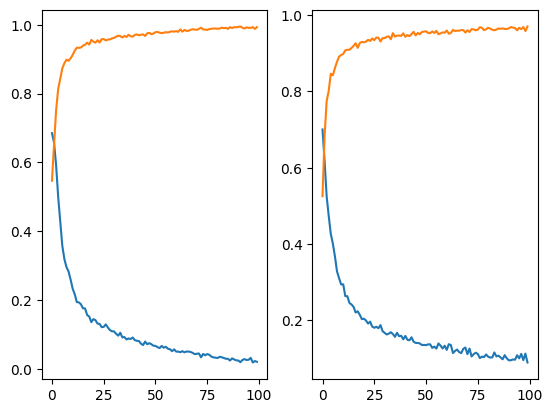

In [ ]:
#YOUR CODE HERE
import matplotlib.pyplot as plt
fig,axis=plt.subplots(nrows=1,ncols=2)
axis[0].plot(model_history1.history['loss'])
axis[0].plot(model_history1.history['accuracy'])
axis[1].plot(model_history2.history['loss'])
axis[1].plot(model_history2.history['accuracy'])
plt.show()


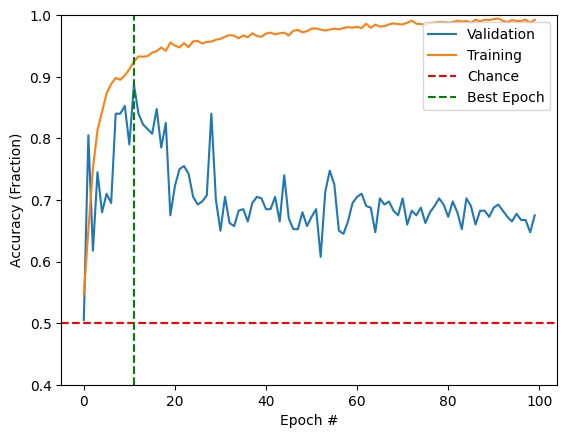

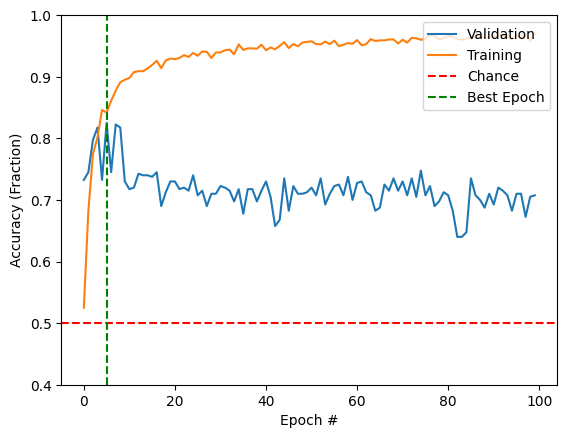

In [ ]:
#@title Sample Solution
plot_acc(model_history1)
plot_acc(model_history2)


# **Milestone 4. Expert models: Transfer learning**

For all of the machine learning we've done thus far, we've used models that were built from 'scratch'. All of these models are like newborn babies that have neither seen nor explored the world.

Unfortunately, our training manual is pretty small to all the things in the big wide world. So, just training on our manual is going to be inherently limited.


Luckily, there are **"experts"** who have much more training! While these **"experts"** haven't seen our task, they have experience with a lot of other things. We can hand them our training manual and reasonably expect that they will pick up our task fairly quickly.

In deep learning, the idea of using a model trained on another task as a starting point for your model is known as **transfer learning**.

### VGG 16

For our transfer learning, we're going to use 'experts' built upon the famous 'ImageNet' classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish 14 million images' categories, where there were > 20,000 categories available.

Below, we see examples of 4 different categories.

![](http://cs231n.github.io/assets/trainset.jpg)



One of the experts we can use is VGG 16. VGG 16 was a network that was allowed to study the 14 million images 74 times.

After its studying, VGG 16 was able to guess something close to the real label (top-5 accuracy) better than a human can.

![](https://cdn-images-1.medium.com/max/1600/0*V1muWIDnPVwZUuEv.png)

We're going to take an expert model like VGG16 and let it train on OUR x-rays. Hopefully, their experience with those 14 million images will help it understand pneumonia from our x-rays.

### Exercise (Coding)

Let's tap an expert model to help us out with our pneumonia prediction!

We provide a wrapper that lets you 'call' up and employ expert models. You can call it like...

```
transfer = TransferClassifier(name = 'VGG16')
```

The experts we have on hand are:
* `VGG16`
* `VGG19`
* `ResNet50`
* `DenseNet121`

There are default arguments/parameters to model.fit you can call:

`model.fit(train_data, train_labels, epochs = N, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])`

The shuffle parameter is important for shuffling the training data before each epoch. The monitor callback is used to get a view on internal states and statistics of the model during training. Do not change these parameters!

**Experiment with using these experts. Remember to fit and score your model, and to take a look at the training history.**




/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


 1/63 [..............................] - ETA: 11:29 - loss: 0.6830 - accuracy: 0.5625

 2/63 [..............................] - ETA: 5s - loss: 0.7103 - accuracy: 0.5469   

 3/63 [>.............................] - ETA: 5s - loss: 0.7403 - accuracy: 0.5208

 4/63 [>.............................] - ETA: 4s - loss: 0.7348 - accuracy: 0.5000

 5/63 [=>............................] - ETA: 4s - loss: 0.7578 - accuracy: 0.4938

 6/63 [=>............................] - ETA: 4s - loss: 0.7448 - accuracy: 0.5052

 7/63 [==>...........................] - ETA: 4s - loss: 0.7615 - accuracy: 0.4955

 8/63 [==>...........................] - ETA: 4s - loss: 0.7456 - accuracy: 0.5078

 9/63 [===>..........................] - ETA: 4s - loss: 0.7315 - accuracy: 0.5243

10/63 [===>..........................] - ETA: 4s - loss: 0.7275 - accuracy: 0.5375

11/63 [====>.........................] - ETA: 4s - loss: 0.7342 - accuracy: 0.5369

12/63 [====>.........................] - ETA: 4s - loss: 0.7441 - accuracy: 0.5417

13/63 [=====>........................] - ETA: 4s - loss: 0.7292 - accuracy: 0.5577

14/63 [=====>........................] - ETA: 3s - loss: 0.7232 - accuracy: 0.5647

15/63 [======>.......................] - ETA: 3s - loss: 0.7256 - accuracy: 0.5625

16/63 [======>.......................] - ETA: 3s - loss: 0.7194 - accuracy: 0.5723

17/63 [=======>......................] - ETA: 3s - loss: 0.7117 - accuracy: 0.5790

18/63 [=======>......................] - ETA: 3s - loss: 0.7135 - accuracy: 0.5833

19/63 [========>.....................] - ETA: 3s - loss: 0.7119 - accuracy: 0.5855

20/63 [========>.....................] - ETA: 3s - loss: 0.7103 - accuracy: 0.5906

21/63 [=========>....................] - ETA: 3s - loss: 0.7118 - accuracy: 0.5908

22/63 [=========>....................] - ETA: 3s - loss: 0.7228 - accuracy: 0.5852

23/63 [=========>....................] - ETA: 3s - loss: 0.7198 - accuracy: 0.5870

24/63 [==========>...................] - ETA: 3s - loss: 0.7181 - accuracy: 0.5938

25/63 [==========>...................] - ETA: 3s - loss: 0.7118 - accuracy: 0.5975

26/63 [===========>..................] - ETA: 2s - loss: 0.7128 - accuracy: 0.5950

27/63 [===========>..................] - ETA: 2s - loss: 0.7089 - accuracy: 0.5972

28/63 [============>.................] - ETA: 2s - loss: 0.7036 - accuracy: 0.5971

29/63 [============>.................] - ETA: 2s - loss: 0.7004 - accuracy: 0.5959

30/63 [=============>................] - ETA: 2s - loss: 0.6951 - accuracy: 0.6000

31/63 [=============>................] - ETA: 2s - loss: 0.6872 - accuracy: 0.6079

32/63 [==============>...............] - ETA: 2s - loss: 0.6837 - accuracy: 0.6123

33/63 [==============>...............] - ETA: 2s - loss: 0.6805 - accuracy: 0.6155

34/63 [===============>..............] - ETA: 2s - loss: 0.6772 - accuracy: 0.6195

35/63 [===============>..............] - ETA: 2s - loss: 0.6769 - accuracy: 0.6214

36/63 [================>.............] - ETA: 2s - loss: 0.6707 - accuracy: 0.6259

37/63 [================>.............] - ETA: 1s - loss: 0.6660 - accuracy: 0.6309

38/63 [=================>............] - ETA: 1s - loss: 0.6617 - accuracy: 0.6349

39/63 [=================>............] - ETA: 1s - loss: 0.6607 - accuracy: 0.6346

40/63 [==================>...........] - ETA: 1s - loss: 0.6585 - accuracy: 0.6352

41/63 [==================>...........] - ETA: 1s - loss: 0.6550 - accuracy: 0.6372

42/63 [===================>..........] - ETA: 1s - loss: 0.6537 - accuracy: 0.6391

43/63 [===================>..........] - ETA: 1s - loss: 0.6520 - accuracy: 0.6417

44/63 [===================>..........] - ETA: 1s - loss: 0.6488 - accuracy: 0.6449

45/63 [====================>.........] - ETA: 1s - loss: 0.6466 - accuracy: 0.6458

46/63 [====================>.........] - ETA: 1s - loss: 0.6422 - accuracy: 0.6508

47/63 [=====================>........] - ETA: 1s - loss: 0.6374 - accuracy: 0.6549

48/63 [=====================>........] - ETA: 1s - loss: 0.6348 - accuracy: 0.6556

49/63 [======================>.......] - ETA: 1s - loss: 0.6358 - accuracy: 0.6569

50/63 [======================>.......] - ETA: 0s - loss: 0.6327 - accuracy: 0.6594

51/63 [=======================>......] - ETA: 0s - loss: 0.6322 - accuracy: 0.6612

52/63 [=======================>......] - ETA: 0s - loss: 0.6267 - accuracy: 0.6659

53/63 [========================>.....] - ETA: 0s - loss: 0.6249 - accuracy: 0.6675

54/63 [========================>.....] - ETA: 0s - loss: 0.6231 - accuracy: 0.6672

55/63 [=========================>....] - ETA: 0s - loss: 0.6192 - accuracy: 0.6710

56/63 [=========================>....] - ETA: 0s - loss: 0.6156 - accuracy: 0.6730

57/63 [==========================>...] - ETA: 0s - loss: 0.6110 - accuracy: 0.6776

58/63 [==========================>...] - ETA: 0s - loss: 0.6076 - accuracy: 0.6810

59/63 [===========================>..] - ETA: 0s - loss: 0.6070 - accuracy: 0.6817

60/63 [===========================>..] - ETA: 0s - loss: 0.6046 - accuracy: 0.6833

61/63 [============================>.] - ETA: 0s - loss: 0.6016 - accuracy: 0.6849

62/63 [============================>.] - ETA: 0s - loss: 0.6008 - accuracy: 0.6865

63/63 [==============================] - 18s 106ms/step - loss: 0.6015 - accuracy: 0.6855 - val_loss: 0.6099 - val_accuracy: 0.6350
Epoch 2/100


 1/63 [..............................] - ETA: 4s - loss: 0.5145 - accuracy: 0.6875

 2/63 [..............................] - ETA: 3s - loss: 0.4594 - accuracy: 0.7656

 3/63 [>.............................] - ETA: 3s - loss: 0.4685 - accuracy: 0.7396

 4/63 [>.............................] - ETA: 3s - loss: 0.4769 - accuracy: 0.7344

 5/63 [=>............................] - ETA: 3s - loss: 0.4800 - accuracy: 0.7312

 6/63 [=>............................] - ETA: 3s - loss: 0.4517 - accuracy: 0.7656

 7/63 [==>...........................] - ETA: 3s - loss: 0.4381 - accuracy: 0.7723

 8/63 [==>...........................] - ETA: 3s - loss: 0.4206 - accuracy: 0.7930

 9/63 [===>..........................] - ETA: 3s - loss: 0.4046 - accuracy: 0.8056

10/63 [===>..........................] - ETA: 3s - loss: 0.4001 - accuracy: 0.8156

11/63 [====>.........................] - ETA: 3s - loss: 0.3985 - accuracy: 0.8182

12/63 [====>.........................] - ETA: 3s - loss: 0.3893 - accuracy: 0.8281

13/63 [=====>........................] - ETA: 3s - loss: 0.3895 - accuracy: 0.8245

14/63 [=====>........................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8304

15/63 [======>.......................] - ETA: 2s - loss: 0.3874 - accuracy: 0.8271

16/63 [======>.......................] - ETA: 2s - loss: 0.3782 - accuracy: 0.8359

17/63 [=======>......................] - ETA: 2s - loss: 0.3715 - accuracy: 0.8401

18/63 [=======>......................] - ETA: 2s - loss: 0.3679 - accuracy: 0.8420

19/63 [========>.....................] - ETA: 2s - loss: 0.3637 - accuracy: 0.8454

20/63 [========>.....................] - ETA: 2s - loss: 0.3606 - accuracy: 0.8484

21/63 [=========>....................] - ETA: 2s - loss: 0.3620 - accuracy: 0.8467

22/63 [=========>....................] - ETA: 2s - loss: 0.3559 - accuracy: 0.8523

23/63 [=========>....................] - ETA: 2s - loss: 0.3577 - accuracy: 0.8519

24/63 [==========>...................] - ETA: 2s - loss: 0.3571 - accuracy: 0.8516

25/63 [==========>...................] - ETA: 2s - loss: 0.3570 - accuracy: 0.8525

26/63 [===========>..................] - ETA: 2s - loss: 0.3577 - accuracy: 0.8522

27/63 [===========>..................] - ETA: 2s - loss: 0.3581 - accuracy: 0.8519

28/63 [============>.................] - ETA: 2s - loss: 0.3613 - accuracy: 0.8482

29/63 [============>.................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8513

30/63 [=============>................] - ETA: 1s - loss: 0.3570 - accuracy: 0.8521

31/63 [=============>................] - ETA: 1s - loss: 0.3583 - accuracy: 0.8508

32/63 [==============>...............] - ETA: 1s - loss: 0.3584 - accuracy: 0.8506

33/63 [==============>...............] - ETA: 1s - loss: 0.3551 - accuracy: 0.8532

34/63 [===============>..............] - ETA: 1s - loss: 0.3538 - accuracy: 0.8557

35/63 [===============>..............] - ETA: 1s - loss: 0.3513 - accuracy: 0.8580

36/63 [================>.............] - ETA: 1s - loss: 0.3526 - accuracy: 0.8568

37/63 [================>.............] - ETA: 1s - loss: 0.3564 - accuracy: 0.8547

38/63 [=================>............] - ETA: 1s - loss: 0.3536 - accuracy: 0.8561

39/63 [=================>............] - ETA: 1s - loss: 0.3521 - accuracy: 0.8574

40/63 [==================>...........] - ETA: 1s - loss: 0.3520 - accuracy: 0.8570

41/63 [==================>...........] - ETA: 1s - loss: 0.3504 - accuracy: 0.8582

42/63 [===================>..........] - ETA: 1s - loss: 0.3468 - accuracy: 0.8616

43/63 [===================>..........] - ETA: 1s - loss: 0.3457 - accuracy: 0.8612

44/63 [===================>..........] - ETA: 1s - loss: 0.3449 - accuracy: 0.8615

45/63 [====================>.........] - ETA: 1s - loss: 0.3443 - accuracy: 0.8611

46/63 [====================>.........] - ETA: 1s - loss: 0.3430 - accuracy: 0.8607

47/63 [=====================>........] - ETA: 0s - loss: 0.3412 - accuracy: 0.8624

48/63 [=====================>........] - ETA: 0s - loss: 0.3391 - accuracy: 0.8626

49/63 [======================>.......] - ETA: 0s - loss: 0.3374 - accuracy: 0.8642

50/63 [======================>.......] - ETA: 0s - loss: 0.3381 - accuracy: 0.8625

51/63 [=======================>......] - ETA: 0s - loss: 0.3366 - accuracy: 0.8634

52/63 [=======================>......] - ETA: 0s - loss: 0.3364 - accuracy: 0.8636

53/63 [========================>.....] - ETA: 0s - loss: 0.3361 - accuracy: 0.8632

54/63 [========================>.....] - ETA: 0s - loss: 0.3361 - accuracy: 0.8617

55/63 [=========================>....] - ETA: 0s - loss: 0.3330 - accuracy: 0.8642

56/63 [=========================>....] - ETA: 0s - loss: 0.3338 - accuracy: 0.8644

57/63 [==========================>...] - ETA: 0s - loss: 0.3321 - accuracy: 0.8657

58/63 [==========================>...] - ETA: 0s - loss: 0.3299 - accuracy: 0.8675

59/63 [===========================>..] - ETA: 0s - loss: 0.3294 - accuracy: 0.8686

60/63 [===========================>..] - ETA: 0s - loss: 0.3273 - accuracy: 0.8693

61/63 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8689

62/63 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.8705

63/63 [==============================] - 4s 63ms/step - loss: 0.3236 - accuracy: 0.8710 - val_loss: 0.5521 - val_accuracy: 0.6900
Epoch 3/100


 1/63 [..............................] - ETA: 3s - loss: 0.2050 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2209 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 3s - loss: 0.2072 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.1848 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.1868 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1869 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.1886 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.1883 - accuracy: 0.9609

 9/63 [===>..........................] - ETA: 3s - loss: 0.1838 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.1945 - accuracy: 0.9563

11/63 [====>.........................] - ETA: 3s - loss: 0.1929 - accuracy: 0.9574

12/63 [====>.........................] - ETA: 3s - loss: 0.1955 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 3s - loss: 0.2028 - accuracy: 0.9495

14/63 [=====>........................] - ETA: 3s - loss: 0.2028 - accuracy: 0.9464

15/63 [======>.......................] - ETA: 2s - loss: 0.2000 - accuracy: 0.9500

16/63 [======>.......................] - ETA: 2s - loss: 0.1966 - accuracy: 0.9512

17/63 [=======>......................] - ETA: 2s - loss: 0.1944 - accuracy: 0.9522

18/63 [=======>......................] - ETA: 2s - loss: 0.2003 - accuracy: 0.9497

19/63 [========>.....................] - ETA: 2s - loss: 0.2021 - accuracy: 0.9474

20/63 [========>.....................] - ETA: 2s - loss: 0.2082 - accuracy: 0.9469

21/63 [=========>....................] - ETA: 2s - loss: 0.2089 - accuracy: 0.9449

22/63 [=========>....................] - ETA: 2s - loss: 0.2068 - accuracy: 0.9460

23/63 [=========>....................] - ETA: 2s - loss: 0.2064 - accuracy: 0.9443

24/63 [==========>...................] - ETA: 2s - loss: 0.2066 - accuracy: 0.9440

25/63 [==========>...................] - ETA: 2s - loss: 0.2040 - accuracy: 0.9450

26/63 [===========>..................] - ETA: 2s - loss: 0.2029 - accuracy: 0.9471

27/63 [===========>..................] - ETA: 2s - loss: 0.2045 - accuracy: 0.9444

28/63 [============>.................] - ETA: 2s - loss: 0.2045 - accuracy: 0.9442

29/63 [============>.................] - ETA: 2s - loss: 0.2057 - accuracy: 0.9418

30/63 [=============>................] - ETA: 2s - loss: 0.2045 - accuracy: 0.9427

31/63 [=============>................] - ETA: 2s - loss: 0.2058 - accuracy: 0.9415

32/63 [==============>...............] - ETA: 1s - loss: 0.2035 - accuracy: 0.9424

33/63 [==============>...............] - ETA: 1s - loss: 0.2019 - accuracy: 0.9432

34/63 [===============>..............] - ETA: 1s - loss: 0.2016 - accuracy: 0.9430

35/63 [===============>..............] - ETA: 1s - loss: 0.2070 - accuracy: 0.9384

36/63 [================>.............] - ETA: 1s - loss: 0.2084 - accuracy: 0.9375

37/63 [================>.............] - ETA: 1s - loss: 0.2089 - accuracy: 0.9367

38/63 [=================>............] - ETA: 1s - loss: 0.2079 - accuracy: 0.9375

39/63 [=================>............] - ETA: 1s - loss: 0.2077 - accuracy: 0.9383

40/63 [==================>...........] - ETA: 1s - loss: 0.2064 - accuracy: 0.9398

41/63 [==================>...........] - ETA: 1s - loss: 0.2048 - accuracy: 0.9398

42/63 [===================>..........] - ETA: 1s - loss: 0.2039 - accuracy: 0.9405

43/63 [===================>..........] - ETA: 1s - loss: 0.2035 - accuracy: 0.9404

44/63 [===================>..........] - ETA: 1s - loss: 0.2041 - accuracy: 0.9403

45/63 [====================>.........] - ETA: 1s - loss: 0.2028 - accuracy: 0.9417

46/63 [====================>.........] - ETA: 1s - loss: 0.2020 - accuracy: 0.9423

47/63 [=====================>........] - ETA: 1s - loss: 0.2017 - accuracy: 0.9428

48/63 [=====================>........] - ETA: 1s - loss: 0.2019 - accuracy: 0.9421

49/63 [======================>.......] - ETA: 0s - loss: 0.2016 - accuracy: 0.9420

50/63 [======================>.......] - ETA: 0s - loss: 0.2020 - accuracy: 0.9419

51/63 [=======================>......] - ETA: 0s - loss: 0.2027 - accuracy: 0.9412

52/63 [=======================>......] - ETA: 0s - loss: 0.2022 - accuracy: 0.9411

53/63 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 0.9404

54/63 [========================>.....] - ETA: 0s - loss: 0.2011 - accuracy: 0.9410

55/63 [=========================>....] - ETA: 0s - loss: 0.2023 - accuracy: 0.9403

56/63 [=========================>....] - ETA: 0s - loss: 0.2006 - accuracy: 0.9408

57/63 [==========================>...] - ETA: 0s - loss: 0.2009 - accuracy: 0.9402

58/63 [==========================>...] - ETA: 0s - loss: 0.2010 - accuracy: 0.9397

59/63 [===========================>..] - ETA: 0s - loss: 0.1991 - accuracy: 0.9401

60/63 [===========================>..] - ETA: 0s - loss: 0.1993 - accuracy: 0.9396

61/63 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9401

62/63 [============================>.] - ETA: 0s - loss: 0.2014 - accuracy: 0.9395

63/63 [==============================] - 5s 74ms/step - loss: 0.2008 - accuracy: 0.9395 - val_loss: 0.4731 - val_accuracy: 0.7675
Epoch 4/100


 1/63 [..............................] - ETA: 3s - loss: 0.1216 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.1631 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 3s - loss: 0.1450 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1644 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 3s - loss: 0.1672 - accuracy: 0.9375

 6/63 [=>............................] - ETA: 3s - loss: 0.1642 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 3s - loss: 0.2029 - accuracy: 0.9196

 8/63 [==>...........................] - ETA: 3s - loss: 0.1990 - accuracy: 0.9258

 9/63 [===>..........................] - ETA: 3s - loss: 0.2034 - accuracy: 0.9236

10/63 [===>..........................] - ETA: 3s - loss: 0.1966 - accuracy: 0.9281

11/63 [====>.........................] - ETA: 3s - loss: 0.1905 - accuracy: 0.9347

12/63 [====>.........................] - ETA: 3s - loss: 0.1821 - accuracy: 0.9401

13/63 [=====>........................] - ETA: 3s - loss: 0.1777 - accuracy: 0.9423

14/63 [=====>........................] - ETA: 3s - loss: 0.1785 - accuracy: 0.9397

15/63 [======>.......................] - ETA: 2s - loss: 0.1766 - accuracy: 0.9417

16/63 [======>.......................] - ETA: 2s - loss: 0.1781 - accuracy: 0.9414

17/63 [=======>......................] - ETA: 2s - loss: 0.1755 - accuracy: 0.9412

18/63 [=======>......................] - ETA: 2s - loss: 0.1738 - accuracy: 0.9392

19/63 [========>.....................] - ETA: 2s - loss: 0.1739 - accuracy: 0.9391

20/63 [========>.....................] - ETA: 2s - loss: 0.1744 - accuracy: 0.9375

21/63 [=========>....................] - ETA: 2s - loss: 0.1745 - accuracy: 0.9375

22/63 [=========>....................] - ETA: 2s - loss: 0.1725 - accuracy: 0.9403

23/63 [=========>....................] - ETA: 2s - loss: 0.1706 - accuracy: 0.9402

24/63 [==========>...................] - ETA: 2s - loss: 0.1670 - accuracy: 0.9414

25/63 [==========>...................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9400

26/63 [===========>..................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9399

27/63 [===========>..................] - ETA: 2s - loss: 0.1658 - accuracy: 0.9410

28/63 [============>.................] - ETA: 2s - loss: 0.1650 - accuracy: 0.9420

29/63 [============>.................] - ETA: 2s - loss: 0.1628 - accuracy: 0.9440

30/63 [=============>................] - ETA: 2s - loss: 0.1649 - accuracy: 0.9448

31/63 [=============>................] - ETA: 1s - loss: 0.1642 - accuracy: 0.9456

32/63 [==============>...............] - ETA: 1s - loss: 0.1635 - accuracy: 0.9463

33/63 [==============>...............] - ETA: 1s - loss: 0.1602 - accuracy: 0.9479

34/63 [===============>..............] - ETA: 1s - loss: 0.1595 - accuracy: 0.9476

35/63 [===============>..............] - ETA: 1s - loss: 0.1590 - accuracy: 0.9473

36/63 [================>.............] - ETA: 1s - loss: 0.1579 - accuracy: 0.9470

37/63 [================>.............] - ETA: 1s - loss: 0.1565 - accuracy: 0.9476

38/63 [=================>............] - ETA: 1s - loss: 0.1553 - accuracy: 0.9490

39/63 [=================>............] - ETA: 1s - loss: 0.1580 - accuracy: 0.9487

40/63 [==================>...........] - ETA: 1s - loss: 0.1574 - accuracy: 0.9477

41/63 [==================>...........] - ETA: 1s - loss: 0.1563 - accuracy: 0.9489

42/63 [===================>..........] - ETA: 1s - loss: 0.1547 - accuracy: 0.9494

43/63 [===================>..........] - ETA: 1s - loss: 0.1534 - accuracy: 0.9499

44/63 [===================>..........] - ETA: 1s - loss: 0.1518 - accuracy: 0.9510

45/63 [====================>.........] - ETA: 1s - loss: 0.1527 - accuracy: 0.9507

46/63 [====================>.........] - ETA: 1s - loss: 0.1517 - accuracy: 0.9511

47/63 [=====================>........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9515

48/63 [=====================>........] - ETA: 0s - loss: 0.1503 - accuracy: 0.9518

49/63 [======================>.......] - ETA: 0s - loss: 0.1492 - accuracy: 0.9522

50/63 [======================>.......] - ETA: 0s - loss: 0.1491 - accuracy: 0.9513

51/63 [=======================>......] - ETA: 0s - loss: 0.1489 - accuracy: 0.9510

52/63 [=======================>......] - ETA: 0s - loss: 0.1498 - accuracy: 0.9513

53/63 [========================>.....] - ETA: 0s - loss: 0.1490 - accuracy: 0.9517

54/63 [========================>.....] - ETA: 0s - loss: 0.1477 - accuracy: 0.9525

55/63 [=========================>....] - ETA: 0s - loss: 0.1482 - accuracy: 0.9523

56/63 [=========================>....] - ETA: 0s - loss: 0.1488 - accuracy: 0.9520

57/63 [==========================>...] - ETA: 0s - loss: 0.1473 - accuracy: 0.9529

58/63 [==========================>...] - ETA: 0s - loss: 0.1463 - accuracy: 0.9531

59/63 [===========================>..] - ETA: 0s - loss: 0.1453 - accuracy: 0.9534

60/63 [===========================>..] - ETA: 0s - loss: 0.1468 - accuracy: 0.9526

61/63 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9524

62/63 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9521

63/63 [==============================] - 4s 67ms/step - loss: 0.1466 - accuracy: 0.9525 - val_loss: 0.5248 - val_accuracy: 0.7475
Epoch 5/100


 1/63 [..............................] - ETA: 3s - loss: 0.0657 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0866 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.0750 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 3s - loss: 0.0760 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 3s - loss: 0.0820 - accuracy: 0.9812

 6/63 [=>............................] - ETA: 3s - loss: 0.0795 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 3s - loss: 0.0819 - accuracy: 0.9866

 8/63 [==>...........................] - ETA: 3s - loss: 0.0859 - accuracy: 0.9844

 9/63 [===>..........................] - ETA: 3s - loss: 0.0973 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.1100 - accuracy: 0.9719

11/63 [====>.........................] - ETA: 3s - loss: 0.1086 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.1111 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.1186 - accuracy: 0.9663

14/63 [=====>........................] - ETA: 2s - loss: 0.1275 - accuracy: 0.9621

15/63 [======>.......................] - ETA: 2s - loss: 0.1332 - accuracy: 0.9604

16/63 [======>.......................] - ETA: 2s - loss: 0.1298 - accuracy: 0.9609

17/63 [=======>......................] - ETA: 2s - loss: 0.1315 - accuracy: 0.9596

18/63 [=======>......................] - ETA: 2s - loss: 0.1338 - accuracy: 0.9583

19/63 [========>.....................] - ETA: 2s - loss: 0.1305 - accuracy: 0.9605

20/63 [========>.....................] - ETA: 2s - loss: 0.1273 - accuracy: 0.9625

21/63 [=========>....................] - ETA: 2s - loss: 0.1271 - accuracy: 0.9628

22/63 [=========>....................] - ETA: 2s - loss: 0.1266 - accuracy: 0.9631

23/63 [=========>....................] - ETA: 2s - loss: 0.1246 - accuracy: 0.9633

24/63 [==========>...................] - ETA: 2s - loss: 0.1239 - accuracy: 0.9635

25/63 [==========>...................] - ETA: 2s - loss: 0.1222 - accuracy: 0.9650

26/63 [===========>..................] - ETA: 2s - loss: 0.1208 - accuracy: 0.9651

27/63 [===========>..................] - ETA: 2s - loss: 0.1205 - accuracy: 0.9641

28/63 [============>.................] - ETA: 2s - loss: 0.1231 - accuracy: 0.9621

29/63 [============>.................] - ETA: 2s - loss: 0.1236 - accuracy: 0.9601

30/63 [=============>................] - ETA: 2s - loss: 0.1218 - accuracy: 0.9615

31/63 [=============>................] - ETA: 1s - loss: 0.1325 - accuracy: 0.9587

32/63 [==============>...............] - ETA: 1s - loss: 0.1325 - accuracy: 0.9580

33/63 [==============>...............] - ETA: 1s - loss: 0.1303 - accuracy: 0.9593

34/63 [===============>..............] - ETA: 1s - loss: 0.1301 - accuracy: 0.9586

35/63 [===============>..............] - ETA: 1s - loss: 0.1289 - accuracy: 0.9598

36/63 [================>.............] - ETA: 1s - loss: 0.1278 - accuracy: 0.9601

37/63 [================>.............] - ETA: 1s - loss: 0.1270 - accuracy: 0.9611

38/63 [=================>............] - ETA: 1s - loss: 0.1253 - accuracy: 0.9622

39/63 [=================>............] - ETA: 1s - loss: 0.1247 - accuracy: 0.9615

40/63 [==================>...........] - ETA: 1s - loss: 0.1241 - accuracy: 0.9617

41/63 [==================>...........] - ETA: 1s - loss: 0.1235 - accuracy: 0.9619

42/63 [===================>..........] - ETA: 1s - loss: 0.1238 - accuracy: 0.9621

43/63 [===================>..........] - ETA: 1s - loss: 0.1235 - accuracy: 0.9615

44/63 [===================>..........] - ETA: 1s - loss: 0.1250 - accuracy: 0.9602

45/63 [====================>.........] - ETA: 1s - loss: 0.1251 - accuracy: 0.9597

46/63 [====================>.........] - ETA: 1s - loss: 0.1249 - accuracy: 0.9606

47/63 [=====================>........] - ETA: 0s - loss: 0.1241 - accuracy: 0.9614

48/63 [=====================>........] - ETA: 0s - loss: 0.1247 - accuracy: 0.9616

49/63 [======================>.......] - ETA: 0s - loss: 0.1241 - accuracy: 0.9617

50/63 [======================>.......] - ETA: 0s - loss: 0.1230 - accuracy: 0.9625

51/63 [=======================>......] - ETA: 0s - loss: 0.1217 - accuracy: 0.9632

52/63 [=======================>......] - ETA: 0s - loss: 0.1220 - accuracy: 0.9633

53/63 [========================>.....] - ETA: 0s - loss: 0.1220 - accuracy: 0.9629

54/63 [========================>.....] - ETA: 0s - loss: 0.1209 - accuracy: 0.9635

55/63 [=========================>....] - ETA: 0s - loss: 0.1198 - accuracy: 0.9642

56/63 [=========================>....] - ETA: 0s - loss: 0.1206 - accuracy: 0.9637

57/63 [==========================>...] - ETA: 0s - loss: 0.1196 - accuracy: 0.9638

58/63 [==========================>...] - ETA: 0s - loss: 0.1181 - accuracy: 0.9644

59/63 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9645

60/63 [===========================>..] - ETA: 0s - loss: 0.1165 - accuracy: 0.9651

61/63 [============================>.] - ETA: 0s - loss: 0.1161 - accuracy: 0.9652

62/63 [============================>.] - ETA: 0s - loss: 0.1164 - accuracy: 0.9647

63/63 [==============================] - 4s 66ms/step - loss: 0.1177 - accuracy: 0.9640 - val_loss: 0.5617 - val_accuracy: 0.7650
Epoch 6/100


 1/63 [..............................] - ETA: 3s - loss: 0.0848 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0998 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.1171 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.1166 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1043 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1097 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.1190 - accuracy: 0.9509

 8/63 [==>...........................] - ETA: 3s - loss: 0.1168 - accuracy: 0.9492

 9/63 [===>..........................] - ETA: 3s - loss: 0.1076 - accuracy: 0.9549

10/63 [===>..........................] - ETA: 3s - loss: 0.1042 - accuracy: 0.9594

11/63 [====>.........................] - ETA: 3s - loss: 0.1168 - accuracy: 0.9545

12/63 [====>.........................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9583

13/63 [=====>........................] - ETA: 3s - loss: 0.1106 - accuracy: 0.9615

14/63 [=====>........................] - ETA: 3s - loss: 0.1062 - accuracy: 0.9643

15/63 [======>.......................] - ETA: 3s - loss: 0.1031 - accuracy: 0.9667

16/63 [======>.......................] - ETA: 2s - loss: 0.0996 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 2s - loss: 0.1006 - accuracy: 0.9669

18/63 [=======>......................] - ETA: 2s - loss: 0.0980 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 2s - loss: 0.0974 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 2s - loss: 0.0955 - accuracy: 0.9703

21/63 [=========>....................] - ETA: 2s - loss: 0.0948 - accuracy: 0.9717

22/63 [=========>....................] - ETA: 2s - loss: 0.0954 - accuracy: 0.9716

23/63 [=========>....................] - ETA: 2s - loss: 0.0935 - accuracy: 0.9728

24/63 [==========>...................] - ETA: 2s - loss: 0.0927 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 2s - loss: 0.0926 - accuracy: 0.9750

26/63 [===========>..................] - ETA: 2s - loss: 0.0912 - accuracy: 0.9760

27/63 [===========>..................] - ETA: 2s - loss: 0.0935 - accuracy: 0.9745

28/63 [============>.................] - ETA: 2s - loss: 0.0947 - accuracy: 0.9743

29/63 [============>.................] - ETA: 2s - loss: 0.0951 - accuracy: 0.9731

30/63 [=============>................] - ETA: 2s - loss: 0.0934 - accuracy: 0.9740

31/63 [=============>................] - ETA: 2s - loss: 0.0915 - accuracy: 0.9748

32/63 [==============>...............] - ETA: 2s - loss: 0.0902 - accuracy: 0.9756

33/63 [==============>...............] - ETA: 2s - loss: 0.0904 - accuracy: 0.9754

34/63 [===============>..............] - ETA: 2s - loss: 0.0912 - accuracy: 0.9733

35/63 [===============>..............] - ETA: 2s - loss: 0.0902 - accuracy: 0.9741

36/63 [================>.............] - ETA: 2s - loss: 0.0925 - accuracy: 0.9722

37/63 [================>.............] - ETA: 2s - loss: 0.0931 - accuracy: 0.9721

38/63 [=================>............] - ETA: 2s - loss: 0.0939 - accuracy: 0.9720

39/63 [=================>............] - ETA: 2s - loss: 0.0923 - accuracy: 0.9728

40/63 [==================>...........] - ETA: 2s - loss: 0.0924 - accuracy: 0.9727

41/63 [==================>...........] - ETA: 2s - loss: 0.0931 - accuracy: 0.9710

42/63 [===================>..........] - ETA: 2s - loss: 0.0930 - accuracy: 0.9702

43/63 [===================>..........] - ETA: 2s - loss: 0.0917 - accuracy: 0.9709

44/63 [===================>..........] - ETA: 1s - loss: 0.0921 - accuracy: 0.9702

45/63 [====================>.........] - ETA: 1s - loss: 0.0928 - accuracy: 0.9701

46/63 [====================>.........] - ETA: 1s - loss: 0.0936 - accuracy: 0.9694

47/63 [=====================>........] - ETA: 1s - loss: 0.0946 - accuracy: 0.9688

48/63 [=====================>........] - ETA: 1s - loss: 0.0940 - accuracy: 0.9694

49/63 [======================>.......] - ETA: 1s - loss: 0.0931 - accuracy: 0.9700

50/63 [======================>.......] - ETA: 1s - loss: 0.0933 - accuracy: 0.9700

51/63 [=======================>......] - ETA: 1s - loss: 0.0931 - accuracy: 0.9700

52/63 [=======================>......] - ETA: 1s - loss: 0.0933 - accuracy: 0.9694

53/63 [========================>.....] - ETA: 1s - loss: 0.0928 - accuracy: 0.9693

54/63 [========================>.....] - ETA: 0s - loss: 0.0944 - accuracy: 0.9688

55/63 [=========================>....] - ETA: 0s - loss: 0.0937 - accuracy: 0.9693

56/63 [=========================>....] - ETA: 0s - loss: 0.0941 - accuracy: 0.9688

57/63 [==========================>...] - ETA: 0s - loss: 0.0940 - accuracy: 0.9688

58/63 [==========================>...] - ETA: 0s - loss: 0.0943 - accuracy: 0.9688

59/63 [===========================>..] - ETA: 0s - loss: 0.0939 - accuracy: 0.9693

60/63 [===========================>..] - ETA: 0s - loss: 0.0946 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9688

62/63 [============================>.] - ETA: 0s - loss: 0.0942 - accuracy: 0.9682

63/63 [==============================] - 7s 108ms/step - loss: 0.0941 - accuracy: 0.9685 - val_loss: 0.5203 - val_accuracy: 0.8000
Epoch 7/100


 1/63 [..............................] - ETA: 3s - loss: 0.0454 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0442 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 3s - loss: 0.0451 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 3s - loss: 0.0693 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0854 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 3s - loss: 0.0740 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 3s - loss: 0.0657 - accuracy: 0.9777

 8/63 [==>...........................] - ETA: 3s - loss: 0.0647 - accuracy: 0.9766

 9/63 [===>..........................] - ETA: 3s - loss: 0.0651 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 3s - loss: 0.0651 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9716

12/63 [====>.........................] - ETA: 3s - loss: 0.0697 - accuracy: 0.9740

13/63 [=====>........................] - ETA: 3s - loss: 0.0696 - accuracy: 0.9760

14/63 [=====>........................] - ETA: 3s - loss: 0.0693 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0676 - accuracy: 0.9771

16/63 [======>.......................] - ETA: 3s - loss: 0.0657 - accuracy: 0.9785

17/63 [=======>......................] - ETA: 2s - loss: 0.0665 - accuracy: 0.9779

18/63 [=======>......................] - ETA: 2s - loss: 0.0660 - accuracy: 0.9774

19/63 [========>.....................] - ETA: 2s - loss: 0.0694 - accuracy: 0.9737

20/63 [========>.....................] - ETA: 2s - loss: 0.0698 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0696 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0707 - accuracy: 0.9759

23/63 [=========>....................] - ETA: 2s - loss: 0.0690 - accuracy: 0.9769

24/63 [==========>...................] - ETA: 2s - loss: 0.0692 - accuracy: 0.9766

25/63 [==========>...................] - ETA: 2s - loss: 0.0673 - accuracy: 0.9775

26/63 [===========>..................] - ETA: 2s - loss: 0.0668 - accuracy: 0.9784

27/63 [===========>..................] - ETA: 2s - loss: 0.0654 - accuracy: 0.9792

28/63 [============>.................] - ETA: 2s - loss: 0.0648 - accuracy: 0.9799

29/63 [============>.................] - ETA: 2s - loss: 0.0665 - accuracy: 0.9784

30/63 [=============>................] - ETA: 2s - loss: 0.0655 - accuracy: 0.9792

31/63 [=============>................] - ETA: 2s - loss: 0.0652 - accuracy: 0.9798

32/63 [==============>...............] - ETA: 1s - loss: 0.0658 - accuracy: 0.9795

33/63 [==============>...............] - ETA: 1s - loss: 0.0673 - accuracy: 0.9782

34/63 [===============>..............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9779

35/63 [===============>..............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9786

36/63 [================>.............] - ETA: 1s - loss: 0.0669 - accuracy: 0.9792

37/63 [================>.............] - ETA: 1s - loss: 0.0673 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0683 - accuracy: 0.9778

39/63 [=================>............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9776

40/63 [==================>...........] - ETA: 1s - loss: 0.0683 - accuracy: 0.9773

41/63 [==================>...........] - ETA: 1s - loss: 0.0686 - accuracy: 0.9771

42/63 [===================>..........] - ETA: 1s - loss: 0.0679 - accuracy: 0.9777

43/63 [===================>..........] - ETA: 1s - loss: 0.0675 - accuracy: 0.9782

44/63 [===================>..........] - ETA: 1s - loss: 0.0676 - accuracy: 0.9780

45/63 [====================>.........] - ETA: 1s - loss: 0.0667 - accuracy: 0.9785

46/63 [====================>.........] - ETA: 1s - loss: 0.0697 - accuracy: 0.9776

47/63 [=====================>........] - ETA: 1s - loss: 0.0693 - accuracy: 0.9781

48/63 [=====================>........] - ETA: 0s - loss: 0.0697 - accuracy: 0.9779

49/63 [======================>.......] - ETA: 0s - loss: 0.0691 - accuracy: 0.9783

50/63 [======================>.......] - ETA: 0s - loss: 0.0688 - accuracy: 0.9787

51/63 [=======================>......] - ETA: 0s - loss: 0.0678 - accuracy: 0.9792

52/63 [=======================>......] - ETA: 0s - loss: 0.0674 - accuracy: 0.9790

53/63 [========================>.....] - ETA: 0s - loss: 0.0672 - accuracy: 0.9788

54/63 [========================>.....] - ETA: 0s - loss: 0.0679 - accuracy: 0.9786

55/63 [=========================>....] - ETA: 0s - loss: 0.0671 - accuracy: 0.9790

56/63 [=========================>....] - ETA: 0s - loss: 0.0669 - accuracy: 0.9788

57/63 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9781

58/63 [==========================>...] - ETA: 0s - loss: 0.0672 - accuracy: 0.9784

59/63 [===========================>..] - ETA: 0s - loss: 0.0675 - accuracy: 0.9783

60/63 [===========================>..] - ETA: 0s - loss: 0.0682 - accuracy: 0.9776

61/63 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9780

62/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9783

63/63 [==============================] - 4s 70ms/step - loss: 0.0676 - accuracy: 0.9785 - val_loss: 0.5458 - val_accuracy: 0.8000
Epoch 8/100


 1/63 [..............................] - ETA: 4s - loss: 0.0846 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.1047 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.1124 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.0955 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 3s - loss: 0.1115 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.0967 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 3s - loss: 0.1036 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 3s - loss: 0.0955 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0962 - accuracy: 0.9688

10/63 [===>..........................] - ETA: 3s - loss: 0.0941 - accuracy: 0.9656

11/63 [====>.........................] - ETA: 3s - loss: 0.0893 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 3s - loss: 0.0871 - accuracy: 0.9714

13/63 [=====>........................] - ETA: 3s - loss: 0.0851 - accuracy: 0.9736

14/63 [=====>........................] - ETA: 3s - loss: 0.0818 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0779 - accuracy: 0.9771

16/63 [======>.......................] - ETA: 3s - loss: 0.0777 - accuracy: 0.9766

17/63 [=======>......................] - ETA: 3s - loss: 0.0903 - accuracy: 0.9724

18/63 [=======>......................] - ETA: 2s - loss: 0.0875 - accuracy: 0.9740

19/63 [========>.....................] - ETA: 2s - loss: 0.0843 - accuracy: 0.9753

20/63 [========>.....................] - ETA: 2s - loss: 0.0845 - accuracy: 0.9734

21/63 [=========>....................] - ETA: 2s - loss: 0.0881 - accuracy: 0.9702

22/63 [=========>....................] - ETA: 2s - loss: 0.0861 - accuracy: 0.9716

23/63 [=========>....................] - ETA: 2s - loss: 0.0841 - accuracy: 0.9728

24/63 [==========>...................] - ETA: 2s - loss: 0.0843 - accuracy: 0.9727

25/63 [==========>...................] - ETA: 2s - loss: 0.0820 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 2s - loss: 0.0804 - accuracy: 0.9748

27/63 [===========>..................] - ETA: 2s - loss: 0.0891 - accuracy: 0.9722

28/63 [============>.................] - ETA: 2s - loss: 0.0876 - accuracy: 0.9721

29/63 [============>.................] - ETA: 2s - loss: 0.0854 - accuracy: 0.9731

30/63 [=============>................] - ETA: 2s - loss: 0.0834 - accuracy: 0.9740

31/63 [=============>................] - ETA: 2s - loss: 0.0832 - accuracy: 0.9738

32/63 [==============>...............] - ETA: 2s - loss: 0.0820 - accuracy: 0.9746

33/63 [==============>...............] - ETA: 1s - loss: 0.0805 - accuracy: 0.9754

34/63 [===============>..............] - ETA: 1s - loss: 0.0796 - accuracy: 0.9761

35/63 [===============>..............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9768

36/63 [================>.............] - ETA: 1s - loss: 0.0766 - accuracy: 0.9774

37/63 [================>.............] - ETA: 1s - loss: 0.0753 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0738 - accuracy: 0.9786

39/63 [=================>............] - ETA: 1s - loss: 0.0735 - accuracy: 0.9792

40/63 [==================>...........] - ETA: 1s - loss: 0.0728 - accuracy: 0.9789

41/63 [==================>...........] - ETA: 1s - loss: 0.0728 - accuracy: 0.9787

42/63 [===================>..........] - ETA: 1s - loss: 0.0718 - accuracy: 0.9792

43/63 [===================>..........] - ETA: 1s - loss: 0.0708 - accuracy: 0.9797

44/63 [===================>..........] - ETA: 1s - loss: 0.0705 - accuracy: 0.9801

45/63 [====================>.........] - ETA: 1s - loss: 0.0702 - accuracy: 0.9806

46/63 [====================>.........] - ETA: 1s - loss: 0.0700 - accuracy: 0.9810

47/63 [=====================>........] - ETA: 1s - loss: 0.0698 - accuracy: 0.9807

48/63 [=====================>........] - ETA: 1s - loss: 0.0691 - accuracy: 0.9811

49/63 [======================>.......] - ETA: 0s - loss: 0.0682 - accuracy: 0.9815

50/63 [======================>.......] - ETA: 0s - loss: 0.0677 - accuracy: 0.9819

51/63 [=======================>......] - ETA: 0s - loss: 0.0667 - accuracy: 0.9822

52/63 [=======================>......] - ETA: 0s - loss: 0.0666 - accuracy: 0.9820

53/63 [========================>.....] - ETA: 0s - loss: 0.0659 - accuracy: 0.9823

54/63 [========================>.....] - ETA: 0s - loss: 0.0654 - accuracy: 0.9826

55/63 [=========================>....] - ETA: 0s - loss: 0.0650 - accuracy: 0.9830

56/63 [=========================>....] - ETA: 0s - loss: 0.0652 - accuracy: 0.9833

57/63 [==========================>...] - ETA: 0s - loss: 0.0655 - accuracy: 0.9830

58/63 [==========================>...] - ETA: 0s - loss: 0.0665 - accuracy: 0.9822

59/63 [===========================>..] - ETA: 0s - loss: 0.0659 - accuracy: 0.9825

60/63 [===========================>..] - ETA: 0s - loss: 0.0654 - accuracy: 0.9828

61/63 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9831

62/63 [============================>.] - ETA: 0s - loss: 0.0640 - accuracy: 0.9834

63/63 [==============================] - 5s 75ms/step - loss: 0.0653 - accuracy: 0.9825 - val_loss: 0.5480 - val_accuracy: 0.7950
Epoch 9/100


 1/63 [..............................] - ETA: 5s - loss: 0.0497 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0505 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 5s - loss: 0.0451 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 4s - loss: 0.0438 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0456 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0458 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0425 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0430 - accuracy: 0.9922

 9/63 [===>..........................] - ETA: 4s - loss: 0.0476 - accuracy: 0.9896

10/63 [===>..........................] - ETA: 4s - loss: 0.0463 - accuracy: 0.9906

11/63 [====>.........................] - ETA: 4s - loss: 0.0556 - accuracy: 0.9830

12/63 [====>.........................] - ETA: 4s - loss: 0.0616 - accuracy: 0.9818

13/63 [=====>........................] - ETA: 4s - loss: 0.0694 - accuracy: 0.9784

14/63 [=====>........................] - ETA: 3s - loss: 0.0702 - accuracy: 0.9799

15/63 [======>.......................] - ETA: 3s - loss: 0.0684 - accuracy: 0.9812

16/63 [======>.......................] - ETA: 3s - loss: 0.0656 - accuracy: 0.9824

17/63 [=======>......................] - ETA: 3s - loss: 0.0652 - accuracy: 0.9816

18/63 [=======>......................] - ETA: 3s - loss: 0.0638 - accuracy: 0.9826

19/63 [========>.....................] - ETA: 3s - loss: 0.0675 - accuracy: 0.9803

20/63 [========>.....................] - ETA: 3s - loss: 0.0673 - accuracy: 0.9812

21/63 [=========>....................] - ETA: 3s - loss: 0.0682 - accuracy: 0.9807

22/63 [=========>....................] - ETA: 3s - loss: 0.0662 - accuracy: 0.9815

23/63 [=========>....................] - ETA: 3s - loss: 0.0645 - accuracy: 0.9823

24/63 [==========>...................] - ETA: 2s - loss: 0.0639 - accuracy: 0.9818

25/63 [==========>...................] - ETA: 2s - loss: 0.0622 - accuracy: 0.9825

26/63 [===========>..................] - ETA: 2s - loss: 0.0640 - accuracy: 0.9808

27/63 [===========>..................] - ETA: 2s - loss: 0.0632 - accuracy: 0.9815

28/63 [============>.................] - ETA: 2s - loss: 0.0630 - accuracy: 0.9821

29/63 [============>.................] - ETA: 2s - loss: 0.0624 - accuracy: 0.9828

30/63 [=============>................] - ETA: 2s - loss: 0.0623 - accuracy: 0.9823

31/63 [=============>................] - ETA: 2s - loss: 0.0613 - accuracy: 0.9829

32/63 [==============>...............] - ETA: 2s - loss: 0.0606 - accuracy: 0.9834

33/63 [==============>...............] - ETA: 2s - loss: 0.0596 - accuracy: 0.9839

34/63 [===============>..............] - ETA: 2s - loss: 0.0597 - accuracy: 0.9844

35/63 [===============>..............] - ETA: 2s - loss: 0.0586 - accuracy: 0.9848

36/63 [================>.............] - ETA: 1s - loss: 0.0588 - accuracy: 0.9852

37/63 [================>.............] - ETA: 1s - loss: 0.0585 - accuracy: 0.9856

38/63 [=================>............] - ETA: 1s - loss: 0.0574 - accuracy: 0.9860

39/63 [=================>............] - ETA: 1s - loss: 0.0566 - accuracy: 0.9864

40/63 [==================>...........] - ETA: 1s - loss: 0.0560 - accuracy: 0.9867

41/63 [==================>...........] - ETA: 1s - loss: 0.0559 - accuracy: 0.9863

42/63 [===================>..........] - ETA: 1s - loss: 0.0565 - accuracy: 0.9859

43/63 [===================>..........] - ETA: 1s - loss: 0.0564 - accuracy: 0.9862

44/63 [===================>..........] - ETA: 1s - loss: 0.0573 - accuracy: 0.9851

45/63 [====================>.........] - ETA: 1s - loss: 0.0586 - accuracy: 0.9833

46/63 [====================>.........] - ETA: 1s - loss: 0.0576 - accuracy: 0.9837

47/63 [=====================>........] - ETA: 1s - loss: 0.0612 - accuracy: 0.9827

48/63 [=====================>........] - ETA: 1s - loss: 0.0619 - accuracy: 0.9824

49/63 [======================>.......] - ETA: 0s - loss: 0.0612 - accuracy: 0.9828

50/63 [======================>.......] - ETA: 0s - loss: 0.0618 - accuracy: 0.9819

51/63 [=======================>......] - ETA: 0s - loss: 0.0621 - accuracy: 0.9816

52/63 [=======================>......] - ETA: 0s - loss: 0.0614 - accuracy: 0.9820

53/63 [========================>.....] - ETA: 0s - loss: 0.0606 - accuracy: 0.9823

54/63 [========================>.....] - ETA: 0s - loss: 0.0601 - accuracy: 0.9826

55/63 [=========================>....] - ETA: 0s - loss: 0.0600 - accuracy: 0.9830

56/63 [=========================>....] - ETA: 0s - loss: 0.0594 - accuracy: 0.9833

57/63 [==========================>...] - ETA: 0s - loss: 0.0603 - accuracy: 0.9819

58/63 [==========================>...] - ETA: 0s - loss: 0.0612 - accuracy: 0.9811

59/63 [===========================>..] - ETA: 0s - loss: 0.0604 - accuracy: 0.9815

60/63 [===========================>..] - ETA: 0s - loss: 0.0603 - accuracy: 0.9812

61/63 [============================>.] - ETA: 0s - loss: 0.0602 - accuracy: 0.9810

62/63 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 0.9814

63/63 [==============================] - 5s 74ms/step - loss: 0.0594 - accuracy: 0.9815 - val_loss: 0.5737 - val_accuracy: 0.7950
Epoch 10/100


 1/63 [..............................] - ETA: 4s - loss: 0.0503 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0392 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0305 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 3s - loss: 0.0268 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 3s - loss: 0.0355 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 3s - loss: 0.0310 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 3s - loss: 0.0302 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 3s - loss: 0.0293 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0314 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0353 - accuracy: 0.9937

11/63 [====>.........................] - ETA: 3s - loss: 0.0347 - accuracy: 0.9943

12/63 [====>.........................] - ETA: 3s - loss: 0.0345 - accuracy: 0.9948

13/63 [=====>........................] - ETA: 3s - loss: 0.0447 - accuracy: 0.9904

14/63 [=====>........................] - ETA: 3s - loss: 0.0425 - accuracy: 0.9911

15/63 [======>.......................] - ETA: 3s - loss: 0.0419 - accuracy: 0.9917

16/63 [======>.......................] - ETA: 3s - loss: 0.0412 - accuracy: 0.9922

17/63 [=======>......................] - ETA: 3s - loss: 0.0415 - accuracy: 0.9908

18/63 [=======>......................] - ETA: 2s - loss: 0.0413 - accuracy: 0.9913

19/63 [========>.....................] - ETA: 2s - loss: 0.0408 - accuracy: 0.9918

20/63 [========>.....................] - ETA: 2s - loss: 0.0462 - accuracy: 0.9891

21/63 [=========>....................] - ETA: 2s - loss: 0.0455 - accuracy: 0.9896

22/63 [=========>....................] - ETA: 2s - loss: 0.0442 - accuracy: 0.9901

23/63 [=========>....................] - ETA: 2s - loss: 0.0449 - accuracy: 0.9891

24/63 [==========>...................] - ETA: 2s - loss: 0.0447 - accuracy: 0.9896

25/63 [==========>...................] - ETA: 2s - loss: 0.0444 - accuracy: 0.9900

26/63 [===========>..................] - ETA: 2s - loss: 0.0447 - accuracy: 0.9892

27/63 [===========>..................] - ETA: 2s - loss: 0.0446 - accuracy: 0.9884

28/63 [============>.................] - ETA: 2s - loss: 0.0444 - accuracy: 0.9888

29/63 [============>.................] - ETA: 2s - loss: 0.0451 - accuracy: 0.9892

30/63 [=============>................] - ETA: 2s - loss: 0.0442 - accuracy: 0.9896

31/63 [=============>................] - ETA: 2s - loss: 0.0435 - accuracy: 0.9899

32/63 [==============>...............] - ETA: 2s - loss: 0.0441 - accuracy: 0.9893

33/63 [==============>...............] - ETA: 1s - loss: 0.0471 - accuracy: 0.9877

34/63 [===============>..............] - ETA: 1s - loss: 0.0464 - accuracy: 0.9881

35/63 [===============>..............] - ETA: 1s - loss: 0.0469 - accuracy: 0.9875

36/63 [================>.............] - ETA: 1s - loss: 0.0464 - accuracy: 0.9870

37/63 [================>.............] - ETA: 1s - loss: 0.0457 - accuracy: 0.9873

38/63 [=================>............] - ETA: 1s - loss: 0.0461 - accuracy: 0.9877

39/63 [=================>............] - ETA: 1s - loss: 0.0454 - accuracy: 0.9880

40/63 [==================>...........] - ETA: 1s - loss: 0.0446 - accuracy: 0.9883

41/63 [==================>...........] - ETA: 1s - loss: 0.0442 - accuracy: 0.9886

42/63 [===================>..........] - ETA: 1s - loss: 0.0461 - accuracy: 0.9874

43/63 [===================>..........] - ETA: 1s - loss: 0.0468 - accuracy: 0.9869

44/63 [===================>..........] - ETA: 1s - loss: 0.0460 - accuracy: 0.9872

45/63 [====================>.........] - ETA: 1s - loss: 0.0468 - accuracy: 0.9868

46/63 [====================>.........] - ETA: 1s - loss: 0.0465 - accuracy: 0.9871

47/63 [=====================>........] - ETA: 1s - loss: 0.0462 - accuracy: 0.9874

48/63 [=====================>........] - ETA: 1s - loss: 0.0468 - accuracy: 0.9876

49/63 [======================>.......] - ETA: 0s - loss: 0.0461 - accuracy: 0.9879

50/63 [======================>.......] - ETA: 0s - loss: 0.0458 - accuracy: 0.9881

51/63 [=======================>......] - ETA: 0s - loss: 0.0454 - accuracy: 0.9884

52/63 [=======================>......] - ETA: 0s - loss: 0.0452 - accuracy: 0.9886

53/63 [========================>.....] - ETA: 0s - loss: 0.0449 - accuracy: 0.9888

54/63 [========================>.....] - ETA: 0s - loss: 0.0444 - accuracy: 0.9890

55/63 [=========================>....] - ETA: 0s - loss: 0.0442 - accuracy: 0.9892

56/63 [=========================>....] - ETA: 0s - loss: 0.0455 - accuracy: 0.9888

57/63 [==========================>...] - ETA: 0s - loss: 0.0454 - accuracy: 0.9890

58/63 [==========================>...] - ETA: 0s - loss: 0.0454 - accuracy: 0.9892

59/63 [===========================>..] - ETA: 0s - loss: 0.0461 - accuracy: 0.9889

60/63 [===========================>..] - ETA: 0s - loss: 0.0456 - accuracy: 0.9891

61/63 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9892

62/63 [============================>.] - ETA: 0s - loss: 0.0449 - accuracy: 0.9894

63/63 [==============================] - 4s 71ms/step - loss: 0.0447 - accuracy: 0.9895 - val_loss: 0.6483 - val_accuracy: 0.7875
Epoch 11/100


 1/63 [..............................] - ETA: 3s - loss: 0.0855 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.0493 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.0382 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 4s - loss: 0.0393 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 4s - loss: 0.0389 - accuracy: 0.9875

 6/63 [=>............................] - ETA: 3s - loss: 0.0388 - accuracy: 0.9844

 7/63 [==>...........................] - ETA: 3s - loss: 0.0705 - accuracy: 0.9643

 8/63 [==>...........................] - ETA: 3s - loss: 0.0640 - accuracy: 0.9688

 9/63 [===>..........................] - ETA: 3s - loss: 0.0607 - accuracy: 0.9722

10/63 [===>..........................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 3s - loss: 0.0574 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.0554 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 3s - loss: 0.0546 - accuracy: 0.9760

14/63 [=====>........................] - ETA: 3s - loss: 0.0519 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 3s - loss: 0.0637 - accuracy: 0.9708

16/63 [======>.......................] - ETA: 3s - loss: 0.0622 - accuracy: 0.9727

17/63 [=======>......................] - ETA: 3s - loss: 0.0599 - accuracy: 0.9743

18/63 [=======>......................] - ETA: 3s - loss: 0.0573 - accuracy: 0.9757

19/63 [========>.....................] - ETA: 3s - loss: 0.0555 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0535 - accuracy: 0.9781

21/63 [=========>....................] - ETA: 2s - loss: 0.0516 - accuracy: 0.9792

22/63 [=========>....................] - ETA: 2s - loss: 0.0501 - accuracy: 0.9801

23/63 [=========>....................] - ETA: 2s - loss: 0.0504 - accuracy: 0.9796

24/63 [==========>...................] - ETA: 2s - loss: 0.0490 - accuracy: 0.9805

25/63 [==========>...................] - ETA: 2s - loss: 0.0478 - accuracy: 0.9812

26/63 [===========>..................] - ETA: 2s - loss: 0.0482 - accuracy: 0.9808

27/63 [===========>..................] - ETA: 2s - loss: 0.0519 - accuracy: 0.9792

28/63 [============>.................] - ETA: 2s - loss: 0.0509 - accuracy: 0.9799

29/63 [============>.................] - ETA: 2s - loss: 0.0505 - accuracy: 0.9806

30/63 [=============>................] - ETA: 2s - loss: 0.0496 - accuracy: 0.9812

31/63 [=============>................] - ETA: 2s - loss: 0.0488 - accuracy: 0.9819

32/63 [==============>...............] - ETA: 2s - loss: 0.0487 - accuracy: 0.9824

33/63 [==============>...............] - ETA: 2s - loss: 0.0478 - accuracy: 0.9830

34/63 [===============>..............] - ETA: 2s - loss: 0.0471 - accuracy: 0.9835

35/63 [===============>..............] - ETA: 2s - loss: 0.0476 - accuracy: 0.9821

36/63 [================>.............] - ETA: 1s - loss: 0.0470 - accuracy: 0.9826

37/63 [================>.............] - ETA: 1s - loss: 0.0481 - accuracy: 0.9823

38/63 [=================>............] - ETA: 1s - loss: 0.0479 - accuracy: 0.9827

39/63 [=================>............] - ETA: 1s - loss: 0.0482 - accuracy: 0.9824

40/63 [==================>...........] - ETA: 1s - loss: 0.0482 - accuracy: 0.9820

41/63 [==================>...........] - ETA: 1s - loss: 0.0476 - accuracy: 0.9825

42/63 [===================>..........] - ETA: 1s - loss: 0.0470 - accuracy: 0.9829

43/63 [===================>..........] - ETA: 1s - loss: 0.0465 - accuracy: 0.9833

44/63 [===================>..........] - ETA: 1s - loss: 0.0474 - accuracy: 0.9830

45/63 [====================>.........] - ETA: 1s - loss: 0.0482 - accuracy: 0.9826

46/63 [====================>.........] - ETA: 1s - loss: 0.0474 - accuracy: 0.9830

47/63 [=====================>........] - ETA: 1s - loss: 0.0469 - accuracy: 0.9834

48/63 [=====================>........] - ETA: 1s - loss: 0.0472 - accuracy: 0.9831

49/63 [======================>.......] - ETA: 1s - loss: 0.0466 - accuracy: 0.9834

50/63 [======================>.......] - ETA: 0s - loss: 0.0460 - accuracy: 0.9837

51/63 [=======================>......] - ETA: 0s - loss: 0.0486 - accuracy: 0.9835

52/63 [=======================>......] - ETA: 0s - loss: 0.0482 - accuracy: 0.9838

53/63 [========================>.....] - ETA: 0s - loss: 0.0484 - accuracy: 0.9841

54/63 [========================>.....] - ETA: 0s - loss: 0.0477 - accuracy: 0.9844

55/63 [=========================>....] - ETA: 0s - loss: 0.0472 - accuracy: 0.9847

56/63 [=========================>....] - ETA: 0s - loss: 0.0472 - accuracy: 0.9844

57/63 [==========================>...] - ETA: 0s - loss: 0.0467 - accuracy: 0.9846

58/63 [==========================>...] - ETA: 0s - loss: 0.0461 - accuracy: 0.9849

59/63 [===========================>..] - ETA: 0s - loss: 0.0488 - accuracy: 0.9841

60/63 [===========================>..] - ETA: 0s - loss: 0.0489 - accuracy: 0.9839

61/63 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9841

62/63 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9844

63/63 [==============================] - 5s 81ms/step - loss: 0.0485 - accuracy: 0.9845 - val_loss: 0.5606 - val_accuracy: 0.8325
Epoch 12/100


 1/63 [..............................] - ETA: 6s - loss: 0.0212 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 0.0165 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0177 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0241 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0247 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0218 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0211 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0203 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0202 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0189 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0182 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0186 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0185 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0195 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0200 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0213 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0215 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0214 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0256 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0255 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0275 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 2s - loss: 0.0389 - accuracy: 0.9929

23/63 [=========>....................] - ETA: 2s - loss: 0.0379 - accuracy: 0.9932

24/63 [==========>...................] - ETA: 2s - loss: 0.0373 - accuracy: 0.9935

25/63 [==========>...................] - ETA: 2s - loss: 0.0371 - accuracy: 0.9937

26/63 [===========>..................] - ETA: 2s - loss: 0.0363 - accuracy: 0.9940

27/63 [===========>..................] - ETA: 2s - loss: 0.0368 - accuracy: 0.9931

28/63 [============>.................] - ETA: 2s - loss: 0.0374 - accuracy: 0.9922

29/63 [============>.................] - ETA: 2s - loss: 0.0368 - accuracy: 0.9925

30/63 [=============>................] - ETA: 2s - loss: 0.0364 - accuracy: 0.9927

31/63 [=============>................] - ETA: 2s - loss: 0.0358 - accuracy: 0.9929

32/63 [==============>...............] - ETA: 2s - loss: 0.0349 - accuracy: 0.9932

33/63 [==============>...............] - ETA: 2s - loss: 0.0342 - accuracy: 0.9934

34/63 [===============>..............] - ETA: 2s - loss: 0.0341 - accuracy: 0.9936

35/63 [===============>..............] - ETA: 1s - loss: 0.0340 - accuracy: 0.9937

36/63 [================>.............] - ETA: 1s - loss: 0.0371 - accuracy: 0.9913

37/63 [================>.............] - ETA: 1s - loss: 0.0367 - accuracy: 0.9916

38/63 [=================>............] - ETA: 1s - loss: 0.0360 - accuracy: 0.9918

39/63 [=================>............] - ETA: 1s - loss: 0.0356 - accuracy: 0.9920

40/63 [==================>...........] - ETA: 1s - loss: 0.0354 - accuracy: 0.9922

41/63 [==================>...........] - ETA: 1s - loss: 0.0353 - accuracy: 0.9924

42/63 [===================>..........] - ETA: 1s - loss: 0.0350 - accuracy: 0.9926

43/63 [===================>..........] - ETA: 1s - loss: 0.0347 - accuracy: 0.9927

44/63 [===================>..........] - ETA: 1s - loss: 0.0356 - accuracy: 0.9922

45/63 [====================>.........] - ETA: 1s - loss: 0.0365 - accuracy: 0.9924

46/63 [====================>.........] - ETA: 1s - loss: 0.0364 - accuracy: 0.9925

47/63 [=====================>........] - ETA: 1s - loss: 0.0365 - accuracy: 0.9927

48/63 [=====================>........] - ETA: 1s - loss: 0.0361 - accuracy: 0.9928

49/63 [======================>.......] - ETA: 0s - loss: 0.0356 - accuracy: 0.9930

50/63 [======================>.......] - ETA: 0s - loss: 0.0357 - accuracy: 0.9931

51/63 [=======================>......] - ETA: 0s - loss: 0.0362 - accuracy: 0.9926

52/63 [=======================>......] - ETA: 0s - loss: 0.0365 - accuracy: 0.9922

53/63 [========================>.....] - ETA: 0s - loss: 0.0371 - accuracy: 0.9912

54/63 [========================>.....] - ETA: 0s - loss: 0.0367 - accuracy: 0.9913

55/63 [=========================>....] - ETA: 0s - loss: 0.0368 - accuracy: 0.9909

56/63 [=========================>....] - ETA: 0s - loss: 0.0364 - accuracy: 0.9911

57/63 [==========================>...] - ETA: 0s - loss: 0.0363 - accuracy: 0.9912

58/63 [==========================>...] - ETA: 0s - loss: 0.0380 - accuracy: 0.9903

59/63 [===========================>..] - ETA: 0s - loss: 0.0377 - accuracy: 0.9905

60/63 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9906

61/63 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9903

62/63 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9904

63/63 [==============================] - 5s 75ms/step - loss: 0.0386 - accuracy: 0.9905 - val_loss: 0.6418 - val_accuracy: 0.7925
Epoch 13/100


 1/63 [..............................] - ETA: 3s - loss: 0.0178 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0147 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0281 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0243 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 3s - loss: 0.0217 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 3s - loss: 0.0216 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 3s - loss: 0.0205 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0201 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0194 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0190 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0182 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0200 - accuracy: 0.9952

14/63 [=====>........................] - ETA: 3s - loss: 0.0198 - accuracy: 0.9955

15/63 [======>.......................] - ETA: 3s - loss: 0.0193 - accuracy: 0.9958

16/63 [======>.......................] - ETA: 3s - loss: 0.0192 - accuracy: 0.9961

17/63 [=======>......................] - ETA: 3s - loss: 0.0204 - accuracy: 0.9945

18/63 [=======>......................] - ETA: 3s - loss: 0.0203 - accuracy: 0.9948

19/63 [========>.....................] - ETA: 3s - loss: 0.0373 - accuracy: 0.9885

20/63 [========>.....................] - ETA: 3s - loss: 0.0362 - accuracy: 0.9891

21/63 [=========>....................] - ETA: 2s - loss: 0.0350 - accuracy: 0.9896

22/63 [=========>....................] - ETA: 2s - loss: 0.0339 - accuracy: 0.9901

23/63 [=========>....................] - ETA: 2s - loss: 0.0336 - accuracy: 0.9905

24/63 [==========>...................] - ETA: 2s - loss: 0.0329 - accuracy: 0.9909

25/63 [==========>...................] - ETA: 2s - loss: 0.0337 - accuracy: 0.9900

26/63 [===========>..................] - ETA: 2s - loss: 0.0328 - accuracy: 0.9904

27/63 [===========>..................] - ETA: 2s - loss: 0.0321 - accuracy: 0.9907

28/63 [============>.................] - ETA: 2s - loss: 0.0318 - accuracy: 0.9911

29/63 [============>.................] - ETA: 2s - loss: 0.0313 - accuracy: 0.9914

30/63 [=============>................] - ETA: 2s - loss: 0.0307 - accuracy: 0.9917

31/63 [=============>................] - ETA: 2s - loss: 0.0303 - accuracy: 0.9919

32/63 [==============>...............] - ETA: 2s - loss: 0.0297 - accuracy: 0.9922

33/63 [==============>...............] - ETA: 2s - loss: 0.0293 - accuracy: 0.9924

34/63 [===============>..............] - ETA: 2s - loss: 0.0290 - accuracy: 0.9926

35/63 [===============>..............] - ETA: 1s - loss: 0.0286 - accuracy: 0.9929

36/63 [================>.............] - ETA: 1s - loss: 0.0283 - accuracy: 0.9931

37/63 [================>.............] - ETA: 1s - loss: 0.0279 - accuracy: 0.9932

38/63 [=================>............] - ETA: 1s - loss: 0.0275 - accuracy: 0.9934

39/63 [=================>............] - ETA: 1s - loss: 0.0281 - accuracy: 0.9936

40/63 [==================>...........] - ETA: 1s - loss: 0.0296 - accuracy: 0.9937

41/63 [==================>...........] - ETA: 1s - loss: 0.0291 - accuracy: 0.9939

42/63 [===================>..........] - ETA: 1s - loss: 0.0303 - accuracy: 0.9933

43/63 [===================>..........] - ETA: 1s - loss: 0.0299 - accuracy: 0.9935

44/63 [===================>..........] - ETA: 1s - loss: 0.0313 - accuracy: 0.9929

45/63 [====================>.........] - ETA: 1s - loss: 0.0310 - accuracy: 0.9931

46/63 [====================>.........] - ETA: 1s - loss: 0.0309 - accuracy: 0.9932

47/63 [=====================>........] - ETA: 1s - loss: 0.0310 - accuracy: 0.9927

48/63 [=====================>........] - ETA: 1s - loss: 0.0324 - accuracy: 0.9915

49/63 [======================>.......] - ETA: 0s - loss: 0.0325 - accuracy: 0.9911

50/63 [======================>.......] - ETA: 0s - loss: 0.0320 - accuracy: 0.9912

51/63 [=======================>......] - ETA: 0s - loss: 0.0318 - accuracy: 0.9914

52/63 [=======================>......] - ETA: 0s - loss: 0.0316 - accuracy: 0.9916

53/63 [========================>.....] - ETA: 0s - loss: 0.0310 - accuracy: 0.9917

54/63 [========================>.....] - ETA: 0s - loss: 0.0306 - accuracy: 0.9919

55/63 [=========================>....] - ETA: 0s - loss: 0.0307 - accuracy: 0.9920

56/63 [=========================>....] - ETA: 0s - loss: 0.0304 - accuracy: 0.9922

57/63 [==========================>...] - ETA: 0s - loss: 0.0303 - accuracy: 0.9923

58/63 [==========================>...] - ETA: 0s - loss: 0.0299 - accuracy: 0.9925

59/63 [===========================>..] - ETA: 0s - loss: 0.0296 - accuracy: 0.9926

60/63 [===========================>..] - ETA: 0s - loss: 0.0296 - accuracy: 0.9927

61/63 [============================>.] - ETA: 0s - loss: 0.0292 - accuracy: 0.9928

62/63 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9929

63/63 [==============================] - 5s 76ms/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.5833 - val_accuracy: 0.8225
Epoch 14/100


 1/63 [..............................] - ETA: 4s - loss: 0.0250 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0198 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0154 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0214 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0218 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0200 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0213 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0208 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0190 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0177 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0179 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0200 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0210 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0220 - accuracy: 0.9955

15/63 [======>.......................] - ETA: 3s - loss: 0.0215 - accuracy: 0.9958

16/63 [======>.......................] - ETA: 3s - loss: 0.0208 - accuracy: 0.9961

17/63 [=======>......................] - ETA: 3s - loss: 0.0200 - accuracy: 0.9963

18/63 [=======>......................] - ETA: 3s - loss: 0.0192 - accuracy: 0.9965

19/63 [========>.....................] - ETA: 3s - loss: 0.0186 - accuracy: 0.9967

20/63 [========>.....................] - ETA: 3s - loss: 0.0185 - accuracy: 0.9969

21/63 [=========>....................] - ETA: 3s - loss: 0.0198 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0199 - accuracy: 0.9972

23/63 [=========>....................] - ETA: 3s - loss: 0.0198 - accuracy: 0.9973

24/63 [==========>...................] - ETA: 3s - loss: 0.0212 - accuracy: 0.9961

25/63 [==========>...................] - ETA: 3s - loss: 0.0206 - accuracy: 0.9962

26/63 [===========>..................] - ETA: 2s - loss: 0.0209 - accuracy: 0.9964

27/63 [===========>..................] - ETA: 2s - loss: 0.0210 - accuracy: 0.9965

28/63 [============>.................] - ETA: 2s - loss: 0.0207 - accuracy: 0.9967

29/63 [============>.................] - ETA: 2s - loss: 0.0206 - accuracy: 0.9968

30/63 [=============>................] - ETA: 2s - loss: 0.0201 - accuracy: 0.9969

31/63 [=============>................] - ETA: 2s - loss: 0.0198 - accuracy: 0.9970

32/63 [==============>...............] - ETA: 2s - loss: 0.0220 - accuracy: 0.9961

33/63 [==============>...............] - ETA: 2s - loss: 0.0219 - accuracy: 0.9962

34/63 [===============>..............] - ETA: 2s - loss: 0.0229 - accuracy: 0.9963

35/63 [===============>..............] - ETA: 2s - loss: 0.0228 - accuracy: 0.9964

36/63 [================>.............] - ETA: 2s - loss: 0.0252 - accuracy: 0.9948

37/63 [================>.............] - ETA: 2s - loss: 0.0249 - accuracy: 0.9949

38/63 [=================>............] - ETA: 2s - loss: 0.0246 - accuracy: 0.9951

39/63 [=================>............] - ETA: 1s - loss: 0.0244 - accuracy: 0.9952

40/63 [==================>...........] - ETA: 1s - loss: 0.0241 - accuracy: 0.9953

41/63 [==================>...........] - ETA: 1s - loss: 0.0242 - accuracy: 0.9954

42/63 [===================>..........] - ETA: 1s - loss: 0.0243 - accuracy: 0.9955

43/63 [===================>..........] - ETA: 1s - loss: 0.0244 - accuracy: 0.9956

44/63 [===================>..........] - ETA: 1s - loss: 0.0242 - accuracy: 0.9957

45/63 [====================>.........] - ETA: 1s - loss: 0.0242 - accuracy: 0.9958

46/63 [====================>.........] - ETA: 1s - loss: 0.0238 - accuracy: 0.9959

47/63 [=====================>........] - ETA: 1s - loss: 0.0243 - accuracy: 0.9953

48/63 [=====================>........] - ETA: 1s - loss: 0.0240 - accuracy: 0.9954

49/63 [======================>.......] - ETA: 1s - loss: 0.0245 - accuracy: 0.9949

50/63 [======================>.......] - ETA: 1s - loss: 0.0242 - accuracy: 0.9950

51/63 [=======================>......] - ETA: 1s - loss: 0.0242 - accuracy: 0.9951

52/63 [=======================>......] - ETA: 0s - loss: 0.0239 - accuracy: 0.9952

53/63 [========================>.....] - ETA: 0s - loss: 0.0237 - accuracy: 0.9953

54/63 [========================>.....] - ETA: 0s - loss: 0.0234 - accuracy: 0.9954

55/63 [=========================>....] - ETA: 0s - loss: 0.0236 - accuracy: 0.9955

56/63 [=========================>....] - ETA: 0s - loss: 0.0234 - accuracy: 0.9955

57/63 [==========================>...] - ETA: 0s - loss: 0.0232 - accuracy: 0.9956

58/63 [==========================>...] - ETA: 0s - loss: 0.0235 - accuracy: 0.9957

59/63 [===========================>..] - ETA: 0s - loss: 0.0237 - accuracy: 0.9952

60/63 [===========================>..] - ETA: 0s - loss: 0.0240 - accuracy: 0.9953

61/63 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9954

62/63 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9955

63/63 [==============================] - 6s 89ms/step - loss: 0.0239 - accuracy: 0.9955 - val_loss: 0.6631 - val_accuracy: 0.7875
Epoch 15/100


 1/63 [..............................] - ETA: 4s - loss: 0.0203 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0400 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 4s - loss: 0.1179 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 4s - loss: 0.0907 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 4s - loss: 0.0796 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 4s - loss: 0.0678 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 4s - loss: 0.0593 - accuracy: 0.9777

 8/63 [==>...........................] - ETA: 3s - loss: 0.0523 - accuracy: 0.9805

 9/63 [===>..........................] - ETA: 3s - loss: 0.0570 - accuracy: 0.9792

10/63 [===>..........................] - ETA: 3s - loss: 0.0544 - accuracy: 0.9812

11/63 [====>.........................] - ETA: 3s - loss: 0.0617 - accuracy: 0.9773

12/63 [====>.........................] - ETA: 3s - loss: 0.0574 - accuracy: 0.9792

13/63 [=====>........................] - ETA: 3s - loss: 0.0542 - accuracy: 0.9808

14/63 [=====>........................] - ETA: 3s - loss: 0.0509 - accuracy: 0.9821

15/63 [======>.......................] - ETA: 3s - loss: 0.0492 - accuracy: 0.9833

16/63 [======>.......................] - ETA: 3s - loss: 0.0466 - accuracy: 0.9844

17/63 [=======>......................] - ETA: 3s - loss: 0.0447 - accuracy: 0.9853

18/63 [=======>......................] - ETA: 3s - loss: 0.0431 - accuracy: 0.9861

19/63 [========>.....................] - ETA: 3s - loss: 0.0411 - accuracy: 0.9868

20/63 [========>.....................] - ETA: 3s - loss: 0.0394 - accuracy: 0.9875

21/63 [=========>....................] - ETA: 3s - loss: 0.0384 - accuracy: 0.9881

22/63 [=========>....................] - ETA: 2s - loss: 0.0373 - accuracy: 0.9886

23/63 [=========>....................] - ETA: 2s - loss: 0.0367 - accuracy: 0.9891

24/63 [==========>...................] - ETA: 2s - loss: 0.0354 - accuracy: 0.9896

25/63 [==========>...................] - ETA: 2s - loss: 0.0348 - accuracy: 0.9900

26/63 [===========>..................] - ETA: 2s - loss: 0.0338 - accuracy: 0.9904

27/63 [===========>..................] - ETA: 2s - loss: 0.0331 - accuracy: 0.9907

28/63 [============>.................] - ETA: 2s - loss: 0.0404 - accuracy: 0.9866

29/63 [============>.................] - ETA: 2s - loss: 0.0394 - accuracy: 0.9871

30/63 [=============>................] - ETA: 2s - loss: 0.0392 - accuracy: 0.9875

31/63 [=============>................] - ETA: 2s - loss: 0.0393 - accuracy: 0.9879

32/63 [==============>...............] - ETA: 2s - loss: 0.0383 - accuracy: 0.9883

33/63 [==============>...............] - ETA: 2s - loss: 0.0374 - accuracy: 0.9886

34/63 [===============>..............] - ETA: 2s - loss: 0.0366 - accuracy: 0.9890

35/63 [===============>..............] - ETA: 2s - loss: 0.0363 - accuracy: 0.9893

36/63 [================>.............] - ETA: 1s - loss: 0.0356 - accuracy: 0.9896

37/63 [================>.............] - ETA: 1s - loss: 0.0349 - accuracy: 0.9899

38/63 [=================>............] - ETA: 1s - loss: 0.0349 - accuracy: 0.9893

39/63 [=================>............] - ETA: 1s - loss: 0.0341 - accuracy: 0.9896

40/63 [==================>...........] - ETA: 1s - loss: 0.0336 - accuracy: 0.9898

41/63 [==================>...........] - ETA: 1s - loss: 0.0334 - accuracy: 0.9901

42/63 [===================>..........] - ETA: 1s - loss: 0.0332 - accuracy: 0.9903

43/63 [===================>..........] - ETA: 1s - loss: 0.0330 - accuracy: 0.9906

44/63 [===================>..........] - ETA: 1s - loss: 0.0324 - accuracy: 0.9908

45/63 [====================>.........] - ETA: 1s - loss: 0.0323 - accuracy: 0.9910

46/63 [====================>.........] - ETA: 1s - loss: 0.0319 - accuracy: 0.9912

47/63 [=====================>........] - ETA: 1s - loss: 0.0317 - accuracy: 0.9914

48/63 [=====================>........] - ETA: 1s - loss: 0.0314 - accuracy: 0.9915

49/63 [======================>.......] - ETA: 1s - loss: 0.0311 - accuracy: 0.9917

50/63 [======================>.......] - ETA: 0s - loss: 0.0306 - accuracy: 0.9919

51/63 [=======================>......] - ETA: 0s - loss: 0.0302 - accuracy: 0.9920

52/63 [=======================>......] - ETA: 0s - loss: 0.0300 - accuracy: 0.9922

53/63 [========================>.....] - ETA: 0s - loss: 0.0297 - accuracy: 0.9923

54/63 [========================>.....] - ETA: 0s - loss: 0.0293 - accuracy: 0.9925

55/63 [=========================>....] - ETA: 0s - loss: 0.0289 - accuracy: 0.9926

56/63 [=========================>....] - ETA: 0s - loss: 0.0286 - accuracy: 0.9927

57/63 [==========================>...] - ETA: 0s - loss: 0.0289 - accuracy: 0.9923

58/63 [==========================>...] - ETA: 0s - loss: 0.0288 - accuracy: 0.9925

59/63 [===========================>..] - ETA: 0s - loss: 0.0291 - accuracy: 0.9926

60/63 [===========================>..] - ETA: 0s - loss: 0.0290 - accuracy: 0.9927

61/63 [============================>.] - ETA: 0s - loss: 0.0288 - accuracy: 0.9928

62/63 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9929

63/63 [==============================] - 5s 76ms/step - loss: 0.0287 - accuracy: 0.9930 - val_loss: 0.5605 - val_accuracy: 0.8175
Epoch 16/100


 1/63 [..............................] - ETA: 4s - loss: 0.0412 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0260 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0224 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0191 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0248 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0223 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0212 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0205 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0217 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0202 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0203 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0192 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0183 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0192 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0185 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0191 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0184 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0176 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0172 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0173 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0169 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 2s - loss: 0.0164 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 2s - loss: 0.0170 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0172 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0170 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0178 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0177 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0197 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0193 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0188 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0187 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0186 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0182 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0179 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0187 - accuracy: 0.9982

36/63 [================>.............] - ETA: 1s - loss: 0.0199 - accuracy: 0.9974

37/63 [================>.............] - ETA: 1s - loss: 0.0195 - accuracy: 0.9975

38/63 [=================>............] - ETA: 1s - loss: 0.0192 - accuracy: 0.9975

39/63 [=================>............] - ETA: 1s - loss: 0.0203 - accuracy: 0.9976

40/63 [==================>...........] - ETA: 1s - loss: 0.0201 - accuracy: 0.9977

41/63 [==================>...........] - ETA: 1s - loss: 0.0204 - accuracy: 0.9977

42/63 [===================>..........] - ETA: 1s - loss: 0.0203 - accuracy: 0.9978

43/63 [===================>..........] - ETA: 1s - loss: 0.0202 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0207 - accuracy: 0.9972

45/63 [====================>.........] - ETA: 1s - loss: 0.0208 - accuracy: 0.9972

46/63 [====================>.........] - ETA: 1s - loss: 0.0209 - accuracy: 0.9973

47/63 [=====================>........] - ETA: 1s - loss: 0.0206 - accuracy: 0.9973

48/63 [=====================>........] - ETA: 1s - loss: 0.0208 - accuracy: 0.9967

49/63 [======================>.......] - ETA: 1s - loss: 0.0205 - accuracy: 0.9968

50/63 [======================>.......] - ETA: 0s - loss: 0.0203 - accuracy: 0.9969

51/63 [=======================>......] - ETA: 0s - loss: 0.0201 - accuracy: 0.9969

52/63 [=======================>......] - ETA: 0s - loss: 0.0199 - accuracy: 0.9970

53/63 [========================>.....] - ETA: 0s - loss: 0.0197 - accuracy: 0.9971

54/63 [========================>.....] - ETA: 0s - loss: 0.0194 - accuracy: 0.9971

55/63 [=========================>....] - ETA: 0s - loss: 0.0192 - accuracy: 0.9972

56/63 [=========================>....] - ETA: 0s - loss: 0.0192 - accuracy: 0.9972

57/63 [==========================>...] - ETA: 0s - loss: 0.0194 - accuracy: 0.9973

58/63 [==========================>...] - ETA: 0s - loss: 0.0191 - accuracy: 0.9973

59/63 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9974

60/63 [===========================>..] - ETA: 0s - loss: 0.0193 - accuracy: 0.9974

61/63 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9974

62/63 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9975

63/63 [==============================] - 7s 109ms/step - loss: 0.0193 - accuracy: 0.9970 - val_loss: 0.6603 - val_accuracy: 0.8025
Epoch 17/100


 1/63 [..............................] - ETA: 18s - loss: 0.0105 - accuracy: 1.0000

 2/63 [..............................] - ETA: 15s - loss: 0.0091 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 14s - loss: 0.0071 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 12s - loss: 0.0086 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 12s - loss: 0.0127 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 10s - loss: 0.0124 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 9s - loss: 0.0121 - accuracy: 1.0000 

 8/63 [==>...........................] - ETA: 8s - loss: 0.0143 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 7s - loss: 0.0158 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 7s - loss: 0.0148 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 6s - loss: 0.0136 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 6s - loss: 0.0130 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 6s - loss: 0.0126 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 5s - loss: 0.0122 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 5s - loss: 0.0121 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 5s - loss: 0.0123 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 5s - loss: 0.0118 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 4s - loss: 0.0113 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 4s - loss: 0.0111 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 4s - loss: 0.0108 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 4s - loss: 0.0108 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 4s - loss: 0.0108 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 4s - loss: 0.0106 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0105 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0107 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0107 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0106 - accuracy: 0.9988

28/63 [============>.................] - ETA: 3s - loss: 0.0133 - accuracy: 0.9967

29/63 [============>.................] - ETA: 3s - loss: 0.0135 - accuracy: 0.9968

30/63 [=============>................] - ETA: 3s - loss: 0.0136 - accuracy: 0.9969

31/63 [=============>................] - ETA: 3s - loss: 0.0134 - accuracy: 0.9970

32/63 [==============>...............] - ETA: 2s - loss: 0.0135 - accuracy: 0.9971

33/63 [==============>...............] - ETA: 2s - loss: 0.0132 - accuracy: 0.9972

34/63 [===============>..............] - ETA: 2s - loss: 0.0130 - accuracy: 0.9972

35/63 [===============>..............] - ETA: 2s - loss: 0.0131 - accuracy: 0.9973

36/63 [================>.............] - ETA: 2s - loss: 0.0131 - accuracy: 0.9974

37/63 [================>.............] - ETA: 2s - loss: 0.0128 - accuracy: 0.9975

38/63 [=================>............] - ETA: 2s - loss: 0.0126 - accuracy: 0.9975

39/63 [=================>............] - ETA: 2s - loss: 0.0128 - accuracy: 0.9976

40/63 [==================>...........] - ETA: 2s - loss: 0.0125 - accuracy: 0.9977

41/63 [==================>...........] - ETA: 1s - loss: 0.0127 - accuracy: 0.9977

42/63 [===================>..........] - ETA: 1s - loss: 0.0126 - accuracy: 0.9978

43/63 [===================>..........] - ETA: 1s - loss: 0.0124 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0122 - accuracy: 0.9979

45/63 [====================>.........] - ETA: 1s - loss: 0.0123 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0124 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0123 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0124 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0124 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0127 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 1s - loss: 0.0133 - accuracy: 0.9975

52/63 [=======================>......] - ETA: 0s - loss: 0.0135 - accuracy: 0.9976

53/63 [========================>.....] - ETA: 0s - loss: 0.0137 - accuracy: 0.9976

54/63 [========================>.....] - ETA: 0s - loss: 0.0140 - accuracy: 0.9971

55/63 [=========================>....] - ETA: 0s - loss: 0.0144 - accuracy: 0.9966

56/63 [=========================>....] - ETA: 0s - loss: 0.0143 - accuracy: 0.9967

57/63 [==========================>...] - ETA: 0s - loss: 0.0142 - accuracy: 0.9967

58/63 [==========================>...] - ETA: 0s - loss: 0.0143 - accuracy: 0.9968

59/63 [===========================>..] - ETA: 0s - loss: 0.0144 - accuracy: 0.9968

60/63 [===========================>..] - ETA: 0s - loss: 0.0143 - accuracy: 0.9969

61/63 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9969

62/63 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9970

63/63 [==============================] - 6s 89ms/step - loss: 0.0146 - accuracy: 0.9970 - val_loss: 0.6729 - val_accuracy: 0.8025
Epoch 18/100


 1/63 [..............................] - ETA: 4s - loss: 0.0053 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0117 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0132 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0163 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0138 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0119 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0114 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0107 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0125 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0124 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0134 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0151 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0144 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0141 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0136 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0144 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0143 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0141 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0136 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0136 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0131 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 2s - loss: 0.0127 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0126 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0127 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0125 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0131 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0138 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0135 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0133 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0135 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0132 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0131 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0134 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0140 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0143 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0141 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0155 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0160 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0157 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0161 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0159 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0157 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0156 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0165 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0164 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0161 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0161 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0159 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 0s - loss: 0.0157 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0156 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0154 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0153 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0151 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0150 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0156 - accuracy: 0.9978

57/63 [==========================>...] - ETA: 0s - loss: 0.0154 - accuracy: 0.9978

58/63 [==========================>...] - ETA: 0s - loss: 0.0154 - accuracy: 0.9978

59/63 [===========================>..] - ETA: 0s - loss: 0.0156 - accuracy: 0.9979

60/63 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9979

61/63 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9980

62/63 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9980

63/63 [==============================] - 5s 79ms/step - loss: 0.0152 - accuracy: 0.9980 - val_loss: 0.6347 - val_accuracy: 0.8200
Epoch 19/100


 1/63 [..............................] - ETA: 5s - loss: 0.0090 - accuracy: 1.0000

 2/63 [..............................] - ETA: 7s - loss: 0.0074 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0085 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0105 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0131 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0144 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0135 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0127 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0149 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0138 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0136 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0129 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0121 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0116 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0110 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0111 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0109 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0133 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0136 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0131 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0131 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0130 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0127 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0127 - accuracy: 0.9988

28/63 [============>.................] - ETA: 3s - loss: 0.0125 - accuracy: 0.9989

29/63 [============>.................] - ETA: 3s - loss: 0.0122 - accuracy: 0.9989

30/63 [=============>................] - ETA: 3s - loss: 0.0128 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0127 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0125 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0126 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0124 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0122 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0119 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0117 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0116 - accuracy: 0.9992

39/63 [=================>............] - ETA: 2s - loss: 0.0121 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 2s - loss: 0.0119 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0116 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0119 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0116 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0114 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0112 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0113 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0116 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0120 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0127 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0125 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0123 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0122 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0122 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0121 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0122 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0121 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0141 - accuracy: 0.9974

62/63 [============================>.] - ETA: 0s - loss: 0.0142 - accuracy: 0.9975

63/63 [==============================] - 6s 90ms/step - loss: 0.0145 - accuracy: 0.9975 - val_loss: 0.8664 - val_accuracy: 0.7775
Epoch 20/100


 1/63 [..............................] - ETA: 4s - loss: 0.0124 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0141 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0126 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0110 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0092 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0094 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0144 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0130 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0121 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0171 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0168 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0163 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0154 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0146 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0142 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0134 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0125 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0132 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0129 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0124 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0121 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0117 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0117 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0114 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0118 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0136 - accuracy: 0.9977

28/63 [============>.................] - ETA: 2s - loss: 0.0133 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0139 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0137 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0137 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0134 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0132 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0146 - accuracy: 0.9972

35/63 [===============>..............] - ETA: 2s - loss: 0.0145 - accuracy: 0.9973

36/63 [================>.............] - ETA: 2s - loss: 0.0143 - accuracy: 0.9974

37/63 [================>.............] - ETA: 1s - loss: 0.0150 - accuracy: 0.9966

38/63 [=================>............] - ETA: 1s - loss: 0.0147 - accuracy: 0.9967

39/63 [=================>............] - ETA: 1s - loss: 0.0160 - accuracy: 0.9960

40/63 [==================>...........] - ETA: 1s - loss: 0.0164 - accuracy: 0.9953

41/63 [==================>...........] - ETA: 1s - loss: 0.0162 - accuracy: 0.9954

42/63 [===================>..........] - ETA: 1s - loss: 0.0161 - accuracy: 0.9955

43/63 [===================>..........] - ETA: 1s - loss: 0.0158 - accuracy: 0.9956

44/63 [===================>..........] - ETA: 1s - loss: 0.0156 - accuracy: 0.9957

45/63 [====================>.........] - ETA: 1s - loss: 0.0155 - accuracy: 0.9958

46/63 [====================>.........] - ETA: 1s - loss: 0.0153 - accuracy: 0.9959

47/63 [=====================>........] - ETA: 1s - loss: 0.0152 - accuracy: 0.9960

48/63 [=====================>........] - ETA: 1s - loss: 0.0151 - accuracy: 0.9961

49/63 [======================>.......] - ETA: 1s - loss: 0.0156 - accuracy: 0.9955

50/63 [======================>.......] - ETA: 0s - loss: 0.0156 - accuracy: 0.9956

51/63 [=======================>......] - ETA: 0s - loss: 0.0154 - accuracy: 0.9957

52/63 [=======================>......] - ETA: 0s - loss: 0.0153 - accuracy: 0.9958

53/63 [========================>.....] - ETA: 0s - loss: 0.0153 - accuracy: 0.9959

54/63 [========================>.....] - ETA: 0s - loss: 0.0150 - accuracy: 0.9959

55/63 [=========================>....] - ETA: 0s - loss: 0.0148 - accuracy: 0.9960

56/63 [=========================>....] - ETA: 0s - loss: 0.0148 - accuracy: 0.9961

57/63 [==========================>...] - ETA: 0s - loss: 0.0146 - accuracy: 0.9962

58/63 [==========================>...] - ETA: 0s - loss: 0.0148 - accuracy: 0.9962

59/63 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.9958

60/63 [===========================>..] - ETA: 0s - loss: 0.0153 - accuracy: 0.9958

61/63 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9959

62/63 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

63/63 [==============================] - 5s 80ms/step - loss: 0.0150 - accuracy: 0.9960 - val_loss: 0.9109 - val_accuracy: 0.7725
Epoch 21/100


 1/63 [..............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0043 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0045 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0049 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0055 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0077 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0076 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0070 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0067 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0075 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0073 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0070 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0075 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0074 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0075 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0074 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0074 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0078 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0084 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0085 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0083 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0083 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0081 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0084 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0084 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0082 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0082 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0082 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0080 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0083 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0084 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0084 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0083 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0083 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0099 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0098 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0097 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0097 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0096 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0096 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0107 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0110 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990

63/63 [==============================] - 6s 91ms/step - loss: 0.0132 - accuracy: 0.9980 - val_loss: 0.6646 - val_accuracy: 0.8300
Epoch 22/100


 1/63 [..............................] - ETA: 6s - loss: 0.0034 - accuracy: 1.0000

 2/63 [..............................] - ETA: 7s - loss: 0.0079 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0095 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0086 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0076 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 6s - loss: 0.0123 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 6s - loss: 0.0112 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0112 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0113 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0110 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 0.0106 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 5s - loss: 0.0112 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0108 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0107 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0103 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0108 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0107 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0104 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0101 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0106 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0103 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0107 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0110 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0107 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0106 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0105 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0111 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0109 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0107 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0110 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0108 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0105 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0102 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0100 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0100 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0100 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0101 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0101 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0099 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0097 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0097 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0100 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0100 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0098 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0098 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0097 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0095 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0094 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0094 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0093 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0093 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0093 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0095 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0107 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0106 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0106 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0106 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0104 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9990

63/63 [==============================] - 5s 86ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 1.0007 - val_accuracy: 0.7725
Epoch 23/100


 1/63 [..............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0043 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0085 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0188 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0188 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0167 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0152 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0182 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 4s - loss: 0.0220 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0203 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0199 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0191 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0179 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0180 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0171 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0166 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0158 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0155 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0148 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0142 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0137 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0132 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0130 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0126 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0128 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0126 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0123 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0121 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0121 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0119 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0117 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0114 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0125 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0124 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0122 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0120 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0118 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0116 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0116 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0121 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0120 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0119 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0118 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0116 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0115 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0113 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0112 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0111 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0116 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0115 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0113 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0114 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0113 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0111 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0109 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0109 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9985

63/63 [==============================] - 5s 83ms/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 0.8801 - val_accuracy: 0.7850
Epoch 24/100


 1/63 [..............................] - ETA: 4s - loss: 0.0139 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0080 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0049 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0060 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0064 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0066 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0062 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0060 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0058 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0056 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0058 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0056 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0055 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0054 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0053 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0057 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0055 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0054 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0055 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0061 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0090 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0088 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0086 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0084 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0085 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0089 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0088 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0107 - accuracy: 0.9975

38/63 [=================>............] - ETA: 1s - loss: 0.0106 - accuracy: 0.9975

39/63 [=================>............] - ETA: 1s - loss: 0.0104 - accuracy: 0.9976

40/63 [==================>...........] - ETA: 1s - loss: 0.0103 - accuracy: 0.9977

41/63 [==================>...........] - ETA: 1s - loss: 0.0101 - accuracy: 0.9977

42/63 [===================>..........] - ETA: 1s - loss: 0.0115 - accuracy: 0.9970

43/63 [===================>..........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9971

44/63 [===================>..........] - ETA: 1s - loss: 0.0120 - accuracy: 0.9972

45/63 [====================>.........] - ETA: 1s - loss: 0.0119 - accuracy: 0.9972

46/63 [====================>.........] - ETA: 1s - loss: 0.0117 - accuracy: 0.9973

47/63 [=====================>........] - ETA: 1s - loss: 0.0125 - accuracy: 0.9967

48/63 [=====================>........] - ETA: 1s - loss: 0.0125 - accuracy: 0.9967

49/63 [======================>.......] - ETA: 1s - loss: 0.0132 - accuracy: 0.9962

50/63 [======================>.......] - ETA: 1s - loss: 0.0130 - accuracy: 0.9962

51/63 [=======================>......] - ETA: 0s - loss: 0.0130 - accuracy: 0.9963

52/63 [=======================>......] - ETA: 0s - loss: 0.0129 - accuracy: 0.9964

53/63 [========================>.....] - ETA: 0s - loss: 0.0128 - accuracy: 0.9965

54/63 [========================>.....] - ETA: 0s - loss: 0.0127 - accuracy: 0.9965

55/63 [=========================>....] - ETA: 0s - loss: 0.0126 - accuracy: 0.9966

56/63 [=========================>....] - ETA: 0s - loss: 0.0124 - accuracy: 0.9967

57/63 [==========================>...] - ETA: 0s - loss: 0.0123 - accuracy: 0.9967

58/63 [==========================>...] - ETA: 0s - loss: 0.0122 - accuracy: 0.9968

59/63 [===========================>..] - ETA: 0s - loss: 0.0121 - accuracy: 0.9968

60/63 [===========================>..] - ETA: 0s - loss: 0.0128 - accuracy: 0.9958

61/63 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9959

62/63 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9960

63/63 [==============================] - 5s 85ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.8802 - val_accuracy: 0.7825
Epoch 25/100


 1/63 [..............................] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0051 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0049 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0049 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0053 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0056 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0058 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0066 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0063 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0068 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0070 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0073 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0071 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0071 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0071 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0078 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0078 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0078 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0079 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0087 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0086 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0084 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0082 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0080 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0080 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0080 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0078 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0079 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0079 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0078 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0081 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0096 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0094 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0093 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0092 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0092 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0093 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0094 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0102 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0102 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0099 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0097 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9990

63/63 [==============================] - 5s 84ms/step - loss: 0.0096 - accuracy: 0.9990 - val_loss: 0.7723 - val_accuracy: 0.8075
Epoch 26/100


 1/63 [..............................] - ETA: 5s - loss: 0.0032 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0037 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0054 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0060 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0052 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0095 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0089 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0087 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0084 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0080 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0078 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0079 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0078 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0075 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0076 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0074 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0073 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0077 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0076 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0074 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0072 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0073 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0073 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0074 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0073 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0071 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0069 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0070 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0072 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0071 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0070 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0069 - accuracy: 0.9992

39/63 [=================>............] - ETA: 2s - loss: 0.0071 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0069 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0069 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0069 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0074 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0076 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0082 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0084 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0085 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 1s - loss: 0.0084 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 1s - loss: 0.0083 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0082 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0081 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0080 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0081 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0088 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0087 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9985

63/63 [==============================] - 7s 107ms/step - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.7922 - val_accuracy: 0.8050
Epoch 27/100


 1/63 [..............................] - ETA: 6s - loss: 0.0170 - accuracy: 1.0000

 2/63 [..............................] - ETA: 8s - loss: 0.0099 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0122 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 7s - loss: 0.0112 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0094 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 6s - loss: 0.0085 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0080 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0075 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0088 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0081 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 0.0076 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0072 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0075 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0089 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 4s - loss: 0.0123 - accuracy: 0.9937

16/63 [======>.......................] - ETA: 4s - loss: 0.0120 - accuracy: 0.9941

17/63 [=======>......................] - ETA: 4s - loss: 0.0116 - accuracy: 0.9945

18/63 [=======>......................] - ETA: 4s - loss: 0.0122 - accuracy: 0.9948

19/63 [========>.....................] - ETA: 4s - loss: 0.0118 - accuracy: 0.9951

20/63 [========>.....................] - ETA: 3s - loss: 0.0118 - accuracy: 0.9953

21/63 [=========>....................] - ETA: 3s - loss: 0.0113 - accuracy: 0.9955

22/63 [=========>....................] - ETA: 3s - loss: 0.0117 - accuracy: 0.9957

23/63 [=========>....................] - ETA: 3s - loss: 0.0115 - accuracy: 0.9959

24/63 [==========>...................] - ETA: 3s - loss: 0.0111 - accuracy: 0.9961

25/63 [==========>...................] - ETA: 3s - loss: 0.0108 - accuracy: 0.9962

26/63 [===========>..................] - ETA: 3s - loss: 0.0105 - accuracy: 0.9964

27/63 [===========>..................] - ETA: 3s - loss: 0.0103 - accuracy: 0.9965

28/63 [============>.................] - ETA: 3s - loss: 0.0104 - accuracy: 0.9967

29/63 [============>.................] - ETA: 3s - loss: 0.0101 - accuracy: 0.9968

30/63 [=============>................] - ETA: 2s - loss: 0.0100 - accuracy: 0.9969

31/63 [=============>................] - ETA: 2s - loss: 0.0097 - accuracy: 0.9970

32/63 [==============>...............] - ETA: 2s - loss: 0.0094 - accuracy: 0.9971

33/63 [==============>...............] - ETA: 2s - loss: 0.0092 - accuracy: 0.9972

34/63 [===============>..............] - ETA: 2s - loss: 0.0091 - accuracy: 0.9972

35/63 [===============>..............] - ETA: 2s - loss: 0.0090 - accuracy: 0.9973

36/63 [================>.............] - ETA: 2s - loss: 0.0092 - accuracy: 0.9974

37/63 [================>.............] - ETA: 2s - loss: 0.0092 - accuracy: 0.9975

38/63 [=================>............] - ETA: 2s - loss: 0.0091 - accuracy: 0.9975

39/63 [=================>............] - ETA: 2s - loss: 0.0089 - accuracy: 0.9976

40/63 [==================>...........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9977

41/63 [==================>...........] - ETA: 1s - loss: 0.0088 - accuracy: 0.9977

42/63 [===================>..........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9978

43/63 [===================>..........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9979

45/63 [====================>.........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0088 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0086 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0085 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 1s - loss: 0.0096 - accuracy: 0.9975

52/63 [=======================>......] - ETA: 0s - loss: 0.0095 - accuracy: 0.9976

53/63 [========================>.....] - ETA: 0s - loss: 0.0096 - accuracy: 0.9976

54/63 [========================>.....] - ETA: 0s - loss: 0.0095 - accuracy: 0.9977

55/63 [=========================>....] - ETA: 0s - loss: 0.0094 - accuracy: 0.9977

56/63 [=========================>....] - ETA: 0s - loss: 0.0093 - accuracy: 0.9978

57/63 [==========================>...] - ETA: 0s - loss: 0.0092 - accuracy: 0.9978

58/63 [==========================>...] - ETA: 0s - loss: 0.0097 - accuracy: 0.9973

59/63 [===========================>..] - ETA: 0s - loss: 0.0112 - accuracy: 0.9968

60/63 [===========================>..] - ETA: 0s - loss: 0.0111 - accuracy: 0.9969

61/63 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9969

62/63 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9970

63/63 [==============================] - 6s 90ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.7736 - val_accuracy: 0.8100
Epoch 28/100


 1/63 [..............................] - ETA: 5s - loss: 0.0054 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0060 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0061 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0064 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0066 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0085 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0078 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0091 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0086 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0102 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0102 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0100 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0094 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0100 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0096 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0092 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0091 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0096 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0095 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0104 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0101 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0099 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0097 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0094 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0102 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0099 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0097 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0096 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0093 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0091 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0089 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0087 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0085 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0083 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0081 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0082 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0095 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0094 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0097 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0096 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0095 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0093 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0092 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0090 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0089 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0088 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0088 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 0s - loss: 0.0087 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0095 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0097 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0098 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0096 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0095 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0095 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0093 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0091 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.9990

63/63 [==============================] - 5s 81ms/step - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.9567 - val_accuracy: 0.7650
Epoch 29/100


 1/63 [..............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0052 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0043 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0041 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0040 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0041 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0043 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0045 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0045 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0052 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0051 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0060 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0060 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0060 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0059 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0058 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0057 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0057 - accuracy: 0.9992

39/63 [=================>............] - ETA: 2s - loss: 0.0057 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0059 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0059 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0059 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0060 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0059 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0058 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0057 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0056 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0060 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0060 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0059 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0060 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0059 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0059 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0059 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0058 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0058 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0058 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0062 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0061 - accuracy: 0.9995

63/63 [==============================] - 6s 93ms/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 0.9318 - val_accuracy: 0.7750
Epoch 30/100


 1/63 [..............................] - ETA: 4s - loss: 0.0259 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.0134 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 4s - loss: 0.0094 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 4s - loss: 0.0082 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0073 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0066 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0069 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0066 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0062 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0067 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0069 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0064 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0059 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0058 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0055 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0053 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0051 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 2s - loss: 0.0049 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0050 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0049 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0047 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0046 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0047 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0046 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0053 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0073 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0072 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0073 - accuracy: 0.9983

37/63 [================>.............] - ETA: 1s - loss: 0.0071 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0070 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0069 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0069 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0068 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0067 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0066 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0065 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0064 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0063 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0062 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0061 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0060 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 0s - loss: 0.0061 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0061 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0060 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0059 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0060 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0060 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0060 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990

63/63 [==============================] - 5s 81ms/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.8845 - val_accuracy: 0.7975
Epoch 31/100


 1/63 [..............................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0051 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0046 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0124 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 4s - loss: 0.0206 - accuracy: 0.9915

12/63 [====>.........................] - ETA: 4s - loss: 0.0190 - accuracy: 0.9922

13/63 [=====>........................] - ETA: 3s - loss: 0.0176 - accuracy: 0.9928

14/63 [=====>........................] - ETA: 3s - loss: 0.0166 - accuracy: 0.9933

15/63 [======>.......................] - ETA: 3s - loss: 0.0157 - accuracy: 0.9937

16/63 [======>.......................] - ETA: 3s - loss: 0.0153 - accuracy: 0.9941

17/63 [=======>......................] - ETA: 3s - loss: 0.0145 - accuracy: 0.9945

18/63 [=======>......................] - ETA: 3s - loss: 0.0138 - accuracy: 0.9948

19/63 [========>.....................] - ETA: 3s - loss: 0.0131 - accuracy: 0.9951

20/63 [========>.....................] - ETA: 3s - loss: 0.0126 - accuracy: 0.9953

21/63 [=========>....................] - ETA: 3s - loss: 0.0121 - accuracy: 0.9955

22/63 [=========>....................] - ETA: 3s - loss: 0.0121 - accuracy: 0.9957

23/63 [=========>....................] - ETA: 3s - loss: 0.0118 - accuracy: 0.9959

24/63 [==========>...................] - ETA: 3s - loss: 0.0113 - accuracy: 0.9961

25/63 [==========>...................] - ETA: 3s - loss: 0.0119 - accuracy: 0.9962

26/63 [===========>..................] - ETA: 2s - loss: 0.0116 - accuracy: 0.9964

27/63 [===========>..................] - ETA: 2s - loss: 0.0113 - accuracy: 0.9965

28/63 [============>.................] - ETA: 2s - loss: 0.0111 - accuracy: 0.9967

29/63 [============>.................] - ETA: 2s - loss: 0.0108 - accuracy: 0.9968

30/63 [=============>................] - ETA: 2s - loss: 0.0105 - accuracy: 0.9969

31/63 [=============>................] - ETA: 2s - loss: 0.0102 - accuracy: 0.9970

32/63 [==============>...............] - ETA: 2s - loss: 0.0100 - accuracy: 0.9971

33/63 [==============>...............] - ETA: 2s - loss: 0.0102 - accuracy: 0.9972

34/63 [===============>..............] - ETA: 2s - loss: 0.0099 - accuracy: 0.9972

35/63 [===============>..............] - ETA: 2s - loss: 0.0098 - accuracy: 0.9973

36/63 [================>.............] - ETA: 2s - loss: 0.0099 - accuracy: 0.9974

37/63 [================>.............] - ETA: 2s - loss: 0.0098 - accuracy: 0.9975

38/63 [=================>............] - ETA: 2s - loss: 0.0096 - accuracy: 0.9975

39/63 [=================>............] - ETA: 1s - loss: 0.0100 - accuracy: 0.9976

40/63 [==================>...........] - ETA: 1s - loss: 0.0098 - accuracy: 0.9977

41/63 [==================>...........] - ETA: 1s - loss: 0.0098 - accuracy: 0.9977

42/63 [===================>..........] - ETA: 1s - loss: 0.0097 - accuracy: 0.9978

43/63 [===================>..........] - ETA: 1s - loss: 0.0096 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0095 - accuracy: 0.9979

45/63 [====================>.........] - ETA: 1s - loss: 0.0094 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0093 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0094 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0093 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0096 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0098 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0097 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0098 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0097 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0096 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0094 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0114 - accuracy: 0.9972

57/63 [==========================>...] - ETA: 0s - loss: 0.0113 - accuracy: 0.9973

58/63 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9968

59/63 [===========================>..] - ETA: 0s - loss: 0.0115 - accuracy: 0.9968

60/63 [===========================>..] - ETA: 0s - loss: 0.0114 - accuracy: 0.9969

61/63 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9969

62/63 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9970

63/63 [==============================] - 5s 87ms/step - loss: 0.0110 - accuracy: 0.9970 - val_loss: 0.7875 - val_accuracy: 0.8100
Epoch 32/100


 1/63 [..............................] - ETA: 4s - loss: 0.0052 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0067 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0051 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0050 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0075 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0069 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0065 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0061 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0062 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0064 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0115 - accuracy: 0.9955

15/63 [======>.......................] - ETA: 3s - loss: 0.0111 - accuracy: 0.9958

16/63 [======>.......................] - ETA: 3s - loss: 0.0114 - accuracy: 0.9961

17/63 [=======>......................] - ETA: 3s - loss: 0.0109 - accuracy: 0.9963

18/63 [=======>......................] - ETA: 3s - loss: 0.0104 - accuracy: 0.9965

19/63 [========>.....................] - ETA: 3s - loss: 0.0100 - accuracy: 0.9967

20/63 [========>.....................] - ETA: 3s - loss: 0.0097 - accuracy: 0.9969

21/63 [=========>....................] - ETA: 3s - loss: 0.0093 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0099 - accuracy: 0.9972

23/63 [=========>....................] - ETA: 2s - loss: 0.0098 - accuracy: 0.9973

24/63 [==========>...................] - ETA: 2s - loss: 0.0100 - accuracy: 0.9974

25/63 [==========>...................] - ETA: 2s - loss: 0.0099 - accuracy: 0.9975

26/63 [===========>..................] - ETA: 2s - loss: 0.0097 - accuracy: 0.9976

27/63 [===========>..................] - ETA: 2s - loss: 0.0094 - accuracy: 0.9977

28/63 [============>.................] - ETA: 2s - loss: 0.0091 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0089 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0087 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0085 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0087 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0086 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0086 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0085 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0086 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0085 - accuracy: 0.9983

38/63 [=================>............] - ETA: 2s - loss: 0.0083 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0082 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0080 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0082 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0083 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0092 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0091 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0090 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0089 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0089 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0088 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0087 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0085 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0088 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0086 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9985

63/63 [==============================] - 5s 85ms/step - loss: 0.0083 - accuracy: 0.9985 - val_loss: 0.8267 - val_accuracy: 0.7925
Epoch 33/100


 1/63 [..............................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0032 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0028 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0132 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0113 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0101 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0092 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0086 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 4s - loss: 0.0082 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 4s - loss: 0.0076 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 4s - loss: 0.0071 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0066 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0060 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0081 - accuracy: 0.9963

18/63 [=======>......................] - ETA: 3s - loss: 0.0078 - accuracy: 0.9965

19/63 [========>.....................] - ETA: 3s - loss: 0.0079 - accuracy: 0.9967

20/63 [========>.....................] - ETA: 3s - loss: 0.0079 - accuracy: 0.9969

21/63 [=========>....................] - ETA: 3s - loss: 0.0078 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0121 - accuracy: 0.9943

23/63 [=========>....................] - ETA: 3s - loss: 0.0117 - accuracy: 0.9946

24/63 [==========>...................] - ETA: 2s - loss: 0.0115 - accuracy: 0.9948

25/63 [==========>...................] - ETA: 2s - loss: 0.0111 - accuracy: 0.9950

26/63 [===========>..................] - ETA: 2s - loss: 0.0108 - accuracy: 0.9952

27/63 [===========>..................] - ETA: 2s - loss: 0.0106 - accuracy: 0.9954

28/63 [============>.................] - ETA: 2s - loss: 0.0103 - accuracy: 0.9955

29/63 [============>.................] - ETA: 2s - loss: 0.0100 - accuracy: 0.9957

30/63 [=============>................] - ETA: 2s - loss: 0.0102 - accuracy: 0.9958

31/63 [=============>................] - ETA: 2s - loss: 0.0101 - accuracy: 0.9960

32/63 [==============>...............] - ETA: 2s - loss: 0.0098 - accuracy: 0.9961

33/63 [==============>...............] - ETA: 2s - loss: 0.0095 - accuracy: 0.9962

34/63 [===============>..............] - ETA: 2s - loss: 0.0093 - accuracy: 0.9963

35/63 [===============>..............] - ETA: 2s - loss: 0.0091 - accuracy: 0.9964

36/63 [================>.............] - ETA: 2s - loss: 0.0091 - accuracy: 0.9965

37/63 [================>.............] - ETA: 2s - loss: 0.0089 - accuracy: 0.9966

38/63 [=================>............] - ETA: 1s - loss: 0.0088 - accuracy: 0.9967

39/63 [=================>............] - ETA: 1s - loss: 0.0086 - accuracy: 0.9968

40/63 [==================>...........] - ETA: 1s - loss: 0.0084 - accuracy: 0.9969

41/63 [==================>...........] - ETA: 1s - loss: 0.0083 - accuracy: 0.9970

42/63 [===================>..........] - ETA: 1s - loss: 0.0082 - accuracy: 0.9970

43/63 [===================>..........] - ETA: 1s - loss: 0.0082 - accuracy: 0.9971

44/63 [===================>..........] - ETA: 1s - loss: 0.0081 - accuracy: 0.9972

45/63 [====================>.........] - ETA: 1s - loss: 0.0080 - accuracy: 0.9972

46/63 [====================>.........] - ETA: 1s - loss: 0.0080 - accuracy: 0.9973

47/63 [=====================>........] - ETA: 1s - loss: 0.0079 - accuracy: 0.9973

48/63 [=====================>........] - ETA: 1s - loss: 0.0078 - accuracy: 0.9974

49/63 [======================>.......] - ETA: 1s - loss: 0.0079 - accuracy: 0.9974

50/63 [======================>.......] - ETA: 1s - loss: 0.0078 - accuracy: 0.9975

51/63 [=======================>......] - ETA: 0s - loss: 0.0077 - accuracy: 0.9975

52/63 [=======================>......] - ETA: 0s - loss: 0.0076 - accuracy: 0.9976

53/63 [========================>.....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9976

54/63 [========================>.....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9977

55/63 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9977

56/63 [=========================>....] - ETA: 0s - loss: 0.0074 - accuracy: 0.9978

57/63 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9978

58/63 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9978

59/63 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979

60/63 [===========================>..] - ETA: 0s - loss: 0.0071 - accuracy: 0.9979

61/63 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

62/63 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

63/63 [==============================] - 5s 83ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.9135 - val_accuracy: 0.7850
Epoch 34/100


 1/63 [..............................] - ETA: 4s - loss: 0.0648 - accuracy: 0.9375

 2/63 [..............................] - ETA: 5s - loss: 0.0339 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.0234 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 4s - loss: 0.0180 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 4s - loss: 0.0175 - accuracy: 0.9875

 6/63 [=>............................] - ETA: 4s - loss: 0.0159 - accuracy: 0.9896

 7/63 [==>...........................] - ETA: 4s - loss: 0.0141 - accuracy: 0.9911

 8/63 [==>...........................] - ETA: 4s - loss: 0.0141 - accuracy: 0.9922

 9/63 [===>..........................] - ETA: 4s - loss: 0.0128 - accuracy: 0.9931

10/63 [===>..........................] - ETA: 4s - loss: 0.0125 - accuracy: 0.9937

11/63 [====>.........................] - ETA: 3s - loss: 0.0115 - accuracy: 0.9943

12/63 [====>.........................] - ETA: 3s - loss: 0.0109 - accuracy: 0.9948

13/63 [=====>........................] - ETA: 3s - loss: 0.0102 - accuracy: 0.9952

14/63 [=====>........................] - ETA: 3s - loss: 0.0096 - accuracy: 0.9955

15/63 [======>.......................] - ETA: 3s - loss: 0.0090 - accuracy: 0.9958

16/63 [======>.......................] - ETA: 3s - loss: 0.0087 - accuracy: 0.9961

17/63 [=======>......................] - ETA: 3s - loss: 0.0084 - accuracy: 0.9963

18/63 [=======>......................] - ETA: 3s - loss: 0.0080 - accuracy: 0.9965

19/63 [========>.....................] - ETA: 3s - loss: 0.0077 - accuracy: 0.9967

20/63 [========>.....................] - ETA: 3s - loss: 0.0075 - accuracy: 0.9969

21/63 [=========>....................] - ETA: 3s - loss: 0.0072 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0070 - accuracy: 0.9972

23/63 [=========>....................] - ETA: 3s - loss: 0.0067 - accuracy: 0.9973

24/63 [==========>...................] - ETA: 3s - loss: 0.0067 - accuracy: 0.9974

25/63 [==========>...................] - ETA: 2s - loss: 0.0065 - accuracy: 0.9975

26/63 [===========>..................] - ETA: 2s - loss: 0.0066 - accuracy: 0.9976

27/63 [===========>..................] - ETA: 2s - loss: 0.0068 - accuracy: 0.9977

28/63 [============>.................] - ETA: 2s - loss: 0.0070 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0070 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0069 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0078 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0076 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0075 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0078 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0076 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0075 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0074 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0072 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0071 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0069 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0068 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0068 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0067 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0067 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0066 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0065 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0064 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0064 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0078 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0077 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0076 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0076 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0075 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0074 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0074 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0073 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0072 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0071 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0074 - accuracy: 0.9985

63/63 [==============================] - 5s 86ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 1.0550 - val_accuracy: 0.7525
Epoch 35/100


 1/63 [..............................] - ETA: 6s - loss: 0.0010 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 0.0024 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0018 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0023 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0022 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0026 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0023 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0029 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0033 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

63/63 [==============================] - 5s 86ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.0188 - val_accuracy: 0.7600
Epoch 36/100


 1/63 [..............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0034 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0033 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

63/63 [==============================] - 5s 86ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.9574 - val_accuracy: 0.7825
Epoch 37/100


 1/63 [..............................] - ETA: 5s - loss: 9.1065e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0034 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0044 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0041 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

63/63 [==============================] - 6s 90ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.9213 - val_accuracy: 0.7950
Epoch 38/100


 1/63 [..............................] - ETA: 5s - loss: 6.9685e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0065 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0082 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0065 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0049 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0044 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0060 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0058 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0056 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0055 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0054 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0051 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0050 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0047 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0049 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0047 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0046 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0046 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0046 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0045 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0044 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0044 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0041 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

63/63 [==============================] - 5s 82ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.9145 - val_accuracy: 0.8000
Epoch 39/100


 1/63 [..............................] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0033 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0043 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0041 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0040 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0043 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0041 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0040 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0040 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0039 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0043 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0046 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0048 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0046 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0046 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0055 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0055 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0054 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0053 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0052 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0051 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0051 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0050 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995

63/63 [==============================] - 6s 93ms/step - loss: 0.0048 - accuracy: 0.9995 - val_loss: 0.8563 - val_accuracy: 0.8100
Epoch 40/100


 1/63 [..............................] - ETA: 7s - loss: 0.0067 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 0.0052 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0038 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 0.0031 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0045 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0045 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0053 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0046 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0033 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0032 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.9838 - val_accuracy: 0.7850
Epoch 41/100


 1/63 [..............................] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0039 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0038 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.8767 - val_accuracy: 0.8050
Epoch 42/100


 1/63 [..............................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0025 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0277 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 5s - loss: 0.0213 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 5s - loss: 0.0173 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 5s - loss: 0.0146 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 5s - loss: 0.0129 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 5s - loss: 0.0115 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 5s - loss: 0.0104 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 5s - loss: 0.0096 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 5s - loss: 0.0088 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 5s - loss: 0.0083 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 5s - loss: 0.0079 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 4s - loss: 0.0075 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 4s - loss: 0.0071 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 4s - loss: 0.0070 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 4s - loss: 0.0069 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 4s - loss: 0.0071 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 4s - loss: 0.0068 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 4s - loss: 0.0065 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 4s - loss: 0.0063 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0060 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0059 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0057 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0056 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0055 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0053 - accuracy: 0.9988

28/63 [============>.................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9989

29/63 [============>.................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0050 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0085 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0083 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0094 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0092 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0090 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0088 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0097 - accuracy: 0.9983

38/63 [=================>............] - ETA: 2s - loss: 0.0094 - accuracy: 0.9984

39/63 [=================>............] - ETA: 2s - loss: 0.0092 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 2s - loss: 0.0090 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 2s - loss: 0.0089 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0087 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0084 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0090 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0089 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0088 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0086 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0085 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0085 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 1s - loss: 0.0084 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 1s - loss: 0.0084 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0084 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0082 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0081 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0080 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0079 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0078 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0078 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0078 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980

63/63 [==============================] - 6s 94ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.8252 - val_accuracy: 0.8150
Epoch 43/100


 1/63 [..............................] - ETA: 5s - loss: 0.0030 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0037 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0027 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 0.0023 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0031 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0030 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0029 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0037 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0038 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0041 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0044 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0045 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0044 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

63/63 [==============================] - 5s 83ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.8806 - val_accuracy: 0.7950
Epoch 44/100


 1/63 [..............................] - ETA: 4s - loss: 5.3874e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0284 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0232 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0196 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0174 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0153 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0137 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0128 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0122 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0113 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0105 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0100 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0094 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0093 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0088 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0085 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0081 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0077 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0074 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0073 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0070 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0068 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0065 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0063 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0061 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0060 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0059 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0057 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0056 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0057 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0056 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0055 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0053 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0053 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0052 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0055 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0053 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0054 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0053 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0052 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0051 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0051 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0050 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0051 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0054 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0054 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0053 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.9995

63/63 [==============================] - 5s 86ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.8601 - val_accuracy: 0.8075
Epoch 45/100


 1/63 [..............................] - ETA: 6s - loss: 0.0054 - accuracy: 1.0000

 2/63 [..............................] - ETA: 8s - loss: 0.0031 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0026 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0023 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0020 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0025 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0028 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0030 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0037 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0036 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0036 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0040 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0040 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0041 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0040 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0039 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0044 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0042 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0039 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0039 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

63/63 [==============================] - 5s 86ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.8675 - val_accuracy: 0.8050
Epoch 46/100


 1/63 [..............................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 3s - loss: 0.0084 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0077 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0071 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0067 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0063 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0059 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0056 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0054 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0052 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0050 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0048 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0046 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0046 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0044 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0036 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0043 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0042 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.0416 - val_accuracy: 0.7800
Epoch 47/100


 1/63 [..............................] - ETA: 5s - loss: 7.5260e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 8.7569e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0118 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0101 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0090 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0089 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 4s - loss: 0.0089 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 4s - loss: 0.0083 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0079 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0078 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0073 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0070 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0068 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0069 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0066 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0064 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0060 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0058 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0056 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0054 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0051 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0049 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0056 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0054 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0053 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0052 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0051 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0050 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0049 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0048 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0047 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9992

39/63 [=================>............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0046 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0046 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0045 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0044 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0045 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0044 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0042 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0042 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0042 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

63/63 [==============================] - 6s 88ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.8407 - val_accuracy: 0.8175
Epoch 48/100


 1/63 [..............................] - ETA: 4s - loss: 8.5849e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

63/63 [==============================] - 5s 82ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.9140 - val_accuracy: 0.7975
Epoch 49/100


 1/63 [..............................] - ETA: 4s - loss: 7.6999e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 9.2543e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 8.6071e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

 5/63 [=>............................] - ETA: 4s - loss: 9.0953e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

 7/63 [==>...........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

63/63 [==============================] - 5s 84ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9859 - val_accuracy: 0.7925
Epoch 50/100


 1/63 [..............................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0023 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0021 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0019 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 6s - loss: 0.0017 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 6s - loss: 0.0020 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 5s - loss: 0.0018 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 4s - loss: 0.0041 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 4s - loss: 0.0039 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9974

25/63 [==========>...................] - ETA: 3s - loss: 0.0045 - accuracy: 0.9975

26/63 [===========>..................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9976

27/63 [===========>..................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9977

28/63 [============>.................] - ETA: 3s - loss: 0.0049 - accuracy: 0.9978

29/63 [============>.................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9978

30/63 [=============>................] - ETA: 3s - loss: 0.0049 - accuracy: 0.9979

31/63 [=============>................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 3s - loss: 0.0046 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9983

38/63 [=================>............] - ETA: 2s - loss: 0.0041 - accuracy: 0.9984

39/63 [=================>............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 2s - loss: 0.0040 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 2s - loss: 0.0041 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0041 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 1s - loss: 0.0039 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

63/63 [==============================] - 6s 94ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 1.0964 - val_accuracy: 0.7650
Epoch 51/100


 1/63 [..............................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0071 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0033 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

63/63 [==============================] - 5s 84ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.0185 - val_accuracy: 0.7800
Epoch 52/100


 1/63 [..............................] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 9.2342e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 9.0036e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 9.1919e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 8.7095e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 8.4311e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 9.1024e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 9.9368e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 9.9528e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0033 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0036 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0034 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0034 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0034 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0033 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

63/63 [==============================] - 6s 100ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.9955 - val_accuracy: 0.7900
Epoch 53/100


 1/63 [..............................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0021 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0097 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0085 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0083 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0080 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0073 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0069 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 3s - loss: 0.0064 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 3s - loss: 0.0061 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 3s - loss: 0.0057 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 3s - loss: 0.0055 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0053 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 2s - loss: 0.0043 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 2s - loss: 0.0044 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0043 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0043 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0042 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0042 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0039 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0038 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0037 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0036 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0035 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0033 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0033 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

63/63 [==============================] - 5s 83ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 1.0850 - val_accuracy: 0.7825
Epoch 54/100


 1/63 [..............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 0.0020 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0062 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0057 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0059 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 4s - loss: 0.0057 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 4s - loss: 0.0053 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 4s - loss: 0.0049 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 4s - loss: 0.0046 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 4s - loss: 0.0051 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 4s - loss: 0.0049 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0041 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0039 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0038 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0037 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0035 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0035 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0034 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0033 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0032 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0032 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0031 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0030 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0030 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0029 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0029 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0029 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0028 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0029 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0028 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0028 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0028 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

63/63 [==============================] - 5s 85ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 1.0740 - val_accuracy: 0.7825
Epoch 55/100


 1/63 [..............................] - ETA: 7s - loss: 6.4030e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 5.5397e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 4.9390e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 4.6949e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 4.8529e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 4.6445e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 4.5429e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 4.4656e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 4.7960e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 4.9699e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 6.0022e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 5.8116e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 6.1721e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 6.5838e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 7.8837e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

17/63 [=======>......................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

31/63 [=============>................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 6s 95ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0160 - val_accuracy: 0.7875
Epoch 56/100


 1/63 [..............................] - ETA: 5s - loss: 0.0039 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0041 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0039 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0038 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

63/63 [==============================] - 5s 84ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.9828 - val_accuracy: 0.7975
Epoch 57/100


 1/63 [..............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0059 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0040 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0026 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

63/63 [==============================] - 6s 93ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.8805 - val_accuracy: 0.8150
Epoch 58/100


 1/63 [..............................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0028 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0027 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

63/63 [==============================] - 5s 86ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7866 - val_accuracy: 0.8200
Epoch 59/100


 1/63 [..............................] - ETA: 5s - loss: 7.1872e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 9.7550e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 8.8885e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

63/63 [==============================] - 5s 87ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8611 - val_accuracy: 0.8150
Epoch 60/100


 1/63 [..............................] - ETA: 7s - loss: 9.8080e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 7s - loss: 6.1580e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 6.6869e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 7s - loss: 6.5454e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 7s - loss: 6.5093e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 6s - loss: 6.1771e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 6s - loss: 5.8652e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 6s - loss: 7.3647e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 7.2621e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 5s - loss: 9.5043e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 9.0637e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

14/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 9.8249e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 9.3529e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 9.1040e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

19/63 [========>.....................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

31/63 [=============>................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

63/63 [==============================] - 6s 90ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.9744 - val_accuracy: 0.8050
Epoch 61/100


 1/63 [..............................] - ETA: 4s - loss: 2.8433e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 4.2706e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 4.1974e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 5.0053e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.6847e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 5.2710e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000    

 8/63 [==>...........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0038 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9995

63/63 [==============================] - 5s 83ms/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.9362 - val_accuracy: 0.8150
Epoch 62/100


 1/63 [..............................] - ETA: 4s - loss: 7.0125e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 8.0327e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 4s - loss: 8.4530e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.5369e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 8.5143e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 9.3539e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000    

 9/63 [===>..........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0023 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0023 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0023 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0023 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0022 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

63/63 [==============================] - 5s 84ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.8142 - val_accuracy: 0.8350
Epoch 63/100


 1/63 [..............................] - ETA: 4s - loss: 0.0074 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0050 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

63/63 [==============================] - 5s 81ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.8096 - val_accuracy: 0.8375
Epoch 64/100


 1/63 [..............................] - ETA: 4s - loss: 3.5646e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0028 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9995

63/63 [==============================] - 5s 80ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 1.0071 - val_accuracy: 0.7975
Epoch 65/100


 1/63 [..............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0091 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0064 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0050 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0048 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0053 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0047 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0042 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0038 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0036 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0034 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0032 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0031 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0029 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0077 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0077 - accuracy: 0.9972

23/63 [=========>....................] - ETA: 3s - loss: 0.0074 - accuracy: 0.9973

24/63 [==========>...................] - ETA: 3s - loss: 0.0072 - accuracy: 0.9974

25/63 [==========>...................] - ETA: 3s - loss: 0.0070 - accuracy: 0.9975

26/63 [===========>..................] - ETA: 2s - loss: 0.0067 - accuracy: 0.9976

27/63 [===========>..................] - ETA: 2s - loss: 0.0065 - accuracy: 0.9977

28/63 [============>.................] - ETA: 2s - loss: 0.0063 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0061 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0060 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0056 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0055 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0053 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0053 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0053 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0052 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0051 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0062 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0061 - accuracy: 0.9979

45/63 [====================>.........] - ETA: 1s - loss: 0.0060 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0059 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0058 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0056 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 1s - loss: 0.0055 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0054 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0053 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0052 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0051 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0051 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0048 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9985

63/63 [==============================] - 5s 84ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 1.0371 - val_accuracy: 0.7900
Epoch 66/100


 1/63 [..............................] - ETA: 4s - loss: 0.0095 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 0.0054 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0033 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0037 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0035 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0040 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0043 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0042 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0041 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0040 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0039 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0038 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0035 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0034 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0033 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0033 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0030 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0030 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0029 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0741 - val_accuracy: 0.7900
Epoch 67/100


 1/63 [..............................] - ETA: 4s - loss: 6.0114e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 6.5605e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 8.5370e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 6.8157e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.0155e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

 7/63 [==>...........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 9.8004e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 9.9442e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000    

20/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

63/63 [==============================] - 5s 84ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9885 - val_accuracy: 0.8075
Epoch 68/100


 1/63 [..............................] - ETA: 6s - loss: 3.6341e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 8s - loss: 4.0304e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0014 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 6s - loss: 0.0012 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0026 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0023 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0020 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0024 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0031 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0028 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0027 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0025 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

63/63 [==============================] - 6s 89ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9775 - val_accuracy: 0.8100
Epoch 69/100


 1/63 [..............................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 7.9941e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995

63/63 [==============================] - 5s 83ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.9956 - val_accuracy: 0.8100
Epoch 70/100


 1/63 [..............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

63/63 [==============================] - 6s 94ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1177 - val_accuracy: 0.7900
Epoch 71/100


 1/63 [..............................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0024 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0027 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0035 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0034 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0033 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0033 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0032 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0033 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0032 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0031 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0031 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0029 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0029 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0027 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0026 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0026 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0026 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0025 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

63/63 [==============================] - 5s 83ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 1.1438 - val_accuracy: 0.7950
Epoch 72/100


 1/63 [..............................] - ETA: 4s - loss: 5.5341e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 5.4579e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 5.3923e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 5.3570e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.6788e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 6.6562e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

 8/63 [==>...........................] - ETA: 4s - loss: 9.0951e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 9.0589e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 8.4347e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 8.8289e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 8.2379e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 8.3482e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 9.0594e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 9.9595e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000    

17/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

63/63 [==============================] - 5s 85ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.1491 - val_accuracy: 0.7900
Epoch 73/100


 1/63 [..............................] - ETA: 8s - loss: 0.0043 - accuracy: 1.0000

 2/63 [..............................] - ETA: 7s - loss: 0.0028 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 7s - loss: 0.0021 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0017 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0016 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 9.6898e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 9.7524e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000    

13/63 [=====>........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 4s - loss: 9.9867e-04 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000    

26/63 [===========>..................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

31/63 [=============>................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

63/63 [==============================] - 6s 92ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.1422 - val_accuracy: 0.7875
Epoch 74/100


 1/63 [..............................] - ETA: 4s - loss: 4.5228e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 3.0098e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 3.2498e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 5.3776e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.9512e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000    

 7/63 [==>...........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0044 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0032 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9990

63/63 [==============================] - 5s 83ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 1.0419 - val_accuracy: 0.8000
Epoch 75/100


 1/63 [..............................] - ETA: 5s - loss: 4.5926e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 4.1680e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 8.0721e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 6.5583e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.8647e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 5.5496e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 5.1509e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 4.6808e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 4.4365e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0018 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0017 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 6s 92ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0552 - val_accuracy: 0.7975
Epoch 76/100


 1/63 [..............................] - ETA: 4s - loss: 5.5028e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 3.6802e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 7.8665e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 7.0368e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.8003e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 5.7731e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 7.0405e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 8.3888e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 8.5763e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 9.7946e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 9.6536e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 9.1933e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 9.0286e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.7233e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 8.6862e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 8.5557e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 8.8130e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 8.8385e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 9.5319e-04 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 9.2293e-04 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 9.5370e-04 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 9.3113e-04 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 2s - loss: 9.2759e-04 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 9.0105e-04 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 8.8076e-04 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000    

27/63 [===========>..................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

63/63 [==============================] - 5s 81ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.1055 - val_accuracy: 0.7900
Epoch 77/100


 1/63 [..............................] - ETA: 5s - loss: 0.0374 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.0193 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 4s - loss: 0.0131 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 4s - loss: 0.0103 - accuracy: 0.9922

 5/63 [=>............................] - ETA: 4s - loss: 0.0084 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0070 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0062 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0055 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 3s - loss: 0.0049 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 3s - loss: 0.0045 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 3s - loss: 0.0075 - accuracy: 0.9943

12/63 [====>.........................] - ETA: 3s - loss: 0.0069 - accuracy: 0.9948

13/63 [=====>........................] - ETA: 3s - loss: 0.0064 - accuracy: 0.9952

14/63 [=====>........................] - ETA: 3s - loss: 0.0060 - accuracy: 0.9955

15/63 [======>.......................] - ETA: 3s - loss: 0.0056 - accuracy: 0.9958

16/63 [======>.......................] - ETA: 3s - loss: 0.0053 - accuracy: 0.9961

17/63 [=======>......................] - ETA: 3s - loss: 0.0054 - accuracy: 0.9963

18/63 [=======>......................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9965

19/63 [========>.....................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9967

20/63 [========>.....................] - ETA: 3s - loss: 0.0047 - accuracy: 0.9969

21/63 [=========>....................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9970

22/63 [=========>....................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9972

23/63 [=========>....................] - ETA: 2s - loss: 0.0044 - accuracy: 0.9973

24/63 [==========>...................] - ETA: 2s - loss: 0.0043 - accuracy: 0.9974

25/63 [==========>...................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9975

26/63 [===========>..................] - ETA: 2s - loss: 0.0042 - accuracy: 0.9976

27/63 [===========>..................] - ETA: 2s - loss: 0.0040 - accuracy: 0.9977

28/63 [============>.................] - ETA: 2s - loss: 0.0039 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0038 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0037 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0036 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0036 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0035 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0034 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0034 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0033 - accuracy: 0.9983

37/63 [================>.............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9983

38/63 [=================>............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0032 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9978

44/63 [===================>..........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9979

45/63 [====================>.........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9979

46/63 [====================>.........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9980

47/63 [=====================>........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9980

48/63 [=====================>........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9980

49/63 [======================>.......] - ETA: 1s - loss: 0.0039 - accuracy: 0.9981

50/63 [======================>.......] - ETA: 0s - loss: 0.0038 - accuracy: 0.9981

51/63 [=======================>......] - ETA: 0s - loss: 0.0038 - accuracy: 0.9982

52/63 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 0.9982

53/63 [========================>.....] - ETA: 0s - loss: 0.0041 - accuracy: 0.9982

54/63 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 0.9983

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9983

56/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9983

57/63 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9985

63/63 [==============================] - 5s 84ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 1.2616 - val_accuracy: 0.7700
Epoch 78/100


 1/63 [..............................] - ETA: 7s - loss: 3.5333e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 5.1383e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 5.3306e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 0.0015 - accuracy: 1.0000    

 5/63 [=>............................] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0017 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0016 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0072 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 3s - loss: 0.0069 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0066 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0061 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0058 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0056 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0054 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0049 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0047 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0049 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0046 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0045 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0043 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0042 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0041 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0039 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0036 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0035 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995

63/63 [==============================] - 5s 87ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 1.4703 - val_accuracy: 0.7375
Epoch 79/100


 1/63 [..............................] - ETA: 5s - loss: 9.9981e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 8.3200e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 6.8458e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 9.2725e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 8.0832e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000    

 8/63 [==>...........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0041 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0039 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0040 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0040 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0039 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0038 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0037 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0033 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0032 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0030 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9995

63/63 [==============================] - 5s 82ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 1.4677 - val_accuracy: 0.7425
Epoch 80/100


 1/63 [..............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 9.9823e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 7.7381e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 8.8290e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.5211e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 6.8805e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 6.5501e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 6.4006e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 6.3220e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 7.3804e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 8.2876e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 8.3708e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000    

14/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

63/63 [==============================] - 6s 91ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3122 - val_accuracy: 0.7700
Epoch 81/100


 1/63 [..............................] - ETA: 7s - loss: 7.5793e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 5.1468e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 6s - loss: 0.0016 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 6s - loss: 0.0013 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0012 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0017 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0058 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0057 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0054 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0052 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0047 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 2s - loss: 0.0045 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0044 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0045 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0044 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0042 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0050 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0049 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0048 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0047 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9983

38/63 [=================>............] - ETA: 2s - loss: 0.0044 - accuracy: 0.9984

39/63 [=================>............] - ETA: 1s - loss: 0.0043 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0041 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0040 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0039 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0038 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0037 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0036 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0036 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

63/63 [==============================] - 5s 84ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.9929 - val_accuracy: 0.8075
Epoch 82/100


 1/63 [..............................] - ETA: 4s - loss: 3.5821e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 6.6131e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 7.6160e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 6.4100e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 5.9909e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 6.9782e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 6.3733e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 7.5998e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 3s - loss: 7.5451e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 7.3295e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 7.3436e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 7.2550e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

14/63 [=====>........................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

63/63 [==============================] - 5s 81ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0431 - val_accuracy: 0.8075
Epoch 83/100


 1/63 [..............................] - ETA: 4s - loss: 4.4239e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 4.5283e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 5s - loss: 0.0019 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

63/63 [==============================] - 6s 90ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0586 - val_accuracy: 0.8100
Epoch 84/100


 1/63 [..............................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 9.3481e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 9.4666e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0028 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0028 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0027 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0026 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0025 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0025 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0024 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0024 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0023 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0024 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0036 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0035 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0034 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0033 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0033 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0032 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0031 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0031 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984

58/63 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984

59/63 [===========================>..] - ETA: 0s - loss: 0.0044 - accuracy: 0.9984

60/63 [===========================>..] - ETA: 0s - loss: 0.0043 - accuracy: 0.9984

61/63 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9985

62/63 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9985

63/63 [==============================] - 5s 82ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 1.1742 - val_accuracy: 0.8000
Epoch 85/100


 1/63 [..............................] - ETA: 4s - loss: 8.8715e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 8.2852e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 5.8833e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 7.3631e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 9.2174e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 7.9812e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 7.7798e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 8.4359e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 7.8871e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 7.1903e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 7.8583e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 7.8719e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000    

14/63 [=====>........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0026 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0025 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

63/63 [==============================] - 6s 99ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.1522 - val_accuracy: 0.7900
Epoch 86/100


 1/63 [..............................] - ETA: 8s - loss: 0.0013 - accuracy: 1.0000

 2/63 [..............................] - ETA: 6s - loss: 8.1335e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 8.7606e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 6s - loss: 7.5379e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 6.4091e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 0.0046 - accuracy: 1.0000    

 7/63 [==>...........................] - ETA: 5s - loss: 0.0041 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 5s - loss: 0.0041 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0037 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0034 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 0.0032 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 5s - loss: 0.0029 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0024 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0023 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1005 - val_accuracy: 0.8025
Epoch 87/100


 1/63 [..............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 9.4958e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 8.8705e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 9.6733e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 9.1397e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 8.7875e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 8.5987e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.8279e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 9.1881e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 8.7861e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 8.5402e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 8.3531e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 8.3272e-04 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 8.6797e-04 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 9.9466e-04 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 9.6294e-04 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

24/63 [==========>...................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 9.7749e-04 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 9.5432e-04 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 9.4359e-04 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 9.3412e-04 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 9.1723e-04 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 9.8722e-04 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 9.7176e-04 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 9.5204e-04 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 9.3947e-04 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 9.2044e-04 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 9.0643e-04 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 9.1052e-04 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 8.9976e-04 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 8.8617e-04 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 8.8586e-04 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 8.7186e-04 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 8.8337e-04 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 8.6897e-04 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 8.6131e-04 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0015 - accuracy: 0.9993    

45/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0015 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0014 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0014 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9995

63/63 [==============================] - 5s 85ms/step - loss: 0.0020 - accuracy: 0.9990 - val_loss: 1.0687 - val_accuracy: 0.8075
Epoch 88/100


 1/63 [..............................] - ETA: 4s - loss: 1.7294e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0068 - accuracy: 1.0000    

 3/63 [>.............................] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0043 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0033 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0032 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 0.0023 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 4s - loss: 0.0022 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 4s - loss: 0.0020 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 4s - loss: 0.0019 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 4s - loss: 0.0018 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0030 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0028 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0026 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0025 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

30/63 [=============>................] - ETA: 3s - loss: 0.0022 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0022 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0020 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0019 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 2s - loss: 0.0021 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0021 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0020 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 1s - loss: 0.0018 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 6s 96ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9264 - val_accuracy: 0.8175
Epoch 89/100


 1/63 [..............................] - ETA: 5s - loss: 0.0014 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 7.4489e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 8.6224e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 7.4314e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.8908e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 8.0726e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 7.4862e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 7.3035e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 6.8979e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 8.3335e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 7.8218e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 7.7096e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 8.8138e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.5846e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 8.0932e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

17/63 [=======>......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 9.8604e-04 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 9.5857e-04 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 9.2909e-04 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 9.0179e-04 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 2s - loss: 9.3089e-04 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 9.0345e-04 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 9.1533e-04 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 9.4681e-04 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 9.1950e-04 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 8.9111e-04 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 8.6593e-04 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 8.5306e-04 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 8.8700e-04 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 8.8486e-04 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 8.9137e-04 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 8.7031e-04 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 8.5185e-04 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 8.4753e-04 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 8.3825e-04 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 8.2171e-04 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 8.1709e-04 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 8.1321e-04 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 9.5815e-04 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 9.4345e-04 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 9.3486e-04 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 9.2975e-04 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 9.2084e-04 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 9.1018e-04 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 9.0234e-04 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 8.9440e-04 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 8.8382e-04 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 8.7777e-04 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 8.6350e-04 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 8.5629e-04 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 8.5018e-04 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 8.8354e-04 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 8.8860e-04 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 8.8871e-04 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 8.8010e-04 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 8.6986e-04 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 8.8418e-04 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 8.7600e-04 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 8.6787e-04 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 8.5900e-04 - accuracy: 1.0000

63/63 [==============================] - 5s 82ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.9775 - val_accuracy: 0.8125
Epoch 90/100


 1/63 [..............................] - ETA: 5s - loss: 4.8265e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 8.4080e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 4s - loss: 8.6692e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.4495e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 6.5049e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 6.9461e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 6.8341e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 6.8217e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 9.5487e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 8.8021e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 8.2244e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 7.7354e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.1935e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000    

16/63 [======>.......................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0024 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0023 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0022 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

63/63 [==============================] - 6s 90ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.0745 - val_accuracy: 0.8050
Epoch 91/100


 1/63 [..............................] - ETA: 7s - loss: 0.0035 - accuracy: 1.0000

 2/63 [..............................] - ETA: 7s - loss: 0.0019 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 6s - loss: 0.0014 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 0.0169 - accuracy: 0.9937

 6/63 [=>............................] - ETA: 4s - loss: 0.0144 - accuracy: 0.9948

 7/63 [==>...........................] - ETA: 4s - loss: 0.0124 - accuracy: 0.9955

 8/63 [==>...........................] - ETA: 4s - loss: 0.0110 - accuracy: 0.9961

 9/63 [===>..........................] - ETA: 4s - loss: 0.0098 - accuracy: 0.9965

10/63 [===>..........................] - ETA: 4s - loss: 0.0088 - accuracy: 0.9969

11/63 [====>.........................] - ETA: 4s - loss: 0.0081 - accuracy: 0.9972

12/63 [====>.........................] - ETA: 4s - loss: 0.0074 - accuracy: 0.9974

13/63 [=====>........................] - ETA: 4s - loss: 0.0069 - accuracy: 0.9976

14/63 [=====>........................] - ETA: 4s - loss: 0.0065 - accuracy: 0.9978

15/63 [======>.......................] - ETA: 4s - loss: 0.0061 - accuracy: 0.9979

16/63 [======>.......................] - ETA: 4s - loss: 0.0057 - accuracy: 0.9980

17/63 [=======>......................] - ETA: 4s - loss: 0.0055 - accuracy: 0.9982

18/63 [=======>......................] - ETA: 4s - loss: 0.0052 - accuracy: 0.9983

19/63 [========>.....................] - ETA: 3s - loss: 0.0049 - accuracy: 0.9984

20/63 [========>.....................] - ETA: 3s - loss: 0.0048 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0046 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0045 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0043 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0044 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0043 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0042 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0041 - accuracy: 0.9988

28/63 [============>.................] - ETA: 3s - loss: 0.0063 - accuracy: 0.9978

29/63 [============>.................] - ETA: 2s - loss: 0.0061 - accuracy: 0.9978

30/63 [=============>................] - ETA: 2s - loss: 0.0059 - accuracy: 0.9979

31/63 [=============>................] - ETA: 2s - loss: 0.0059 - accuracy: 0.9980

32/63 [==============>...............] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980

33/63 [==============>...............] - ETA: 2s - loss: 0.0056 - accuracy: 0.9981

34/63 [===============>..............] - ETA: 2s - loss: 0.0054 - accuracy: 0.9982

35/63 [===============>..............] - ETA: 2s - loss: 0.0053 - accuracy: 0.9982

36/63 [================>.............] - ETA: 2s - loss: 0.0052 - accuracy: 0.9983

37/63 [================>.............] - ETA: 2s - loss: 0.0051 - accuracy: 0.9983

38/63 [=================>............] - ETA: 2s - loss: 0.0051 - accuracy: 0.9984

39/63 [=================>............] - ETA: 2s - loss: 0.0049 - accuracy: 0.9984

40/63 [==================>...........] - ETA: 1s - loss: 0.0048 - accuracy: 0.9984

41/63 [==================>...........] - ETA: 1s - loss: 0.0048 - accuracy: 0.9985

42/63 [===================>..........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9985

43/63 [===================>..........] - ETA: 1s - loss: 0.0046 - accuracy: 0.9985

44/63 [===================>..........] - ETA: 1s - loss: 0.0045 - accuracy: 0.9986

45/63 [====================>.........] - ETA: 1s - loss: 0.0044 - accuracy: 0.9986

46/63 [====================>.........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9986

47/63 [=====================>........] - ETA: 1s - loss: 0.0043 - accuracy: 0.9987

48/63 [=====================>........] - ETA: 1s - loss: 0.0042 - accuracy: 0.9987

49/63 [======================>.......] - ETA: 1s - loss: 0.0041 - accuracy: 0.9987

50/63 [======================>.......] - ETA: 1s - loss: 0.0040 - accuracy: 0.9987

51/63 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 0.9988

52/63 [=======================>......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9988

53/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

54/63 [========================>.....] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988

55/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

56/63 [=========================>....] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

57/63 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9989

58/63 [==========================>...] - ETA: 0s - loss: 0.0036 - accuracy: 0.9989

59/63 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 0.9989

60/63 [===========================>..] - ETA: 0s - loss: 0.0036 - accuracy: 0.9990

61/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

62/63 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990

63/63 [==============================] - 5s 86ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 1.0904 - val_accuracy: 0.8100
Epoch 92/100


 1/63 [..............................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 8.2172e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000    

 4/63 [>.............................] - ETA: 4s - loss: 0.0015 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

63/63 [==============================] - 5s 82ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1126 - val_accuracy: 0.8075
Epoch 93/100


 1/63 [..............................] - ETA: 5s - loss: 1.3745e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 5s - loss: 3.5296e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 4.0852e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 3.5931e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 8.5504e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 7.3619e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 6.4470e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 5.9407e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 5.3764e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 5.3892e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 5.0348e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 4.7942e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 7.7431e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.0603e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 8.9086e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 8.4919e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 8.3936e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 8.3794e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 0.9984    

20/63 [========>.....................] - ETA: 3s - loss: 0.0022 - accuracy: 0.9984

21/63 [=========>....................] - ETA: 3s - loss: 0.0021 - accuracy: 0.9985

22/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 0.9986

23/63 [=========>....................] - ETA: 3s - loss: 0.0020 - accuracy: 0.9986

24/63 [==========>...................] - ETA: 3s - loss: 0.0019 - accuracy: 0.9987

25/63 [==========>...................] - ETA: 3s - loss: 0.0019 - accuracy: 0.9987

26/63 [===========>..................] - ETA: 3s - loss: 0.0019 - accuracy: 0.9988

27/63 [===========>..................] - ETA: 3s - loss: 0.0018 - accuracy: 0.9988

28/63 [============>.................] - ETA: 2s - loss: 0.0018 - accuracy: 0.9989

29/63 [============>.................] - ETA: 2s - loss: 0.0018 - accuracy: 0.9989

30/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 0.9990

31/63 [=============>................] - ETA: 2s - loss: 0.0017 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0017 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0016 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0016 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 0.9991

37/63 [================>.............] - ETA: 2s - loss: 0.0015 - accuracy: 0.9992

38/63 [=================>............] - ETA: 2s - loss: 0.0015 - accuracy: 0.9992

39/63 [=================>............] - ETA: 2s - loss: 0.0014 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0017 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0021 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0021 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0020 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0020 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0019 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0019 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9995

63/63 [==============================] - 6s 91ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 1.0888 - val_accuracy: 0.8150
Epoch 94/100


 1/63 [..............................] - ETA: 4s - loss: 6.2346e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 4.0200e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 4.4350e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 3.8100e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 3.8095e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 3.5819e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 7.0892e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 6.3444e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 3s - loss: 6.3008e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 7.0693e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 8.6555e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 9.8047e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 9.1968e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 8.7380e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 9.5669e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 9.1906e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 8.9162e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 9.5196e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 9.1331e-04 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 8.9108e-04 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 8.9339e-04 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 8.7714e-04 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 8.5408e-04 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 8.4458e-04 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 8.5181e-04 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 9.3515e-04 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 9.0947e-04 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 8.8172e-04 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 8.6208e-04 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 8.5623e-04 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 8.3320e-04 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 9.9076e-04 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 9.8548e-04 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 9.6433e-04 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 9.4523e-04 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000    

37/63 [================>.............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 9.9806e-04 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 9.9940e-04 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 9.8502e-04 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000    

42/63 [===================>..........] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 9.8809e-04 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 9.9224e-04 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 9.8870e-04 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000    

47/63 [=====================>........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

63/63 [==============================] - 5s 83ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.1578 - val_accuracy: 0.7975
Epoch 95/100


 1/63 [..............................] - ETA: 4s - loss: 6.8453e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 4.0351e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 5.0079e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 6.7313e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 9.9089e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 9.2764e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 8.6770e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 8.4056e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 8.6055e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000    

11/63 [====>.........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0014 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 9.9705e-04 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 9.6653e-04 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000    

29/63 [============>.................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 9.9457e-04 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000    

34/63 [===============>..............] - ETA: 2s - loss: 9.9437e-04 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000    

36/63 [================>.............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 9.9202e-04 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 9.7023e-04 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000    

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

63/63 [==============================] - 5s 84ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.1020 - val_accuracy: 0.8075
Epoch 96/100


 1/63 [..............................] - ETA: 5s - loss: 2.8403e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 2.6552e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 4.1109e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 5s - loss: 5.0228e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 5s - loss: 5.0507e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 5s - loss: 4.5783e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000    

 8/63 [==>...........................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 5s - loss: 0.0011 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 5s - loss: 0.0010 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 5s - loss: 9.6861e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 5s - loss: 9.1319e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000    

17/63 [=======>......................] - ETA: 5s - loss: 0.0015 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

28/63 [============>.................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

29/63 [============>.................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

30/63 [=============>................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

31/63 [=============>................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 9.8440e-04 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 9.6515e-04 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 9.5813e-04 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 9.4913e-04 - accuracy: 1.0000

39/63 [=================>............] - ETA: 2s - loss: 9.8658e-04 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000    

41/63 [==================>...........] - ETA: 2s - loss: 9.8017e-04 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 9.6031e-04 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 9.4546e-04 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 9.5852e-04 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 9.9500e-04 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 9.8670e-04 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 9.8534e-04 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0018 - accuracy: 0.9993    

49/63 [======================>.......] - ETA: 1s - loss: 0.0017 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0017 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 1s - loss: 0.0017 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 1s - loss: 0.0016 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995

63/63 [==============================] - 6s 94ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 1.1602 - val_accuracy: 0.7925
Epoch 97/100


 1/63 [..............................] - ETA: 5s - loss: 0.0013 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 9.0815e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 8.5612e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 8.2806e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 7.4041e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 7.0742e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000    

 8/63 [==>...........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0010 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0013 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0012 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0010 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0012 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

37/63 [================>.............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0015 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

63/63 [==============================] - 5s 81ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.2068 - val_accuracy: 0.7900
Epoch 98/100


 1/63 [..............................] - ETA: 4s - loss: 1.8934e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 3.7029e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 4.9453e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 4.0093e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 3.8851e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 3.6363e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 5.5873e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 6.0009e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 5.4622e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 7.1343e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 3s - loss: 7.4838e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000    

13/63 [=====>........................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0013 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0012 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0011 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0011 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0040 - accuracy: 0.9990

32/63 [==============>...............] - ETA: 2s - loss: 0.0039 - accuracy: 0.9990

33/63 [==============>...............] - ETA: 2s - loss: 0.0038 - accuracy: 0.9991

34/63 [===============>..............] - ETA: 2s - loss: 0.0037 - accuracy: 0.9991

35/63 [===============>..............] - ETA: 2s - loss: 0.0036 - accuracy: 0.9991

36/63 [================>.............] - ETA: 2s - loss: 0.0035 - accuracy: 0.9991

37/63 [================>.............] - ETA: 1s - loss: 0.0034 - accuracy: 0.9992

38/63 [=================>............] - ETA: 1s - loss: 0.0034 - accuracy: 0.9992

39/63 [=================>............] - ETA: 1s - loss: 0.0033 - accuracy: 0.9992

40/63 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9992

41/63 [==================>...........] - ETA: 1s - loss: 0.0032 - accuracy: 0.9992

42/63 [===================>..........] - ETA: 1s - loss: 0.0031 - accuracy: 0.9993

43/63 [===================>..........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9993

44/63 [===================>..........] - ETA: 1s - loss: 0.0030 - accuracy: 0.9993

45/63 [====================>.........] - ETA: 1s - loss: 0.0029 - accuracy: 0.9993

46/63 [====================>.........] - ETA: 1s - loss: 0.0029 - accuracy: 0.9993

47/63 [=====================>........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

48/63 [=====================>........] - ETA: 1s - loss: 0.0028 - accuracy: 0.9993

49/63 [======================>.......] - ETA: 1s - loss: 0.0028 - accuracy: 0.9994

50/63 [======================>.......] - ETA: 1s - loss: 0.0028 - accuracy: 0.9994

51/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

52/63 [=======================>......] - ETA: 0s - loss: 0.0027 - accuracy: 0.9994

53/63 [========================>.....] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994

54/63 [========================>.....] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994

55/63 [=========================>....] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994

56/63 [=========================>....] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994

57/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

58/63 [==========================>...] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995

59/63 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

60/63 [===========================>..] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

61/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

62/63 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9995

63/63 [==============================] - 5s 86ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 1.1688 - val_accuracy: 0.7975
Epoch 99/100


 1/63 [..............................] - ETA: 7s - loss: 1.0837e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 2.9383e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 4s - loss: 4.5866e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 9.1715e-04 - accuracy: 1.0000

 5/63 [=>............................] - ETA: 4s - loss: 9.4229e-04 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 8.1522e-04 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 8.1113e-04 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 7.6538e-04 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 6.9595e-04 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 7.7720e-04 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 7.2876e-04 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 4s - loss: 7.3632e-04 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 4s - loss: 7.5504e-04 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 7.6764e-04 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 7.2722e-04 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 6.9308e-04 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 7.0099e-04 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 6.8097e-04 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 6.5948e-04 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 6.3796e-04 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 6.2397e-04 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 6.0005e-04 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 5.8854e-04 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 6.0833e-04 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 6.1187e-04 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 8.0025e-04 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 7.7290e-04 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 7.5805e-04 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 7.3542e-04 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000    

31/63 [=============>................] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 9.9517e-04 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 9.8513e-04 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 9.6925e-04 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 9.4858e-04 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000    

37/63 [================>.............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

38/63 [=================>............] - ETA: 2s - loss: 0.0010 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0010 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 9.8866e-04 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 9.7379e-04 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 9.5526e-04 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 9.3698e-04 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 9.9632e-04 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 9.8306e-04 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 9.6597e-04 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 9.9770e-04 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000    

49/63 [======================>.......] - ETA: 1s - loss: 0.0011 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0012 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

63/63 [==============================] - 5s 84ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0947 - val_accuracy: 0.8125
Epoch 100/100


 1/63 [..............................] - ETA: 4s - loss: 1.9708e-04 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 4.9365e-04 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 5s - loss: 3.6547e-04 - accuracy: 1.0000

 4/63 [>.............................] - ETA: 4s - loss: 0.0037 - accuracy: 1.0000    

 5/63 [=>............................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000

 6/63 [=>............................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000

 7/63 [==>...........................] - ETA: 4s - loss: 0.0031 - accuracy: 1.0000

 8/63 [==>...........................] - ETA: 4s - loss: 0.0028 - accuracy: 1.0000

 9/63 [===>..........................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000

10/63 [===>..........................] - ETA: 4s - loss: 0.0027 - accuracy: 1.0000

11/63 [====>.........................] - ETA: 4s - loss: 0.0025 - accuracy: 1.0000

12/63 [====>.........................] - ETA: 3s - loss: 0.0023 - accuracy: 1.0000

13/63 [=====>........................] - ETA: 3s - loss: 0.0021 - accuracy: 1.0000

14/63 [=====>........................] - ETA: 3s - loss: 0.0020 - accuracy: 1.0000

15/63 [======>.......................] - ETA: 3s - loss: 0.0019 - accuracy: 1.0000

16/63 [======>.......................] - ETA: 3s - loss: 0.0018 - accuracy: 1.0000

17/63 [=======>......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

18/63 [=======>......................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

19/63 [========>.....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

20/63 [========>.....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

21/63 [=========>....................] - ETA: 3s - loss: 0.0017 - accuracy: 1.0000

22/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

23/63 [=========>....................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

24/63 [==========>...................] - ETA: 3s - loss: 0.0015 - accuracy: 1.0000

25/63 [==========>...................] - ETA: 3s - loss: 0.0016 - accuracy: 1.0000

26/63 [===========>..................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

27/63 [===========>..................] - ETA: 2s - loss: 0.0016 - accuracy: 1.0000

28/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

29/63 [============>.................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

30/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

31/63 [=============>................] - ETA: 2s - loss: 0.0015 - accuracy: 1.0000

32/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

33/63 [==============>...............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

34/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

35/63 [===============>..............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

36/63 [================>.............] - ETA: 2s - loss: 0.0014 - accuracy: 1.0000

37/63 [================>.............] - ETA: 2s - loss: 0.0013 - accuracy: 1.0000

38/63 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

39/63 [=================>............] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

40/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

41/63 [==================>...........] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

42/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

43/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

44/63 [===================>..........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

45/63 [====================>.........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

46/63 [====================>.........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

47/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

48/63 [=====================>........] - ETA: 1s - loss: 0.0013 - accuracy: 1.0000

49/63 [======================>.......] - ETA: 1s - loss: 0.0014 - accuracy: 1.0000

50/63 [======================>.......] - ETA: 1s - loss: 0.0016 - accuracy: 1.0000

51/63 [=======================>......] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

52/63 [=======================>......] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

53/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

54/63 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

55/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

56/63 [=========================>....] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

57/63 [==========================>...] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

58/63 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

59/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

60/63 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

61/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

62/63 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

63/63 [==============================] - 6s 90ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.1695 - val_accuracy: 0.8025


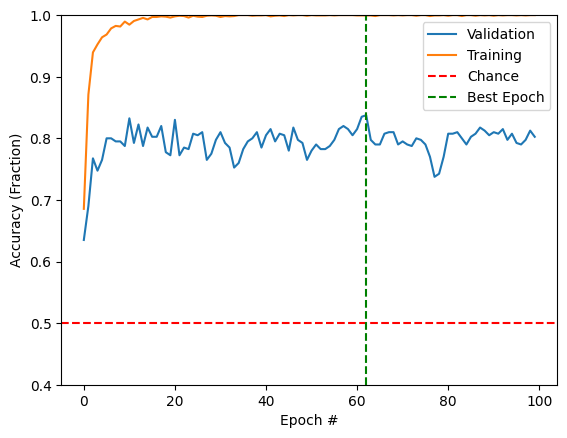

In [ ]:
### YOUR CODE HERE

train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
transfer_model = TransferClassifier(name = 'DenseNet121')
transfer_model.fit(train_data, train_labels, epochs = 100, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(transfer_model.history)
### END CODE

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10


 1/63 [..............................] - ETA: 3:21 - loss: 0.6758 - accuracy: 0.5312

 3/63 [>.............................] - ETA: 2s - loss: 0.6924 - accuracy: 0.5833  

 5/63 [=>............................] - ETA: 2s - loss: 0.7292 - accuracy: 0.5250

 6/63 [=>............................] - ETA: 2s - loss: 0.7207 - accuracy: 0.5312

 7/63 [==>...........................] - ETA: 2s - loss: 0.7281 - accuracy: 0.4955

 8/63 [==>...........................] - ETA: 2s - loss: 0.7276 - accuracy: 0.4883

 9/63 [===>..........................] - ETA: 2s - loss: 0.7255 - accuracy: 0.4792

10/63 [===>..........................] - ETA: 2s - loss: 0.7305 - accuracy: 0.4719

12/63 [====>.........................] - ETA: 2s - loss: 0.7242 - accuracy: 0.4818

14/63 [=====>........................] - ETA: 2s - loss: 0.7184 - accuracy: 0.5022

15/63 [======>.......................] - ETA: 2s - loss: 0.7139 - accuracy: 0.5146

16/63 [======>.......................] - ETA: 2s - loss: 0.7110 - accuracy: 0.5195

18/63 [=======>......................] - ETA: 2s - loss: 0.7023 - accuracy: 0.5382

19/63 [========>.....................] - ETA: 2s - loss: 0.6982 - accuracy: 0.5461

20/63 [========>.....................] - ETA: 2s - loss: 0.6967 - accuracy: 0.5453

21/63 [=========>....................] - ETA: 2s - loss: 0.6963 - accuracy: 0.5432

22/63 [=========>....................] - ETA: 2s - loss: 0.6954 - accuracy: 0.5455

23/63 [=========>....................] - ETA: 2s - loss: 0.6941 - accuracy: 0.5476

24/63 [==========>...................] - ETA: 2s - loss: 0.6913 - accuracy: 0.5508

26/63 [===========>..................] - ETA: 1s - loss: 0.6852 - accuracy: 0.5613

27/63 [===========>..................] - ETA: 1s - loss: 0.6841 - accuracy: 0.5637

29/63 [============>.................] - ETA: 1s - loss: 0.6784 - accuracy: 0.5700

30/63 [=============>................] - ETA: 1s - loss: 0.6762 - accuracy: 0.5771

31/63 [=============>................] - ETA: 1s - loss: 0.6742 - accuracy: 0.5857

32/63 [==============>...............] - ETA: 1s - loss: 0.6727 - accuracy: 0.5869

33/63 [==============>...............] - ETA: 1s - loss: 0.6673 - accuracy: 0.5956

34/63 [===============>..............] - ETA: 1s - loss: 0.6649 - accuracy: 0.5993

35/63 [===============>..............] - ETA: 1s - loss: 0.6640 - accuracy: 0.6000

36/63 [================>.............] - ETA: 1s - loss: 0.6618 - accuracy: 0.6042

38/63 [=================>............] - ETA: 1s - loss: 0.6572 - accuracy: 0.6127

39/63 [=================>............] - ETA: 1s - loss: 0.6547 - accuracy: 0.6178

40/63 [==================>...........] - ETA: 1s - loss: 0.6521 - accuracy: 0.6234

41/63 [==================>...........] - ETA: 1s - loss: 0.6503 - accuracy: 0.6265

42/63 [===================>..........] - ETA: 1s - loss: 0.6478 - accuracy: 0.6302

43/63 [===================>..........] - ETA: 1s - loss: 0.6436 - accuracy: 0.6344

44/63 [===================>..........] - ETA: 0s - loss: 0.6398 - accuracy: 0.6399

45/63 [====================>.........] - ETA: 0s - loss: 0.6365 - accuracy: 0.6424

46/63 [====================>.........] - ETA: 0s - loss: 0.6340 - accuracy: 0.6467

47/63 [=====================>........] - ETA: 0s - loss: 0.6300 - accuracy: 0.6516

48/63 [=====================>........] - ETA: 0s - loss: 0.6266 - accuracy: 0.6549

49/63 [======================>.......] - ETA: 0s - loss: 0.6220 - accuracy: 0.6601

50/63 [======================>.......] - ETA: 0s - loss: 0.6175 - accuracy: 0.6656

51/63 [=======================>......] - ETA: 0s - loss: 0.6130 - accuracy: 0.6691

52/63 [=======================>......] - ETA: 0s - loss: 0.6113 - accuracy: 0.6713

53/63 [========================>.....] - ETA: 0s - loss: 0.6069 - accuracy: 0.6751

54/63 [========================>.....] - ETA: 0s - loss: 0.6034 - accuracy: 0.6806

55/63 [=========================>....] - ETA: 0s - loss: 0.5993 - accuracy: 0.6835

56/63 [=========================>....] - ETA: 0s - loss: 0.5953 - accuracy: 0.6875

57/63 [==========================>...] - ETA: 0s - loss: 0.5910 - accuracy: 0.6908

59/63 [===========================>..] - ETA: 0s - loss: 0.5827 - accuracy: 0.6976

60/63 [===========================>..] - ETA: 0s - loss: 0.5767 - accuracy: 0.7021

61/63 [============================>.] - ETA: 0s - loss: 0.5722 - accuracy: 0.7054

62/63 [============================>.] - ETA: 0s - loss: 0.5674 - accuracy: 0.7082

63/63 [==============================] - 8s 82ms/step - loss: 0.5651 - accuracy: 0.7095 - val_loss: 0.4234 - val_accuracy: 0.8000
Epoch 2/10


 1/63 [..............................] - ETA: 3s - loss: 0.1965 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2365 - accuracy: 0.9062

 3/63 [>.............................] - ETA: 3s - loss: 0.2131 - accuracy: 0.9167

 4/63 [>.............................] - ETA: 3s - loss: 0.2892 - accuracy: 0.8906

 5/63 [=>............................] - ETA: 2s - loss: 0.2659 - accuracy: 0.9062

 6/63 [=>............................] - ETA: 2s - loss: 0.2588 - accuracy: 0.9167

 7/63 [==>...........................] - ETA: 2s - loss: 0.2543 - accuracy: 0.9196

 8/63 [==>...........................] - ETA: 2s - loss: 0.2664 - accuracy: 0.9180

 9/63 [===>..........................] - ETA: 2s - loss: 0.2632 - accuracy: 0.9201

11/63 [====>.........................] - ETA: 2s - loss: 0.2649 - accuracy: 0.9148

13/63 [=====>........................] - ETA: 2s - loss: 0.2520 - accuracy: 0.9183

14/63 [=====>........................] - ETA: 2s - loss: 0.2394 - accuracy: 0.9241

16/63 [======>.......................] - ETA: 2s - loss: 0.2438 - accuracy: 0.9199

18/63 [=======>......................] - ETA: 2s - loss: 0.2361 - accuracy: 0.9236

19/63 [========>.....................] - ETA: 2s - loss: 0.2369 - accuracy: 0.9243

20/63 [========>.....................] - ETA: 2s - loss: 0.2317 - accuracy: 0.9266

21/63 [=========>....................] - ETA: 2s - loss: 0.2345 - accuracy: 0.9256

22/63 [=========>....................] - ETA: 2s - loss: 0.2346 - accuracy: 0.9276

23/63 [=========>....................] - ETA: 2s - loss: 0.2332 - accuracy: 0.9266

24/63 [==========>...................] - ETA: 2s - loss: 0.2308 - accuracy: 0.9271

25/63 [==========>...................] - ETA: 1s - loss: 0.2344 - accuracy: 0.9225

26/63 [===========>..................] - ETA: 1s - loss: 0.2372 - accuracy: 0.9195

27/63 [===========>..................] - ETA: 1s - loss: 0.2363 - accuracy: 0.9201

29/63 [============>.................] - ETA: 1s - loss: 0.2326 - accuracy: 0.9203

30/63 [=============>................] - ETA: 1s - loss: 0.2304 - accuracy: 0.9198

31/63 [=============>................] - ETA: 1s - loss: 0.2322 - accuracy: 0.9194

32/63 [==============>...............] - ETA: 1s - loss: 0.2292 - accuracy: 0.9199

33/63 [==============>...............] - ETA: 1s - loss: 0.2283 - accuracy: 0.9205

34/63 [===============>..............] - ETA: 1s - loss: 0.2250 - accuracy: 0.9210

35/63 [===============>..............] - ETA: 1s - loss: 0.2251 - accuracy: 0.9205

36/63 [================>.............] - ETA: 1s - loss: 0.2247 - accuracy: 0.9201

37/63 [================>.............] - ETA: 1s - loss: 0.2203 - accuracy: 0.9223

38/63 [=================>............] - ETA: 1s - loss: 0.2222 - accuracy: 0.9219

39/63 [=================>............] - ETA: 1s - loss: 0.2253 - accuracy: 0.9207

40/63 [==================>...........] - ETA: 1s - loss: 0.2220 - accuracy: 0.9211

41/63 [==================>...........] - ETA: 1s - loss: 0.2211 - accuracy: 0.9200

42/63 [===================>..........] - ETA: 1s - loss: 0.2195 - accuracy: 0.9211

43/63 [===================>..........] - ETA: 1s - loss: 0.2159 - accuracy: 0.9230

44/63 [===================>..........] - ETA: 0s - loss: 0.2185 - accuracy: 0.9226

45/63 [====================>.........] - ETA: 0s - loss: 0.2156 - accuracy: 0.9229

46/63 [====================>.........] - ETA: 0s - loss: 0.2170 - accuracy: 0.9226

47/63 [=====================>........] - ETA: 0s - loss: 0.2147 - accuracy: 0.9229

48/63 [=====================>........] - ETA: 0s - loss: 0.2124 - accuracy: 0.9232

49/63 [======================>.......] - ETA: 0s - loss: 0.2103 - accuracy: 0.9241

50/63 [======================>.......] - ETA: 0s - loss: 0.2079 - accuracy: 0.9250

51/63 [=======================>......] - ETA: 0s - loss: 0.2072 - accuracy: 0.9252

52/63 [=======================>......] - ETA: 0s - loss: 0.2050 - accuracy: 0.9255

54/63 [========================>.....] - ETA: 0s - loss: 0.2080 - accuracy: 0.9236

55/63 [=========================>....] - ETA: 0s - loss: 0.2099 - accuracy: 0.9233

56/63 [=========================>....] - ETA: 0s - loss: 0.2081 - accuracy: 0.9241

57/63 [==========================>...] - ETA: 0s - loss: 0.2074 - accuracy: 0.9238

58/63 [==========================>...] - ETA: 0s - loss: 0.2077 - accuracy: 0.9240

59/63 [===========================>..] - ETA: 0s - loss: 0.2084 - accuracy: 0.9237

60/63 [===========================>..] - ETA: 0s - loss: 0.2066 - accuracy: 0.9240

61/63 [============================>.] - ETA: 0s - loss: 0.2053 - accuracy: 0.9247

62/63 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.9254

63/63 [==============================] - 3s 55ms/step - loss: 0.2023 - accuracy: 0.9260 - val_loss: 0.2767 - val_accuracy: 0.8825
Epoch 3/10


 1/63 [..............................] - ETA: 3s - loss: 0.3881 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.3193 - accuracy: 0.9062

 4/63 [>.............................] - ETA: 2s - loss: 0.2235 - accuracy: 0.9297

 5/63 [=>............................] - ETA: 2s - loss: 0.2041 - accuracy: 0.9375

 7/63 [==>...........................] - ETA: 2s - loss: 0.1900 - accuracy: 0.9420

 8/63 [==>...........................] - ETA: 2s - loss: 0.1817 - accuracy: 0.9375

10/63 [===>..........................] - ETA: 2s - loss: 0.1682 - accuracy: 0.9469

11/63 [====>.........................] - ETA: 2s - loss: 0.1610 - accuracy: 0.9489

13/63 [=====>........................] - ETA: 2s - loss: 0.1610 - accuracy: 0.9471

14/63 [=====>........................] - ETA: 2s - loss: 0.1603 - accuracy: 0.9464

15/63 [======>.......................] - ETA: 2s - loss: 0.1580 - accuracy: 0.9479

17/63 [=======>......................] - ETA: 2s - loss: 0.1614 - accuracy: 0.9467

18/63 [=======>......................] - ETA: 2s - loss: 0.1540 - accuracy: 0.9497

19/63 [========>.....................] - ETA: 2s - loss: 0.1502 - accuracy: 0.9507

20/63 [========>.....................] - ETA: 2s - loss: 0.1563 - accuracy: 0.9453

21/63 [=========>....................] - ETA: 2s - loss: 0.1527 - accuracy: 0.9464

22/63 [=========>....................] - ETA: 2s - loss: 0.1477 - accuracy: 0.9489

23/63 [=========>....................] - ETA: 2s - loss: 0.1436 - accuracy: 0.9511

25/63 [==========>...................] - ETA: 1s - loss: 0.1456 - accuracy: 0.9488

26/63 [===========>..................] - ETA: 1s - loss: 0.1465 - accuracy: 0.9483

28/63 [============>.................] - ETA: 1s - loss: 0.1467 - accuracy: 0.9487

29/63 [============>.................] - ETA: 1s - loss: 0.1462 - accuracy: 0.9483

30/63 [=============>................] - ETA: 1s - loss: 0.1568 - accuracy: 0.9458

32/63 [==============>...............] - ETA: 1s - loss: 0.1726 - accuracy: 0.9404

34/63 [===============>..............] - ETA: 1s - loss: 0.1725 - accuracy: 0.9393

35/63 [===============>..............] - ETA: 1s - loss: 0.1785 - accuracy: 0.9393

36/63 [================>.............] - ETA: 1s - loss: 0.1838 - accuracy: 0.9384

37/63 [================>.............] - ETA: 1s - loss: 0.1882 - accuracy: 0.9367

38/63 [=================>............] - ETA: 1s - loss: 0.1926 - accuracy: 0.9350

40/63 [==================>...........] - ETA: 1s - loss: 0.1889 - accuracy: 0.9367

41/63 [==================>...........] - ETA: 1s - loss: 0.1890 - accuracy: 0.9360

42/63 [===================>..........] - ETA: 1s - loss: 0.1890 - accuracy: 0.9360

43/63 [===================>..........] - ETA: 1s - loss: 0.1884 - accuracy: 0.9353

44/63 [===================>..........] - ETA: 0s - loss: 0.1907 - accuracy: 0.9339

46/63 [====================>.........] - ETA: 0s - loss: 0.1953 - accuracy: 0.9293

47/63 [=====================>........] - ETA: 0s - loss: 0.1950 - accuracy: 0.9289

48/63 [=====================>........] - ETA: 0s - loss: 0.1934 - accuracy: 0.9303

49/63 [======================>.......] - ETA: 0s - loss: 0.1910 - accuracy: 0.9318

50/63 [======================>.......] - ETA: 0s - loss: 0.1902 - accuracy: 0.9325

51/63 [=======================>......] - ETA: 0s - loss: 0.1884 - accuracy: 0.9332

52/63 [=======================>......] - ETA: 0s - loss: 0.1882 - accuracy: 0.9327

54/63 [========================>.....] - ETA: 0s - loss: 0.1933 - accuracy: 0.9300

55/63 [=========================>....] - ETA: 0s - loss: 0.1956 - accuracy: 0.9290

56/63 [=========================>....] - ETA: 0s - loss: 0.1959 - accuracy: 0.9286

58/63 [==========================>...] - ETA: 0s - loss: 0.1942 - accuracy: 0.9305

60/63 [===========================>..] - ETA: 0s - loss: 0.1938 - accuracy: 0.9302

61/63 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9308

62/63 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9299

63/63 [==============================] - 4s 56ms/step - loss: 0.1928 - accuracy: 0.9305 - val_loss: 0.2863 - val_accuracy: 0.8900
Epoch 4/10


 1/63 [..............................] - ETA: 3s - loss: 0.1492 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.1339 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.1942 - accuracy: 0.9375

 4/63 [>.............................] - ETA: 3s - loss: 0.1535 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1345 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.1428 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 2s - loss: 0.1448 - accuracy: 0.9464

 8/63 [==>...........................] - ETA: 2s - loss: 0.1391 - accuracy: 0.9492

 9/63 [===>..........................] - ETA: 2s - loss: 0.1546 - accuracy: 0.9444

10/63 [===>..........................] - ETA: 2s - loss: 0.1528 - accuracy: 0.9438

11/63 [====>.........................] - ETA: 2s - loss: 0.1544 - accuracy: 0.9460

12/63 [====>.........................] - ETA: 2s - loss: 0.1516 - accuracy: 0.9453

13/63 [=====>........................] - ETA: 2s - loss: 0.1512 - accuracy: 0.9447

14/63 [=====>........................] - ETA: 2s - loss: 0.1449 - accuracy: 0.9487

16/63 [======>.......................] - ETA: 2s - loss: 0.1580 - accuracy: 0.9414

17/63 [=======>......................] - ETA: 2s - loss: 0.1639 - accuracy: 0.9375

18/63 [=======>......................] - ETA: 2s - loss: 0.1579 - accuracy: 0.9392

20/63 [========>.....................] - ETA: 2s - loss: 0.1497 - accuracy: 0.9438

22/63 [=========>....................] - ETA: 2s - loss: 0.1392 - accuracy: 0.9489

24/63 [==========>...................] - ETA: 1s - loss: 0.1404 - accuracy: 0.9479

25/63 [==========>...................] - ETA: 1s - loss: 0.1361 - accuracy: 0.9500

26/63 [===========>..................] - ETA: 1s - loss: 0.1365 - accuracy: 0.9495

27/63 [===========>..................] - ETA: 1s - loss: 0.1346 - accuracy: 0.9502

29/63 [============>.................] - ETA: 1s - loss: 0.1288 - accuracy: 0.9537

30/63 [=============>................] - ETA: 1s - loss: 0.1283 - accuracy: 0.9542

31/63 [=============>................] - ETA: 1s - loss: 0.1335 - accuracy: 0.9526

32/63 [==============>...............] - ETA: 1s - loss: 0.1348 - accuracy: 0.9521

33/63 [==============>...............] - ETA: 1s - loss: 0.1312 - accuracy: 0.9536

35/63 [===============>..............] - ETA: 1s - loss: 0.1355 - accuracy: 0.9536

36/63 [================>.............] - ETA: 1s - loss: 0.1383 - accuracy: 0.9531

37/63 [================>.............] - ETA: 1s - loss: 0.1365 - accuracy: 0.9535

38/63 [=================>............] - ETA: 1s - loss: 0.1335 - accuracy: 0.9548

39/63 [=================>............] - ETA: 1s - loss: 0.1307 - accuracy: 0.9559

40/63 [==================>...........] - ETA: 1s - loss: 0.1309 - accuracy: 0.9555

41/63 [==================>...........] - ETA: 1s - loss: 0.1327 - accuracy: 0.9550

43/63 [===================>..........] - ETA: 1s - loss: 0.1288 - accuracy: 0.9564

44/63 [===================>..........] - ETA: 0s - loss: 0.1277 - accuracy: 0.9567

45/63 [====================>.........] - ETA: 0s - loss: 0.1256 - accuracy: 0.9576

46/63 [====================>.........] - ETA: 0s - loss: 0.1269 - accuracy: 0.9579

47/63 [=====================>........] - ETA: 0s - loss: 0.1279 - accuracy: 0.9568

48/63 [=====================>........] - ETA: 0s - loss: 0.1289 - accuracy: 0.9564

49/63 [======================>.......] - ETA: 0s - loss: 0.1270 - accuracy: 0.9573

50/63 [======================>.......] - ETA: 0s - loss: 0.1254 - accuracy: 0.9575

51/63 [=======================>......] - ETA: 0s - loss: 0.1256 - accuracy: 0.9577

52/63 [=======================>......] - ETA: 0s - loss: 0.1236 - accuracy: 0.9585

53/63 [========================>.....] - ETA: 0s - loss: 0.1262 - accuracy: 0.9575

54/63 [========================>.....] - ETA: 0s - loss: 0.1254 - accuracy: 0.9578

55/63 [=========================>....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9585

56/63 [=========================>....] - ETA: 0s - loss: 0.1235 - accuracy: 0.9581

57/63 [==========================>...] - ETA: 0s - loss: 0.1218 - accuracy: 0.9589

58/63 [==========================>...] - ETA: 0s - loss: 0.1217 - accuracy: 0.9591

59/63 [===========================>..] - ETA: 0s - loss: 0.1211 - accuracy: 0.9592

60/63 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9589

61/63 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9585

62/63 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9587

63/63 [==============================] - 4s 57ms/step - loss: 0.1204 - accuracy: 0.9590 - val_loss: 0.5304 - val_accuracy: 0.8225
Epoch 5/10


 1/63 [..............................] - ETA: 2s - loss: 0.0279 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0903 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.0710 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0562 - accuracy: 0.9812

 7/63 [==>...........................] - ETA: 2s - loss: 0.0570 - accuracy: 0.9777

 9/63 [===>..........................] - ETA: 2s - loss: 0.0673 - accuracy: 0.9722

10/63 [===>..........................] - ETA: 2s - loss: 0.0710 - accuracy: 0.9719

12/63 [====>.........................] - ETA: 2s - loss: 0.0706 - accuracy: 0.9714

13/63 [=====>........................] - ETA: 2s - loss: 0.0775 - accuracy: 0.9663

15/63 [======>.......................] - ETA: 2s - loss: 0.0735 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 2s - loss: 0.0857 - accuracy: 0.9596

19/63 [========>.....................] - ETA: 2s - loss: 0.0883 - accuracy: 0.9589

21/63 [=========>....................] - ETA: 2s - loss: 0.0885 - accuracy: 0.9613

22/63 [=========>....................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9588

23/63 [=========>....................] - ETA: 1s - loss: 0.0893 - accuracy: 0.9606

25/63 [==========>...................] - ETA: 1s - loss: 0.0866 - accuracy: 0.9625

26/63 [===========>..................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9615

28/63 [============>.................] - ETA: 1s - loss: 0.0919 - accuracy: 0.9621

29/63 [============>.................] - ETA: 1s - loss: 0.0909 - accuracy: 0.9623

31/63 [=============>................] - ETA: 1s - loss: 0.0885 - accuracy: 0.9637

32/63 [==============>...............] - ETA: 1s - loss: 0.0912 - accuracy: 0.9629

33/63 [==============>...............] - ETA: 1s - loss: 0.0933 - accuracy: 0.9631

34/63 [===============>..............] - ETA: 1s - loss: 0.0913 - accuracy: 0.9642

35/63 [===============>..............] - ETA: 1s - loss: 0.0904 - accuracy: 0.9652

36/63 [================>.............] - ETA: 1s - loss: 0.0927 - accuracy: 0.9653

37/63 [================>.............] - ETA: 1s - loss: 0.0954 - accuracy: 0.9645

38/63 [=================>............] - ETA: 1s - loss: 0.0971 - accuracy: 0.9638

39/63 [=================>............] - ETA: 1s - loss: 0.0971 - accuracy: 0.9631

40/63 [==================>...........] - ETA: 1s - loss: 0.0960 - accuracy: 0.9641

41/63 [==================>...........] - ETA: 1s - loss: 0.0939 - accuracy: 0.9649

42/63 [===================>..........] - ETA: 1s - loss: 0.0938 - accuracy: 0.9650

43/63 [===================>..........] - ETA: 1s - loss: 0.0925 - accuracy: 0.9658

44/63 [===================>..........] - ETA: 0s - loss: 0.0920 - accuracy: 0.9659

46/63 [====================>.........] - ETA: 0s - loss: 0.0914 - accuracy: 0.9654

47/63 [=====================>........] - ETA: 0s - loss: 0.0906 - accuracy: 0.9654

48/63 [=====================>........] - ETA: 0s - loss: 0.0895 - accuracy: 0.9655

49/63 [======================>.......] - ETA: 0s - loss: 0.0879 - accuracy: 0.9662

50/63 [======================>.......] - ETA: 0s - loss: 0.0872 - accuracy: 0.9663

51/63 [=======================>......] - ETA: 0s - loss: 0.0865 - accuracy: 0.9663

52/63 [=======================>......] - ETA: 0s - loss: 0.0866 - accuracy: 0.9657

53/63 [========================>.....] - ETA: 0s - loss: 0.0853 - accuracy: 0.9664

54/63 [========================>.....] - ETA: 0s - loss: 0.0861 - accuracy: 0.9659

56/63 [=========================>....] - ETA: 0s - loss: 0.0881 - accuracy: 0.9654

57/63 [==========================>...] - ETA: 0s - loss: 0.0870 - accuracy: 0.9660

59/63 [===========================>..] - ETA: 0s - loss: 0.0859 - accuracy: 0.9661

61/63 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9652

63/63 [==============================] - 4s 56ms/step - loss: 0.0874 - accuracy: 0.9655 - val_loss: 0.5231 - val_accuracy: 0.8175
Epoch 6/10


 1/63 [..............................] - ETA: 2s - loss: 0.2386 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2223 - accuracy: 0.9375

 3/63 [>.............................] - ETA: 3s - loss: 0.2470 - accuracy: 0.9271

 4/63 [>.............................] - ETA: 3s - loss: 0.2005 - accuracy: 0.9375

 5/63 [=>............................] - ETA: 3s - loss: 0.1694 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.1741 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 2s - loss: 0.1591 - accuracy: 0.9464

 8/63 [==>...........................] - ETA: 2s - loss: 0.1417 - accuracy: 0.9531

 9/63 [===>..........................] - ETA: 2s - loss: 0.1384 - accuracy: 0.9514

10/63 [===>..........................] - ETA: 2s - loss: 0.1485 - accuracy: 0.9469

11/63 [====>.........................] - ETA: 2s - loss: 0.1384 - accuracy: 0.9517

12/63 [====>.........................] - ETA: 2s - loss: 0.1354 - accuracy: 0.9505

13/63 [=====>........................] - ETA: 2s - loss: 0.1269 - accuracy: 0.9543

14/63 [=====>........................] - ETA: 2s - loss: 0.1194 - accuracy: 0.9576

15/63 [======>.......................] - ETA: 2s - loss: 0.1140 - accuracy: 0.9583

16/63 [======>.......................] - ETA: 2s - loss: 0.1099 - accuracy: 0.9590

18/63 [=======>......................] - ETA: 2s - loss: 0.1051 - accuracy: 0.9618

19/63 [========>.....................] - ETA: 2s - loss: 0.1013 - accuracy: 0.9638

20/63 [========>.....................] - ETA: 2s - loss: 0.1044 - accuracy: 0.9594

21/63 [=========>....................] - ETA: 2s - loss: 0.1069 - accuracy: 0.9583

22/63 [=========>....................] - ETA: 2s - loss: 0.1031 - accuracy: 0.9602

23/63 [=========>....................] - ETA: 2s - loss: 0.1015 - accuracy: 0.9606

24/63 [==========>...................] - ETA: 2s - loss: 0.0985 - accuracy: 0.9622

25/63 [==========>...................] - ETA: 1s - loss: 0.0960 - accuracy: 0.9638

27/63 [===========>..................] - ETA: 1s - loss: 0.1001 - accuracy: 0.9630

28/63 [============>.................] - ETA: 1s - loss: 0.1010 - accuracy: 0.9632

29/63 [============>.................] - ETA: 1s - loss: 0.1000 - accuracy: 0.9634

31/63 [=============>................] - ETA: 1s - loss: 0.0951 - accuracy: 0.9657

32/63 [==============>...............] - ETA: 1s - loss: 0.0932 - accuracy: 0.9668

34/63 [===============>..............] - ETA: 1s - loss: 0.0910 - accuracy: 0.9678

35/63 [===============>..............] - ETA: 1s - loss: 0.0888 - accuracy: 0.9688

36/63 [================>.............] - ETA: 1s - loss: 0.0878 - accuracy: 0.9688

37/63 [================>.............] - ETA: 1s - loss: 0.0858 - accuracy: 0.9696

38/63 [=================>............] - ETA: 1s - loss: 0.0841 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 1s - loss: 0.0878 - accuracy: 0.9695

42/63 [===================>..........] - ETA: 1s - loss: 0.0888 - accuracy: 0.9695

44/63 [===================>..........] - ETA: 0s - loss: 0.0884 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 0s - loss: 0.0872 - accuracy: 0.9701

46/63 [====================>.........] - ETA: 0s - loss: 0.0857 - accuracy: 0.9708

47/63 [=====================>........] - ETA: 0s - loss: 0.0843 - accuracy: 0.9714

48/63 [=====================>........] - ETA: 0s - loss: 0.0864 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0876 - accuracy: 0.9700

50/63 [======================>.......] - ETA: 0s - loss: 0.0869 - accuracy: 0.9700

51/63 [=======================>......] - ETA: 0s - loss: 0.0866 - accuracy: 0.9700

52/63 [=======================>......] - ETA: 0s - loss: 0.0857 - accuracy: 0.9706

53/63 [========================>.....] - ETA: 0s - loss: 0.0850 - accuracy: 0.9705

54/63 [========================>.....] - ETA: 0s - loss: 0.0843 - accuracy: 0.9711

56/63 [=========================>....] - ETA: 0s - loss: 0.0834 - accuracy: 0.9715

57/63 [==========================>...] - ETA: 0s - loss: 0.0860 - accuracy: 0.9688

59/63 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9682

60/63 [===========================>..] - ETA: 0s - loss: 0.0840 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.0844 - accuracy: 0.9688

62/63 [============================>.] - ETA: 0s - loss: 0.0859 - accuracy: 0.9677

63/63 [==============================] - 4s 57ms/step - loss: 0.0853 - accuracy: 0.9680 - val_loss: 1.6584 - val_accuracy: 0.6075
Epoch 7/10


 1/63 [..............................] - ETA: 3s - loss: 0.2235 - accuracy: 0.9062

 2/63 [..............................] - ETA: 3s - loss: 0.1274 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.1060 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1161 - accuracy: 0.9453

 5/63 [=>............................] - ETA: 2s - loss: 0.1006 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 2s - loss: 0.1029 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 2s - loss: 0.0901 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 2s - loss: 0.0825 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 2s - loss: 0.0823 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 2s - loss: 0.0791 - accuracy: 0.9656

12/63 [====>.........................] - ETA: 2s - loss: 0.0845 - accuracy: 0.9661

13/63 [=====>........................] - ETA: 2s - loss: 0.0878 - accuracy: 0.9663

14/63 [=====>........................] - ETA: 2s - loss: 0.0981 - accuracy: 0.9643

16/63 [======>.......................] - ETA: 2s - loss: 0.0993 - accuracy: 0.9648

17/63 [=======>......................] - ETA: 2s - loss: 0.1020 - accuracy: 0.9651

18/63 [=======>......................] - ETA: 2s - loss: 0.1048 - accuracy: 0.9635

20/63 [========>.....................] - ETA: 2s - loss: 0.1174 - accuracy: 0.9625

22/63 [=========>....................] - ETA: 2s - loss: 0.1158 - accuracy: 0.9616

24/63 [==========>...................] - ETA: 2s - loss: 0.1092 - accuracy: 0.9648

25/63 [==========>...................] - ETA: 1s - loss: 0.1141 - accuracy: 0.9638

26/63 [===========>..................] - ETA: 1s - loss: 0.1188 - accuracy: 0.9627

27/63 [===========>..................] - ETA: 1s - loss: 0.1170 - accuracy: 0.9641

28/63 [============>.................] - ETA: 1s - loss: 0.1170 - accuracy: 0.9643

29/63 [============>.................] - ETA: 1s - loss: 0.1191 - accuracy: 0.9634

30/63 [=============>................] - ETA: 1s - loss: 0.1216 - accuracy: 0.9625

32/63 [==============>...............] - ETA: 1s - loss: 0.1175 - accuracy: 0.9629

33/63 [==============>...............] - ETA: 1s - loss: 0.1157 - accuracy: 0.9640

34/63 [===============>..............] - ETA: 1s - loss: 0.1133 - accuracy: 0.9651

35/63 [===============>..............] - ETA: 1s - loss: 0.1157 - accuracy: 0.9634

36/63 [================>.............] - ETA: 1s - loss: 0.1131 - accuracy: 0.9644

37/63 [================>.............] - ETA: 1s - loss: 0.1142 - accuracy: 0.9645

38/63 [=================>............] - ETA: 1s - loss: 0.1210 - accuracy: 0.9613

39/63 [=================>............] - ETA: 1s - loss: 0.1239 - accuracy: 0.9607

40/63 [==================>...........] - ETA: 1s - loss: 0.1221 - accuracy: 0.9617

41/63 [==================>...........] - ETA: 1s - loss: 0.1198 - accuracy: 0.9627

43/63 [===================>..........] - ETA: 1s - loss: 0.1166 - accuracy: 0.9637

44/63 [===================>..........] - ETA: 0s - loss: 0.1182 - accuracy: 0.9631

45/63 [====================>.........] - ETA: 0s - loss: 0.1183 - accuracy: 0.9625

47/63 [=====================>........] - ETA: 0s - loss: 0.1173 - accuracy: 0.9628

48/63 [=====================>........] - ETA: 0s - loss: 0.1200 - accuracy: 0.9609

49/63 [======================>.......] - ETA: 0s - loss: 0.1188 - accuracy: 0.9617

50/63 [======================>.......] - ETA: 0s - loss: 0.1179 - accuracy: 0.9619

51/63 [=======================>......] - ETA: 0s - loss: 0.1192 - accuracy: 0.9620

52/63 [=======================>......] - ETA: 0s - loss: 0.1190 - accuracy: 0.9615

54/63 [========================>.....] - ETA: 0s - loss: 0.1173 - accuracy: 0.9624

55/63 [=========================>....] - ETA: 0s - loss: 0.1179 - accuracy: 0.9625

56/63 [=========================>....] - ETA: 0s - loss: 0.1167 - accuracy: 0.9632

57/63 [==========================>...] - ETA: 0s - loss: 0.1161 - accuracy: 0.9633

58/63 [==========================>...] - ETA: 0s - loss: 0.1150 - accuracy: 0.9639

59/63 [===========================>..] - ETA: 0s - loss: 0.1174 - accuracy: 0.9624

60/63 [===========================>..] - ETA: 0s - loss: 0.1165 - accuracy: 0.9625

61/63 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9631

62/63 [============================>.] - ETA: 0s - loss: 0.1139 - accuracy: 0.9637

63/63 [==============================] - 4s 57ms/step - loss: 0.1131 - accuracy: 0.9640 - val_loss: 0.6161 - val_accuracy: 0.7800
Epoch 8/10


 1/63 [..............................] - ETA: 3s - loss: 0.0752 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.0639 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0545 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0509 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 3s - loss: 0.0517 - accuracy: 0.9875

 6/63 [=>............................] - ETA: 2s - loss: 0.0784 - accuracy: 0.9740

 7/63 [==>...........................] - ETA: 2s - loss: 0.0796 - accuracy: 0.9732

 9/63 [===>..........................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9722

11/63 [====>.........................] - ETA: 2s - loss: 0.0907 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 2s - loss: 0.0869 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 2s - loss: 0.0815 - accuracy: 0.9712

14/63 [=====>........................] - ETA: 2s - loss: 0.0771 - accuracy: 0.9732

15/63 [======>.......................] - ETA: 2s - loss: 0.0763 - accuracy: 0.9729

16/63 [======>.......................] - ETA: 2s - loss: 0.0745 - accuracy: 0.9746

17/63 [=======>......................] - ETA: 2s - loss: 0.0811 - accuracy: 0.9724

18/63 [=======>......................] - ETA: 2s - loss: 0.0830 - accuracy: 0.9705

20/63 [========>.....................] - ETA: 2s - loss: 0.0820 - accuracy: 0.9688

21/63 [=========>....................] - ETA: 2s - loss: 0.0815 - accuracy: 0.9673

22/63 [=========>....................] - ETA: 2s - loss: 0.0810 - accuracy: 0.9673

23/63 [=========>....................] - ETA: 2s - loss: 0.0803 - accuracy: 0.9674

25/63 [==========>...................] - ETA: 1s - loss: 0.0796 - accuracy: 0.9663

27/63 [===========>..................] - ETA: 1s - loss: 0.0749 - accuracy: 0.9688

29/63 [============>.................] - ETA: 1s - loss: 0.0738 - accuracy: 0.9688

30/63 [=============>................] - ETA: 1s - loss: 0.0739 - accuracy: 0.9688

32/63 [==============>...............] - ETA: 1s - loss: 0.0721 - accuracy: 0.9697

33/63 [==============>...............] - ETA: 1s - loss: 0.0723 - accuracy: 0.9697

34/63 [===============>..............] - ETA: 1s - loss: 0.0709 - accuracy: 0.9706

36/63 [================>.............] - ETA: 1s - loss: 0.0678 - accuracy: 0.9722

38/63 [=================>............] - ETA: 1s - loss: 0.0671 - accuracy: 0.9729

40/63 [==================>...........] - ETA: 1s - loss: 0.0687 - accuracy: 0.9711

41/63 [==================>...........] - ETA: 1s - loss: 0.0676 - accuracy: 0.9718

43/63 [===================>..........] - ETA: 1s - loss: 0.0681 - accuracy: 0.9709

45/63 [====================>.........] - ETA: 0s - loss: 0.0666 - accuracy: 0.9715

46/63 [====================>.........] - ETA: 0s - loss: 0.0674 - accuracy: 0.9715

48/63 [=====================>........] - ETA: 0s - loss: 0.0670 - accuracy: 0.9720

49/63 [======================>.......] - ETA: 0s - loss: 0.0683 - accuracy: 0.9713

50/63 [======================>.......] - ETA: 0s - loss: 0.0689 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0690 - accuracy: 0.9706

52/63 [=======================>......] - ETA: 0s - loss: 0.0680 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0691 - accuracy: 0.9705

54/63 [========================>.....] - ETA: 0s - loss: 0.0720 - accuracy: 0.9699

55/63 [=========================>....] - ETA: 0s - loss: 0.0708 - accuracy: 0.9705

57/63 [==========================>...] - ETA: 0s - loss: 0.0692 - accuracy: 0.9709

58/63 [==========================>...] - ETA: 0s - loss: 0.0713 - accuracy: 0.9704

59/63 [===========================>..] - ETA: 0s - loss: 0.0708 - accuracy: 0.9703

60/63 [===========================>..] - ETA: 0s - loss: 0.0726 - accuracy: 0.9688

61/63 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9688

63/63 [==============================] - 4s 56ms/step - loss: 0.0748 - accuracy: 0.9690 - val_loss: 1.1183 - val_accuracy: 0.6750
Epoch 9/10


 1/63 [..............................] - ETA: 3s - loss: 0.0537 - accuracy: 0.9688

 2/63 [..............................] - ETA: 3s - loss: 0.0964 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.0850 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1003 - accuracy: 0.9531

 6/63 [=>............................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 2s - loss: 0.0675 - accuracy: 0.9727

10/63 [===>..........................] - ETA: 2s - loss: 0.0757 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 2s - loss: 0.0712 - accuracy: 0.9716

12/63 [====>.........................] - ETA: 2s - loss: 0.0746 - accuracy: 0.9714

13/63 [=====>........................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9712

14/63 [=====>........................] - ETA: 2s - loss: 0.0688 - accuracy: 0.9732

16/63 [======>.......................] - ETA: 2s - loss: 0.0674 - accuracy: 0.9727

17/63 [=======>......................] - ETA: 2s - loss: 0.0704 - accuracy: 0.9724

18/63 [=======>......................] - ETA: 2s - loss: 0.0719 - accuracy: 0.9722

19/63 [========>.....................] - ETA: 2s - loss: 0.0691 - accuracy: 0.9737

20/63 [========>.....................] - ETA: 2s - loss: 0.0664 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0646 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0635 - accuracy: 0.9773

23/63 [=========>....................] - ETA: 2s - loss: 0.0646 - accuracy: 0.9769

24/63 [==========>...................] - ETA: 1s - loss: 0.0625 - accuracy: 0.9779

25/63 [==========>...................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9775

26/63 [===========>..................] - ETA: 1s - loss: 0.0637 - accuracy: 0.9772

28/63 [============>.................] - ETA: 1s - loss: 0.0605 - accuracy: 0.9788

29/63 [============>.................] - ETA: 1s - loss: 0.0602 - accuracy: 0.9784

30/63 [=============>................] - ETA: 1s - loss: 0.0608 - accuracy: 0.9771

31/63 [=============>................] - ETA: 1s - loss: 0.0604 - accuracy: 0.9778

32/63 [==============>...............] - ETA: 1s - loss: 0.0621 - accuracy: 0.9766

33/63 [==============>...............] - ETA: 1s - loss: 0.0609 - accuracy: 0.9773

34/63 [===============>..............] - ETA: 1s - loss: 0.0608 - accuracy: 0.9770

35/63 [===============>..............] - ETA: 1s - loss: 0.0604 - accuracy: 0.9768

36/63 [================>.............] - ETA: 1s - loss: 0.0636 - accuracy: 0.9757

38/63 [=================>............] - ETA: 1s - loss: 0.0667 - accuracy: 0.9745

40/63 [==================>...........] - ETA: 1s - loss: 0.0658 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 1s - loss: 0.0646 - accuracy: 0.9748

42/63 [===================>..........] - ETA: 1s - loss: 0.0668 - accuracy: 0.9747

44/63 [===================>..........] - ETA: 0s - loss: 0.0702 - accuracy: 0.9730

45/63 [====================>.........] - ETA: 0s - loss: 0.0690 - accuracy: 0.9736

46/63 [====================>.........] - ETA: 0s - loss: 0.0760 - accuracy: 0.9715

47/63 [=====================>........] - ETA: 0s - loss: 0.0759 - accuracy: 0.9714

48/63 [=====================>........] - ETA: 0s - loss: 0.0777 - accuracy: 0.9707

49/63 [======================>.......] - ETA: 0s - loss: 0.0778 - accuracy: 0.9707

50/63 [======================>.......] - ETA: 0s - loss: 0.0766 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0775 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0756 - accuracy: 0.9717

54/63 [========================>.....] - ETA: 0s - loss: 0.0748 - accuracy: 0.9722

55/63 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9727

56/63 [=========================>....] - ETA: 0s - loss: 0.0728 - accuracy: 0.9732

57/63 [==========================>...] - ETA: 0s - loss: 0.0769 - accuracy: 0.9720

58/63 [==========================>...] - ETA: 0s - loss: 0.0772 - accuracy: 0.9714

59/63 [===========================>..] - ETA: 0s - loss: 0.0779 - accuracy: 0.9709

60/63 [===========================>..] - ETA: 0s - loss: 0.0768 - accuracy: 0.9714

61/63 [============================>.] - ETA: 0s - loss: 0.0776 - accuracy: 0.9708

62/63 [============================>.] - ETA: 0s - loss: 0.0783 - accuracy: 0.9708

63/63 [==============================] - 4s 57ms/step - loss: 0.0779 - accuracy: 0.9710 - val_loss: 0.9530 - val_accuracy: 0.6925
Epoch 10/10


 1/63 [..............................] - ETA: 3s - loss: 0.0104 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 2s - loss: 0.1074 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 2s - loss: 0.0944 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 2s - loss: 0.0852 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 2s - loss: 0.0860 - accuracy: 0.9740

 8/63 [==>...........................] - ETA: 2s - loss: 0.0828 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 2s - loss: 0.0754 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 2s - loss: 0.0755 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9773

13/63 [=====>........................] - ETA: 2s - loss: 0.0747 - accuracy: 0.9736

14/63 [=====>........................] - ETA: 2s - loss: 0.0795 - accuracy: 0.9732

15/63 [======>.......................] - ETA: 2s - loss: 0.0763 - accuracy: 0.9750

16/63 [======>.......................] - ETA: 2s - loss: 0.0800 - accuracy: 0.9746

18/63 [=======>......................] - ETA: 2s - loss: 0.0776 - accuracy: 0.9757

20/63 [========>.....................] - ETA: 2s - loss: 0.0730 - accuracy: 0.9766

21/63 [=========>....................] - ETA: 2s - loss: 0.0716 - accuracy: 0.9762

22/63 [=========>....................] - ETA: 2s - loss: 0.0703 - accuracy: 0.9759

23/63 [=========>....................] - ETA: 2s - loss: 0.0721 - accuracy: 0.9728

24/63 [==========>...................] - ETA: 2s - loss: 0.0703 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 1s - loss: 0.0696 - accuracy: 0.9750

26/63 [===========>..................] - ETA: 1s - loss: 0.0674 - accuracy: 0.9760

27/63 [===========>..................] - ETA: 1s - loss: 0.0697 - accuracy: 0.9757

29/63 [============>.................] - ETA: 1s - loss: 0.0705 - accuracy: 0.9763

30/63 [=============>................] - ETA: 1s - loss: 0.0691 - accuracy: 0.9771

32/63 [==============>...............] - ETA: 1s - loss: 0.0682 - accuracy: 0.9775

34/63 [===============>..............] - ETA: 1s - loss: 0.0652 - accuracy: 0.9789

35/63 [===============>..............] - ETA: 1s - loss: 0.0638 - accuracy: 0.9795

36/63 [================>.............] - ETA: 1s - loss: 0.0634 - accuracy: 0.9792

37/63 [================>.............] - ETA: 1s - loss: 0.0639 - accuracy: 0.9789

38/63 [=================>............] - ETA: 1s - loss: 0.0625 - accuracy: 0.9794

40/63 [==================>...........] - ETA: 1s - loss: 0.0603 - accuracy: 0.9805

42/63 [===================>..........] - ETA: 1s - loss: 0.0600 - accuracy: 0.9799

43/63 [===================>..........] - ETA: 1s - loss: 0.0592 - accuracy: 0.9804

44/63 [===================>..........] - ETA: 0s - loss: 0.0591 - accuracy: 0.9801

45/63 [====================>.........] - ETA: 0s - loss: 0.0579 - accuracy: 0.9806

46/63 [====================>.........] - ETA: 0s - loss: 0.0569 - accuracy: 0.9810

47/63 [=====================>........] - ETA: 0s - loss: 0.0576 - accuracy: 0.9801

48/63 [=====================>........] - ETA: 0s - loss: 0.0569 - accuracy: 0.9805

49/63 [======================>.......] - ETA: 0s - loss: 0.0582 - accuracy: 0.9802

50/63 [======================>.......] - ETA: 0s - loss: 0.0596 - accuracy: 0.9800

52/63 [=======================>......] - ETA: 0s - loss: 0.0605 - accuracy: 0.9796

54/63 [========================>.....] - ETA: 0s - loss: 0.0604 - accuracy: 0.9797

55/63 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9801

56/63 [=========================>....] - ETA: 0s - loss: 0.0593 - accuracy: 0.9799

57/63 [==========================>...] - ETA: 0s - loss: 0.0589 - accuracy: 0.9797

59/63 [===========================>..] - ETA: 0s - loss: 0.0624 - accuracy: 0.9788

60/63 [===========================>..] - ETA: 0s - loss: 0.0617 - accuracy: 0.9792

61/63 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9785

62/63 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9788

63/63 [==============================] - 3s 55ms/step - loss: 0.0616 - accuracy: 0.9785 - val_loss: 1.1870 - val_accuracy: 0.6850


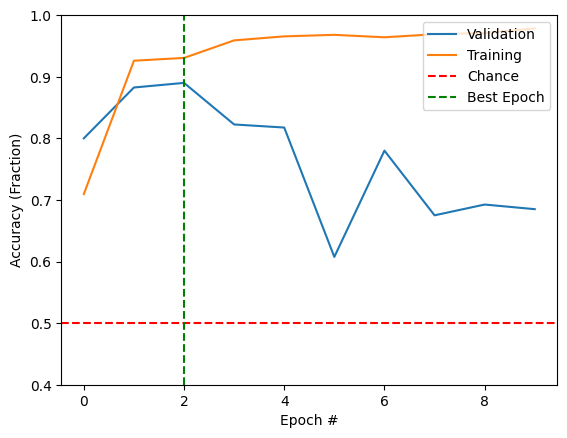

In [ ]:
#@title Sample Solution { display-mode: "form" }
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()
transfer = TransferClassifier(name = 'VGG16')
transfer.fit(train_data, train_labels, epochs = 10, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
plot_acc(transfer.history)

**This sample solution only uses VGG16. Now try using the other expert models.**

# **Milestone 5. Model Evaluation**



### Exercise (Coding)

Set your best model to the one you have trained (e.g., the transfer learning model).

In [ ]:
## Fill in the blank with the model that did best based on accuracy.
best_model =transfer_model.evaluate(test_data, test_labels, verbose=0)
print("model performance\t:  ",best_model)

model performance	:   [1.169490098953247, 0.8025000095367432]


Total accuracy does not reflect all that we want to know about a model's performance. It's just one metric out of many possible metrics for evaluating models.

In the case of pneumonia prediction, we may be more interested in other quantities, such as 'how accurate were we on the pneumonia category?' or 'how accurate were we on the normal category?' or 'how much of pneumonia were confused for normal?' or vice versa.



Our metrics for classification can be described in terms of a 'confusion matrix', shown below.

![Confusion Matrix](https://cdn-images-1.medium.com/max/1600/1*Z54JgbS4DUwWSknhDCvNTQ.png)

In a confusion matrix, we think in terms of 'actual' and 'predicted values'. If we take Pneumonia = 1/Positive and Normal = 0/Negative, then **what do TP, FP, TN, and FN mean?**

Answer:
1. TP: True positive (True pneumonia): Pneumonia predicted as pneumonia
2. TN: True negative (True normal): Normal predicted as normal
3. FP: False positive (False pneumonia): Normal mistaken as pneumonia
4. FN: False negative (False normal): Pneumonia mistaken as normal




The `sklearn` package makes calculating confusion matrices very quick. Its `metrics` submodule actually comes with a `confusion_matrix` tool. Let's start by grabbing that.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

To use `confusion_matrix`, we need:
* `labels`: the labels of the data (1 - PNEUMONIA or 0 - NORMAL)
* `predictions`: what our model thinks the labels are

To get `predictions`, you'll want to use ```best_model.predict_classes(test_data)```.

Please get the `predictions`, and use `accuracy_score` to print the overall test accuracy:

In [ ]:
#YOUR CODE HERE
predictions = (transfer_model.predict(test_data) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(test_labels, predictions)*100.0)

13/13 [==============================] - 0s 24ms/step
Accuracy:  80.25


In [ ]:
#@title Sample Solution
#predictions = (best_model.predict(test_data) > 0.5).astype("int32")
#print('Accuracy: ', accuracy_score(test_labels, predictions)*100.0)

Now let's get our confusion matrix, and split it out into true positive, true negative, false positive, and false negative!

In [ ]:
confusion = confusion_matrix(test_labels, predictions)
print(confusion)

[[122  78]
 [  1 199]]


**How do you interpret each number?**

In [ ]:
tp  = confusion[0][0]
tn  = confusion[1][1]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

True positive: 122
True negative: 199
False positive: 78
False negative: 1


We can visualize the confusion matrix with seaborn to make it easier for our eyes...

In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

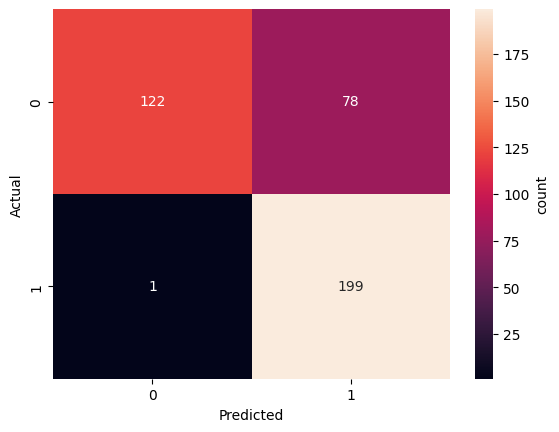

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');

**Now that we have our confusion matrix, let's take a step back and think about these questions**

What did our model confuse more?
* PNEUMONIA for NORMAL or...
* NORMAL for PNEUMONIA

Why do you think it might have confused one for the other?

What is more problematic? False positives or False negatives?

Which of these metrics do we want to keep low?

# End!


To recap, we learned what neural network models are, learned how to create/build them, and explored different types of neural networks. By introducing convolutions and more complex methods to our networks (making the convolutional neural networks and expert models), we can improve our models quite a lot.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10338/logos/header.png)